In [4]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy import signal
from mne.time_frequency import psd_array_multitaper
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner
import plotly
from scipy.stats import chisquare

/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [6]:
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f" OMP_NUM_THREADS=4 ./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[50:, 1]  
     
    if(Normalizacion=="max_global"):    
        data=data / max(data)
    elif(Normalizacion=="max_global_abs"):
        data=data / max(abs(data))
    elif(Normalizacion=="zscore"):
        data=(data - np.mean(data)) / np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full',n_jobs=3)
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



In [7]:
def Datos_reales(nombres,Normalizacion):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    mean_welch=np.zeros(481)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    all_signals=np.empty_like(Datos)
    for i, nombre in enumerate(nombres): 
        all_signals[i]=np.loadtxt(nombre)

    all_values = np.concatenate(all_signals)  # Combinar todos los datos
    global_max = np.max(all_values)
    global_max_abs = np.max(abs(all_values))
    global_mean = np.mean(all_values)
    global_std = np.std(all_values)

    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 
        data = np.loadtxt(nombre)

        if(Normalizacion=="max_global"):    
            data=data / global_max
        elif(Normalizacion=="max_global_abs"):
            data=data /global_max_abs
        elif(Normalizacion=="zscore"):
            data=(data -global_mean) / global_std

        Datos[i]=data
        Butter[i]=butter= signal.filtfilt(b, a,data)

        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [8]:
Params={'L': 49, 'P': 0.18480288512056137, 'Inh': 0.3568274238758705, 'Trest': 0.001388460705036468, 'Trelative': 0.1037062403200316, 'C_h': 0.8657675703460452, 'Tipo_red': 1}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8050, Params["Tipo_red"]]

Normalizacion="zscore"###"max_global""max_global_abs" zscore
generated_data = Simulado_EGG(initial_params,Normalizacion)


reales_total = Datos_reales(["Datos_reales/P3_MNE.txt","Datos_reales/Pz_MNE.txt","Datos_reales/P4_MNE.txt"],Normalizacion)

    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']


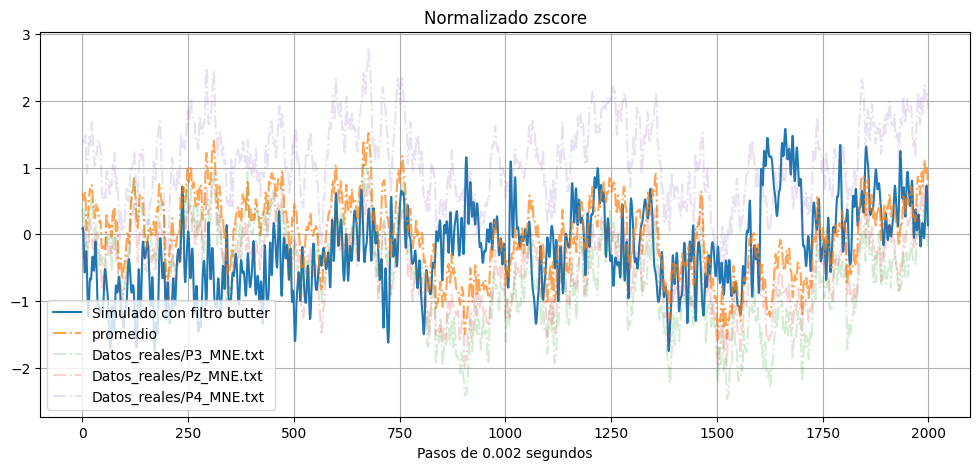

In [9]:
fig, ax = plt.subplots(figsize=[12, 5])


print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")

ax.plot(generated_data["butter"][:],label="Simulado con filtro butter")
grupos = np.array([reales_total["datos"][0], reales_total["datos"][1], reales_total["datos"][2]])
promedio = np.mean(grupos, axis=0) 

ax.plot(promedio,"-.", label="promedio",alpha=0.7)

for i in range(3):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.2)


plt.xlabel("Pasos de 0.002 segundos")
#plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.title(f"Normalizado {Normalizacion}")
plt.show()  # Mostrar todos los gráficos en la misma figura


241
['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']
Delta [np.float64(-12.81079647226871), np.float64(2.47832746825149)] ---- [-14.32308775   2.88420902]
Theta [np.float64(-18.962615069593014), np.float64(1.5193222431157007)] ---- [-18.96571845   1.24854892]
Alpha [np.float64(-21.856946912684375), np.float64(1.3125319715213362)] ---- [-21.50437221   1.65501801]
Beta [np.float64(-27.230879440197736), np.float64(1.344153988424413)] ---- [-28.90417761   2.14572478]


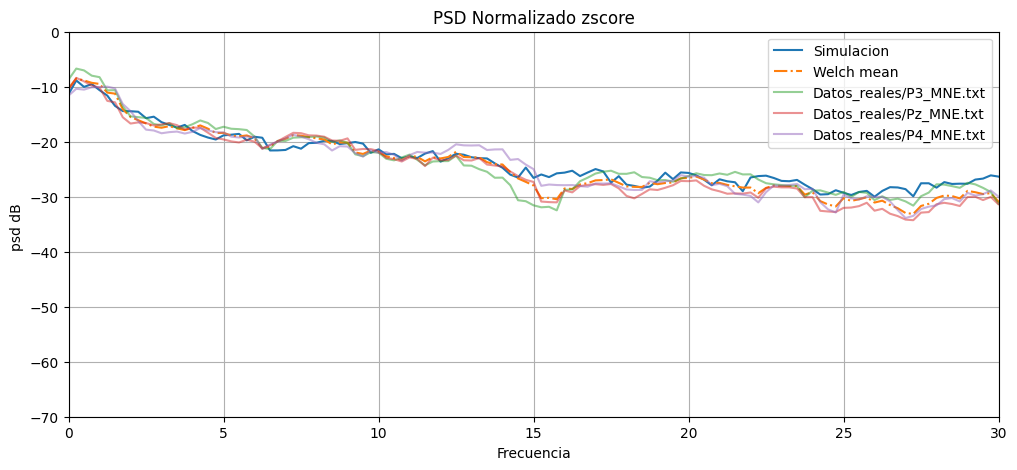

In [10]:
fig, ax = plt.subplots(figsize=[12, 5])
#print(generated_data["frequencies"])
frequencies = reales_total["frequencies"][0]
count_in_range = np.sum((frequencies >= 0) & (frequencies <= 60))
print(count_in_range)
print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["mean_welch"],label="Welch mean",linestyle="-.")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i],alpha=0.5)

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,30)
plt.ylim(-70,0)
plt.title(f"PSD Normalizado {Normalizacion}")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [15]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',10,20)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L10", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L10.db", 
                            load_if_exists=True,
                            direction="minimize",
                            #pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-11-16 12:58:03,979] Using an existing study with name 'Chi30_zscore_L10' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:07,147] Trial 2085 finished with value: 148.26794440136428 and parameters: {'L': 20, 'P': 0.029676109749468285, 'Inh': 0.5209100115682747, 'Trest': 0.2872244623677723, 'Trelative': 0.5414979013175591, 'C_h': 0.8479328471014149, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:09,212] Trial 2086 finished with value: 157.83218624381112 and parameters: {'L': 20, 'P': 0.020831073917075633, 'Inh': 0.5461908704468531, 'Trest': 0.30727407110142524, 'Trelative': 0.5242836790610479, 'C_h': 0.8794209763704821, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:58:10,955] Trial 2087 finished with value: 6448.9043072535305 and parameters: {'L': 20, 'P': 0.0030274646108552094, 'Inh': 0.4929940477078002, 'Trest': 0.001535512614890877, 'Trelative': 0.06201869320240688, 'C_h': 0.8629348476274306, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:11,821] Trial 2088 finished with value: 58.191577023135814 and parameters: {'L': 20, 'P': 0.00539378517853497, 'Inh': 0.5322453833832593, 'Trest': 0.3289799871514911, 'Trelative': 0.5546221535342224, 'C_h': 0.8375030362247247, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:12,748] Trial 2089 finished with value: 55.86016809458768 and parameters: {'L': 20, 'P': 0.0005478442748211177, 'Inh': 0.541614549875169, 'Trest': 0.33161228354234445, 'Trelative': 0.5471479769615515, 'C_h': 0.8392467004605542, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:13,724] Trial 2090 finished with value: 181.19529672722442 and parameters: {'L': 20, 'P': 0.006979574486894263, 'Inh': 0.5624976510774452, 'Trest': 0.018751499057081233, 'Trelative': 0.182092917794899, 'C_h': 0.8326698255195671, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:14,982] Trial 2091 finished with value: 70.95042087138785 and parameters: {'L': 20, 'P': 0.017487914532877763, 'Inh': 0.5364954554092334, 'Trest': 0.30879301175205043, 'Trelative': 0.5304800777011668, 'C_h': 0.8334672933020363, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:16,018] Trial 2092 finished with value: 141.00543753363968 and parameters: {'L': 20, 'P': 0.005376634770632792, 'Inh': 0.5597189619186803, 'Trest': 0.3164017706580794, 'Trelative': 0.5247928749761571, 'C_h': 0.8009743445723287, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:58:17,144] Trial 2093 finished with value: 4254.539555775061 and parameters: {'L': 20, 'P': 0.0018254403367893991, 'Inh': 0.5791876968893228, 'Trest': 0.0054270728164403925, 'Trelative': 0.019491623144449965, 'C_h': 0.8126785342687755, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:18,276] Trial 2094 finished with value: 78.10932210840072 and parameters: {'L': 20, 'P': 0.023292879131453215, 'Inh': 0.5412013667001135, 'Trest': 0.3012560251156111, 'Trelative': 0.5228199226625068, 'C_h': 0.8274673097337581, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:19,195] Trial 2095 finished with value: 81.23721065088512 and parameters: {'L': 20, 'P': 0.00022754811664715043, 'Inh': 0.5415679062978208, 'Trest': 0.3272830529975563, 'Trelative': 0.5483214455564814, 'C_h': 0.8048563403112106, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:20,075] Trial 2096 finished with value: 222.6089252316807 and parameters: {'L': 20, 'P': 0.01948769407141719, 'Inh': 0.5782999173102605, 'Trest': 0.31703840960539037, 'Trelative': 0.5457049461258625, 'C_h': 0.8177453620715491, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:20,878] Trial 2097 finished with value: 128.1399853647187 and parameters: {'L': 20, 'P': 0.02071408272999558, 'Inh': 0.5673912800778143, 'Trest': 0.1934893631776174, 'Trelative': 0.35128062971839114, 'C_h': 0.8260727018033133, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:21,679] Trial 2098 finished with value: 70.3345977917821 and parameters: {'L': 20, 'P': 0.004747296934118297, 'Inh': 0.5343564075577738, 'Trest': 0.29216613140402437, 'Trelative': 0.5198147945615667, 'C_h': 0.8086018673757663, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:22,530] Trial 2099 finished with value: 91.56023048388231 and parameters: {'L': 20, 'P': 0.001549695596670239, 'Inh': 0.5534798856063698, 'Trest': 0.3487172008066388, 'Trelative': 0.5816321603389075, 'C_h': 0.8377624743542533, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:23,449] Trial 2100 finished with value: 136.70470999519827 and parameters: {'L': 20, 'P': 0.03444732847952732, 'Inh': 0.5369497369982873, 'Trest': 0.3264725738844414, 'Trelative': 0.5818168682907643, 'C_h': 0.8404486078753111, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:24,548] Trial 2101 finished with value: 66.7942830429466 and parameters: {'L': 20, 'P': 0.0013122993977663431, 'Inh': 0.5324454832053273, 'Trest': 0.3515202087665046, 'Trelative': 0.5672763368186564, 'C_h': 0.8067387225713312, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:58:25,291] Trial 2102 finished with value: 8296.090493718162 and parameters: {'L': 20, 'P': 0.0036388824540545504, 'Inh': 0.5299340893349821, 'Trest': 0.007195706941189012, 'Trelative': 0.024496868132936223, 'C_h': 0.8529391336103707, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:26,263] Trial 2103 finished with value: 198.70276385458845 and parameters: {'L': 20, 'P': 0.022297636315245284, 'Inh': 0.559977489684749, 'Trest': 0.33403973987560526, 'Trelative': 0.5828976211304926, 'C_h': 0.7971070576627258, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:27,210] Trial 2104 finished with value: 154.53253298376052 and parameters: {'L': 20, 'P': 0.03934714847233222, 'Inh': 0.5378279235050456, 'Trest': 0.3104144794878838, 'Trelative': 0.5401848415825501, 'C_h': 0.7949270793070267, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:58:27,970] Trial 2105 finished with value: 8398.656373891386 and parameters: {'L': 20, 'P': 0.003558955359271778, 'Inh': 0.5278799759184065, 'Trest': 0.0013659905302225717, 'Trelative': 0.12276146674929383, 'C_h': 0.8142730332679464, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:28,869] Trial 2106 finished with value: 81.73182080831813 and parameters: {'L': 20, 'P': 0.034933418915300316, 'Inh': 0.5510601188401956, 'Trest': 0.3654412490560087, 'Trelative': 0.5979542713043166, 'C_h': 0.8204717384136554, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:29,762] Trial 2107 finished with value: 127.5112540700926 and parameters: {'L': 20, 'P': 0.0009584267662514964, 'Inh': 0.586805157939126, 'Trest': 0.35741034215910333, 'Trelative': 0.6027223088593098, 'C_h': 0.8271312483803066, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:30,689] Trial 2108 finished with value: 69.63500689541095 and parameters: {'L': 20, 'P': 0.02230680254516501, 'Inh': 0.5187221427553446, 'Trest': 0.19258565214032322, 'Trelative': 0.3655351647152118, 'C_h': 0.8097541234601802, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:31,587] Trial 2109 finished with value: 408.4651446136187 and parameters: {'L': 20, 'P': 0.02162409839000252, 'Inh': 0.5561092098335846, 'Trest': 0.16135912476435926, 'Trelative': 0.32226139510312485, 'C_h': 0.8125425350154074, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:32,583] Trial 2110 finished with value: 251.7480800171287 and parameters: {'L': 20, 'P': 0.02134074661283597, 'Inh': 0.5211537627892027, 'Trest': 0.0017026901165082386, 'Trelative': 0.1977491096805179, 'C_h': 0.8052809354195463, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:33,508] Trial 2111 finished with value: 148.90563419078035 and parameters: {'L': 20, 'P': 0.023917209150630326, 'Inh': 0.5368797567682089, 'Trest': 0.3656242689450293, 'Trelative': 0.5762956911961923, 'C_h': 0.7956767867007679, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:34,451] Trial 2112 finished with value: 113.85776837004504 and parameters: {'L': 20, 'P': 0.046250289847017234, 'Inh': 0.5636581662854309, 'Trest': 0.1706880284841309, 'Trelative': 0.3760591468611929, 'C_h': 0.8376141915755063, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:35,320] Trial 2113 finished with value: 130.06822025883864 and parameters: {'L': 20, 'P': 0.0425021605435533, 'Inh': 0.5200073915104042, 'Trest': 0.3231156892499111, 'Trelative': 0.5285591711201785, 'C_h': 0.8114103194009434, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:36,313] Trial 2114 finished with value: 159.4486396556871 and parameters: {'L': 20, 'P': 0.0010630056859361806, 'Inh': 0.5271064076594421, 'Trest': 0.37511118977240343, 'Trelative': 0.6307790453607, 'C_h': 0.793257954102752, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:37,137] Trial 2115 finished with value: 263.5127802456863 and parameters: {'L': 20, 'P': 0.019055198998158048, 'Inh': 0.570777917919768, 'Trest': 0.13740028513093783, 'Trelative': 0.2850762437294312, 'C_h': 0.8280471357567394, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:37,961] Trial 2116 finished with value: 96.67527293247122 and parameters: {'L': 20, 'P': 0.03850500099455974, 'Inh': 0.5171930150638611, 'Trest': 0.40524518692486194, 'Trelative': 0.6285264478767031, 'C_h': 0.8390376885665184, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:38,805] Trial 2117 finished with value: 77.86114879140344 and parameters: {'L': 20, 'P': 0.002076522976124151, 'Inh': 0.5111575436232191, 'Trest': 0.16991983497244184, 'Trelative': 0.3334569127657855, 'C_h': 0.8452897222951491, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:39,906] Trial 2118 finished with value: 228.781425056806 and parameters: {'L': 20, 'P': 0.0009442529175858472, 'Inh': 0.54259702389922, 'Trest': 0.3733784982742535, 'Trelative': 0.6097391560507512, 'C_h': 0.8092867640703107, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:40,887] Trial 2119 finished with value: 222.8899968740598 and parameters: {'L': 20, 'P': 0.021216277924878568, 'Inh': 0.5441694521858996, 'Trest': 0.17489406054742754, 'Trelative': 0.3356666435921105, 'C_h': 0.8149244887967744, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:58:41,719] Trial 2120 finished with value: 7776.755800118482 and parameters: {'L': 20, 'P': 0.049046951071953865, 'Inh': 0.5933749126293869, 'Trest': 0.0081175188971353, 'Trelative': 0.048296616551197075, 'C_h': 0.7792575151823377, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:42,609] Trial 2121 finished with value: 312.12831879700707 and parameters: {'L': 20, 'P': 0.03308388548410528, 'Inh': 0.5694158291713265, 'Trest': 0.3696245186466177, 'Trelative': 0.5843140614359336, 'C_h': 0.8450805122655172, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:43,502] Trial 2122 finished with value: 179.8676620850224 and parameters: {'L': 20, 'P': 0.020215386204253578, 'Inh': 0.5291146374157618, 'Trest': 0.37377853021122365, 'Trelative': 0.6146894921022421, 'C_h': 0.8468595442614512, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:58:44,374] Trial 2123 finished with value: 11043.714370237818 and parameters: {'L': 20, 'P': 0.022054413089328578, 'Inh': 0.5083782515159618, 'Trest': 0.0013113452078820087, 'Trelative': 0.023724407427247685, 'C_h': 0.8275237799828474, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:45,280] Trial 2124 finished with value: 63.54253673055181 and parameters: {'L': 20, 'P': 0.00010223183187101564, 'Inh': 0.5441361420913361, 'Trest': 0.20913624045470752, 'Trelative': 0.4129399672152349, 'C_h': 0.8595155667855511, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:46,093] Trial 2125 finished with value: 77.20981970970264 and parameters: {'L': 20, 'P': 0.0008732272037484633, 'Inh': 0.5539454732195465, 'Trest': 0.18739478160021825, 'Trelative': 0.4345058771732504, 'C_h': 0.859389996676409, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:46,996] Trial 2126 finished with value: 76.09067329572373 and parameters: {'L': 20, 'P': 0.05019743101449847, 'Inh': 0.5388431307335169, 'Trest': 0.3733617610780736, 'Trelative': 0.6129194164717118, 'C_h': 0.8372179033436975, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:47,926] Trial 2127 finished with value: 118.55793357579226 and parameters: {'L': 20, 'P': 0.022281752654035515, 'Inh': 0.5727219325050189, 'Trest': 0.18184777629102367, 'Trelative': 0.3558914418608087, 'C_h': 0.8559416179068723, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:58:48,711] Trial 2128 finished with value: 1913.8587328117162 and parameters: {'L': 20, 'P': 0.0016418509161519167, 'Inh': 0.5168398050720978, 'Trest': 0.003993944997943838, 'Trelative': 0.03965914265926429, 'C_h': 0.8177707324722918, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:49,764] Trial 2129 finished with value: 243.3640148017668 and parameters: {'L': 20, 'P': 0.03882406619691145, 'Inh': 0.5374159123195095, 'Trest': 0.40032451138513103, 'Trelative': 0.6503776695863713, 'C_h': 0.8537453733904997, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:50,637] Trial 2130 finished with value: 64.3302402887145 and parameters: {'L': 20, 'P': 0.0015624653463376615, 'Inh': 0.5601693533151907, 'Trest': 0.3971303187924995, 'Trelative': 0.6360441575303422, 'C_h': 0.7815414645165454, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:51,434] Trial 2131 finished with value: 101.23115792687585 and parameters: {'L': 20, 'P': 0.00036978607717198624, 'Inh': 0.576215608181819, 'Trest': 0.42019780224047565, 'Trelative': 0.6408610583956497, 'C_h': 0.8083077324521493, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:52,279] Trial 2132 finished with value: 178.85620617096276 and parameters: {'L': 20, 'P': 0.022810840371873795, 'Inh': 0.5915086329855919, 'Trest': 0.4359219524243079, 'Trelative': 0.6680395310703764, 'C_h': 0.788670656280759, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:53,021] Trial 2133 finished with value: 131.27609194473936 and parameters: {'L': 20, 'P': 0.00039832393821800406, 'Inh': 0.568428843397296, 'Trest': 0.3631152783693366, 'Trelative': 0.6012739618827648, 'C_h': 0.7805464175209383, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:53,857] Trial 2134 finished with value: 151.09273597478722 and parameters: {'L': 20, 'P': 0.04801453873271712, 'Inh': 0.5529056881735298, 'Trest': 0.43786014367418646, 'Trelative': 0.6663814040806286, 'C_h': 0.7944285918099367, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:54,681] Trial 2135 finished with value: 161.3003328658013 and parameters: {'L': 20, 'P': 0.03356272566627226, 'Inh': 0.5894768218882142, 'Trest': 0.4320716390488817, 'Trelative': 3.6065006895074663, 'C_h': 0.7699266764444724, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:55,638] Trial 2136 finished with value: 278.81982927097283 and parameters: {'L': 20, 'P': 0.02143534014873994, 'Inh': 0.5567113767293987, 'Trest': 0.4086282732784783, 'Trelative': 0.6812176888007244, 'C_h': 0.8053542743091031, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:56,707] Trial 2137 finished with value: 103.0527467925619 and parameters: {'L': 20, 'P': 0.053211263340722854, 'Inh': 0.5363557072612567, 'Trest': 0.18917387348844222, 'Trelative': 0.4080045752738285, 'C_h': 0.8285141446137549, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:57,630] Trial 2138 finished with value: 119.58240820420701 and parameters: {'L': 20, 'P': 0.026306601036157236, 'Inh': 0.5524079336218067, 'Trest': 0.38643974412507703, 'Trelative': 0.6080513319507361, 'C_h': 0.8053288745176274, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:58,585] Trial 2139 finished with value: 101.7051601381944 and parameters: {'L': 20, 'P': 0.043573966486065055, 'Inh': 0.5224112508092285, 'Trest': 0.1819889501478098, 'Trelative': 0.3411515947201573, 'C_h': 0.8269381524215303, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:59,516] Trial 2140 finished with value: 106.46969881714072 and parameters: {'L': 20, 'P': 0.0002992970523864073, 'Inh': 0.5338442797043998, 'Trest': 0.46425928568320307, 'Trelative': 0.7181523595977894, 'C_h': 0.8322442926209758, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:00,367] Trial 2141 finished with value: 268.02221742874906 and parameters: {'L': 20, 'P': 0.022415258871322598, 'Inh': 0.5656283136556236, 'Trest': 0.17563825024763033, 'Trelative': 0.3543769921602561, 'C_h': 0.7738474163994176, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:01,328] Trial 2142 finished with value: 158.92345092278268 and parameters: {'L': 20, 'P': 0.00028306755173675147, 'Inh': 0.592374171504602, 'Trest': 0.45659674236365344, 'Trelative': 0.7111150275924143, 'C_h': 0.8531085965552182, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:02,209] Trial 2143 finished with value: 59.640200761202635 and parameters: {'L': 20, 'P': 0.05445994174498842, 'Inh': 0.5038764331330655, 'Trest': 0.2031963167681211, 'Trelative': 0.40570199130422124, 'C_h': 0.8103571261153348, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:59:03,090] Trial 2144 finished with value: 8686.347593696051 and parameters: {'L': 20, 'P': 0.05023049962386803, 'Inh': 0.5092500370810287, 'Trest': 0.001845440701813028, 'Trelative': 0.14022962937580713, 'C_h': 0.8067552172277586, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:04,013] Trial 2145 finished with value: 195.340471505718 and parameters: {'L': 20, 'P': 0.03450791607341356, 'Inh': 0.525102327883865, 'Trest': 0.18389758240271825, 'Trelative': 0.3478799720191707, 'C_h': 0.8027090142175742, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:04,915] Trial 2146 finished with value: 199.83949537125844 and parameters: {'L': 20, 'P': 0.019462155270904818, 'Inh': 0.5437206288932249, 'Trest': 0.20389099438190872, 'Trelative': 0.4195389787185713, 'C_h': 0.7832074983603203, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:05,990] Trial 2147 finished with value: 69.7549164030457 and parameters: {'L': 20, 'P': 0.05556501829302128, 'Inh': 0.508103483238957, 'Trest': 0.18362639016503993, 'Trelative': 0.3561379805786087, 'C_h': 0.8275500576106275, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:06,897] Trial 2148 finished with value: 95.66092552549091 and parameters: {'L': 20, 'P': 0.05162776881177862, 'Inh': 0.506814530604051, 'Trest': 0.1553109289666399, 'Trelative': 0.33104284287662533, 'C_h': 0.826429336501523, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:07,681] Trial 2149 finished with value: 162.84592091737983 and parameters: {'L': 20, 'P': 0.06040923943376577, 'Inh': 0.5140394903508125, 'Trest': 0.1570878430240616, 'Trelative': 0.3058392243184106, 'C_h': 0.7943625726789669, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:08,505] Trial 2150 finished with value: 186.0286715910646 and parameters: {'L': 20, 'P': 0.03489038732937868, 'Inh': 0.5308178367539669, 'Trest': 0.1503710682013165, 'Trelative': 0.29767227172940247, 'C_h': 0.8158374111414413, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:09,428] Trial 2151 finished with value: 53.27289818116252 and parameters: {'L': 20, 'P': 0.055106537258710446, 'Inh': 0.5106894862774729, 'Trest': 0.16537178783412834, 'Trelative': 0.3183241313276925, 'C_h': 0.8380507973836525, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:10,261] Trial 2152 finished with value: 164.55600060612176 and parameters: {'L': 20, 'P': 0.05841441620168081, 'Inh': 0.5070399176917029, 'Trest': 0.1611781415577206, 'Trelative': 0.28683299389100864, 'C_h': 0.774067081804073, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:59:11,113] Trial 2153 finished with value: 2470.5605940376754 and parameters: {'L': 20, 'P': 0.05747672857549487, 'Inh': 0.5033311600582134, 'Trest': 0.013242213034529174, 'Trelative': 0.04137850073886579, 'C_h': 0.8400173485882918, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:12,035] Trial 2154 finished with value: 145.8620892973352 and parameters: {'L': 20, 'P': 0.04535831494298034, 'Inh': 0.5019197410463542, 'Trest': 0.16789055368926015, 'Trelative': 0.3602172135069454, 'C_h': 0.8138830249735306, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:13,053] Trial 2155 finished with value: 110.25032303915893 and parameters: {'L': 20, 'P': 0.03535134318643507, 'Inh': 0.5226755464654206, 'Trest': 0.13763409245218577, 'Trelative': 0.30879969741363744, 'C_h': 0.8493605933542148, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:14,253] Trial 2156 finished with value: 292.30774858566167 and parameters: {'L': 20, 'P': 0.02238052948142748, 'Inh': 0.49453898739031077, 'Trest': 0.19112911014473788, 'Trelative': 0.3495279500256802, 'C_h': 0.7929772250892972, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:15,146] Trial 2157 finished with value: 329.66274521391733 and parameters: {'L': 20, 'P': 0.055391166896050455, 'Inh': 0.5539630827442993, 'Trest': 0.16361848038710614, 'Trelative': 0.3305460122745375, 'C_h': 0.8213905621413803, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:16,100] Trial 2158 finished with value: 173.8716559771962 and parameters: {'L': 20, 'P': 0.018055870490333983, 'Inh': 0.5159421186590627, 'Trest': 0.019926782682909483, 'Trelative': 0.1929146233790769, 'C_h': 0.8609566004203218, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:17,005] Trial 2159 finished with value: 173.6514363403292 and parameters: {'L': 20, 'P': 0.03860565252703677, 'Inh': 0.5005562573636285, 'Trest': 0.31693996765941423, 'Trelative': 0.5276871260781668, 'C_h': 0.7513406858338332, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:17,871] Trial 2160 finished with value: 197.46244300915845 and parameters: {'L': 20, 'P': 0.05975275409284686, 'Inh': 0.5402290678538892, 'Trest': 0.03345227894370373, 'Trelative': 0.16606086807347847, 'C_h': 0.8371760798421642, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:18,705] Trial 2161 finished with value: 5062.172965174794 and parameters: {'L': 20, 'P': 0.019235018222038953, 'Inh': 0.5248735890774882, 'Trest': 0.015533832405372622, 'Trelative': 0.021193751680050416, 'C_h': 0.7975910268875946, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:19,677] Trial 2162 finished with value: 297.50243236042314 and parameters: {'L': 20, 'P': 0.032648673107339196, 'Inh': 0.5574641406266455, 'Trest': 0.25815253890205586, 'Trelative': 0.475390350515185, 'C_h': 0.8404586073999308, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:20,665] Trial 2163 finished with value: 95.11947189187832 and parameters: {'L': 20, 'P': 0.022144018400362238, 'Inh': 0.4952766715181142, 'Trest': 0.31341910675185625, 'Trelative': 0.5376168700447795, 'C_h': 0.8655886796399802, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:21,708] Trial 2164 finished with value: 165.47908261504924 and parameters: {'L': 20, 'P': 0.0015684094245455465, 'Inh': 0.5207596452119272, 'Trest': 0.1829073391794042, 'Trelative': 0.35062419929416544, 'C_h': 0.8211792220897141, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:22,823] Trial 2165 finished with value: 112.09392857404596 and parameters: {'L': 20, 'P': 0.05747378490589594, 'Inh': 0.5785907113315906, 'Trest': 0.3271401777213442, 'Trelative': 0.5569467041298855, 'C_h': 0.7790500211185792, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:23,666] Trial 2166 finished with value: 171.1190017450302 and parameters: {'L': 20, 'P': 5.238945205143786e-05, 'Inh': 0.5466283479636027, 'Trest': 0.01711835383086338, 'Trelative': 0.18633424995044334, 'C_h': 0.8569537171689762, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:24,501] Trial 2167 finished with value: 19511.358629103714 and parameters: {'L': 20, 'P': 0.040661448026626225, 'Inh': 0.5037092276684705, 'Trest': 0.022610170877145952, 'Trelative': 0.17409909538504842, 'C_h': 0.8143552378404146, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:25,440] Trial 2168 finished with value: 73.41600292995228 and parameters: {'L': 20, 'P': 0.0011321007014194681, 'Inh': 0.5275815828682695, 'Trest': 0.33199506179791416, 'Trelative': 0.5520919773863204, 'C_h': 0.8395075293282069, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:59:26,336] Trial 2169 finished with value: 2932.6661862680703 and parameters: {'L': 20, 'P': 0.021944011883445153, 'Inh': 0.5537281297405919, 'Trest': 8.246334818543064e-05, 'Trelative': 0.1736911068375605, 'C_h': 0.807383814766161, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:59:27,120] Trial 2170 finished with value: 2207.769675926591 and parameters: {'L': 20, 'P': 0.05906517681026716, 'Inh': 0.5693756109094738, 'Trest': 0.004720109344635431, 'Trelative': 0.04450031020126505, 'C_h': 0.864140802227493, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:59:27,861] Trial 2171 finished with value: 15134.166053764813 and parameters: {'L': 20, 'P': 0.036059637432931654, 'Inh': 0.4970339933860397, 'Trest': 0.009855772929250328, 'Trelative': 0.07405647682084593, 'C_h': 0.8400312650880354, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:28,706] Trial 2172 finished with value: 152.17859605186212 and parameters: {'L': 20, 'P': 0.02116733055602985, 'Inh': 0.5170607912825942, 'Trest': 0.3572392551055509, 'Trelative': 0.5880114850043389, 'C_h': 0.7874369131886788, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:29,738] Trial 2173 finished with value: 112.74466283184105 and parameters: {'L': 20, 'P': 0.04283301513318308, 'Inh': 0.5359682362459441, 'Trest': 0.3166159945506134, 'Trelative': 0.53866685059681, 'C_h': 0.862846354440157, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:30,611] Trial 2174 finished with value: 3390.389491867024 and parameters: {'L': 20, 'P': 0.06454670178257242, 'Inh': 0.49758850461148385, 'Trest': 0.008490390366185208, 'Trelative': 0.030707404417332607, 'C_h': 0.8382984978593067, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:31,588] Trial 2175 finished with value: 127.47415753487623 and parameters: {'L': 20, 'P': 1.3530188605953217e-05, 'Inh': 0.5394734936979372, 'Trest': 0.3287711898552646, 'Trelative': 0.5358519387009368, 'C_h': 0.8150032461743845, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:32,492] Trial 2176 finished with value: 162.68491635007857 and parameters: {'L': 20, 'P': 0.01887356437541237, 'Inh': 0.5977183391976707, 'Trest': 0.44000502518270834, 'Trelative': 0.6906408200623326, 'C_h': 0.8714156094668067, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:33,428] Trial 2177 finished with value: 139.26993009614907 and parameters: {'L': 20, 'P': 0.034918535733897485, 'Inh': 0.5148886297312406, 'Trest': 0.19870101832227666, 'Trelative': 0.42918580973395265, 'C_h': 0.8214490245751844, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:34,312] Trial 2178 finished with value: 150.1711443035277 and parameters: {'L': 20, 'P': 0.0007399302263356533, 'Inh': 0.5713613816368224, 'Trest': 0.006429342605683064, 'Trelative': 0.19472993511168268, 'C_h': 0.8549267819469545, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:35,258] Trial 2179 finished with value: 73.10166907180911 and parameters: {'L': 20, 'P': 0.059133092060251205, 'Inh': 0.4937258877737411, 'Trest': 0.43552597490417255, 'Trelative': 0.6455506803536121, 'C_h': 0.7977923361144319, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:36,094] Trial 2180 finished with value: 272.55529092535966 and parameters: {'L': 20, 'P': 0.040974932186268125, 'Inh': 0.5289197199186688, 'Trest': 0.18011975738345565, 'Trelative': 0.3519775781696653, 'C_h': 0.757270573870086, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:36,991] Trial 2181 finished with value: 176.41334516480475 and parameters: {'L': 20, 'P': 0.03171269098922828, 'Inh': 0.5520593659557829, 'Trest': 0.45755722356724854, 'Trelative': 0.6861506123108779, 'C_h': 0.8371145517378992, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:38,000] Trial 2182 finished with value: 137.81672479480545 and parameters: {'L': 20, 'P': 0.01833619412235821, 'Inh': 0.5149208874476132, 'Trest': 0.2858217297772156, 'Trelative': 0.49212679558488587, 'C_h': 0.8732192217308299, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:38,993] Trial 2183 finished with value: 97.34648778279707 and parameters: {'L': 20, 'P': 0.06266107097274476, 'Inh': 0.4937964216906846, 'Trest': 0.21906469718146895, 'Trelative': 3.92921695534626, 'C_h': 0.8251404735136062, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:39,957] Trial 2184 finished with value: 118.36183798046005 and parameters: {'L': 20, 'P': 0.020934631615792794, 'Inh': 0.535514966249414, 'Trest': 0.44159490297475623, 'Trelative': 0.6950869427521491, 'C_h': 0.8510281298817316, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:40,811] Trial 2185 finished with value: 3155.560039568047 and parameters: {'L': 20, 'P': 0.0013854626900016032, 'Inh': 0.5770309515776902, 'Trest': 0.0036374065524902854, 'Trelative': 0.052258302552257496, 'C_h': 0.8701773344008747, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:41,777] Trial 2186 finished with value: 371.71384981304317 and parameters: {'L': 20, 'P': 0.048823502100158005, 'Inh': 0.509081078160438, 'Trest': 0.18724352023591076, 'Trelative': 0.3597104028168282, 'C_h': 0.7698900139800128, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:42,649] Trial 2187 finished with value: 290.79006354136845 and parameters: {'L': 20, 'P': 0.019484410490067352, 'Inh': 0.5574479754489287, 'Trest': 0.4581667846444455, 'Trelative': 0.6756018921637741, 'C_h': 0.8456001339949164, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:43,566] Trial 2188 finished with value: 242.89683468002028 and parameters: {'L': 20, 'P': 0.00042172359888167227, 'Inh': 0.4912689447071162, 'Trest': 0.30855220930401855, 'Trelative': 3.1474618703349377, 'C_h': 0.8027618950849287, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:44,447] Trial 2189 finished with value: 232.8897341236021 and parameters: {'L': 20, 'P': 0.03949976407961653, 'Inh': 0.5305823922593231, 'Trest': 0.48229688630609424, 'Trelative': 0.6938759436291492, 'C_h': 0.8275885877398748, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:45,314] Trial 2190 finished with value: 141.09305280360917 and parameters: {'L': 20, 'P': 0.02034587989140176, 'Inh': 0.5434647199380165, 'Trest': 0.1835083506058589, 'Trelative': 0.4261956804974721, 'C_h': 0.8714288095993016, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:46,369] Trial 2191 finished with value: 151.86709328512782 and parameters: {'L': 20, 'P': 0.06524638169822813, 'Inh': 0.4942816096017879, 'Trest': 0.31089181398401305, 'Trelative': 0.5307917802966211, 'C_h': 0.7822383546188683, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:47,391] Trial 2192 finished with value: 191.85379319176644 and parameters: {'L': 20, 'P': 0.04023616584021899, 'Inh': 0.5127095586067818, 'Trest': 0.19901643718913395, 'Trelative': 2.371043234581268, 'C_h': 0.8419688720167593, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:48,290] Trial 2193 finished with value: 127.53584744896487 and parameters: {'L': 20, 'P': 0.02092748362049955, 'Inh': 0.5530608954736467, 'Trest': 0.5018002863444063, 'Trelative': 0.7567624080597882, 'C_h': 0.8139098936572969, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:49,226] Trial 2194 finished with value: 119.15709282540769 and parameters: {'L': 20, 'P': 0.06291003242250615, 'Inh': 0.5189243859274689, 'Trest': 0.17602105086967706, 'Trelative': 0.33225391008062644, 'C_h': 0.8629246593438534, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:59:50,009] Trial 2195 finished with value: 6015.344681470206 and parameters: {'L': 20, 'P': 0.018427355444939987, 'Inh': 0.5865419515728183, 'Trest': 0.003301317887575844, 'Trelative': 0.041352678793289854, 'C_h': 0.8544775888374181, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:50,887] Trial 2196 finished with value: 130.1917254641746 and parameters: {'L': 20, 'P': 0.04226749104812937, 'Inh': 0.4884977373319974, 'Trest': 0.5071531474150599, 'Trelative': 0.7643789925143321, 'C_h': 0.8764262376387926, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:51,862] Trial 2197 finished with value: 124.05472742715023 and parameters: {'L': 20, 'P': 0.018317032997711435, 'Inh': 0.5638726649231294, 'Trest': 0.3364360206118895, 'Trelative': 0.58617216515908, 'C_h': 0.8258533402200494, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:52,789] Trial 2198 finished with value: 130.10644848960692 and parameters: {'L': 20, 'P': 0.06520024006108675, 'Inh': 0.5289723864888362, 'Trest': 0.31661180122542687, 'Trelative': 0.5973128349220233, 'C_h': 0.7973848637277055, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:53,715] Trial 2199 finished with value: 112.20759397920678 and parameters: {'L': 20, 'P': 0.03832258190873447, 'Inh': 0.5085821755635033, 'Trest': 0.47367102129850924, 'Trelative': 0.7151525335476103, 'C_h': 0.8425602857197627, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:54,692] Trial 2200 finished with value: 52.09479022442885 and parameters: {'L': 20, 'P': 0.0012967270232138329, 'Inh': 0.48994112651730864, 'Trest': 0.17777589648341524, 'Trelative': 0.35486245687540635, 'C_h': 0.8135255468541975, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:55,681] Trial 2201 finished with value: 86.37627004309523 and parameters: {'L': 20, 'P': 0.018670003416191766, 'Inh': 0.48556591849440484, 'Trest': 0.18679347800748086, 'Trelative': 0.3543820675465033, 'C_h': 0.8716840731884126, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:56,929] Trial 2202 finished with value: 200.16709679118617 and parameters: {'L': 20, 'P': 0.04065055677686656, 'Inh': 0.4895966677992239, 'Trest': 0.17852297898504504, 'Trelative': 0.36601792276634226, 'C_h': 0.8327820397617691, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:59:57,846] Trial 2203 finished with value: 18807.232934273638 and parameters: {'L': 20, 'P': 0.016442890157059464, 'Inh': 0.4848931787180921, 'Trest': 0.006886737297430168, 'Trelative': 0.01714608011695923, 'C_h': 0.8546867264474084, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:58,930] Trial 2204 finished with value: 145.48884962880223 and parameters: {'L': 20, 'P': 0.05809280853038095, 'Inh': 0.5057661862886261, 'Trest': 0.21143445430664842, 'Trelative': 2.9156082446371445, 'C_h': 0.885691113392901, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:59,850] Trial 2205 finished with value: 98.67002087835424 and parameters: {'L': 20, 'P': 0.0018171810371366958, 'Inh': 0.4853555283592355, 'Trest': 0.007907014760623027, 'Trelative': 0.22813027924436813, 'C_h': 0.8205492859807201, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:00,772] Trial 2206 finished with value: 87.43951106056811 and parameters: {'L': 20, 'P': 0.0003047619167614382, 'Inh': 0.5074878223325713, 'Trest': 0.012890213566093767, 'Trelative': 0.1645006265133407, 'C_h': 0.85069307102424, 'Tipo_red': 2}. Best is trial 2022 with value: 40.059641807114794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:01,677] Trial 2207 finished with value: 39.79135693751224 and parameters: {'L': 20, 'P': 0.03684994637785851, 'Inh': 0.4905292320572928, 'Trest': 0.4672148273393474, 'Trelative': 0.6947701007044609, 'C_h': 0.8749276094006018, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:02,554] Trial 2208 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 9.765098185138352e-05, 'Inh': 0.4903420562845299, 'Trest': 0.512340938340132, 'Trelative': 0.7497309561078198, 'C_h': 0.8811531258253973, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:03,854] Trial 2209 finished with value: 101.33777074006319 and parameters: {'L': 20, 'P': 0.000769235435767935, 'Inh': 0.49505384769388744, 'Trest': 0.5168093914321104, 'Trelative': 0.7653242818792019, 'C_h': 0.8811341144938448, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:04,749] Trial 2210 finished with value: 149.9282795410313 and parameters: {'L': 20, 'P': 0.02161739038395188, 'Inh': 0.49165555403215083, 'Trest': 0.5655126949942971, 'Trelative': 0.7909340357704514, 'C_h': 0.8808203486864368, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:05,817] Trial 2211 finished with value: 45.84685361046105 and parameters: {'L': 20, 'P': 0.0020888403156342646, 'Inh': 0.47870592561578973, 'Trest': 0.5450165710655892, 'Trelative': 0.7572024964796293, 'C_h': 0.883105786626924, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:07,000] Trial 2212 finished with value: 55.9379100331729 and parameters: {'L': 20, 'P': 0.00012290264446613176, 'Inh': 0.4797635332624997, 'Trest': 0.5579292203251609, 'Trelative': 0.8137218871914682, 'C_h': 0.8737256586767373, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:07,917] Trial 2213 finished with value: 66.78280932401357 and parameters: {'L': 20, 'P': 0.002113903182479768, 'Inh': 0.4778410262502278, 'Trest': 0.5910557569045329, 'Trelative': 0.854447538587366, 'C_h': 0.8646576008470941, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:08,733] Trial 2214 finished with value: 53.95501375435968 and parameters: {'L': 20, 'P': 0.0024191518919023784, 'Inh': 0.48307076312339114, 'Trest': 0.5824834586953709, 'Trelative': 0.841099238400606, 'C_h': 0.885518622844965, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:09,541] Trial 2215 finished with value: 89.95996860607383 and parameters: {'L': 20, 'P': 0.018112072978625514, 'Inh': 0.4795317341600891, 'Trest': 0.6422355394062174, 'Trelative': 0.8636741037211497, 'C_h': 0.8875973722147712, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:10,486] Trial 2216 finished with value: 56.2799807470829 and parameters: {'L': 20, 'P': 0.001273783394742874, 'Inh': 0.4849618962569711, 'Trest': 0.5876087227749675, 'Trelative': 0.8358135074862161, 'C_h': 0.8837090239790583, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:11,377] Trial 2217 finished with value: 163.14366200180686 and parameters: {'L': 20, 'P': 0.034269545259972806, 'Inh': 0.4831953722332313, 'Trest': 0.5625880857600439, 'Trelative': 0.8205307759630547, 'C_h': 0.880647687472867, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:12,223] Trial 2218 finished with value: 88.267462062574 and parameters: {'L': 20, 'P': 0.019475849317547422, 'Inh': 0.4816090289357263, 'Trest': 0.5814669414094668, 'Trelative': 0.8275256608173991, 'C_h': 0.8812979485095517, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:13,149] Trial 2219 finished with value: 53.95501375435968 and parameters: {'L': 20, 'P': 0.0023553433922524772, 'Inh': 0.483332536603574, 'Trest': 0.5609822381533707, 'Trelative': 0.8506878870450755, 'C_h': 0.8876113581130383, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:14,112] Trial 2220 finished with value: 71.64761495475052 and parameters: {'L': 20, 'P': 0.0017255079353493026, 'Inh': 0.48808715368181504, 'Trest': 0.6067954236973984, 'Trelative': 0.8523638775309228, 'C_h': 0.8856342358381638, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:15,009] Trial 2221 finished with value: 49.942499739859784 and parameters: {'L': 20, 'P': 0.0004587914699144323, 'Inh': 0.4806772107163014, 'Trest': 0.5849231303161744, 'Trelative': 0.8330722605009029, 'C_h': 0.8794610421144692, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:15,938] Trial 2222 finished with value: 155.52828106575552 and parameters: {'L': 20, 'P': 0.035659620881861566, 'Inh': 0.48647409021573784, 'Trest': 0.6360305474449073, 'Trelative': 0.91100299751582, 'C_h': 0.8860962843848118, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:16,924] Trial 2223 finished with value: 135.42520195258393 and parameters: {'L': 20, 'P': 0.03230859271819435, 'Inh': 0.47784106011727806, 'Trest': 0.5910643103900066, 'Trelative': 0.8401258269140106, 'C_h': 0.8900670878552287, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:18,014] Trial 2224 finished with value: 113.27070901198681 and parameters: {'L': 20, 'P': 0.022436837084892865, 'Inh': 0.47715143760781853, 'Trest': 0.7248099429750339, 'Trelative': 0.9486130552169334, 'C_h': 0.8819415930953429, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:18,946] Trial 2225 finished with value: 74.53494433403347 and parameters: {'L': 20, 'P': 0.032617591459770355, 'Inh': 0.48193415406082196, 'Trest': 0.6801646859782389, 'Trelative': 0.9588889916543355, 'C_h': 0.8854413612887041, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:19,750] Trial 2226 finished with value: 94.50214788666017 and parameters: {'L': 20, 'P': 0.024651379801329663, 'Inh': 0.47827310778985543, 'Trest': 0.6660292104992724, 'Trelative': 0.9341113118420425, 'C_h': 0.8834459608372788, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:20,548] Trial 2227 finished with value: 69.15807247654872 and parameters: {'L': 20, 'P': 0.019564928339131885, 'Inh': 0.4822222291575543, 'Trest': 0.6125452853777364, 'Trelative': 0.8479579923381529, 'C_h': 0.8700863042962887, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:21,443] Trial 2228 finished with value: 108.09770037613353 and parameters: {'L': 20, 'P': 0.0006477814981241045, 'Inh': 0.4974301317246608, 'Trest': 0.5987487280568184, 'Trelative': 0.8424137615516399, 'C_h': 0.8929354351646698, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:22,360] Trial 2229 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0005587411863596139, 'Inh': 0.4824300470808115, 'Trest': 0.5917325582782555, 'Trelative': 0.8587916192118359, 'C_h': 0.8717976483320712, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:23,238] Trial 2230 finished with value: 115.87994226695069 and parameters: {'L': 20, 'P': 0.04480728397501177, 'Inh': 0.4999747421159815, 'Trest': 0.6088341947882128, 'Trelative': 0.883822040457489, 'C_h': 0.870206274977804, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:24,219] Trial 2231 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.00015543344805701961, 'Inh': 0.47496075879598837, 'Trest': 0.7106829527028401, 'Trelative': 0.9775941323533278, 'C_h': 0.8800780440337171, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:25,082] Trial 2232 finished with value: 134.361585431195 and parameters: {'L': 20, 'P': 0.0362378765885926, 'Inh': 0.49725782043457617, 'Trest': 0.5468401358186171, 'Trelative': 0.7913416155206183, 'C_h': 0.8893215887345872, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:26,073] Trial 2233 finished with value: 248.91404266016872 and parameters: {'L': 20, 'P': 0.02212849883004136, 'Inh': 0.475017013541479, 'Trest': 0.7441370574709684, 'Trelative': 1.00522027855053, 'C_h': 0.8919644231015116, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:26,923] Trial 2234 finished with value: 173.25108791985227 and parameters: {'L': 20, 'P': 0.019831961562832512, 'Inh': 0.49804604842449335, 'Trest': 0.6262818482144016, 'Trelative': 0.8676637968118588, 'C_h': 0.8663846723596593, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:27,780] Trial 2235 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.000569826154584881, 'Inh': 0.47437297341021734, 'Trest': 0.5755979944226566, 'Trelative': 0.8153865325199974, 'C_h': 0.8891719571054183, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:28,628] Trial 2236 finished with value: 84.40572389107042 and parameters: {'L': 20, 'P': 0.04611686212366618, 'Inh': 0.5004202048987213, 'Trest': 0.5263610675949928, 'Trelative': 0.8114067465118959, 'C_h': 0.8639881671107047, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:29,672] Trial 2237 finished with value: 70.39577462624736 and parameters: {'L': 20, 'P': 0.04286810437485361, 'Inh': 0.4767660553485016, 'Trest': 0.5328574781977286, 'Trelative': 0.7770533117628589, 'C_h': 0.8918186328977963, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:30,593] Trial 2238 finished with value: 135.50506420707052 and parameters: {'L': 20, 'P': 0.019881430008333447, 'Inh': 0.4995627058768382, 'Trest': 0.7538722458572515, 'Trelative': 1.0183718914493658, 'C_h': 0.8655903238396561, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:31,509] Trial 2239 finished with value: 85.64748959758441 and parameters: {'L': 20, 'P': 0.02024538576292985, 'Inh': 0.4764057375258962, 'Trest': 0.5310541937359794, 'Trelative': 0.7759609468344923, 'C_h': 0.8604053628544228, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:32,554] Trial 2240 finished with value: 184.25580152160578 and parameters: {'L': 20, 'P': 0.042711243202554906, 'Inh': 0.5044493771589209, 'Trest': 0.7574509495227071, 'Trelative': 1.0152465148342367, 'C_h': 0.8928755092750101, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:33,423] Trial 2241 finished with value: 68.31015829731453 and parameters: {'L': 20, 'P': 0.019134467276512926, 'Inh': 0.4881680558129662, 'Trest': 0.5160348758154809, 'Trelative': 0.7466022451093932, 'C_h': 0.8760723923485307, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:34,284] Trial 2242 finished with value: 71.14677768072038 and parameters: {'L': 20, 'P': 0.0010560275369128347, 'Inh': 0.5036279014248373, 'Trest': 0.5271565926198385, 'Trelative': 0.7703966065050365, 'C_h': 0.8535342081407159, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:35,309] Trial 2243 finished with value: 295.19734798102223 and parameters: {'L': 20, 'P': 0.06342639451727589, 'Inh': 0.4903114379634672, 'Trest': 0.8075453110756364, 'Trelative': 1.0137150642558008, 'C_h': 0.8657717335166651, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:36,167] Trial 2244 finished with value: 84.72624957819492 and parameters: {'L': 20, 'P': 0.0006096350502321143, 'Inh': 0.48031057129509325, 'Trest': 0.5076562489833802, 'Trelative': 0.7611168676731163, 'C_h': 0.8915402840280827, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:37,037] Trial 2245 finished with value: 147.15637574825834 and parameters: {'L': 20, 'P': 0.041196592549812505, 'Inh': 0.4719527010002755, 'Trest': 0.7570789395715115, 'Trelative': 1.0261150805015369, 'C_h': 0.8544887713206393, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:37,861] Trial 2246 finished with value: 84.71532219667216 and parameters: {'L': 20, 'P': 0.03459052285408694, 'Inh': 0.5054308323562248, 'Trest': 0.4914487926371756, 'Trelative': 0.7688407535395878, 'C_h': 0.8872803866351441, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:38,824] Trial 2247 finished with value: 73.04675042434933 and parameters: {'L': 20, 'P': 0.00027940181997466345, 'Inh': 0.4710712858530828, 'Trest': 0.7081260028520614, 'Trelative': 0.9239949885316335, 'C_h': 0.8917001538443934, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:39,780] Trial 2248 finished with value: 88.46643845588194 and parameters: {'L': 20, 'P': 0.023839610342415076, 'Inh': 0.514351280020655, 'Trest': 0.48818531338182464, 'Trelative': 0.7303842799750115, 'C_h': 0.8765982203035705, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:40,900] Trial 2249 finished with value: 88.95069786763361 and parameters: {'L': 20, 'P': 0.05486703676185859, 'Inh': 0.5079862786299046, 'Trest': 0.46555368558727095, 'Trelative': 0.7292842189657163, 'C_h': 0.8565950115878938, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:41,970] Trial 2250 finished with value: 81.49432064626055 and parameters: {'L': 20, 'P': 0.021005354578542457, 'Inh': 0.47111905019995015, 'Trest': 0.7122894689502706, 'Trelative': 0.9766009672536995, 'C_h': 0.8742326650384621, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:43,036] Trial 2251 finished with value: 88.08032447707149 and parameters: {'L': 20, 'P': 0.03955182941801458, 'Inh': 0.4926435608874035, 'Trest': 0.49617238341197095, 'Trelative': 0.733629471926051, 'C_h': 0.8491119395643687, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:43,930] Trial 2252 finished with value: 166.71170278413274 and parameters: {'L': 20, 'P': 0.017576769506288347, 'Inh': 0.471274795501023, 'Trest': 0.4320926824737131, 'Trelative': 0.6593254976649956, 'C_h': 0.8941571647697972, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:44,851] Trial 2253 finished with value: 229.01305593959165 and parameters: {'L': 20, 'P': 0.06827282775062894, 'Inh': 0.5092802361117612, 'Trest': 0.7279824635217853, 'Trelative': 0.9697596924927991, 'C_h': 0.8694229475853167, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:45,711] Trial 2254 finished with value: 53.95501375435968 and parameters: {'L': 20, 'P': 0.0010420244592921062, 'Inh': 0.482947260014756, 'Trest': 0.4878852796522227, 'Trelative': 0.7543480592316347, 'C_h': 0.8907517665703986, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:46,650] Trial 2255 finished with value: 323.90561929943544 and parameters: {'L': 20, 'P': 0.03472189718737601, 'Inh': 0.4701929035201311, 'Trest': 0.7889008635648669, 'Trelative': 1.0204544314477355, 'C_h': 0.8949411141201282, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:47,705] Trial 2256 finished with value: 323.0214973516753 and parameters: {'L': 20, 'P': 0.00040047687506789996, 'Inh': 0.48313494732043405, 'Trest': 0.8821264460981937, 'Trelative': 1.1284399709695618, 'C_h': 0.8938646532742568, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:48,905] Trial 2257 finished with value: 151.85764757292137 and parameters: {'L': 20, 'P': 0.020787422014441136, 'Inh': 0.4886028198533288, 'Trest': 0.8796421791143085, 'Trelative': 1.1160391331390689, 'C_h': 0.8937116244366825, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:50,013] Trial 2258 finished with value: 305.60744122870847 and parameters: {'L': 20, 'P': 0.0504567902323834, 'Inh': 0.4764238284227301, 'Trest': 0.6906480762344122, 'Trelative': 1.0039360011888208, 'C_h': 0.8469699621872443, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:50,945] Trial 2259 finished with value: 117.46520639475682 and parameters: {'L': 20, 'P': 0.033103390436228085, 'Inh': 0.49126776559206264, 'Trest': 0.6339730499138632, 'Trelative': 0.8671815095130846, 'C_h': 0.8763074927841177, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:51,975] Trial 2260 finished with value: 160.91799464662637 and parameters: {'L': 20, 'P': 0.00023031698778378288, 'Inh': 0.4651770430086103, 'Trest': 0.8770175131302167, 'Trelative': 1.1118524388425763, 'C_h': 0.8958988079813283, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:52,880] Trial 2261 finished with value: 115.46032331504517 and parameters: {'L': 20, 'P': 0.06734304079532177, 'Inh': 0.49972070783276434, 'Trest': 0.5932060128991937, 'Trelative': 0.8359708294695137, 'C_h': 0.8520690046537905, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:53,689] Trial 2262 finished with value: 170.61629235645563 and parameters: {'L': 20, 'P': 0.017540130459117995, 'Inh': 0.4768900834255096, 'Trest': 0.6051826684588957, 'Trelative': 0.8619465955828006, 'C_h': 0.8680077456734386, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:54,660] Trial 2263 finished with value: 123.71766140165099 and parameters: {'L': 20, 'P': 0.04528707105922929, 'Inh': 0.4669177217352335, 'Trest': 0.49625923272636335, 'Trelative': 0.7373864669741166, 'C_h': 0.8910056288933046, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:55,690] Trial 2264 finished with value: 325.83361884580154 and parameters: {'L': 20, 'P': 0.0004350315386270738, 'Inh': 0.5011385359540351, 'Trest': 0.7524212873850804, 'Trelative': 1.0166287381377674, 'C_h': 0.8730494148212488, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:56,641] Trial 2265 finished with value: 97.40194916520912 and parameters: {'L': 20, 'P': 0.02128054458023, 'Inh': 0.5111463637601509, 'Trest': 0.4520017469699402, 'Trelative': 0.680567510787261, 'C_h': 0.8459561251881611, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:57,616] Trial 2266 finished with value: 120.67206362033714 and parameters: {'L': 20, 'P': 0.05263236376837728, 'Inh': 0.46617319729474416, 'Trest': 0.849953015746345, 'Trelative': 1.1130769661207525, 'C_h': 0.8538149758934317, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:58,678] Trial 2267 finished with value: 129.8076647811192 and parameters: {'L': 20, 'P': 0.03207712370143899, 'Inh': 0.49098267429560605, 'Trest': 0.6250469670548258, 'Trelative': 0.871852005186539, 'C_h': 0.8960239209951594, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:59,560] Trial 2268 finished with value: 137.81672479480545 and parameters: {'L': 20, 'P': 0.018765131167581457, 'Inh': 0.5150115776197384, 'Trest': 0.4423388132490289, 'Trelative': 0.6939148869931873, 'C_h': 0.8767291861200917, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:00,434] Trial 2269 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 9.931794093809287e-07, 'Inh': 0.48975997909484614, 'Trest': 0.6801613889698257, 'Trelative': 0.9327386113212417, 'C_h': 0.8946990931111737, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:01,341] Trial 2270 finished with value: 134.17569464979556 and parameters: {'L': 20, 'P': 0.01734237727293289, 'Inh': 0.4849257162498809, 'Trest': 0.9127619889144147, 'Trelative': 1.1712021208216554, 'C_h': 0.8896651782106503, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:02,187] Trial 2271 finished with value: 92.372845934091 and parameters: {'L': 20, 'P': 0.01802481738725732, 'Inh': 0.49302251704932387, 'Trest': 0.5365036481713207, 'Trelative': 0.7730757661993531, 'C_h': 0.8717314757626471, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:03,123] Trial 2272 finished with value: 86.3718455785424 and parameters: {'L': 20, 'P': 0.000330308821273438, 'Inh': 0.46996952028348055, 'Trest': 0.4156466845787714, 'Trelative': 0.6614260564506912, 'C_h': 0.8601868901330836, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:04,267] Trial 2273 finished with value: 128.13835301318315 and parameters: {'L': 20, 'P': 0.03416233346467736, 'Inh': 0.5119799355552597, 'Trest': 0.7309736092391396, 'Trelative': 1.0061307099284593, 'C_h': 0.8954709732008395, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:05,517] Trial 2274 finished with value: 46.480946572847806 and parameters: {'L': 20, 'P': 0.0012127627507898808, 'Inh': 0.4697341005009452, 'Trest': 0.4447017165007805, 'Trelative': 0.6970199811643499, 'C_h': 0.8993421351586421, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:06,485] Trial 2275 finished with value: 407.337593236225 and parameters: {'L': 20, 'P': 3.174772009086703e-05, 'Inh': 0.46549609792884694, 'Trest': 0.833369178651481, 'Trelative': 1.0684129812270478, 'C_h': 0.875097597369415, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:07,379] Trial 2276 finished with value: 323.0214973516753 and parameters: {'L': 20, 'P': 0.0005794821214036849, 'Inh': 0.48410536482565664, 'Trest': 0.9893760060567711, 'Trelative': 1.2425693262732116, 'C_h': 0.8541274222249408, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:08,282] Trial 2277 finished with value: 72.37076397931766 and parameters: {'L': 20, 'P': 0.02223263067388594, 'Inh': 0.46499561159524866, 'Trest': 0.6551558937336104, 'Trelative': 0.9164024970156417, 'C_h': 0.897354250206159, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:09,207] Trial 2278 finished with value: 262.5987612944789 and parameters: {'L': 20, 'P': 0.035482039849613074, 'Inh': 0.49280684816649245, 'Trest': 0.7995429775171785, 'Trelative': 1.089383485853975, 'C_h': 0.8473642532978081, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:10,137] Trial 2279 finished with value: 178.03769456996054 and parameters: {'L': 20, 'P': 0.0007111157139281014, 'Inh': 0.5098314510592002, 'Trest': 0.7509176399167365, 'Trelative': 1.0118331687039286, 'C_h': 0.8805268833879785, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:11,078] Trial 2280 finished with value: 226.5484315974706 and parameters: {'L': 20, 'P': 0.04742763465540033, 'Inh': 0.47199721472096845, 'Trest': 0.9912779378498878, 'Trelative': 1.280058935395839, 'C_h': 0.866050020376229, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:12,037] Trial 2281 finished with value: 70.06938699702643 and parameters: {'L': 20, 'P': 0.01885413771729795, 'Inh': 0.4907817628895433, 'Trest': 0.6158535385045418, 'Trelative': 0.8816363930832926, 'C_h': 0.8944227882768414, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:12,932] Trial 2282 finished with value: 55.4675162306512 and parameters: {'L': 20, 'P': 0.00027457087446430134, 'Inh': 0.5134293049554686, 'Trest': 0.5896327011511063, 'Trelative': 0.847725922588503, 'C_h': 0.8423548347929544, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:14,040] Trial 2283 finished with value: 369.96136861451805 and parameters: {'L': 20, 'P': 0.026278334078806975, 'Inh': 0.46428017279317824, 'Trest': 0.9338519885656504, 'Trelative': 1.1940502851670929, 'C_h': 0.844391290794104, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_4717/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:01:15,089] Trial 2284 finished with value: inf and parameters: {'L': 20, 'P': 0.01497092474789829, 'Inh': 0.5177624419333663, 'Trest': 1.0511525031710773, 'Trelative': 1.3352501708260718, 'C_h': 0.8686915890265062, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:01:16,164] Trial 2285 finished with value: inf and parameters: {'L': 20, 'P': 0.014374800220512834, 'Inh': 0.48561558714784914, 'Trest': 1.1322952006452796, 'Trelative': 1.3837590823737012, 'C_h': 0.895448682198264, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:17,481] Trial 2286 finished with value: 126.56601795616427 and parameters: {'L': 20, 'P': 0.00011153593748610205, 'Inh': 0.5137854126570434, 'Trest': 0.859409009238195, 'Trelative': 1.1371458335118303, 'C_h': 0.8445897552062901, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:18,523] Trial 2287 finished with value: 605.3716377548218 and parameters: {'L': 20, 'P': 0.00020593969658719633, 'Inh': 0.4633956729890806, 'Trest': 0.8949081454555932, 'Trelative': 1.1490662328756271, 'C_h': 0.8699068794417744, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:19,520] Trial 2288 finished with value: 95.17955326903353 and parameters: {'L': 20, 'P': 0.022587160853972648, 'Inh': 0.4889757944592487, 'Trest': 0.7274745298742427, 'Trelative': 0.9901568544607724, 'C_h': 0.8796087251515298, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:01:20,687] Trial 2289 finished with value: inf and parameters: {'L': 20, 'P': 0.03554859680650004, 'Inh': 0.5081850902858324, 'Trest': 1.0732747781377792, 'Trelative': 1.347537677573226, 'C_h': 0.8509350679277989, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:21,671] Trial 2290 finished with value: 93.90426991181522 and parameters: {'L': 20, 'P': 0.020359468846047897, 'Inh': 0.47081136331727763, 'Trest': 0.7107135520687349, 'Trelative': 0.9780123979620757, 'C_h': 0.8918537918291747, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:22,616] Trial 2291 finished with value: 143.37589462463558 and parameters: {'L': 20, 'P': 0.01785173852443881, 'Inh': 0.5189655610392141, 'Trest': 0.6747232229648563, 'Trelative': 0.9313048032893414, 'C_h': 0.856493117484923, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:23,539] Trial 2292 finished with value: 234.7591534518096 and parameters: {'L': 20, 'P': 1.9249504306460136e-05, 'Inh': 0.489842527309378, 'Trest': 0.8879579287122965, 'Trelative': 1.136632786979001, 'C_h': 0.8974584982912439, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:24,440] Trial 2293 finished with value: 55.69277075956273 and parameters: {'L': 20, 'P': 0.0006659962760610836, 'Inh': 0.46825483373257853, 'Trest': 0.6089444427722137, 'Trelative': 0.9114472493317808, 'C_h': 0.8767153008071764, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:25,253] Trial 2294 finished with value: 99.14909986464424 and parameters: {'L': 20, 'P': 0.019433865044909997, 'Inh': 0.46537089073377974, 'Trest': 0.5790165292590078, 'Trelative': 0.8192534677900231, 'C_h': 0.8739496560354373, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:26,108] Trial 2295 finished with value: 95.83399383784524 and parameters: {'L': 20, 'P': 0.0310285341656194, 'Inh': 0.4869304896359796, 'Trest': 0.7302477589071026, 'Trelative': 0.9924317424375839, 'C_h': 0.8798896561727988, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:27,019] Trial 2296 finished with value: 106.56176705769867 and parameters: {'L': 20, 'P': 0.0006769701755407684, 'Inh': 0.47052678887067834, 'Trest': 0.5623541841313817, 'Trelative': 0.8397648387920085, 'C_h': 0.8455495065513495, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:27,992] Trial 2297 finished with value: 85.28330794717853 and parameters: {'L': 20, 'P': 0.03803055889193893, 'Inh': 0.4920333279194933, 'Trest': 0.8123188217029516, 'Trelative': 1.0781896176600574, 'C_h': 0.8702920150251081, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:28,956] Trial 2298 finished with value: 88.45844598892441 and parameters: {'L': 20, 'P': 0.00029440985321175454, 'Inh': 0.5049593691966687, 'Trest': 0.5310407039292524, 'Trelative': 0.768327544829962, 'C_h': 0.8395894350183201, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:29,976] Trial 2299 finished with value: 111.20084419161218 and parameters: {'L': 20, 'P': 0.019365842130011024, 'Inh': 0.46645328759536664, 'Trest': 0.550784134764018, 'Trelative': 0.9227494689091245, 'C_h': 0.8976917437647967, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:31,051] Trial 2300 finished with value: 89.5387550827581 and parameters: {'L': 20, 'P': 0.00020722837290258387, 'Inh': 0.5187111935823024, 'Trest': 0.9838038079596498, 'Trelative': 1.2243670642024604, 'C_h': 0.8607411507269602, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:32,186] Trial 2301 finished with value: 198.20575801223123 and parameters: {'L': 20, 'P': 0.0378065762037806, 'Inh': 0.478710858086237, 'Trest': 0.7763041291421253, 'Trelative': 1.0399411723325536, 'C_h': 0.878291027597756, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:33,082] Trial 2302 finished with value: 51.949989078878254 and parameters: {'L': 20, 'P': 0.0004167755114743058, 'Inh': 0.4987853162675156, 'Trest': 0.46225998419215053, 'Trelative': 0.7314915417880217, 'C_h': 0.8982875648913997, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:01:34,187] Trial 2303 finished with value: inf and parameters: {'L': 20, 'P': 8.007001871747485e-05, 'Inh': 0.4659883601623222, 'Trest': 1.0059652669709536, 'Trelative': 1.2548152015314018, 'C_h': 0.899468611386044, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:35,297] Trial 2304 finished with value: 234.7591534518096 and parameters: {'L': 20, 'P': 2.2094101643692875e-05, 'Inh': 0.49151708012146134, 'Trest': 0.8394843779451866, 'Trelative': 1.119425453169098, 'C_h': 0.8927639961698531, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:36,544] Trial 2305 finished with value: 146.9109908322399 and parameters: {'L': 20, 'P': 0.035170785567450395, 'Inh': 0.497950432641386, 'Trest': 0.7023544718801923, 'Trelative': 1.008878535621723, 'C_h': 0.8983129104970561, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:37,558] Trial 2306 finished with value: 133.37576238379827 and parameters: {'L': 20, 'P': 0.01880831120672174, 'Inh': 0.464798931578444, 'Trest': 0.9011320994339933, 'Trelative': 1.1839596537343353, 'C_h': 0.8955817660526946, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:38,475] Trial 2307 finished with value: 110.49540199862072 and parameters: {'L': 20, 'P': 0.018523908920039783, 'Inh': 0.47932560985201594, 'Trest': 0.6460685124696551, 'Trelative': 0.9110755689735358, 'C_h': 0.8774442139523513, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:01:39,509] Trial 2308 finished with value: inf and parameters: {'L': 20, 'P': 0.04501509438684813, 'Inh': 0.4640855683964225, 'Trest': 1.28915214099186, 'Trelative': 1.5468755904257616, 'C_h': 0.9000202711975529, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:01:40,729] Trial 2309 finished with value: inf and parameters: {'L': 20, 'P': 0.018506310707419017, 'Inh': 0.4969566679544546, 'Trest': 1.125161898311468, 'Trelative': 1.46703355657028, 'C_h': 0.8798845456515944, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:41,658] Trial 2310 finished with value: 118.96163836398262 and parameters: {'L': 20, 'P': 0.0005576359084521476, 'Inh': 0.48181813323605127, 'Trest': 0.5638685527022411, 'Trelative': 0.8097827409755423, 'C_h': 0.8651593790435895, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:42,679] Trial 2311 finished with value: 191.02040035687457 and parameters: {'L': 20, 'P': 0.03591069154290651, 'Inh': 0.5208268213563375, 'Trest': 0.7555159713981716, 'Trelative': 1.0292628820863394, 'C_h': 0.8976453487324785, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:43,632] Trial 2312 finished with value: 181.54008416221762 and parameters: {'L': 20, 'P': 0.021214002664169198, 'Inh': 0.49745177829554943, 'Trest': 0.5760512862892464, 'Trelative': 0.81700127523621, 'C_h': 0.8806709331716479, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:01:44,529] Trial 2313 finished with value: inf and parameters: {'L': 20, 'P': 0.051514006101396254, 'Inh': 0.46229607203649936, 'Trest': 1.008284809085481, 'Trelative': 1.293138700333302, 'C_h': 0.8987291573589555, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:45,491] Trial 2314 finished with value: 52.59039428585571 and parameters: {'L': 20, 'P': 6.341346628432843e-05, 'Inh': 0.5051028815290526, 'Trest': 0.473967783589573, 'Trelative': 0.7186991126907741, 'C_h': 0.8549115393709924, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:46,436] Trial 2315 finished with value: 188.11890944370583 and parameters: {'L': 20, 'P': 0.01785103369629826, 'Inh': 0.5213540698817164, 'Trest': 0.9380849266934446, 'Trelative': 1.1875552201874662, 'C_h': 0.8411153822845855, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:47,414] Trial 2316 finished with value: 103.01037152256946 and parameters: {'L': 20, 'P': 0.03348073432329187, 'Inh': 0.5055601822214415, 'Trest': 0.7763526081331728, 'Trelative': 1.044548412778349, 'C_h': 0.8373778487108445, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:48,325] Trial 2317 finished with value: 116.03659497735973 and parameters: {'L': 20, 'P': 0.01753419279215291, 'Inh': 0.5020412036966736, 'Trest': 0.7506234293407468, 'Trelative': 1.014110359150541, 'C_h': 0.8602526083296915, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:49,318] Trial 2318 finished with value: 117.49477687656933 and parameters: {'L': 20, 'P': 0.03346131459193798, 'Inh': 0.5218848660182879, 'Trest': 0.615240693276762, 'Trelative': 0.8705506951812041, 'C_h': 0.8357377450119873, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:01:50,463] Trial 2319 finished with value: inf and parameters: {'L': 20, 'P': 0.01653950566116946, 'Inh': 0.48370957297247213, 'Trest': 1.0834628206294625, 'Trelative': 1.3468855231718777, 'C_h': 0.8591315188986475, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:51,340] Trial 2320 finished with value: 203.55657720424486 and parameters: {'L': 20, 'P': 0.04828715925223575, 'Inh': 0.4865585879766839, 'Trest': 0.8255003145054783, 'Trelative': 1.1423259297229327, 'C_h': 0.8690453971174135, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:52,237] Trial 2321 finished with value: 73.56703843119958 and parameters: {'L': 20, 'P': 0.0015967089804856454, 'Inh': 0.5240599981053572, 'Trest': 0.4940558294413511, 'Trelative': 0.7140888366704049, 'C_h': 0.8456782189888685, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:53,200] Trial 2322 finished with value: 68.63309182934384 and parameters: {'L': 20, 'P': 0.0001296966293826943, 'Inh': 0.5031252809363539, 'Trest': 0.6200507391467445, 'Trelative': 0.8724087075625078, 'C_h': 0.8757718148529992, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:54,084] Trial 2323 finished with value: 69.1313663195728 and parameters: {'L': 20, 'P': 0.03275174249124859, 'Inh': 0.4613610980090712, 'Trest': 0.5125749070202709, 'Trelative': 0.7474526984928798, 'C_h': 0.8373304760522884, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:55,133] Trial 2324 finished with value: 158.5546077542775 and parameters: {'L': 20, 'P': 0.018600287579387528, 'Inh': 0.4760341150045346, 'Trest': 0.8210764973663536, 'Trelative': 1.0938037396629934, 'C_h': 0.8558640304746633, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:01:56,204] Trial 2325 finished with value: inf and parameters: {'L': 20, 'P': 0.04719066919835192, 'Inh': 0.5042526573413149, 'Trest': 1.195513441078977, 'Trelative': 1.4229497592376603, 'C_h': 0.8811802003779635, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:57,250] Trial 2326 finished with value: 65.45091024311907 and parameters: {'L': 20, 'P': 0.0006573779156256904, 'Inh': 0.4857366225439348, 'Trest': 0.5104547971091122, 'Trelative': 0.7640581915109202, 'C_h': 0.899921992438818, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:58,121] Trial 2327 finished with value: 176.2820473598443 and parameters: {'L': 20, 'P': 0.017475115639570347, 'Inh': 0.5261080763544129, 'Trest': 0.7085438373392, 'Trelative': 0.9560555623854132, 'C_h': 0.8564948615760579, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:59,112] Trial 2328 finished with value: 169.68989783512734 and parameters: {'L': 20, 'P': 0.03544414261776084, 'Inh': 0.47021484539299063, 'Trest': 0.9610975571700069, 'Trelative': 1.2242214238668558, 'C_h': 0.8793612775150288, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:59,916] Trial 2329 finished with value: 76.74736385420732 and parameters: {'L': 20, 'P': 0.022214552535069678, 'Inh': 0.5096792992950416, 'Trest': 0.4419017563554259, 'Trelative': 0.6776865278071021, 'C_h': 0.8372087038903163, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:00,847] Trial 2330 finished with value: 75.12132116694242 and parameters: {'L': 20, 'P': 0.0013353816624875005, 'Inh': 0.4639980492360714, 'Trest': 0.6829663333465842, 'Trelative': 0.9549284299574472, 'C_h': 0.8607097846682462, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:01,692] Trial 2331 finished with value: 147.3917975342095 and parameters: {'L': 20, 'P': 0.05405150939850363, 'Inh': 0.48862596258238, 'Trest': 0.48100820703452285, 'Trelative': 0.7406063766126645, 'C_h': 0.9005845247968283, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:02,543] Trial 2332 finished with value: 260.3973250824885 and parameters: {'L': 20, 'P': 0.019605349478498787, 'Inh': 0.5239013092171526, 'Trest': 0.8678106063762289, 'Trelative': 1.1210472983037614, 'C_h': 0.882129701946763, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:03,491] Trial 2333 finished with value: 48.25675414430497 and parameters: {'L': 20, 'P': 0.0008442825091786106, 'Inh': 0.46166503231199674, 'Trest': 0.4762271162037226, 'Trelative': 0.7169524277187439, 'C_h': 0.8630888850023549, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:05,027] Trial 2334 finished with value: inf and parameters: {'L': 20, 'P': 0.00036498201319074344, 'Inh': 0.45904857655317405, 'Trest': 1.3937249395922398, 'Trelative': 1.6291718756905715, 'C_h': 0.8800335134680265, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:06,073] Trial 2335 finished with value: inf and parameters: {'L': 20, 'P': 0.00012327043801387195, 'Inh': 0.4623611103286803, 'Trest': 1.073066884994699, 'Trelative': 1.3477324002802333, 'C_h': 0.8644909137495048, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:07,089] Trial 2336 finished with value: 114.46761671994248 and parameters: {'L': 20, 'P': 0.037873885977052484, 'Inh': 0.4625522942776257, 'Trest': 0.8533429667866286, 'Trelative': 1.1358837243400133, 'C_h': 0.8995415499854043, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:07,905] Trial 2337 finished with value: 71.27166917620333 and parameters: {'L': 20, 'P': 0.0352540930555696, 'Inh': 0.47990780679289663, 'Trest': 0.7111734285965478, 'Trelative': 0.9785003551688047, 'C_h': 0.8805437917156403, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:08,789] Trial 2338 finished with value: 87.89500370343087 and parameters: {'L': 20, 'P': 0.018903805076816847, 'Inh': 0.45903392513245583, 'Trest': 0.6168491553785238, 'Trelative': 0.8859400929463429, 'C_h': 0.9013511321495202, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:09,741] Trial 2339 finished with value: 107.46264425297879 and parameters: {'L': 20, 'P': 0.05887940281022418, 'Inh': 0.48147173845759317, 'Trest': 0.9222743345504296, 'Trelative': 1.1462451610933897, 'C_h': 0.863707261484755, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:10,557] Trial 2340 finished with value: 92.77533833232904 and parameters: {'L': 20, 'P': 0.020684135566697723, 'Inh': 0.4600720500906178, 'Trest': 0.6615011215024753, 'Trelative': 0.8877142339665833, 'C_h': 0.9008990799779385, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:11,465] Trial 2341 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0004071229241596658, 'Inh': 0.4838930797259934, 'Trest': 0.49882577022105434, 'Trelative': 0.7492004853336345, 'C_h': 0.8569090459333768, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:12,692] Trial 2342 finished with value: inf and parameters: {'L': 20, 'P': 0.03637549335301099, 'Inh': 0.4979426115678986, 'Trest': 1.0286497337662732, 'Trelative': 1.3312327039599443, 'C_h': 0.8832037512114623, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:13,876] Trial 2343 finished with value: 220.658503168678 and parameters: {'L': 20, 'P': 0.06019784150704325, 'Inh': 0.48001663025698144, 'Trest': 0.5134653433609832, 'Trelative': 0.7616094199673985, 'C_h': 0.856094538665207, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:14,839] Trial 2344 finished with value: 172.7501576951289 and parameters: {'L': 20, 'P': 0.022910632978103463, 'Inh': 0.4564449981620562, 'Trest': 0.7492359892371464, 'Trelative': 1.0261134245112815, 'C_h': 0.8820460917387248, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:15,685] Trial 2345 finished with value: 57.39788733819746 and parameters: {'L': 20, 'P': 0.0002767657321535034, 'Inh': 0.5027507832160554, 'Trest': 0.4680302640631369, 'Trelative': 0.7327876185710815, 'C_h': 0.9034987428829759, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:16,620] Trial 2346 finished with value: 191.55904935036384 and parameters: {'L': 20, 'P': 0.03423919633325361, 'Inh': 0.47754271887856403, 'Trest': 0.789720971056463, 'Trelative': 1.0568140620330975, 'C_h': 0.8338446306151107, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:17,511] Trial 2347 finished with value: 57.687646951859755 and parameters: {'L': 20, 'P': 0.019836443896284802, 'Inh': 0.4962783860072207, 'Trest': 0.48412529610238847, 'Trelative': 0.7114529060844763, 'C_h': 0.867067920462826, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:18,298] Trial 2348 finished with value: 95.9869546937372 and parameters: {'L': 20, 'P': 0.05021686253772336, 'Inh': 0.4592389096246249, 'Trest': 0.6208644954569476, 'Trelative': 0.8778265346321545, 'C_h': 0.8822520308863363, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:19,365] Trial 2349 finished with value: inf and parameters: {'L': 20, 'P': 0.01968466761270141, 'Inh': 0.4974112985820238, 'Trest': 1.1532031782190006, 'Trelative': 1.439482201963307, 'C_h': 0.8433146306235632, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:20,372] Trial 2350 finished with value: 136.34553404223607 and parameters: {'L': 20, 'P': 0.036438778287371694, 'Inh': 0.46144446269522926, 'Trest': 0.8950967735680555, 'Trelative': 1.1879279307420147, 'C_h': 0.8955206773164318, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:21,362] Trial 2351 finished with value: 84.72624957819492 and parameters: {'L': 20, 'P': 0.0006196252219221801, 'Inh': 0.4805031127426102, 'Trest': 0.43796833613928754, 'Trelative': 0.641793734900394, 'C_h': 0.8629141224825317, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:22,548] Trial 2352 finished with value: 185.28901669403794 and parameters: {'L': 20, 'P': 0.06553433938360138, 'Inh': 0.5007153430936079, 'Trest': 0.7036030469155121, 'Trelative': 0.9841636040614122, 'C_h': 0.8991955868359011, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:23,700] Trial 2353 finished with value: 54.43488029880715 and parameters: {'L': 20, 'P': 0.021258727307489646, 'Inh': 0.48017304690543366, 'Trest': 0.4581466366704226, 'Trelative': 0.680898659369048, 'C_h': 0.8509360331204473, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:24,850] Trial 2354 finished with value: inf and parameters: {'L': 20, 'P': 0.046344241301612236, 'Inh': 0.46228709345444036, 'Trest': 1.0612985899531346, 'Trelative': 1.3561191523111078, 'C_h': 0.8372473460408378, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:25,845] Trial 2355 finished with value: 163.1982103076295 and parameters: {'L': 20, 'P': 0.06743881166270546, 'Inh': 0.45901614734532464, 'Trest': 0.9203503531376374, 'Trelative': 1.2175289347929783, 'C_h': 0.8306997348185939, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:26,663] Trial 2356 finished with value: 157.96888499093885 and parameters: {'L': 20, 'P': 0.035486677955820486, 'Inh': 0.48437111198525656, 'Trest': 0.7875038470636303, 'Trelative': 1.073486934290981, 'C_h': 0.8555533636197346, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:27,663] Trial 2357 finished with value: 89.43235254241337 and parameters: {'L': 20, 'P': 0.02333505893002326, 'Inh': 0.4561722930651164, 'Trest': 0.620201816394321, 'Trelative': 0.906384581140131, 'C_h': 0.8295265974827325, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:28,558] Trial 2358 finished with value: 267.1395582290177 and parameters: {'L': 20, 'P': 0.04719100886163461, 'Inh': 0.4783600190982622, 'Trest': 0.7639970873388633, 'Trelative': 1.0381139461360889, 'C_h': 0.8490618218680293, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:29,725] Trial 2359 finished with value: inf and parameters: {'L': 20, 'P': 0.019228618675643596, 'Inh': 0.47906316062426985, 'Trest': 1.2887175026697673, 'Trelative': 1.5654570520124262, 'C_h': 0.8772868520547714, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:31,079] Trial 2360 finished with value: 45.96923819942383 and parameters: {'L': 20, 'P': 0.00026435926448785396, 'Inh': 0.4604270122399462, 'Trest': 0.6603908937239928, 'Trelative': 0.9429280868337903, 'C_h': 0.8508689660269733, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:32,192] Trial 2361 finished with value: inf and parameters: {'L': 20, 'P': 0.022123787258602357, 'Inh': 0.45413491389762545, 'Trest': 1.2428593627434883, 'Trelative': 1.5240963797649894, 'C_h': 0.8362587726113726, 'Tipo_red': 2}. Best is trial 2207 with value: 39.79135693751224.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:33,433] Trial 2362 finished with value: 38.163343308579464 and parameters: {'L': 20, 'P': 0.0014607179937942017, 'Inh': 0.4622463625852911, 'Trest': 0.9828526273932844, 'Trelative': 1.267849386470478, 'C_h': 0.8242070229418459, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:34,656] Trial 2363 finished with value: inf and parameters: {'L': 20, 'P': 0.019645001679972157, 'Inh': 0.4718437544961142, 'Trest': 1.054448741749697, 'Trelative': 1.3072406873324154, 'C_h': 0.8254197890568665, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:35,873] Trial 2364 finished with value: inf and parameters: {'L': 20, 'P': 0.01894485461073222, 'Inh': 0.4629405540657728, 'Trest': 1.4450707505270732, 'Trelative': 1.7109312012775781, 'C_h': 0.8237687514159537, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:37,078] Trial 2365 finished with value: inf and parameters: {'L': 20, 'P': 0.018269845599656817, 'Inh': 0.4518839904788765, 'Trest': 1.1717485868755457, 'Trelative': 1.4418033964545685, 'C_h': 0.823611725940952, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:38,539] Trial 2366 finished with value: inf and parameters: {'L': 20, 'P': 0.00163892209569186, 'Inh': 0.4592855302109774, 'Trest': 1.0041344898176923, 'Trelative': 1.316182217509184, 'C_h': 0.8304076663091354, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:39,803] Trial 2367 finished with value: 1443.606946554463 and parameters: {'L': 20, 'P': 8.632591919293655e-05, 'Inh': 0.45570268446836115, 'Trest': 0.859725472335676, 'Trelative': 1.1360305026943247, 'C_h': 0.8451142243454869, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:40,729] Trial 2368 finished with value: 121.22514092680353 and parameters: {'L': 20, 'P': 0.031993048929324225, 'Inh': 0.502638834736037, 'Trest': 0.95423995021701, 'Trelative': 1.2189921198410691, 'C_h': 0.8453154658154155, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:41,861] Trial 2369 finished with value: inf and parameters: {'L': 20, 'P': 0.018983908293733538, 'Inh': 0.45853671098894444, 'Trest': 1.1785388008391566, 'Trelative': 1.4772758296010524, 'C_h': 0.8214153566691423, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:43,129] Trial 2370 finished with value: inf and parameters: {'L': 20, 'P': 0.0008171175633858649, 'Inh': 0.474910077768813, 'Trest': 1.0122522026786513, 'Trelative': 1.2986144608054049, 'C_h': 0.8492152802192284, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:44,215] Trial 2371 finished with value: 123.2488576504229 and parameters: {'L': 20, 'P': 0.03326696150515795, 'Inh': 0.49339969844785986, 'Trest': 0.8900646659703193, 'Trelative': 1.1828883322022898, 'C_h': 0.8260893037874611, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:45,321] Trial 2372 finished with value: 180.39417328835032 and parameters: {'L': 20, 'P': 0.0011613853196309415, 'Inh': 0.4575976537260625, 'Trest': 0.8496996926238506, 'Trelative': 1.1182467567834, 'C_h': 0.8559080330584666, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:46,417] Trial 2373 finished with value: 164.62020100882458 and parameters: {'L': 20, 'P': 0.03494598439553146, 'Inh': 0.4819576046743705, 'Trest': 0.8325949416968377, 'Trelative': 1.098141834016437, 'C_h': 0.8556319936154216, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:47,367] Trial 2374 finished with value: 165.81910241617518 and parameters: {'L': 20, 'P': 0.01746954935222982, 'Inh': 0.5075136550778947, 'Trest': 0.8102934630716647, 'Trelative': 1.0612644873523651, 'C_h': 0.8351340450686642, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:48,285] Trial 2375 finished with value: 70.06938699702643 and parameters: {'L': 20, 'P': 0.0188229512550162, 'Inh': 0.4915060559572943, 'Trest': 0.6674606539848914, 'Trelative': 0.9395457378408, 'C_h': 0.8540963769992865, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:49,319] Trial 2376 finished with value: inf and parameters: {'L': 20, 'P': 0.044165072273651296, 'Inh': 0.4538331143153587, 'Trest': 1.0981394855199125, 'Trelative': 1.3123673385152355, 'C_h': 0.8298033335604617, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:50,380] Trial 2377 finished with value: 206.9963794561735 and parameters: {'L': 20, 'P': 0.0004395376341578913, 'Inh': 0.47363925321185446, 'Trest': 0.7528758055601639, 'Trelative': 1.0369656394755622, 'C_h': 0.8675605753053913, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:51,247] Trial 2378 finished with value: 104.6868797147103 and parameters: {'L': 20, 'P': 0.034906202982937576, 'Inh': 0.5054310947760539, 'Trest': 0.9173780634688669, 'Trelative': 1.211815998368237, 'C_h': 0.8444763710672398, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:52,286] Trial 2379 finished with value: 76.59867242307827 and parameters: {'L': 20, 'P': 0.0009223232563396597, 'Inh': 0.4557447146271455, 'Trest': 0.6696343748922189, 'Trelative': 0.9122756205778659, 'C_h': 0.8165382222830104, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:53,357] Trial 2380 finished with value: inf and parameters: {'L': 20, 'P': 0.018944332415842112, 'Inh': 0.5158811136337171, 'Trest': 1.2454461914667405, 'Trelative': 1.5302259542967311, 'C_h': 0.8606695914697957, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:54,376] Trial 2381 finished with value: 101.37068761593099 and parameters: {'L': 20, 'P': 0.05292341006728123, 'Inh': 0.4742028764292503, 'Trest': 0.6709568079612455, 'Trelative': 0.9391499462849229, 'C_h': 0.8648433252787351, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:55,291] Trial 2382 finished with value: 287.4642437518132 and parameters: {'L': 20, 'P': 0.020036890374215674, 'Inh': 0.4953963339520101, 'Trest': 0.9410091824622363, 'Trelative': 1.2117360540541116, 'C_h': 0.8350539793907793, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:56,207] Trial 2383 finished with value: 1459.2194743385849 and parameters: {'L': 20, 'P': 0.00013924622784681703, 'Inh': 0.4547375315862243, 'Trest': 0.7895946449586531, 'Trelative': 1.0600576017119676, 'C_h': 0.9012519116448942, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:57,103] Trial 2384 finished with value: 301.765707822083 and parameters: {'L': 20, 'P': 0.03227869827405744, 'Inh': 0.4808008530878515, 'Trest': 0.690783772519031, 'Trelative': 0.9590164319773434, 'C_h': 0.8736847951215456, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:57,950] Trial 2385 finished with value: 104.43965605373795 and parameters: {'L': 20, 'P': 0.03705460351682831, 'Inh': 0.5239511182698876, 'Trest': 0.6016391593270132, 'Trelative': 0.8611121539713658, 'C_h': 0.8530797837858458, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:59,080] Trial 2386 finished with value: inf and parameters: {'L': 20, 'P': 0.0008584854859939377, 'Inh': 0.49937154930580907, 'Trest': 1.0179616103765694, 'Trelative': 1.273541069319656, 'C_h': 0.821991960678969, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:00,294] Trial 2387 finished with value: 183.71681733031713 and parameters: {'L': 20, 'P': 0.01863674890620838, 'Inh': 0.47321953959199625, 'Trest': 0.6853323692396361, 'Trelative': 1.0073004541273278, 'C_h': 0.899696606701827, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:01,445] Trial 2388 finished with value: 75.35213817026255 and parameters: {'L': 20, 'P': 5.729164361472977e-05, 'Inh': 0.5151775540215723, 'Trest': 0.5738784536482785, 'Trelative': 0.8311074929818568, 'C_h': 0.8431209787579972, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:02,489] Trial 2389 finished with value: 102.61226044004322 and parameters: {'L': 20, 'P': 0.05492322633548191, 'Inh': 0.45349790878493634, 'Trest': 0.9158649853182002, 'Trelative': 1.1979267014285835, 'C_h': 0.8819056918374875, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:03,460] Trial 2390 finished with value: 87.09971861465796 and parameters: {'L': 20, 'P': 0.01810579778038486, 'Inh': 0.4891154270151687, 'Trest': 0.5601809504261979, 'Trelative': 0.8243477635696362, 'C_h': 0.8682760337478402, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:04,653] Trial 2391 finished with value: 142.47053619881342 and parameters: {'L': 20, 'P': 0.03711159433029859, 'Inh': 0.4744010355467366, 'Trest': 0.7899252233668015, 'Trelative': 1.0630424579648659, 'C_h': 0.8177673100555013, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:05,888] Trial 2392 finished with value: inf and parameters: {'L': 20, 'P': 0.01716248139980079, 'Inh': 0.4975229675745203, 'Trest': 1.4056496145571322, 'Trelative': 1.6979394078274381, 'C_h': 0.8503986340887478, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:07,024] Trial 2393 finished with value: 61.11468973809482 and parameters: {'L': 20, 'P': 0.00023833582861599128, 'Inh': 0.4546551821609623, 'Trest': 0.5325423492612065, 'Trelative': 0.7870256580928947, 'C_h': 0.9008530038177839, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:08,313] Trial 2394 finished with value: inf and parameters: {'L': 20, 'P': 0.06761608931864928, 'Inh': 0.5187990036702717, 'Trest': 1.1260728023517697, 'Trelative': 1.396513776060991, 'C_h': 0.8798655291901823, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:09,398] Trial 2395 finished with value: 149.36117835152655 and parameters: {'L': 20, 'P': 0.03799464630580586, 'Inh': 0.4765708719626336, 'Trest': 0.6809343867794102, 'Trelative': 0.9373285863290549, 'C_h': 0.8653592547463379, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:10,400] Trial 2396 finished with value: 131.61593158337274 and parameters: {'L': 20, 'P': 0.0180117823680026, 'Inh': 0.5029008532098063, 'Trest': 0.47157795657251644, 'Trelative': 0.7535157365979271, 'C_h': 0.8383797622602177, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:11,543] Trial 2397 finished with value: 377.1398088270968 and parameters: {'L': 20, 'P': 0.04962169246842487, 'Inh': 0.45725205118805995, 'Trest': 0.8312934762342588, 'Trelative': 1.1064316590998011, 'C_h': 0.9004112173843765, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:12,531] Trial 2398 finished with value: 119.27568906679834 and parameters: {'L': 20, 'P': 0.020408894941127007, 'Inh': 0.5250253247533161, 'Trest': 0.5001270268493815, 'Trelative': 0.7515176559173531, 'C_h': 0.8821238618868106, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:13,423] Trial 2399 finished with value: 68.46225952707245 and parameters: {'L': 20, 'P': 0.03197022167027713, 'Inh': 0.4874036791388289, 'Trest': 0.6411116663988552, 'Trelative': 0.9094937953020075, 'C_h': 0.8582723717384217, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:14,321] Trial 2400 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.000146179503792092, 'Inh': 0.4738715559309103, 'Trest': 0.47761138056858593, 'Trelative': 0.7106883922304517, 'C_h': 0.8162993039943119, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:15,266] Trial 2401 finished with value: 291.5932400081522 and parameters: {'L': 20, 'P': 0.06553851847739028, 'Inh': 0.5041835870418062, 'Trest': 0.8285145726430981, 'Trelative': 1.0880443230743495, 'C_h': 0.8385549239094761, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:16,420] Trial 2402 finished with value: inf and parameters: {'L': 20, 'P': 3.258045474618292e-05, 'Inh': 0.45236438338472207, 'Trest': 1.0426057068359538, 'Trelative': 1.328080451683632, 'C_h': 0.885722433931837, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:17,730] Trial 2403 finished with value: 121.40475057502668 and parameters: {'L': 20, 'P': 0.03191653847560071, 'Inh': 0.4893861344812113, 'Trest': 0.6699190934360283, 'Trelative': 0.9310465197076834, 'C_h': 0.8644984471184117, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:18,699] Trial 2404 finished with value: 81.54821838675353 and parameters: {'L': 20, 'P': 0.0001234199730590313, 'Inh': 0.5221984483061799, 'Trest': 0.4270334496077678, 'Trelative': 0.668130917517805, 'C_h': 0.9033694768293458, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:19,817] Trial 2405 finished with value: 185.88052965732254 and parameters: {'L': 20, 'P': 0.049726850027065755, 'Inh': 0.4576323873364083, 'Trest': 0.48423534390508477, 'Trelative': 0.7026334223063397, 'C_h': 0.8452933286405172, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:21,156] Trial 2406 finished with value: 121.46839149042364 and parameters: {'L': 20, 'P': 0.02011902659915766, 'Inh': 0.47660260443744695, 'Trest': 0.9502422029527741, 'Trelative': 1.2525262109435709, 'C_h': 0.8845491282793565, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:22,169] Trial 2407 finished with value: 54.772110559689146 and parameters: {'L': 20, 'P': 3.0731972010614996e-05, 'Inh': 0.5025632717390724, 'Trest': 0.6575078883130574, 'Trelative': 0.9055505161062449, 'C_h': 0.8259490794628735, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:23,288] Trial 2408 finished with value: inf and parameters: {'L': 20, 'P': 0.020161990794004086, 'Inh': 0.5328537969504659, 'Trest': 1.243633874599904, 'Trelative': 1.5182426452211746, 'C_h': 0.8061216090073213, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:24,604] Trial 2409 finished with value: inf and parameters: {'L': 20, 'P': 0.045860807929503165, 'Inh': 0.5137127090609946, 'Trest': 1.0731410901821563, 'Trelative': 1.3527831857355324, 'C_h': 0.8073073377704291, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:25,616] Trial 2410 finished with value: 124.6727580595818 and parameters: {'L': 20, 'P': 9.685252165701882e-05, 'Inh': 0.5329402572295172, 'Trest': 0.9814182938826224, 'Trelative': 1.2555433578329858, 'C_h': 0.8257971500333045, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:26,599] Trial 2411 finished with value: 144.42684322655342 and parameters: {'L': 20, 'P': 0.0328549010352751, 'Inh': 0.5051591750858897, 'Trest': 0.8625135216436906, 'Trelative': 1.144488339543015, 'C_h': 0.815538902891803, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:27,505] Trial 2412 finished with value: 188.32462841837688 and parameters: {'L': 20, 'P': 0.06299158315747529, 'Inh': 0.5100128827910477, 'Trest': 0.7568150231305666, 'Trelative': 1.0276334996442649, 'C_h': 0.7978043101167811, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:28,420] Trial 2413 finished with value: 171.66875319354267 and parameters: {'L': 20, 'P': 0.02109668546395107, 'Inh': 0.530853066236152, 'Trest': 0.7079105615614523, 'Trelative': 1.012980841232204, 'C_h': 0.8238129091191384, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:29,378] Trial 2414 finished with value: 84.06924797652 and parameters: {'L': 20, 'P': 0.020067862096234602, 'Inh': 0.49507078582130026, 'Trest': 0.708026290225507, 'Trelative': 0.9874897026016558, 'C_h': 0.8319836483107604, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:30,550] Trial 2415 finished with value: 119.51198820588787 and parameters: {'L': 20, 'P': 0.03819057295898395, 'Inh': 0.500213603630271, 'Trest': 0.4662562343354076, 'Trelative': 0.7273896810360141, 'C_h': 0.8418897611424108, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:32,189] Trial 2416 finished with value: inf and parameters: {'L': 20, 'P': 0.00013889887760066617, 'Inh': 0.5245598013756435, 'Trest': 1.254381296351665, 'Trelative': 1.5189481584688553, 'C_h': 0.8202933945313785, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:33,456] Trial 2417 finished with value: 204.3943784765468 and parameters: {'L': 20, 'P': 0.052771793598233606, 'Inh': 0.4879688840117233, 'Trest': 0.8358781064375668, 'Trelative': 1.102780906655816, 'C_h': 0.8480997903394333, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:34,511] Trial 2418 finished with value: 107.58190036181689 and parameters: {'L': 20, 'P': 0.0221592259908986, 'Inh': 0.4548795817916791, 'Trest': 0.6026579168953032, 'Trelative': 0.8401321605935986, 'C_h': 0.7978026808006305, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:35,372] Trial 2419 finished with value: 152.9740637239356 and parameters: {'L': 20, 'P': 0.01940488868083084, 'Inh': 0.5126292932106389, 'Trest': 0.421019605221998, 'Trelative': 0.7061599966435622, 'C_h': 0.8315910932167057, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:36,368] Trial 2420 finished with value: 80.0567802419366 and parameters: {'L': 20, 'P': 9.153080553531644e-05, 'Inh': 0.46940331674826347, 'Trest': 0.9842197255758101, 'Trelative': 1.2507182213664736, 'C_h': 0.8595772236411081, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:37,230] Trial 2421 finished with value: 147.79102250813511 and parameters: {'L': 20, 'P': 0.03624055606504062, 'Inh': 0.49924823993288797, 'Trest': 0.47002925198518486, 'Trelative': 0.7225406089178701, 'C_h': 0.8089363358680963, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:38,109] Trial 2422 finished with value: 88.86533810697021 and parameters: {'L': 20, 'P': 0.019975923606486277, 'Inh': 0.5317103360150602, 'Trest': 0.7081842600261701, 'Trelative': 0.9923822584384319, 'C_h': 0.8501569614772853, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:39,070] Trial 2423 finished with value: 110.0720249807618 and parameters: {'L': 20, 'P': 0.06195319916297553, 'Inh': 0.47470106779698945, 'Trest': 0.4562234922034441, 'Trelative': 0.719070946097464, 'C_h': 0.79279111910627, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:39,983] Trial 2424 finished with value: 145.66609494500037 and parameters: {'L': 20, 'P': 0.038062096166934234, 'Inh': 0.48905506326884457, 'Trest': 0.6768696927083963, 'Trelative': 0.9198247385478712, 'C_h': 0.8637906691615824, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:40,946] Trial 2425 finished with value: 207.33514611514042 and parameters: {'L': 20, 'P': 0.02352088957363582, 'Inh': 0.4519439093970901, 'Trest': 0.8928667023653096, 'Trelative': 1.1701320242254372, 'C_h': 0.8345853973512186, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:41,941] Trial 2426 finished with value: 132.6208825409736 and parameters: {'L': 20, 'P': 0.05063723042419684, 'Inh': 0.5053126847292615, 'Trest': 0.5255772986805385, 'Trelative': 0.7806563998460705, 'C_h': 0.89747090589739, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:43,010] Trial 2427 finished with value: inf and parameters: {'L': 20, 'P': 0.00021258655670956572, 'Inh': 0.46981815504457997, 'Trest': 1.5095764273790895, 'Trelative': 1.7468698456022347, 'C_h': 0.8659986176986807, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:43,795] Trial 2428 finished with value: 89.87316949779218 and parameters: {'L': 20, 'P': 0.018508621732127382, 'Inh': 0.5173590594585504, 'Trest': 0.420921159537482, 'Trelative': 0.6601164456620655, 'C_h': 0.8216904311664225, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:44,707] Trial 2429 finished with value: 202.74437303689902 and parameters: {'L': 20, 'P': 0.03645039410807516, 'Inh': 0.48940168964216935, 'Trest': 0.6601900097722668, 'Trelative': 0.9172876734590427, 'C_h': 0.8447763028651089, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:45,646] Trial 2430 finished with value: inf and parameters: {'L': 20, 'P': 0.06715373522277743, 'Inh': 0.4525254206102856, 'Trest': 1.123763141026573, 'Trelative': 1.3971102281705754, 'C_h': 0.8862661946218763, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:46,565] Trial 2431 finished with value: 195.25541718117006 and parameters: {'L': 20, 'P': 0.02080536435387583, 'Inh': 0.5385145476296925, 'Trest': 0.7803026134570377, 'Trelative': 1.0441390425715813, 'C_h': 0.864704103215002, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:47,476] Trial 2432 finished with value: 41.3648197642803 and parameters: {'L': 20, 'P': 0.0007274957538626198, 'Inh': 0.47261827516203037, 'Trest': 0.45763826227004817, 'Trelative': 0.7748929974943901, 'C_h': 0.9045877574557954, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:48,670] Trial 2433 finished with value: inf and parameters: {'L': 20, 'P': 0.04311339065584733, 'Inh': 0.4710920521374671, 'Trest': 1.0210393082956437, 'Trelative': 1.2830758368555166, 'C_h': 0.9094087697850088, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:49,733] Trial 2434 finished with value: 167.2494629720722 and parameters: {'L': 20, 'P': 0.021723042096671183, 'Inh': 0.4537347411475439, 'Trest': 0.7368139215183718, 'Trelative': 1.0190580413735695, 'C_h': 0.8966838099525397, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:50,633] Trial 2435 finished with value: 220.72805803568536 and parameters: {'L': 20, 'P': 0.017889244437194862, 'Inh': 0.4740912822052826, 'Trest': 0.9074283491513269, 'Trelative': 1.1966396187562747, 'C_h': 0.9028643205104482, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:51,492] Trial 2436 finished with value: 100.23084132435835 and parameters: {'L': 20, 'P': 0.04904214589898542, 'Inh': 0.45333273274879476, 'Trest': 0.565679759864935, 'Trelative': 0.8117343932278788, 'C_h': 0.9052467002414742, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:52,373] Trial 2437 finished with value: 201.49699233377666 and parameters: {'L': 20, 'P': 0.017797809573074835, 'Inh': 0.4877994350564647, 'Trest': 0.8608216938353275, 'Trelative': 1.1866594298915891, 'C_h': 0.9055610932426038, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:53,401] Trial 2438 finished with value: inf and parameters: {'L': 20, 'P': 0.068233046380024, 'Inh': 0.4512882553282421, 'Trest': 1.1219492998038976, 'Trelative': 1.431220174494725, 'C_h': 0.8860721055303358, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:54,289] Trial 2439 finished with value: 69.10890302610902 and parameters: {'L': 20, 'P': 0.03790520462629824, 'Inh': 0.4712746607563659, 'Trest': 0.6049006949977264, 'Trelative': 0.8793333775486055, 'C_h': 0.9013210968467535, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:55,219] Trial 2440 finished with value: 76.62541299808947 and parameters: {'L': 20, 'P': 8.942341620700109e-06, 'Inh': 0.48635430710353766, 'Trest': 0.46349360918254495, 'Trelative': 0.7308399299521557, 'C_h': 0.8831011030921598, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:56,516] Trial 2441 finished with value: 2580.8672013218193 and parameters: {'L': 20, 'P': 0.00036346750385518535, 'Inh': 0.45359283463406463, 'Trest': 0.79073499574447, 'Trelative': 1.1190688560048923, 'C_h': 0.90284295081858, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:57,554] Trial 2442 finished with value: 110.78630201010535 and parameters: {'L': 20, 'P': 0.0351058631719742, 'Inh': 0.473315627287216, 'Trest': 0.6124123792569256, 'Trelative': 0.8382162143114145, 'C_h': 0.8734648493778785, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:58,533] Trial 2443 finished with value: 105.45389800696384 and parameters: {'L': 20, 'P': 0.01752934593476988, 'Inh': 0.48373990446900056, 'Trest': 0.4781533266108101, 'Trelative': 0.7416320388061526, 'C_h': 0.8824425210317741, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:59,500] Trial 2444 finished with value: 130.3442479486766 and parameters: {'L': 20, 'P': 0.020577026103530457, 'Inh': 0.49743032522140573, 'Trest': 0.9621580057739392, 'Trelative': 1.2492285811670603, 'C_h': 0.9072531109585367, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:04:00,607] Trial 2445 finished with value: inf and parameters: {'L': 20, 'P': 0.04976066999727785, 'Inh': 0.45040381862329903, 'Trest': 1.3285277580370747, 'Trelative': 1.5818286546672258, 'C_h': 0.8823625419025175, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:01,584] Trial 2446 finished with value: 86.3718455785424 and parameters: {'L': 20, 'P': 0.000279795521818106, 'Inh': 0.47061868978773347, 'Trest': 0.6636874210483928, 'Trelative': 0.9516392053825904, 'C_h': 0.8692341110920245, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:02,430] Trial 2447 finished with value: 92.27459711128286 and parameters: {'L': 20, 'P': 0.07074364996707001, 'Inh': 0.49929766492832794, 'Trest': 0.45156210871202934, 'Trelative': 0.6976535701273988, 'C_h': 0.8833962481466946, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:03,533] Trial 2448 finished with value: 200.76336409944798 and parameters: {'L': 20, 'P': 0.032849947816868626, 'Inh': 0.4651221492950168, 'Trest': 0.822529565654305, 'Trelative': 1.0926787984763688, 'C_h': 0.9057421192824279, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:04,641] Trial 2449 finished with value: 132.39659570610394 and parameters: {'L': 20, 'P': 0.017170145476796173, 'Inh': 0.4498927172936579, 'Trest': 0.4229134596556544, 'Trelative': 0.6778542867711492, 'C_h': 0.8593536479601074, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:05,454] Trial 2450 finished with value: 128.44415491976693 and parameters: {'L': 20, 'P': 0.01890378394047694, 'Inh': 0.49364745714668323, 'Trest': 0.6398655987464962, 'Trelative': 0.9127959339679679, 'C_h': 0.8868189353862337, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:06,598] Trial 2451 finished with value: 107.29042523385918 and parameters: {'L': 20, 'P': 0.0005452002728067117, 'Inh': 0.5097579898296704, 'Trest': 0.8261254263355924, 'Trelative': 1.1115096839370906, 'C_h': 0.8526899861836414, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:07,709] Trial 2452 finished with value: 55.9379100331729 and parameters: {'L': 20, 'P': 4.934119303637676e-05, 'Inh': 0.47959673144553716, 'Trest': 0.42838567386186865, 'Trelative': 0.6762396382191073, 'C_h': 0.9056105050949129, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:08,711] Trial 2453 finished with value: 140.0743979585067 and parameters: {'L': 20, 'P': 0.04151487184565682, 'Inh': 0.4522508769103651, 'Trest': 0.6475241272483563, 'Trelative': 0.9479676940377759, 'C_h': 0.8688649872253396, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:04:09,643] Trial 2454 finished with value: inf and parameters: {'L': 20, 'P': 0.03406123882492883, 'Inh': 0.49016725082566176, 'Trest': 1.0783313575183118, 'Trelative': 1.3771556329304107, 'C_h': 0.9050739309785526, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:10,518] Trial 2455 finished with value: 153.99219011506247 and parameters: {'L': 20, 'P': 0.05389328130072497, 'Inh': 0.5092129393922247, 'Trest': 0.4210086177358032, 'Trelative': 0.6912344045284993, 'C_h': 0.8618242172875825, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:11,494] Trial 2456 finished with value: 178.0519961734345 and parameters: {'L': 20, 'P': 0.019062237572271684, 'Inh': 0.46975193060765447, 'Trest': 0.629146907780761, 'Trelative': 0.9035980562281792, 'C_h': 0.882505643465392, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:12,482] Trial 2457 finished with value: 68.27040706303991 and parameters: {'L': 20, 'P': 0.018839774419603918, 'Inh': 0.488053997202918, 'Trest': 0.4210603782404616, 'Trelative': 0.6672091145337811, 'C_h': 0.8457276016284735, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:13,381] Trial 2458 finished with value: 134.17088913052424 and parameters: {'L': 20, 'P': 0.0702674405942667, 'Inh': 0.5135348024244832, 'Trest': 0.799947042595692, 'Trelative': 1.0460376211179807, 'C_h': 0.9049224085282165, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:14,595] Trial 2459 finished with value: 101.47465521768011 and parameters: {'L': 20, 'P': 0.0347179285309729, 'Inh': 0.44928901786744574, 'Trest': 0.9669328499107817, 'Trelative': 1.233435494301515, 'C_h': 0.8839854860452543, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:15,660] Trial 2460 finished with value: 104.71115764500017 and parameters: {'L': 20, 'P': 0.020246265797574457, 'Inh': 0.47092288443600094, 'Trest': 0.4145195179185164, 'Trelative': 0.658504555683356, 'C_h': 0.8613405475163806, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:16,489] Trial 2461 finished with value: 75.48790166481776 and parameters: {'L': 20, 'P': 0.050831855029556464, 'Inh': 0.49767085419035473, 'Trest': 0.5788340067622817, 'Trelative': 0.8844679045438093, 'C_h': 0.8474330966273885, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:17,454] Trial 2462 finished with value: 84.60271492813791 and parameters: {'L': 20, 'P': 0.021013356543285625, 'Inh': 0.47079918732818493, 'Trest': 0.7843943070316486, 'Trelative': 1.0671700582547925, 'C_h': 0.9054203966413042, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:18,334] Trial 2463 finished with value: 79.2137283536403 and parameters: {'L': 20, 'P': 0.0007323855937539661, 'Inh': 0.5167137295516531, 'Trest': 0.4243009839362605, 'Trelative': 0.6987143723816747, 'C_h': 0.8758088343965231, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:04:19,478] Trial 2464 finished with value: inf and parameters: {'L': 20, 'P': 0.000620703448076657, 'Inh': 0.4495402030086813, 'Trest': 1.2384266005207354, 'Trelative': 1.5142363488759745, 'C_h': 0.8270901347742482, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:20,431] Trial 2465 finished with value: 43.24947991537436 and parameters: {'L': 20, 'P': 9.323229604702463e-05, 'Inh': 0.48913214319588577, 'Trest': 0.6249260497788658, 'Trelative': 0.9146834732234941, 'C_h': 0.869495339371335, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:21,464] Trial 2466 finished with value: 185.52800326558818 and parameters: {'L': 20, 'P': 0.03530128198601219, 'Inh': 0.5120125063875668, 'Trest': 0.8931834959496256, 'Trelative': 1.1759093555226903, 'C_h': 0.8065286008192379, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:22,434] Trial 2467 finished with value: 136.93943411322914 and parameters: {'L': 20, 'P': 0.05132659808036636, 'Inh': 0.49603642557727534, 'Trest': 0.3903671200921922, 'Trelative': 0.6347899615605481, 'C_h': 0.8453042257822656, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:23,466] Trial 2468 finished with value: 128.62187439295064 and parameters: {'L': 20, 'P': 0.017283752246094033, 'Inh': 0.5247402528452498, 'Trest': 0.6175738263458315, 'Trelative': 0.8701643500785989, 'C_h': 0.8597776197293847, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:04:24,488] Trial 2469 finished with value: inf and parameters: {'L': 20, 'P': 0.0705345921552788, 'Inh': 0.4974975720840259, 'Trest': 1.0898098571215766, 'Trelative': 1.3908827154176033, 'C_h': 0.8256615874708042, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:25,357] Trial 2470 finished with value: 88.34448504421881 and parameters: {'L': 20, 'P': 0.035915349990073814, 'Inh': 0.48605025957829034, 'Trest': 0.4225292950298385, 'Trelative': 0.6817779984644777, 'C_h': 0.8899611747291846, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:26,235] Trial 2471 finished with value: 121.479356442069 and parameters: {'L': 20, 'P': 0.01985011163887247, 'Inh': 0.5168188348343071, 'Trest': 0.7795045798065703, 'Trelative': 1.0864219504015786, 'C_h': 0.8594821238404423, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:27,239] Trial 2472 finished with value: 41.02037089581705 and parameters: {'L': 20, 'P': 0.0005259324308896991, 'Inh': 0.4847571507234843, 'Trest': 0.648612028930792, 'Trelative': 0.931530544083297, 'C_h': 0.8404453767981128, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:28,201] Trial 2473 finished with value: 101.77531622786638 and parameters: {'L': 20, 'P': 0.03252464327290486, 'Inh': 0.47740207063041146, 'Trest': 0.9846513999325373, 'Trelative': 1.3486199796835996, 'C_h': 0.9055576291270143, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:04:29,205] Trial 2474 finished with value: inf and parameters: {'L': 20, 'P': 0.04882046345105114, 'Inh': 0.44971823813272194, 'Trest': 1.1318780894510843, 'Trelative': 1.3977646854843042, 'C_h': 0.7926894236581155, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:30,129] Trial 2475 finished with value: 120.29923492189157 and parameters: {'L': 20, 'P': 0.035410976666947286, 'Inh': 0.46807343927294615, 'Trest': 0.8222964241966609, 'Trelative': 1.1250549360849327, 'C_h': 0.820913235588239, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:31,005] Trial 2476 finished with value: 115.1554431916884 and parameters: {'L': 20, 'P': 0.016947424461224915, 'Inh': 0.48561416801816976, 'Trest': 0.664151949594183, 'Trelative': 0.9331821197234569, 'C_h': 0.8707474519220177, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:32,084] Trial 2477 finished with value: 144.5619562630809 and parameters: {'L': 20, 'P': 0.015779597841171902, 'Inh': 0.47018510572371097, 'Trest': 0.44870730383245805, 'Trelative': 0.6843970218695248, 'C_h': 0.8812154889043614, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:33,073] Trial 2478 finished with value: 352.4682915916543 and parameters: {'L': 20, 'P': 0.00024660894366560285, 'Inh': 0.48908417540423615, 'Trest': 0.9106868237085814, 'Trelative': 1.1840246634513867, 'C_h': 0.8383662132842649, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:33,896] Trial 2479 finished with value: 103.52414405794491 and parameters: {'L': 20, 'P': 0.06723114285042844, 'Inh': 0.4460151226326403, 'Trest': 0.6881346064215321, 'Trelative': 0.973047546453039, 'C_h': 0.8881128023712094, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:34,694] Trial 2480 finished with value: 119.87048265277686 and parameters: {'L': 20, 'P': 0.03541984994137523, 'Inh': 0.46035532941113244, 'Trest': 0.4229804427372986, 'Trelative': 0.62890558986778, 'C_h': 0.8566620154274103, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:35,593] Trial 2481 finished with value: 83.4188940941366 and parameters: {'L': 20, 'P': 0.01936238536774159, 'Inh': 0.4920698274085489, 'Trest': 0.39529557791160225, 'Trelative': 0.6452677372664142, 'C_h': 0.9067874284196993, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:04:36,677] Trial 2482 finished with value: inf and parameters: {'L': 20, 'P': 0.05291727722896058, 'Inh': 0.4794105508849543, 'Trest': 1.2592027862254156, 'Trelative': 1.5429671305549464, 'C_h': 0.8298689727003432, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:38,085] Trial 2483 finished with value: 118.08274539177661 and parameters: {'L': 20, 'P': 0.0166424390273892, 'Inh': 0.49883966823827053, 'Trest': 0.6355516914770507, 'Trelative': 0.8975756951821431, 'C_h': 0.8707075273589585, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:04:39,156] Trial 2484 finished with value: inf and parameters: {'L': 20, 'P': 0.017155009776689233, 'Inh': 0.45300593998564676, 'Trest': 1.0113589963469245, 'Trelative': 1.304400133983338, 'C_h': 0.8070175862033487, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:40,440] Trial 2485 finished with value: 1015.2485833194593 and parameters: {'L': 20, 'P': 0.0005552522700990656, 'Inh': 0.46898522430324496, 'Trest': 0.38534452015458576, 'Trelative': 4.070638149147384, 'C_h': 0.9047651987559601, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:41,368] Trial 2486 finished with value: 146.4083862283617 and parameters: {'L': 20, 'P': 0.05056508983154159, 'Inh': 0.50534877878582, 'Trest': 0.752300525402918, 'Trelative': 1.0189957060740378, 'C_h': 0.8483690978549046, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:04:42,450] Trial 2487 finished with value: inf and parameters: {'L': 20, 'P': 0.0005167135715058505, 'Inh': 0.4503533959043265, 'Trest': 1.3788182732577952, 'Trelative': 1.662118731701597, 'C_h': 0.8848085296079855, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:43,347] Trial 2488 finished with value: 165.12177395315544 and parameters: {'L': 20, 'P': 0.035395239749368576, 'Inh': 0.48585826739249727, 'Trest': 0.5645213124244685, 'Trelative': 0.8243959891610851, 'C_h': 0.8616431902450864, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:44,495] Trial 2489 finished with value: 327.48649776367665 and parameters: {'L': 20, 'P': 0.00032968453653777125, 'Inh': 0.4695678366369713, 'Trest': 0.8764752971404013, 'Trelative': 1.1659205127745866, 'C_h': 0.833857062542317, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:45,525] Trial 2490 finished with value: 107.71033947414737 and parameters: {'L': 20, 'P': 0.03231196419504811, 'Inh': 0.5010314049895117, 'Trest': 0.39319684762393026, 'Trelative': 0.7008443378343925, 'C_h': 0.902268209985882, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:46,403] Trial 2491 finished with value: 73.17251378697614 and parameters: {'L': 20, 'P': 0.06635572471831393, 'Inh': 0.4470997784411877, 'Trest': 0.6065559195546889, 'Trelative': 0.8886350235902836, 'C_h': 0.8662688450031237, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:47,330] Trial 2492 finished with value: 154.0480984422745 and parameters: {'L': 20, 'P': 0.020752524396260172, 'Inh': 0.48423606880693265, 'Trest': 0.7938062050356518, 'Trelative': 1.0868738282411332, 'C_h': 0.811587459145741, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:48,134] Trial 2493 finished with value: 106.28324346595289 and parameters: {'L': 20, 'P': 0.03430556538341796, 'Inh': 0.5237537680328849, 'Trest': 0.3545420567354418, 'Trelative': 0.6143444483267313, 'C_h': 0.8859113473295849, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:49,002] Trial 2494 finished with value: 97.16336389552976 and parameters: {'L': 20, 'P': 0.02173675067208396, 'Inh': 0.4681325320855041, 'Trest': 0.5896069701315806, 'Trelative': 0.8697988693803365, 'C_h': 0.8447710957546122, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:04:50,109] Trial 2495 finished with value: inf and parameters: {'L': 20, 'P': 0.0006703478901658622, 'Inh': 0.5049711015751056, 'Trest': 1.1018858603822976, 'Trelative': 1.3945601688593485, 'C_h': 0.8882768284983438, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:50,971] Trial 2496 finished with value: 121.9875832210195 and parameters: {'L': 20, 'P': 0.048819845883429316, 'Inh': 0.4817725045140352, 'Trest': 0.36407890252503095, 'Trelative': 0.6183929798825124, 'C_h': 0.905430973408296, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:51,956] Trial 2497 finished with value: 149.6023647955604 and parameters: {'L': 20, 'P': 0.01857089189554016, 'Inh': 0.449875268418599, 'Trest': 0.7820629715823847, 'Trelative': 1.0725370275999135, 'C_h': 0.8646544887204894, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:53,242] Trial 2498 finished with value: 88.45844598892441 and parameters: {'L': 20, 'P': 0.0004923347128193603, 'Inh': 0.5048419467070578, 'Trest': 0.5515456581450309, 'Trelative': 0.8283984346531686, 'C_h': 0.7807493558331203, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:54,241] Trial 2499 finished with value: 96.76978641503413 and parameters: {'L': 20, 'P': 0.0518806201272321, 'Inh': 0.4677234121005819, 'Trest': 0.9777944707724533, 'Trelative': 1.2730901636674012, 'C_h': 0.8207308201151683, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:55,187] Trial 2500 finished with value: 92.0606202466829 and parameters: {'L': 20, 'P': 0.033206689082356834, 'Inh': 0.48506026661447327, 'Trest': 0.3754581226791549, 'Trelative': 0.5720554349425548, 'C_h': 0.856611721795299, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:56,115] Trial 2501 finished with value: 101.52810467101926 and parameters: {'L': 20, 'P': 3.807861243975569e-05, 'Inh': 0.5237738606582636, 'Trest': 0.6152586004491521, 'Trelative': 0.8799437423192946, 'C_h': 0.8866293166684709, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:56,987] Trial 2502 finished with value: 208.2274397767114 and parameters: {'L': 20, 'P': 0.06913815670103308, 'Inh': 0.44893814415382294, 'Trest': 0.8027212500598715, 'Trelative': 1.1306555971577854, 'C_h': 0.8374032966754618, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:57,788] Trial 2503 finished with value: 153.51130949852333 and parameters: {'L': 20, 'P': 0.0190677359287753, 'Inh': 0.5018937502144601, 'Trest': 0.4009951047727107, 'Trelative': 0.6546240620881313, 'C_h': 0.9079316694031679, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:04:58,769] Trial 2504 finished with value: inf and parameters: {'L': 20, 'P': 0.038402863534102175, 'Inh': 0.4673886127420931, 'Trest': 1.4704883774749309, 'Trelative': 1.7176068294303741, 'C_h': 0.875416942951451, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:59,622] Trial 2505 finished with value: 56.47231347136492 and parameters: {'L': 20, 'P': 0.018908107392120642, 'Inh': 0.48891969841473415, 'Trest': 0.6168570912227506, 'Trelative': 0.8905168047757595, 'C_h': 0.8511384744817111, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:00,625] Trial 2506 finished with value: 67.09272663072747 and parameters: {'L': 20, 'P': 0.0003760998019432093, 'Inh': 0.5177785784918582, 'Trest': 0.4553225402958341, 'Trelative': 0.7232017446945589, 'C_h': 0.8315942426007734, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:01,585] Trial 2507 finished with value: 161.23868894595572 and parameters: {'L': 20, 'P': 0.03654345281233881, 'Inh': 0.44691153612407214, 'Trest': 0.9747540966386155, 'Trelative': 1.2625242320920602, 'C_h': 0.9067800085998927, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:02,535] Trial 2508 finished with value: 84.65600115193524 and parameters: {'L': 20, 'P': 0.018340645920077503, 'Inh': 0.48005442467287884, 'Trest': 0.3995732540006965, 'Trelative': 0.6148786229197203, 'C_h': 0.749929137661845, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:03,482] Trial 2509 finished with value: 123.03060903318443 and parameters: {'L': 20, 'P': 0.05517164925893841, 'Inh': 0.5326454942442447, 'Trest': 0.7279898423089961, 'Trelative': 1.0088651744378392, 'C_h': 0.7993782696841341, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:04,420] Trial 2510 finished with value: 68.63309182934384 and parameters: {'L': 20, 'P': 0.0002800290460775667, 'Inh': 0.5031183804402355, 'Trest': 0.5615789401030152, 'Trelative': 0.7795740535727717, 'C_h': 0.8729321838457079, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:05,320] Trial 2511 finished with value: 92.08859778995912 and parameters: {'L': 20, 'P': 0.01968589463708253, 'Inh': 0.467584037898883, 'Trest': 0.38282334623282255, 'Trelative': 0.6308266979440909, 'C_h': 0.8478608032252274, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:06,233] Trial 2512 finished with value: 135.7678045722963 and parameters: {'L': 20, 'P': 0.043155848590853446, 'Inh': 0.48843738579425594, 'Trest': 0.8049085876113651, 'Trelative': 1.0741414248960914, 'C_h': 0.8836573129244939, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:05:07,208] Trial 2513 finished with value: inf and parameters: {'L': 20, 'P': 0.07213374624826394, 'Inh': 0.4493484250565415, 'Trest': 1.1617942231262433, 'Trelative': 1.432736625190816, 'C_h': 0.820148903009161, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:08,230] Trial 2514 finished with value: 108.08118576025419 and parameters: {'L': 20, 'P': 0.018230904414050852, 'Inh': 0.5143198458394058, 'Trest': 0.3772522283254662, 'Trelative': 0.6501118838875671, 'C_h': 0.8669719302249407, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:09,198] Trial 2515 finished with value: 171.54682328153626 and parameters: {'L': 20, 'P': 0.03389259584051613, 'Inh': 0.4635490974122047, 'Trest': 0.6336489385452533, 'Trelative': 0.8857316835327789, 'C_h': 0.8940584399589246, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:10,215] Trial 2516 finished with value: 130.31285427430979 and parameters: {'L': 20, 'P': 0.019243219805095656, 'Inh': 0.49221888407499914, 'Trest': 0.8721467064775407, 'Trelative': 1.1498693884457618, 'C_h': 0.9077372334691729, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:11,103] Trial 2517 finished with value: 178.54065023495383 and parameters: {'L': 20, 'P': 0.05244522483096138, 'Inh': 0.5265652153072437, 'Trest': 0.3834544838925122, 'Trelative': 0.6114242255660505, 'C_h': 0.8505258585802065, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:12,044] Trial 2518 finished with value: 100.02653901825997 and parameters: {'L': 20, 'P': 0.033548303188496865, 'Inh': 0.47562081229233716, 'Trest': 0.5930443566064486, 'Trelative': 0.8489981561738931, 'C_h': 0.8693972143702218, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:12,921] Trial 2519 finished with value: 111.91835095111941 and parameters: {'L': 20, 'P': 0.017837402917355555, 'Inh': 0.5037479364226445, 'Trest': 0.36184613338343163, 'Trelative': 0.5840910073100599, 'C_h': 0.8077192910379407, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:13,978] Trial 2520 finished with value: 178.63258615341172 and parameters: {'L': 20, 'P': 0.0007978586668667248, 'Inh': 0.4647925026661878, 'Trest': 0.9593402155714775, 'Trelative': 1.2268799923338758, 'C_h': 0.8843336227291978, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:15,225] Trial 2521 finished with value: 77.01263312470414 and parameters: {'L': 20, 'P': 0.01849686894279546, 'Inh': 0.44719827333785356, 'Trest': 0.689506831505317, 'Trelative': 0.9555923676267668, 'C_h': 0.8335063442861429, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:16,328] Trial 2522 finished with value: 148.91179906284734 and parameters: {'L': 20, 'P': 0.052142459505905486, 'Inh': 0.4857322566203941, 'Trest': 0.5581071858847296, 'Trelative': 0.8290171057173656, 'C_h': 0.9056634804647887, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:17,340] Trial 2523 finished with value: 204.44762818905252 and parameters: {'L': 20, 'P': 0.0005008399360863349, 'Inh': 0.5126218583175135, 'Trest': 0.3775421183534996, 'Trelative': 0.5913053186876261, 'C_h': 0.8549140299458051, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:18,247] Trial 2524 finished with value: 139.81462894230177 and parameters: {'L': 20, 'P': 0.033308518345194056, 'Inh': 0.5339153293514932, 'Trest': 0.5801054772807548, 'Trelative': 0.8098171684351347, 'C_h': 0.8649962512441598, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:19,136] Trial 2525 finished with value: 172.90416047620042 and parameters: {'L': 20, 'P': 0.01703875625671768, 'Inh': 0.4876430304731181, 'Trest': 0.7681081995562311, 'Trelative': 1.0101358970544891, 'C_h': 0.7834542030596661, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:20,023] Trial 2526 finished with value: 165.3544668643329 and parameters: {'L': 20, 'P': 0.06851703517078074, 'Inh': 0.4495371162658484, 'Trest': 0.3593851873181019, 'Trelative': 0.6038458633510786, 'C_h': 0.8872648595823409, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:21,056] Trial 2527 finished with value: 146.38234999367498 and parameters: {'L': 20, 'P': 0.000255911356349459, 'Inh': 0.46810643194915397, 'Trest': 0.7893024367400706, 'Trelative': 1.0559608677938916, 'C_h': 0.8302518698319736, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:21,901] Trial 2528 finished with value: 283.0950190722187 and parameters: {'L': 20, 'P': 0.03740252601282909, 'Inh': 0.5059800679263945, 'Trest': 0.35603750752506846, 'Trelative': 3.734278751441677, 'C_h': 0.910079555306805, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:05:23,107] Trial 2529 finished with value: inf and parameters: {'L': 20, 'P': 0.00014819804712045922, 'Inh': 0.48312115923374505, 'Trest': 1.1487738039908193, 'Trelative': 1.439135180016107, 'C_h': 0.8704759697110633, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:24,456] Trial 2530 finished with value: 128.06967207263335 and parameters: {'L': 20, 'P': 0.035926337106567466, 'Inh': 0.44646884825362765, 'Trest': 0.5362359668424621, 'Trelative': 0.7838951792378289, 'C_h': 0.8467716830902109, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:25,723] Trial 2531 finished with value: 88.54621765164931 and parameters: {'L': 20, 'P': 0.01755652183083358, 'Inh': 0.4993848199772257, 'Trest': 0.9746188611470537, 'Trelative': 1.257722433407926, 'C_h': 0.8868778292499053, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:26,605] Trial 2532 finished with value: 88.3706488366721 and parameters: {'L': 20, 'P': 0.05613135632019347, 'Inh': 0.4654725939035464, 'Trest': 0.5834389014269187, 'Trelative': 0.8326437840687283, 'C_h': 0.851845086082181, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:27,614] Trial 2533 finished with value: 59.85163226858547 and parameters: {'L': 20, 'P': 0.00042619079986245525, 'Inh': 0.5272804616644607, 'Trest': 0.7892131974938008, 'Trelative': 1.0575319480588121, 'C_h': 0.8126675769872633, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:28,403] Trial 2534 finished with value: 118.88702397828145 and parameters: {'L': 20, 'P': 0.03287757939138899, 'Inh': 0.4822084055776131, 'Trest': 0.3647418333212512, 'Trelative': 0.5843073687121237, 'C_h': 0.8915309025110478, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:29,373] Trial 2535 finished with value: 86.17621979042934 and parameters: {'L': 20, 'P': 0.07368249745796097, 'Inh': 0.5099640171091986, 'Trest': 0.34608661809220415, 'Trelative': 0.5758403595643937, 'C_h': 0.9063568135103701, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:30,374] Trial 2536 finished with value: 70.89035823344705 and parameters: {'L': 20, 'P': 0.017830607617951147, 'Inh': 0.4477407830027725, 'Trest': 0.6245141335710493, 'Trelative': 0.9090056413121698, 'C_h': 0.8696873195745338, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:31,495] Trial 2537 finished with value: 169.6448972085275 and parameters: {'L': 20, 'P': 0.0504192650759604, 'Inh': 0.46632278602251953, 'Trest': 0.936188628686339, 'Trelative': 1.1748214803075632, 'C_h': 0.8337078225997375, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:32,527] Trial 2538 finished with value: 128.44415491976693 and parameters: {'L': 20, 'P': 0.018799572922044858, 'Inh': 0.4937334823139358, 'Trest': 0.3533493462834748, 'Trelative': 0.5799279941685421, 'C_h': 0.8697915347797652, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:33,632] Trial 2539 finished with value: 73.06199792653672 and parameters: {'L': 20, 'P': 0.018480700560648752, 'Inh': 0.528934780726883, 'Trest': 0.5446468206401818, 'Trelative': 0.8260051022284531, 'C_h': 0.9082971350438311, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:34,765] Trial 2540 finished with value: 246.68196750946672 and parameters: {'L': 20, 'P': 0.0004754778926804677, 'Inh': 0.47717751364153727, 'Trest': 0.7448691266616521, 'Trelative': 1.0167818797605086, 'C_h': 0.8082135316064695, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:35,703] Trial 2541 finished with value: 52.75269586760337 and parameters: {'L': 20, 'P': 0.03772994733811703, 'Inh': 0.5084956693770715, 'Trest': 0.35088637044099436, 'Trelative': 0.5904763441652577, 'C_h': 0.847303014615137, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:36,582] Trial 2542 finished with value: 230.87673095647412 and parameters: {'L': 20, 'P': 0.04061089693517036, 'Inh': 0.5370472419382901, 'Trest': 0.3671560095636564, 'Trelative': 0.6144254290458915, 'C_h': 0.8481497232455684, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:37,492] Trial 2543 finished with value: 119.29627139210312 and parameters: {'L': 20, 'P': 0.05483829523210438, 'Inh': 0.5203801232594942, 'Trest': 0.3401186185873838, 'Trelative': 0.5878915515024016, 'C_h': 0.8278336651145591, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:38,289] Trial 2544 finished with value: 47.821849041476135 and parameters: {'L': 20, 'P': 0.03612514544244711, 'Inh': 0.537689546278003, 'Trest': 0.5498810975722169, 'Trelative': 0.7975500168784787, 'C_h': 0.8541182295649558, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:39,126] Trial 2545 finished with value: 94.00228379957355 and parameters: {'L': 20, 'P': 0.07256839476942187, 'Inh': 0.5363649787613155, 'Trest': 0.354392102865428, 'Trelative': 0.6701472813372878, 'C_h': 0.8883696024226101, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:40,354] Trial 2546 finished with value: 100.9426876341984 and parameters: {'L': 20, 'P': 0.07235790892552563, 'Inh': 0.5384490928438732, 'Trest': 0.32200902034186285, 'Trelative': 0.5353469051914298, 'C_h': 0.8665905970926564, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:41,626] Trial 2547 finished with value: 111.03491059346717 and parameters: {'L': 20, 'P': 0.05323429648003789, 'Inh': 0.5234418896867075, 'Trest': 0.5439586392638035, 'Trelative': 0.8409154605705447, 'C_h': 0.8851095236456764, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:42,647] Trial 2548 finished with value: 126.77597732065165 and parameters: {'L': 20, 'P': 0.0550455380355128, 'Inh': 0.5347755012201209, 'Trest': 0.3282368832253748, 'Trelative': 0.576664003445464, 'C_h': 0.8599019609097868, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:43,737] Trial 2549 finished with value: 101.62727588346249 and parameters: {'L': 20, 'P': 0.04038916845450719, 'Inh': 0.5396295193518114, 'Trest': 0.5326083877394179, 'Trelative': 0.823261555974331, 'C_h': 0.8730999775453454, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:44,579] Trial 2550 finished with value: 101.54747857001107 and parameters: {'L': 20, 'P': 0.0718107020694754, 'Inh': 0.513781000775645, 'Trest': 0.3226633058052186, 'Trelative': 0.5551383708047963, 'C_h': 0.8894698082405204, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:45,607] Trial 2551 finished with value: 215.8400595044291 and parameters: {'L': 20, 'P': 0.036899414864801285, 'Inh': 0.5407964295250646, 'Trest': 0.3222486578336733, 'Trelative': 0.5482384342099756, 'C_h': 0.8528708848583917, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:46,476] Trial 2552 finished with value: 107.44066359930261 and parameters: {'L': 20, 'P': 0.0358712706984002, 'Inh': 0.5143977021695321, 'Trest': 0.53244273109492, 'Trelative': 0.7866617908018485, 'C_h': 0.8706239417649475, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:47,370] Trial 2553 finished with value: 88.73298333053471 and parameters: {'L': 20, 'P': 0.05116686436928988, 'Inh': 0.5060367669258472, 'Trest': 0.3361055144697672, 'Trelative': 0.5881953128265445, 'C_h': 0.8915127328038085, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:48,234] Trial 2554 finished with value: 132.60815024778924 and parameters: {'L': 20, 'P': 0.0339851788126821, 'Inh': 0.5377973573905206, 'Trest': 0.5755121057625395, 'Trelative': 0.8912000643030583, 'C_h': 0.8492499830857541, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:49,127] Trial 2555 finished with value: 68.49808178689304 and parameters: {'L': 20, 'P': 0.031534467645553635, 'Inh': 0.4978955745294961, 'Trest': 0.7478749263269087, 'Trelative': 0.9850908896993075, 'C_h': 0.9068207626363716, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:50,099] Trial 2556 finished with value: 165.36649041656972 and parameters: {'L': 20, 'P': 0.05912804391717331, 'Inh': 0.5178439654054616, 'Trest': 0.296505983097736, 'Trelative': 0.5444924866680008, 'C_h': 0.8724128955397213, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:51,006] Trial 2557 finished with value: 100.5675432922677 and parameters: {'L': 20, 'P': 0.031455144349471914, 'Inh': 0.4934592566026648, 'Trest': 0.6124341554622543, 'Trelative': 0.8740482494912574, 'C_h': 0.8560908824384806, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:51,926] Trial 2558 finished with value: 97.24303873525717 and parameters: {'L': 20, 'P': 0.018309859643065984, 'Inh': 0.5159491278443767, 'Trest': 0.49756079707171874, 'Trelative': 0.7524203153880146, 'C_h': 0.8924032974919867, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:52,748] Trial 2559 finished with value: 233.20676038884258 and parameters: {'L': 20, 'P': 0.07579314296898863, 'Inh': 0.5468954974128064, 'Trest': 0.3140772863102209, 'Trelative': 0.5276691454076231, 'C_h': 0.9065609431620805, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:53,855] Trial 2560 finished with value: 224.00315859727908 and parameters: {'L': 20, 'P': 0.052481254673115436, 'Inh': 0.4995391185857281, 'Trest': 0.7857255507903609, 'Trelative': 1.051202975540596, 'C_h': 0.8440060741751263, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:54,795] Trial 2561 finished with value: 66.60801339192473 and parameters: {'L': 20, 'P': 0.019187475794977767, 'Inh': 0.4852922056651047, 'Trest': 0.4831938770579727, 'Trelative': 0.7333696678156562, 'C_h': 0.8737913875519586, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:55,694] Trial 2562 finished with value: 182.20454095611723 and parameters: {'L': 20, 'P': 0.03277990773402075, 'Inh': 0.5211388042974522, 'Trest': 0.7321161497464661, 'Trelative': 0.9938134709805136, 'C_h': 0.8436064976320994, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:56,689] Trial 2563 finished with value: 100.29327227652922 and parameters: {'L': 20, 'P': 0.01901724006339196, 'Inh': 0.4827016698886782, 'Trest': 0.31120345460367776, 'Trelative': 0.5720684167507234, 'C_h': 0.88888391952931, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:58,136] Trial 2564 finished with value: 198.24899469330558 and parameters: {'L': 20, 'P': 0.0001523777066685572, 'Inh': 0.5043171871546405, 'Trest': 0.9428016557601758, 'Trelative': 1.2477554099849542, 'C_h': 0.8717542111915327, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:59,269] Trial 2565 finished with value: 245.62766216556673 and parameters: {'L': 20, 'P': 0.05599819579053275, 'Inh': 0.5450023182382476, 'Trest': 0.542177336666748, 'Trelative': 0.8005786866313063, 'C_h': 0.910483422536937, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:00,234] Trial 2566 finished with value: 137.0181176465623 and parameters: {'L': 20, 'P': 0.03639801096228368, 'Inh': 0.4724818408902953, 'Trest': 0.34390599383382664, 'Trelative': 0.5781270494950504, 'C_h': 0.8597369024915246, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:01,097] Trial 2567 finished with value: 112.31658724490703 and parameters: {'L': 20, 'P': 0.01788587410820112, 'Inh': 0.49320746515820624, 'Trest': 0.6614749676915408, 'Trelative': 0.9342759241598284, 'C_h': 0.8904061137101523, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:02,001] Trial 2568 finished with value: 242.757032326305 and parameters: {'L': 20, 'P': 0.04869280701744008, 'Inh': 0.5270882946506008, 'Trest': 0.3173967135147905, 'Trelative': 0.571482581118544, 'C_h': 0.839011670522713, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:03,013] Trial 2569 finished with value: 183.71681733031713 and parameters: {'L': 20, 'P': 0.019566845080666993, 'Inh': 0.4728347049839511, 'Trest': 0.8875607482148273, 'Trelative': 1.1370352462932045, 'C_h': 0.8607908235426814, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:04,093] Trial 2570 finished with value: 252.74181844143374 and parameters: {'L': 20, 'P': 0.03625842460910725, 'Inh': 0.5108142206842724, 'Trest': 0.5537235272298466, 'Trelative': 0.8491880548758831, 'C_h': 0.9084871141823057, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:05,100] Trial 2571 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.00036644918589544045, 'Inh': 0.4902944452685154, 'Trest': 0.5170287400139613, 'Trelative': 0.7669809476056169, 'C_h': 0.8815826894058192, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:06:06,255] Trial 2572 finished with value: inf and parameters: {'L': 20, 'P': 0.0727556210026777, 'Inh': 0.4658822325765797, 'Trest': 1.2385830041175327, 'Trelative': 1.511288403138414, 'C_h': 0.9066485998094292, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:06:07,580] Trial 2573 finished with value: inf and parameters: {'L': 20, 'P': 8.097801572057558e-05, 'Inh': 0.4844112356579715, 'Trest': 1.0243919014947553, 'Trelative': 1.3161416137315824, 'C_h': 0.8903336787053613, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:06:08,808] Trial 2574 finished with value: inf and parameters: {'L': 20, 'P': 0.020464586158696486, 'Inh': 0.46163942906479494, 'Trest': 1.024974893986952, 'Trelative': 1.3074727994460873, 'C_h': 0.882363648711734, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:09,760] Trial 2575 finished with value: 120.16906556682831 and parameters: {'L': 20, 'P': 0.018321011221420467, 'Inh': 0.48517710463893754, 'Trest': 0.8410257573014723, 'Trelative': 1.1164700102032983, 'C_h': 0.9008244337097043, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:10,757] Trial 2576 finished with value: 407.337593236225 and parameters: {'L': 20, 'P': 2.458789200594563e-05, 'Inh': 0.4661714793035655, 'Trest': 0.7725177094821208, 'Trelative': 1.0539072164838823, 'C_h': 0.9099982852304586, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:11,730] Trial 2577 finished with value: 139.8923431020914 and parameters: {'L': 20, 'P': 0.05070383931646952, 'Inh': 0.4889608860497303, 'Trest': 0.7490578412645532, 'Trelative': 1.0275749547561128, 'C_h': 0.8755984685370823, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:12,597] Trial 2578 finished with value: 84.58982530768655 and parameters: {'L': 20, 'P': 0.03226336397951566, 'Inh': 0.518198386592968, 'Trest': 0.7279041181660151, 'Trelative': 0.9983888185360423, 'C_h': 0.888310942855615, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:13,518] Trial 2579 finished with value: 164.29888214648608 and parameters: {'L': 20, 'P': 0.018513978039597097, 'Inh': 0.4592699114387517, 'Trest': 0.9721287849729664, 'Trelative': 1.269294488591917, 'C_h': 0.8737031879441934, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:14,337] Trial 2580 finished with value: 76.5371725356884 and parameters: {'L': 20, 'P': 0.07418888423428117, 'Inh': 0.49863069297856993, 'Trest': 0.7086955280106314, 'Trelative': 0.9520183470137544, 'C_h': 0.9097075080121956, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:15,393] Trial 2581 finished with value: 141.33937983415333 and parameters: {'L': 20, 'P': 0.04551033255969164, 'Inh': 0.47686372798410537, 'Trest': 0.5826611622036538, 'Trelative': 0.8728837752125999, 'C_h': 0.8888062684520257, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:06:16,697] Trial 2582 finished with value: inf and parameters: {'L': 20, 'P': 0.035141416340377415, 'Inh': 0.4473905887859957, 'Trest': 1.1999529710489725, 'Trelative': 1.4801374464143757, 'C_h': 0.9063669443166366, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:17,756] Trial 2583 finished with value: 126.03211368539593 and parameters: {'L': 20, 'P': 0.01822359115019451, 'Inh': 0.5076492270148468, 'Trest': 0.860005547044838, 'Trelative': 1.1683785111048242, 'C_h': 0.8693967576675508, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:18,895] Trial 2584 finished with value: 171.342184322362 and parameters: {'L': 20, 'P': 0.01746607563073002, 'Inh': 0.5336939865114495, 'Trest': 0.5477730841895428, 'Trelative': 0.8240563449741849, 'C_h': 0.8842210374819234, 'Tipo_red': 2}. Best is trial 2362 with value: 38.163343308579464.


In [16]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',20,30)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L20", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L20.db", 
                            load_if_exists=True,
                            direction="minimize",
                            #pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=200)

[I 2024-11-16 13:06:18,945] Using an existing study with name 'Chi30_zscore_L20' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:21,112] Trial 1478 finished with value: 120.57854480930361 and parameters: {'L': 26, 'P': 0.018996821354271512, 'Inh': 0.47204592267212403, 'Trest': 0.6499191558959203, 'Trelative': 0.9085033197029707, 'C_h': 0.9680415616828789, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:22,616] Trial 1479 finished with value: 92.02280508773342 and parameters: {'L': 26, 'P': 0.020617903746622295, 'Inh': 0.43392473179681584, 'Trest': 0.5884810187065842, 'Trelative': 0.8689612201062883, 'C_h': 0.9813295037988704, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:24,289] Trial 1480 finished with value: 75.27995207930618 and parameters: {'L': 26, 'P': 0.03275088359621781, 'Inh': 0.44207815339334255, 'Trest': 0.48088421918716795, 'Trelative': 0.6898452422113819, 'C_h': 0.9513095118283047, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:25,911] Trial 1481 finished with value: 66.2802695856587 and parameters: {'L': 26, 'P': 0.017326100239509035, 'Inh': 0.459051890166243, 'Trest': 0.6330593592964446, 'Trelative': 0.885029669542493, 'C_h': 0.9626033830468317, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:27,598] Trial 1482 finished with value: 86.09318784996263 and parameters: {'L': 26, 'P': 0.0017601635066163829, 'Inh': 0.4845705361234676, 'Trest': 0.4061753442742021, 'Trelative': 2.0635071802951535, 'C_h': 0.9989591426903586, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:29,286] Trial 1483 finished with value: 52.892579295698226 and parameters: {'L': 26, 'P': 0.0005008012283644271, 'Inh': 0.41827003356170445, 'Trest': 0.5647707653540153, 'Trelative': 0.874131741848111, 'C_h': 0.9353461363181016, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:30,872] Trial 1484 finished with value: 127.18351246740525 and parameters: {'L': 27, 'P': 0.037313853753270974, 'Inh': 0.4465734862474392, 'Trest': 0.43551441388192225, 'Trelative': 0.7039497506669974, 'C_h': 0.974526458718038, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:32,595] Trial 1485 finished with value: 153.6983020541536 and parameters: {'L': 26, 'P': 0.0361861182103767, 'Inh': 0.47637359403685203, 'Trest': 0.3003486823324323, 'Trelative': 0.5230223897746205, 'C_h': 0.9997918128301946, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:34,441] Trial 1486 finished with value: 139.1865324171269 and parameters: {'L': 27, 'P': 0.0514079443589263, 'Inh': 0.420975535416026, 'Trest': 0.6295728688189663, 'Trelative': 0.8952775496442943, 'C_h': 0.9484043863478271, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:36,064] Trial 1487 finished with value: 77.98990894200432 and parameters: {'L': 26, 'P': 0.01777385643001778, 'Inh': 0.5167538085819506, 'Trest': 0.378754562341561, 'Trelative': 0.6103315826426312, 'C_h': 0.966930462889056, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:37,742] Trial 1488 finished with value: 193.7893183960832 and parameters: {'L': 26, 'P': 0.0175990503065862, 'Inh': 0.46082851089575316, 'Trest': 0.20196454034300143, 'Trelative': 0.4059837120238573, 'C_h': 0.9312238710073228, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:39,107] Trial 1489 finished with value: 107.08676224902513 and parameters: {'L': 26, 'P': 0.03771054175831508, 'Inh': 0.4942972442410086, 'Trest': 0.5076807130639949, 'Trelative': 0.7367812658327564, 'C_h': 0.978998656377168, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:40,895] Trial 1490 finished with value: 71.49792377144588 and parameters: {'L': 26, 'P': 0.01591957854584785, 'Inh': 0.4375899230739549, 'Trest': 0.3131850124178397, 'Trelative': 0.5471605754383095, 'C_h': 0.9189698079327605, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:43,296] Trial 1491 finished with value: 164.2014858860415 and parameters: {'L': 27, 'P': 0.05326250593051231, 'Inh': 0.41649121453057303, 'Trest': 0.6120703531097293, 'Trelative': 0.8630868557755511, 'C_h': 0.949854880593223, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:44,904] Trial 1492 finished with value: 38.625505129786674 and parameters: {'L': 26, 'P': 0.0007626753143346294, 'Inh': 0.47137776625797906, 'Trest': 0.21695116279009324, 'Trelative': 0.46158525920298427, 'C_h': 0.9199162152669049, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:46,460] Trial 1493 finished with value: 60.64449922427604 and parameters: {'L': 26, 'P': 0.035715835510816835, 'Inh': 0.48322675956526395, 'Trest': 0.6887186844666274, 'Trelative': 0.9938812120530275, 'C_h': 0.921697451154968, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:48,146] Trial 1494 finished with value: 164.42330978048676 and parameters: {'L': 26, 'P': 0.018222597553958778, 'Inh': 0.5033042267851592, 'Trest': 0.7757835231906522, 'Trelative': 1.0530323780722712, 'C_h': 0.9117060186809259, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:06:50,062] Trial 1495 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.05870334710983201, 'Inh': 0.4448414200255675, 'Trest': 5.752588862500662, 'Trelative': 5.795850433720532, 'C_h': 0.9170952970011684, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:51,588] Trial 1496 finished with value: 110.74923102064278 and parameters: {'L': 26, 'P': 0.019161850221961704, 'Inh': 0.4747901486453322, 'Trest': 0.49272506771136126, 'Trelative': 0.7420275762120074, 'C_h': 0.9180990728391367, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:53,411] Trial 1497 finished with value: 70.31919641824115 and parameters: {'L': 26, 'P': 0.035830016495026734, 'Inh': 0.426474207322743, 'Trest': 0.47083330910071947, 'Trelative': 0.6983111331421781, 'C_h': 0.9342928465177242, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:54,842] Trial 1498 finished with value: 37.398289905426914 and parameters: {'L': 26, 'P': 0.00034750763063848717, 'Inh': 0.5345956072094682, 'Trest': 0.6798254934514427, 'Trelative': 0.9375690599436515, 'C_h': 0.93470138128841, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:56,288] Trial 1499 finished with value: 83.53371460876043 and parameters: {'L': 26, 'P': 0.014391499484471361, 'Inh': 0.5299179771290673, 'Trest': 0.38462826414739015, 'Trelative': 0.6311110135189391, 'C_h': 0.9199677504541681, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:57,896] Trial 1500 finished with value: 266.47280933326385 and parameters: {'L': 26, 'P': 0.0167708121110878, 'Inh': 0.5478147147210116, 'Trest': 0.7148310950057979, 'Trelative': 0.9714567542516538, 'C_h': 0.9408442752245235, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:59,549] Trial 1501 finished with value: 116.61340030947717 and parameters: {'L': 26, 'P': 0.0026596979964588277, 'Inh': 0.541489147010593, 'Trest': 0.3040321087236659, 'Trelative': 0.5391979432449415, 'C_h': 0.9296167247513014, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:01,038] Trial 1502 finished with value: 104.19919746646642 and parameters: {'L': 27, 'P': 0.0026791151577092442, 'Inh': 0.5352267747152684, 'Trest': 0.5225381965905206, 'Trelative': 0.7656498896877285, 'C_h': 0.9380320653594095, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:02,495] Trial 1503 finished with value: 105.28863921468896 and parameters: {'L': 26, 'P': 0.0176084797410241, 'Inh': 0.5265619138981918, 'Trest': 0.3088608791234131, 'Trelative': 0.5286471260260425, 'C_h': 0.9177082230668577, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:07:04,207] Trial 1504 finished with value: 707.0412206302235 and parameters: {'L': 26, 'P': 0.0001552358396677278, 'Inh': 0.5336923172661994, 'Trest': 0.7810620933130497, 'Trelative': 1.0432844845534928, 'C_h': 0.9468124298922769, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:06,068] Trial 1505 finished with value: 62.21861445551189 and parameters: {'L': 26, 'P': 6.716440228451623e-05, 'Inh': 0.5514752466512031, 'Trest': 0.20422826387676082, 'Trelative': 4.0047002223670845, 'C_h': 0.9143656614428525, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:07,557] Trial 1506 finished with value: 208.92119409717094 and parameters: {'L': 26, 'P': 0.0007372059841878616, 'Inh': 0.5233463457292914, 'Trest': 0.4954674943097224, 'Trelative': 0.7542077137936395, 'C_h': 0.9398115883702354, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:09,166] Trial 1507 finished with value: 99.42225471033424 and parameters: {'L': 26, 'P': 8.267294557752459e-05, 'Inh': 0.5191615028951635, 'Trest': 0.20256075643104632, 'Trelative': 0.40976443210399893, 'C_h': 0.9172228289157097, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:10,810] Trial 1508 finished with value: 209.70031357607667 and parameters: {'L': 26, 'P': 0.03215370023566554, 'Inh': 0.511467176428116, 'Trest': 0.43861698346795364, 'Trelative': 0.6931629960680656, 'C_h': 0.9585078735648531, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:12,635] Trial 1509 finished with value: 122.60400187938502 and parameters: {'L': 27, 'P': 0.021845960470153542, 'Inh': 0.5050450629549762, 'Trest': 0.6295486083970361, 'Trelative': 0.9204403620730626, 'C_h': 0.9404682770504695, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:14,498] Trial 1510 finished with value: 109.07234108139058 and parameters: {'L': 26, 'P': 0.019011189222165034, 'Inh': 0.4961790818241913, 'Trest': 0.2003782072948909, 'Trelative': 0.35429140514856267, 'C_h': 0.9197145460688689, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:16,030] Trial 1511 finished with value: 99.63372856264637 and parameters: {'L': 26, 'P': 0.030463147355554956, 'Inh': 0.4803831159745903, 'Trest': 0.41130054803127836, 'Trelative': 0.654305696404667, 'C_h': 0.9550106078676942, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:17,577] Trial 1512 finished with value: 90.182018140157 and parameters: {'L': 26, 'P': 0.0008390988080072729, 'Inh': 0.501051974764207, 'Trest': 0.19941992498796626, 'Trelative': 0.39220152590742047, 'C_h': 0.9390197509018531, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:19,086] Trial 1513 finished with value: 101.57240544653942 and parameters: {'L': 26, 'P': 0.00025086860476074236, 'Inh': 0.5244914148647374, 'Trest': 0.7018732536952315, 'Trelative': 0.9602339246576698, 'C_h': 0.9218643579856828, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:20,994] Trial 1514 finished with value: 162.95383170441053 and parameters: {'L': 27, 'P': 0.03355500330072199, 'Inh': 0.4873666143847794, 'Trest': 0.34816835886096464, 'Trelative': 0.584870614411045, 'C_h': 0.9524897641222723, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:22,717] Trial 1515 finished with value: 166.51832735881797 and parameters: {'L': 26, 'P': 0.02052326728903245, 'Inh': 0.5420910896305497, 'Trest': 0.5660146962070567, 'Trelative': 0.8059205607040296, 'C_h': 0.9611670503142353, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:24,296] Trial 1516 finished with value: 70.19936935719313 and parameters: {'L': 26, 'P': 0.0009384850164101225, 'Inh': 0.5049863318791105, 'Trest': 0.33155825638941816, 'Trelative': 0.555541467028121, 'C_h': 0.9206200837336522, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:26,157] Trial 1517 finished with value: 176.60332714696474 and parameters: {'L': 26, 'P': 0.03499081027848061, 'Inh': 0.4699279594048136, 'Trest': 0.17466656969395866, 'Trelative': 3.154388208693957, 'C_h': 0.9389507072362882, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:27,715] Trial 1518 finished with value: 66.7084498961357 and parameters: {'L': 26, 'P': 0.021132974425067494, 'Inh': 0.4545626122456143, 'Trest': 0.49589281939897567, 'Trelative': 0.7409055994693019, 'C_h': 0.9669716822243931, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:29,301] Trial 1519 finished with value: 129.33923349424316 and parameters: {'L': 26, 'P': 0.017948245648984187, 'Inh': 0.4880766058321236, 'Trest': 0.19623507879224483, 'Trelative': 0.3946248617714285, 'C_h': 0.9131036900718269, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:31,362] Trial 1520 finished with value: 77.28515085562405 and parameters: {'L': 26, 'P': 0.04604641933299379, 'Inh': 0.47022044412206127, 'Trest': 0.7724566946881881, 'Trelative': 1.047168712966393, 'C_h': 0.9823264622446553, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:32,780] Trial 1521 finished with value: 299.8880886075047 and parameters: {'L': 26, 'P': 0.03823070743205584, 'Inh': 0.5021355271790883, 'Trest': 0.003731605664366172, 'Trelative': 0.16152231940563064, 'C_h': 0.9363872492771359, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:34,264] Trial 1522 finished with value: 157.99003344710576 and parameters: {'L': 26, 'P': 0.020182837954643658, 'Inh': 0.45132903840275906, 'Trest': 0.36560332072223833, 'Trelative': 0.6097452314451429, 'C_h': 0.9507698892158356, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:35,943] Trial 1523 finished with value: 57.26418804749333 and parameters: {'L': 26, 'P': 0.0010317097279360088, 'Inh': 0.48594129937717234, 'Trest': 0.6042527555374113, 'Trelative': 0.8690038295411927, 'C_h': 0.9150858301876109, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:37,910] Trial 1524 finished with value: 110.62677982927048 and parameters: {'L': 26, 'P': 0.035219811171386665, 'Inh': 0.46196155727839816, 'Trest': 0.1812813385416179, 'Trelative': 0.373353785548585, 'C_h': 0.9682633813790499, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:39,809] Trial 1525 finished with value: 128.30308016221662 and parameters: {'L': 26, 'P': 0.0007165267772993878, 'Inh': 0.522305307458413, 'Trest': 0.8815051368111579, 'Trelative': 1.1556538234065536, 'C_h': 0.9288817181079677, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:41,279] Trial 1526 finished with value: 185.62344431609583 and parameters: {'L': 26, 'P': 0.052621295491975716, 'Inh': 0.5500402955989765, 'Trest': 0.44207288083681967, 'Trelative': 0.6613457081176433, 'C_h': 0.9997018233526667, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:42,863] Trial 1527 finished with value: 48.031359820641214 and parameters: {'L': 27, 'P': 0.021533280892771962, 'Inh': 0.4436929305678601, 'Trest': 0.21747342465620617, 'Trelative': 0.43395469549951865, 'C_h': 0.9549562797917088, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:44,825] Trial 1528 finished with value: 69.23205001367322 and parameters: {'L': 26, 'P': 0.0006830140939422466, 'Inh': 0.41611984697431825, 'Trest': 0.0010086817795370573, 'Trelative': 0.15703912878269455, 'C_h': 0.9358643570593483, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:46,577] Trial 1529 finished with value: 148.1555841779563 and parameters: {'L': 26, 'P': 0.03504176099406153, 'Inh': 0.4935334314765582, 'Trest': 0.6044510157414869, 'Trelative': 0.8731529924508568, 'C_h': 0.980756848267214, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:48,163] Trial 1530 finished with value: 99.59296498752006 and parameters: {'L': 26, 'P': 0.01885026739471408, 'Inh': 0.4693042527705967, 'Trest': 0.372800522065033, 'Trelative': 0.6233558112852446, 'C_h': 0.9126729294083188, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:50,005] Trial 1531 finished with value: 156.45837436094854 and parameters: {'L': 26, 'P': 0.05052194569657517, 'Inh': 0.4319037713801158, 'Trest': 0.17426221059911967, 'Trelative': 0.3222711222600514, 'C_h': 0.9597705190279581, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:51,622] Trial 1532 finished with value: 79.87898561068415 and parameters: {'L': 26, 'P': 0.0348129284243716, 'Inh': 0.412463547371309, 'Trest': 0.43482983554734955, 'Trelative': 0.7203986279996231, 'C_h': 0.943105940226359, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:53,478] Trial 1533 finished with value: 71.51199089512131 and parameters: {'L': 26, 'P': 0.01946207947813454, 'Inh': 0.45897595870938124, 'Trest': 0.7980260781521229, 'Trelative': 1.0418306999660616, 'C_h': 0.9764533121264081, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:55,057] Trial 1534 finished with value: 77.11085887429992 and parameters: {'L': 27, 'P': 0.0006971535781158818, 'Inh': 0.5138278622294322, 'Trest': 0.1821925832336896, 'Trelative': 0.36670850514339887, 'C_h': 0.9172743136164092, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:56,435] Trial 1535 finished with value: 185.6453442091824 and parameters: {'L': 26, 'P': 0.04603771382796594, 'Inh': 0.48251126546482975, 'Trest': 0.5883357922213653, 'Trelative': 0.8554659496760704, 'C_h': 0.9339169986562869, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:57,948] Trial 1536 finished with value: 64.54647070465272 and parameters: {'L': 26, 'P': 0.0007288195721422581, 'Inh': 0.4484817541414477, 'Trest': 0.333699789775185, 'Trelative': 0.5511547070645626, 'C_h': 0.9629542628833558, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:59,515] Trial 1537 finished with value: 142.01435984645605 and parameters: {'L': 26, 'P': 0.01971857700425788, 'Inh': 0.42859018875417837, 'Trest': 0.1952113300241342, 'Trelative': 0.3995271797712708, 'C_h': 0.9837182812157896, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:01,433] Trial 1538 finished with value: 230.4462236268987 and parameters: {'L': 26, 'P': 0.05536473581714889, 'Inh': 0.4744480097685702, 'Trest': 0.516873611143224, 'Trelative': 0.7660485220899778, 'C_h': 0.9137762464622269, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:03,472] Trial 1539 finished with value: 80.93514887728419 and parameters: {'L': 26, 'P': 0.0004126790936040542, 'Inh': 0.41213209902715786, 'Trest': 0.3214742838591475, 'Trelative': 0.5296012917234716, 'C_h': 0.9472732495038256, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:05,030] Trial 1540 finished with value: 77.74699740053931 and parameters: {'L': 26, 'P': 0.03289937985862452, 'Inh': 0.4477656644713892, 'Trest': 0.9028668911603566, 'Trelative': 1.1541337258728555, 'C_h': 0.9296206543863562, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:06,613] Trial 1541 finished with value: 165.90604257315584 and parameters: {'L': 26, 'P': 0.018558554450465455, 'Inh': 0.5042848652784468, 'Trest': 0.6317173533400962, 'Trelative': 0.8845274350734497, 'C_h': 0.9996232711201457, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:08,261] Trial 1542 finished with value: 79.22250095644372 and parameters: {'L': 26, 'P': 0.03702955990347965, 'Inh': 0.4735244139201936, 'Trest': 0.17316195712861135, 'Trelative': 0.35894523657324073, 'C_h': 0.9600928847241812, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:10,510] Trial 1543 finished with value: 104.06178329330533 and parameters: {'L': 27, 'P': 0.000410546157711654, 'Inh': 0.4413588188794139, 'Trest': 0.3867460514913502, 'Trelative': 0.6404628349635982, 'C_h': 0.9797152430884515, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:12,258] Trial 1544 finished with value: 52.27939996690688 and parameters: {'L': 26, 'P': 0.0001487234428788264, 'Inh': 0.416921008480141, 'Trest': 0.19311684657386602, 'Trelative': 0.3817716672048844, 'C_h': 0.9429037326626762, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:13,973] Trial 1545 finished with value: 69.34289862928564 and parameters: {'L': 27, 'P': 0.05403117107089269, 'Inh': 0.48953273779833173, 'Trest': 0.7108190035911656, 'Trelative': 0.9825942918772851, 'C_h': 0.9167301718017612, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:15,580] Trial 1546 finished with value: 93.63877136655758 and parameters: {'L': 26, 'P': 0.03369381446273838, 'Inh': 0.4692037581201518, 'Trest': 0.5070240873614709, 'Trelative': 0.7747439778393412, 'C_h': 0.9092546735088648, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:17,538] Trial 1547 finished with value: 75.0536319290504 and parameters: {'L': 26, 'P': 0.021123020392391532, 'Inh': 0.45888239795637864, 'Trest': 0.17750284357363955, 'Trelative': 0.3479192492894484, 'C_h': 0.9598104880058581, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:19,243] Trial 1548 finished with value: 158.01688289051398 and parameters: {'L': 26, 'P': 0.056693185550905675, 'Inh': 0.5383013734748419, 'Trest': 0.3426520743431122, 'Trelative': 0.5683785243460872, 'C_h': 0.9371338719373341, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:20,780] Trial 1549 finished with value: 117.14828904422596 and parameters: {'L': 26, 'P': 0.02187666656465737, 'Inh': 0.43756120018157657, 'Trest': 0.15755707093272608, 'Trelative': 0.3521610181666811, 'C_h': 0.9737455341564827, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:08:22,494] Trial 1550 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.035562369519003226, 'Inh': 0.4158433591847515, 'Trest': 1.0659182427771434, 'Trelative': 1.3067093686153428, 'C_h': 0.9106587940320681, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:23,960] Trial 1551 finished with value: 142.13531321093282 and parameters: {'L': 26, 'P': 0.018378158572019455, 'Inh': 0.4895119162236187, 'Trest': 0.46186053317010034, 'Trelative': 0.6700963936227539, 'C_h': 0.9477525301421601, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:25,879] Trial 1552 finished with value: 99.59581994804444 and parameters: {'L': 26, 'P': 0.04858009609106448, 'Inh': 0.40970463629197285, 'Trest': 0.7328421473626009, 'Trelative': 1.0037893454609799, 'C_h': 0.9811835431343411, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:27,412] Trial 1553 finished with value: 156.35572894733076 and parameters: {'L': 26, 'P': 0.03650034497464982, 'Inh': 0.519716623622576, 'Trest': 0.0030280982733048335, 'Trelative': 0.18790721720202325, 'C_h': 0.9239189210703612, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:29,136] Trial 1554 finished with value: 125.85421543542023 and parameters: {'L': 26, 'P': 0.01966230282849833, 'Inh': 0.4566166382974881, 'Trest': 0.00798149478880103, 'Trelative': 0.19553093804717486, 'C_h': 0.9564624242188551, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:08:31,283] Trial 1555 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.05928374279961889, 'Inh': 0.43992482930099763, 'Trest': 1.4505168629874121, 'Trelative': 1.7252044036241965, 'C_h': 0.9066932442840183, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:32,824] Trial 1556 finished with value: 193.92284726963885 and parameters: {'L': 26, 'P': 0.019062861584310607, 'Inh': 0.47676781526813417, 'Trest': 0.35634036936756286, 'Trelative': 0.5758868731585185, 'C_h': 0.9336522500328645, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:34,414] Trial 1557 finished with value: 72.67832948403101 and parameters: {'L': 26, 'P': 1.0671276832327319e-05, 'Inh': 0.5086647752037593, 'Trest': 0.5329474588791935, 'Trelative': 0.7798133110156946, 'C_h': 0.9993559829622249, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:36,405] Trial 1558 finished with value: 280.5815902210095 and parameters: {'L': 26, 'P': 0.03742056928038778, 'Inh': 0.42899042103440077, 'Trest': 0.3329143420026089, 'Trelative': 0.5483887968875042, 'C_h': 0.9665487539710115, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:38,087] Trial 1559 finished with value: 78.57529220444425 and parameters: {'L': 26, 'P': 0.05877756027466985, 'Inh': 0.45764048223817305, 'Trest': 0.169385248418951, 'Trelative': 0.41658958881056757, 'C_h': 0.9293904763479345, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:39,452] Trial 1560 finished with value: 75.74204322388545 and parameters: {'L': 26, 'P': 0.00048126108541702, 'Inh': 0.4975999456774906, 'Trest': 0.0015544021286885146, 'Trelative': 0.19960488435024096, 'C_h': 0.9542575797094249, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:41,472] Trial 1561 finished with value: 104.34585846731012 and parameters: {'L': 26, 'P': 0.01906185969620463, 'Inh': 0.4677780431553847, 'Trest': 0.7808597190892523, 'Trelative': 1.0604491080878822, 'C_h': 0.908250319751257, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:43,351] Trial 1562 finished with value: 121.11052959348925 and parameters: {'L': 27, 'P': 0.034941073848535016, 'Inh': 0.41531178589886536, 'Trest': 0.5697405076262592, 'Trelative': 0.8139955328391267, 'C_h': 0.982489323441415, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:45,041] Trial 1563 finished with value: 53.127706124881136 and parameters: {'L': 26, 'P': 0.018305905055227452, 'Inh': 0.44792741649415535, 'Trest': 0.3207354002214703, 'Trelative': 0.5436046702168523, 'C_h': 0.9476314297250836, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:46,642] Trial 1564 finished with value: 88.92839881153748 and parameters: {'L': 26, 'P': 0.05442348625324095, 'Inh': 0.4103803273429784, 'Trest': 0.15862013048223342, 'Trelative': 0.32962225452988514, 'C_h': 0.9309869148247115, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:48,418] Trial 1565 finished with value: 45.60374509622094 and parameters: {'L': 26, 'P': 0.0008169334609680586, 'Inh': 0.4311330538668475, 'Trest': 0.4562201373096033, 'Trelative': 0.6936472719156935, 'C_h': 0.9682737920301898, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:50,843] Trial 1566 finished with value: 168.17312271937504 and parameters: {'L': 27, 'P': 0.03882788326839595, 'Inh': 0.4214919516490738, 'Trest': 0.9486946839241869, 'Trelative': 1.2257118790436814, 'C_h': 0.9779454757420456, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:52,805] Trial 1567 finished with value: 149.24624288475104 and parameters: {'L': 26, 'P': 0.0005238856029784258, 'Inh': 0.4322886659014226, 'Trest': 0.8849119158281649, 'Trelative': 1.1335756943040796, 'C_h': 0.976945231055793, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:08:54,621] Trial 1568 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.018574586977679327, 'Inh': 0.40376665693616254, 'Trest': 1.1971411555713116, 'Trelative': 1.4208507740004714, 'C_h': 0.9837174033377784, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:56,361] Trial 1569 finished with value: 82.55061695389414 and parameters: {'L': 26, 'P': 0.06111021509572297, 'Inh': 0.4062990767446158, 'Trest': 0.6393861568998395, 'Trelative': 0.9085645117246005, 'C_h': 0.9058841183529135, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:58,314] Trial 1570 finished with value: 216.84942460150884 and parameters: {'L': 26, 'P': 0.03254284564129034, 'Inh': 0.42363832903916604, 'Trest': 0.806659214609255, 'Trelative': 1.0484269926917706, 'C_h': 0.9653170742858387, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:59,765] Trial 1571 finished with value: 94.83796545401758 and parameters: {'L': 26, 'P': 0.017360194406343614, 'Inh': 0.4439937351979463, 'Trest': 0.6109361161434882, 'Trelative': 0.8589812461397489, 'C_h': 0.9445483096402107, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:01,455] Trial 1572 finished with value: 95.90602446780781 and parameters: {'L': 26, 'P': 0.04906652548141269, 'Inh': 0.4047817709147746, 'Trest': 0.5053825815568386, 'Trelative': 0.7735516069874901, 'C_h': 0.9256607798510132, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:09:03,488] Trial 1573 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.034173618903981434, 'Inh': 0.4332329509445699, 'Trest': 1.0451195288403579, 'Trelative': 1.2644229166552248, 'C_h': 0.9097523260115244, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:05,287] Trial 1574 finished with value: 216.24137242933207 and parameters: {'L': 26, 'P': 0.018728563819560534, 'Inh': 0.4321988737191009, 'Trest': 0.7253740189323237, 'Trelative': 0.9800216975415547, 'C_h': 0.9832840237571232, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:06,730] Trial 1575 finished with value: 82.49071398973246 and parameters: {'L': 26, 'P': 0.017789825547001172, 'Inh': 0.4100427384088191, 'Trest': 0.4618249534448603, 'Trelative': 0.7111355172280966, 'C_h': 0.9994189348644773, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:08,534] Trial 1576 finished with value: 104.37916118618395 and parameters: {'L': 27, 'P': 0.049476917523698906, 'Inh': 0.44842850377846877, 'Trest': 0.42673486412502437, 'Trelative': 0.6670496064587748, 'C_h': 0.9516735739891271, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:10,000] Trial 1577 finished with value: 67.09693266194442 and parameters: {'L': 26, 'P': 0.06476364701468348, 'Inh': 0.40434356572104574, 'Trest': 0.6765371998447912, 'Trelative': 0.9317261147984653, 'C_h': 0.964688652275334, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:11,721] Trial 1578 finished with value: 334.63145721283365 and parameters: {'L': 26, 'P': 3.948410532943644e-05, 'Inh': 0.4234356910262221, 'Trest': 0.3494427879515324, 'Trelative': 0.5942068918742811, 'C_h': 0.9304052393520232, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:13,466] Trial 1579 finished with value: 72.7501522272495 and parameters: {'L': 26, 'P': 0.03428918479685835, 'Inh': 0.45640373313508686, 'Trest': 0.4717039329829953, 'Trelative': 0.6966860718477661, 'C_h': 0.967779259048419, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:15,290] Trial 1580 finished with value: 68.89877812363652 and parameters: {'L': 26, 'P': 0.00042587652317038543, 'Inh': 0.44074955944923805, 'Trest': 0.0032931877437124557, 'Trelative': 0.21550602366833738, 'C_h': 0.906167333134444, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:16,985] Trial 1581 finished with value: 157.6140964452658 and parameters: {'L': 26, 'P': 0.0192514994837834, 'Inh': 0.43540248848906116, 'Trest': 0.860552251180031, 'Trelative': 1.1264765798606715, 'C_h': 0.9452527308947635, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:18,643] Trial 1582 finished with value: 71.36516300856115 and parameters: {'L': 26, 'P': 0.03778780688135111, 'Inh': 0.40538390284025266, 'Trest': 0.28878686368665674, 'Trelative': 0.48382437975053927, 'C_h': 0.9334643617686409, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:20,164] Trial 1583 finished with value: 91.2588513298248 and parameters: {'L': 26, 'P': 0.0647393497644444, 'Inh': 0.45678180018319753, 'Trest': 0.6222902532635164, 'Trelative': 0.8764055235900853, 'C_h': 0.9082509889242333, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:22,287] Trial 1584 finished with value: 87.36738332072582 and parameters: {'L': 26, 'P': 0.022477943755210082, 'Inh': 0.4284842494022616, 'Trest': 0.16811613864789474, 'Trelative': 0.3487058322536921, 'C_h': 0.9685445170876253, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:24,027] Trial 1585 finished with value: 63.96272325735115 and parameters: {'L': 27, 'P': 0.0430416728264659, 'Inh': 0.46394005620058343, 'Trest': 0.3487081288365055, 'Trelative': 0.5788224604060274, 'C_h': 0.9254843038550713, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:25,616] Trial 1586 finished with value: 71.6414254026461 and parameters: {'L': 26, 'P': 0.018892331503913513, 'Inh': 0.40601109812231306, 'Trest': 0.4738543223014543, 'Trelative': 0.7458472809612334, 'C_h': 0.9855989681256058, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:27,076] Trial 1587 finished with value: 106.67686245501595 and parameters: {'L': 26, 'P': 0.016834051821794975, 'Inh': 0.4474234998972507, 'Trest': 0.18382486335891218, 'Trelative': 0.3927929683803901, 'C_h': 0.950728601486153, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:09:29,156] Trial 1588 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.049288144290242863, 'Inh': 0.5585928985733831, 'Trest': 3.218425366130327, 'Trelative': 3.2918601754657675, 'C_h': 0.9051257520593833, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:09:31,283] Trial 1589 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.0009896549382044043, 'Inh': 0.42705341167984723, 'Trest': 2.033788600395906, 'Trelative': 2.1477832184990566, 'C_h': 0.9999413504929104, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:32,800] Trial 1590 finished with value: 108.13351061681564 and parameters: {'L': 26, 'P': 0.03420464704284645, 'Inh': 0.40298049920946644, 'Trest': 0.004184407072549273, 'Trelative': 0.20150615698959404, 'C_h': 0.946485351857304, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:34,325] Trial 1591 finished with value: 79.36762646398604 and parameters: {'L': 26, 'P': 0.01938752152790404, 'Inh': 0.469354673536125, 'Trest': 0.7213176393889307, 'Trelative': 0.9913645455648235, 'C_h': 0.9667009994770995, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:35,973] Trial 1592 finished with value: 278.7867130157918 and parameters: {'L': 26, 'P': 0.0007434463880429676, 'Inh': 0.4337732649798456, 'Trest': 0.3493295314475333, 'Trelative': 0.580601495642148, 'C_h': 0.999837075113814, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:37,475] Trial 1593 finished with value: 106.99614581199928 and parameters: {'L': 26, 'P': 0.06558600541179699, 'Inh': 0.47437209559061383, 'Trest': 0.20306186285020905, 'Trelative': 0.4273941382036065, 'C_h': 0.9259378008853857, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:39,170] Trial 1594 finished with value: 78.42005779223224 and parameters: {'L': 26, 'P': 0.03566816277214359, 'Inh': 0.4066340420211349, 'Trest': 0.5963766270681409, 'Trelative': 0.8848569230041541, 'C_h': 0.9032697947851644, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:40,725] Trial 1595 finished with value: 57.937824097557225 and parameters: {'L': 25, 'P': 0.018396094037254545, 'Inh': 0.45179456379908794, 'Trest': 0.47293337304250027, 'Trelative': 0.7143707745505959, 'C_h': 0.9465310267561292, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:42,754] Trial 1596 finished with value: 118.37674582788577 and parameters: {'L': 27, 'P': 0.00013930417403621928, 'Inh': 0.4510960794634735, 'Trest': 0.8911963796554943, 'Trelative': 1.1478924639287689, 'C_h': 0.9675853313958753, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:44,582] Trial 1597 finished with value: 50.917338312676414 and parameters: {'L': 26, 'P': 0.049786176031603215, 'Inh': 0.4194817513167238, 'Trest': 0.31935101240958047, 'Trelative': 0.5527230052478478, 'C_h': 0.9289501062484068, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:46,250] Trial 1598 finished with value: 403.07512900276555 and parameters: {'L': 25, 'P': 0.0007013703200514643, 'Inh': 0.4721307484282654, 'Trest': 0.20587183531204584, 'Trelative': 0.42057827780277945, 'C_h': 0.981919030980247, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:47,830] Trial 1599 finished with value: 215.47044222683252 and parameters: {'L': 26, 'P': 0.0637990120416949, 'Inh': 0.4953412135894125, 'Trest': 0.6140110004668358, 'Trelative': 0.8714810370834801, 'C_h': 0.9045635468224819, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:49,500] Trial 1600 finished with value: 93.60331586158338 and parameters: {'L': 26, 'P': 0.03504732716204438, 'Inh': 0.4409257437731923, 'Trest': 0.16312710458511057, 'Trelative': 0.32721516284664676, 'C_h': 0.9519679739953386, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:50,913] Trial 1601 finished with value: 316.6814027818814 and parameters: {'L': 25, 'P': 0.01796986071024953, 'Inh': 0.40509686269898554, 'Trest': 0.457291168742007, 'Trelative': 0.6875262583874284, 'C_h': 0.9321204608607646, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:52,292] Trial 1602 finished with value: 101.56146647304682 and parameters: {'L': 26, 'P': 0.03754227907581116, 'Inh': 0.483071524525423, 'Trest': 0.17379742747810162, 'Trelative': 0.40728393685972136, 'C_h': 0.9177761316427286, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:54,299] Trial 1603 finished with value: 94.80169583621363 and parameters: {'L': 27, 'P': 0.06659019476788679, 'Inh': 0.4270785665359585, 'Trest': 0.7003155923670523, 'Trelative': 0.9563904474867007, 'C_h': 0.9720853718591542, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:09:56,359] Trial 1604 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.01988797221234979, 'Inh': 0.45911768330366753, 'Trest': 1.058223016860314, 'Trelative': 1.3300102963703182, 'C_h': 0.9569668716063395, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:57,758] Trial 1605 finished with value: 109.78379273075248 and parameters: {'L': 25, 'P': 0.050863838714369836, 'Inh': 0.4294467572198255, 'Trest': 0.3321630122127504, 'Trelative': 0.5557026569519158, 'C_h': 0.9041835001263003, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:59,041] Trial 1606 finished with value: 244.97583033147316 and parameters: {'L': 25, 'P': 0.018770080499604807, 'Inh': 0.5294842467203733, 'Trest': 0.5445713000632102, 'Trelative': 0.7329151452720508, 'C_h': 0.9394497135325388, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:00,571] Trial 1607 finished with value: 3217.9552066635 and parameters: {'L': 26, 'P': 0.04078377206937687, 'Inh': 0.39674477416675935, 'Trest': 0.0005261812200979404, 'Trelative': 0.017583387565871966, 'C_h': 0.9785364453071381, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:02,270] Trial 1608 finished with value: 88.20789642038686 and parameters: {'L': 25, 'P': 0.018025319012959437, 'Inh': 0.4591511709879365, 'Trest': 0.3444306720505672, 'Trelative': 0.5721097030564668, 'C_h': 0.9207286046988835, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:04,149] Trial 1609 finished with value: 207.2986936585427 and parameters: {'L': 26, 'P': 0.03442324537405302, 'Inh': 0.48339585833917587, 'Trest': 0.7973109997720746, 'Trelative': 1.0739455165594678, 'C_h': 0.9514821586157263, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:05,582] Trial 1610 finished with value: 53.26873644097757 and parameters: {'L': 25, 'P': 0.0008893660392507337, 'Inh': 0.44054622351061806, 'Trest': 0.196973057569598, 'Trelative': 0.3988481533931736, 'C_h': 0.9820075827423274, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:07,078] Trial 1611 finished with value: 69.3515661702222 and parameters: {'L': 26, 'P': 0.054661071134659164, 'Inh': 0.41648967151429633, 'Trest': 0.5090157381572216, 'Trelative': 0.7597674170349675, 'C_h': 0.9017363341324022, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:08,496] Trial 1612 finished with value: 124.95577085280108 and parameters: {'L': 25, 'P': 0.018730345527514864, 'Inh': 0.5102663868194309, 'Trest': 0.011682520728358941, 'Trelative': 0.1926859595848116, 'C_h': 0.9388996304512951, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:10,454] Trial 1613 finished with value: 211.0432781875579 and parameters: {'L': 26, 'P': 0.0009945423431111213, 'Inh': 0.460343597669977, 'Trest': 0.3351640723868609, 'Trelative': 0.5704544243244793, 'C_h': 0.9640880517634212, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:11,960] Trial 1614 finished with value: 115.23555046627914 and parameters: {'L': 26, 'P': 0.06991072943441821, 'Inh': 0.483734752004264, 'Trest': 0.19688138827901713, 'Trelative': 0.37318752925177917, 'C_h': 0.9182084419790701, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:13,543] Trial 1615 finished with value: 70.07760233179357 and parameters: {'L': 27, 'P': 0.03402871292355033, 'Inh': 0.3995401106642407, 'Trest': 0.4804626237035994, 'Trelative': 0.7703416607163195, 'C_h': 0.9840745466468349, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:15,191] Trial 1616 finished with value: 44.468512828504096 and parameters: {'L': 26, 'P': 0.01801822405694855, 'Inh': 0.4416959661991215, 'Trest': 0.7094380865797723, 'Trelative': 0.9851908870573544, 'C_h': 0.9454653611370526, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_4717/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:17,454] Trial 1617 finished with value: inf and parameters: {'L': 25, 'P': 0.06695735592011753, 'Inh': 0.46862138858299324, 'Trest': 1.379884633358413, 'Trelative': 1.6213306484697043, 'C_h': 0.9069837526844496, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:19,093] Trial 1618 finished with value: 76.70759515927622 and parameters: {'L': 25, 'P': 0.05111352523532137, 'Inh': 0.45041128123501534, 'Trest': 0.9030652588370447, 'Trelative': 1.1857043100737652, 'C_h': 0.9206415393398648, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:21,053] Trial 1619 finished with value: inf and parameters: {'L': 25, 'P': 0.04817254026877332, 'Inh': 0.47496449210893144, 'Trest': 1.1715542194611248, 'Trelative': 1.4676032142323114, 'C_h': 0.9331990014962571, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:22,723] Trial 1620 finished with value: 147.06954065966804 and parameters: {'L': 26, 'P': 0.033278434964688526, 'Inh': 0.49739678405345544, 'Trest': 0.9481768235558243, 'Trelative': 1.2232426453551477, 'C_h': 0.8971671151718522, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:24,990] Trial 1621 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.07345614165420809, 'Inh': 0.4459820079030349, 'Trest': 1.066867590606592, 'Trelative': 1.3433675318806966, 'C_h': 0.9382404304319556, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:26,668] Trial 1622 finished with value: 104.28062999007801 and parameters: {'L': 25, 'P': 0.04913477761270355, 'Inh': 0.5370187892800755, 'Trest': 0.7974778866141832, 'Trelative': 1.175427029491177, 'C_h': 0.8991216818697678, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:28,109] Trial 1623 finished with value: 140.97819972395118 and parameters: {'L': 25, 'P': 0.031526149634674955, 'Inh': 0.5700322910820315, 'Trest': 0.7817131566951308, 'Trelative': 1.0353182310317415, 'C_h': 0.923532993384799, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:29,733] Trial 1624 finished with value: 72.54040573215602 and parameters: {'L': 26, 'P': 0.023134312804169457, 'Inh': 0.49307864939204393, 'Trest': 0.6993664951041133, 'Trelative': 0.9565505440207458, 'C_h': 0.9457317469971432, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:31,553] Trial 1625 finished with value: 85.38969208502554 and parameters: {'L': 27, 'P': 0.0693875299697563, 'Inh': 0.46023919622442594, 'Trest': 0.5977123080120899, 'Trelative': 0.8473260043243322, 'C_h': 0.9192867779494596, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:33,649] Trial 1626 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.04835022959073477, 'Inh': 0.5160304397780232, 'Trest': 1.023315484747438, 'Trelative': 1.2679694513487756, 'C_h': 0.9062123576006444, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:35,522] Trial 1627 finished with value: 71.21355888003477 and parameters: {'L': 25, 'P': 0.0003508499567786462, 'Inh': 0.42151817326233676, 'Trest': 0.1737373915890314, 'Trelative': 0.3332228842805919, 'C_h': 0.940333295179013, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:36,832] Trial 1628 finished with value: 76.30118170346022 and parameters: {'L': 25, 'P': 0.032403081017095006, 'Inh': 0.477942768292692, 'Trest': 0.6507524117728101, 'Trelative': 0.895776838644837, 'C_h': 0.9528811856100836, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:38,661] Trial 1629 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.01929766878361093, 'Inh': 0.44088364867012847, 'Trest': 1.2439033150692382, 'Trelative': 1.53528409747872, 'C_h': 0.9008632267567429, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:40,627] Trial 1630 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.01942272904434101, 'Inh': 0.4538921625396463, 'Trest': 1.5922166288388304, 'Trelative': 1.7865132450191998, 'C_h': 0.925041221642106, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:42,342] Trial 1631 finished with value: 68.7176958416425 and parameters: {'L': 25, 'P': 0.05426684926493399, 'Inh': 0.40890241702610186, 'Trest': 0.341740024711307, 'Trelative': 0.5658968617908133, 'C_h': 0.9550078038957772, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:44,075] Trial 1632 finished with value: 80.75794707667188 and parameters: {'L': 26, 'P': 0.032552509064133636, 'Inh': 0.4996788237932474, 'Trest': 0.16110501371625896, 'Trelative': 0.3601809860569987, 'C_h': 0.9278179418680107, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:45,900] Trial 1633 finished with value: inf and parameters: {'L': 25, 'P': 0.00040047325855355485, 'Inh': 0.4380974524608793, 'Trest': 7.324156781372986, 'Trelative': 7.358224618038445, 'C_h': 0.9014105479182928, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:47,763] Trial 1634 finished with value: 320.6043254468737 and parameters: {'L': 27, 'P': 0.073024838415749, 'Inh': 0.46918875435830365, 'Trest': 0.8718116025004652, 'Trelative': 1.1249279395955822, 'C_h': 0.9427513832013446, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:49,331] Trial 1635 finished with value: 153.69018468612902 and parameters: {'L': 26, 'P': 0.03854360406147433, 'Inh': 0.3953115088804517, 'Trest': 0.009485123073824014, 'Trelative': 0.18841342445997256, 'C_h': 0.9619903680174042, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:51,182] Trial 1636 finished with value: 201.8483576860253 and parameters: {'L': 26, 'P': 3.1511957404632696e-05, 'Inh': 0.42905090861167755, 'Trest': 0.5216084366617767, 'Trelative': 0.7797717352258519, 'C_h': 0.9996311655595989, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:52,490] Trial 1637 finished with value: 144.90541990347296 and parameters: {'L': 25, 'P': 0.02069883626677278, 'Inh': 0.4831781977847815, 'Trest': 0.0033308251956329915, 'Trelative': 0.17680586635141074, 'C_h': 0.923052459429803, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:54,087] Trial 1638 finished with value: 97.10264859108425 and parameters: {'L': 25, 'P': 0.05541011699267091, 'Inh': 0.4607981123728267, 'Trest': 0.3502002068016731, 'Trelative': 0.6061716459231345, 'C_h': 0.8972020587618486, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:55,901] Trial 1639 finished with value: 117.20180059835783 and parameters: {'L': 26, 'P': 0.021227233822720147, 'Inh': 0.42106940878588067, 'Trest': 0.6277311517205959, 'Trelative': 0.8866253355408114, 'C_h': 0.9452479908006173, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:58,084] Trial 1640 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.046065153495548655, 'Inh': 0.5088997290615491, 'Trest': 5.491588056894307, 'Trelative': 5.544730572952294, 'C_h': 0.9165079596777876, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:59,764] Trial 1641 finished with value: 93.82407227448267 and parameters: {'L': 26, 'P': 0.020056494607174163, 'Inh': 0.44414649254974, 'Trest': 0.3127169181314047, 'Trelative': 4.455449225062143, 'C_h': 0.9650288064555933, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:11:01,483] Trial 1642 finished with value: inf and parameters: {'L': 25, 'P': 0.069622922062541, 'Inh': 0.47036686242214, 'Trest': 3.6666479418617586, 'Trelative': 3.742892654090235, 'C_h': 0.9361740144622429, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:03,006] Trial 1643 finished with value: 121.25953701022424 and parameters: {'L': 25, 'P': 0.03489640980999908, 'Inh': 0.3979446117880524, 'Trest': 0.1700526146413887, 'Trelative': 0.3392664231071778, 'C_h': 0.9007240930684776, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:04,717] Trial 1644 finished with value: 84.02111726784922 and parameters: {'L': 26, 'P': 0.01811019183806367, 'Inh': 0.42191516107003924, 'Trest': 0.4866543060221638, 'Trelative': 0.7315347493482163, 'C_h': 0.9828989273280073, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:06,506] Trial 1645 finished with value: 107.77008288973964 and parameters: {'L': 25, 'P': 0.053441417266233526, 'Inh': 0.45138128478796363, 'Trest': 0.7004522143361163, 'Trelative': 0.9554962345401686, 'C_h': 0.9494495336629719, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:07,976] Trial 1646 finished with value: 157.38455210759082 and parameters: {'L': 26, 'P': 0.0005981879835018911, 'Inh': 0.5507564955479223, 'Trest': 0.19289636139203575, 'Trelative': 0.38471023620059114, 'C_h': 0.9651150877096727, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:09,625] Trial 1647 finished with value: 165.23986751265673 and parameters: {'L': 27, 'P': 0.03751513399968351, 'Inh': 0.4915455110369283, 'Trest': 0.009189160629315907, 'Trelative': 0.1828789177295753, 'C_h': 0.9181451490863608, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:10,977] Trial 1648 finished with value: 129.66158379441708 and parameters: {'L': 26, 'P': 0.01962679901513063, 'Inh': 0.5254270528758418, 'Trest': 0.37184901679464716, 'Trelative': 0.6031815066320776, 'C_h': 0.8952420466489444, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:12,680] Trial 1649 finished with value: 213.50869203537815 and parameters: {'L': 25, 'P': 0.00034030494566416285, 'Inh': 0.4106878129334689, 'Trest': 0.9049203330532269, 'Trelative': 1.1644531169519579, 'C_h': 0.9334672876059033, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:14,177] Trial 1650 finished with value: 143.6167335038348 and parameters: {'L': 25, 'P': 0.07486416029064091, 'Inh': 0.4677951389437834, 'Trest': 0.008439647601176728, 'Trelative': 0.18653065736723873, 'C_h': 0.9643276324415856, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:15,838] Trial 1651 finished with value: 147.42224945645452 and parameters: {'L': 26, 'P': 0.035078257790027045, 'Inh': 0.4375165157855433, 'Trest': 0.4568678719335242, 'Trelative': 0.690669687972463, 'C_h': 0.9801485110812542, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:17,489] Trial 1652 finished with value: 129.33923349424316 and parameters: {'L': 26, 'P': 0.01788655677525401, 'Inh': 0.4880652251035463, 'Trest': 0.3152554868768251, 'Trelative': 0.5551799378381321, 'C_h': 0.9412878972567013, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:19,039] Trial 1653 finished with value: 121.86059298471736 and parameters: {'L': 25, 'P': 0.05257725303291018, 'Inh': 0.39614954969482247, 'Trest': 0.6956310141070309, 'Trelative': 0.9665320432691134, 'C_h': 0.9105362679315556, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:20,815] Trial 1654 finished with value: 116.3654586251792 and parameters: {'L': 26, 'P': 0.033724606382148276, 'Inh': 0.4441331011726384, 'Trest': 0.18030908272211238, 'Trelative': 0.38248003878608183, 'C_h': 0.9546613437625728, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:22,348] Trial 1655 finished with value: 112.58173555204954 and parameters: {'L': 25, 'P': 0.018674542050227796, 'Inh': 0.45835036376126526, 'Trest': 0.5006947095915077, 'Trelative': 0.7626314529576383, 'C_h': 0.9276694498029259, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:24,094] Trial 1656 finished with value: 66.26914451082465 and parameters: {'L': 26, 'P': 4.9864093913992626e-05, 'Inh': 0.41965840296540746, 'Trest': 0.006683256835170792, 'Trelative': 0.17942705051900198, 'C_h': 0.8975959646643775, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:25,889] Trial 1657 finished with value: 98.59644950108603 and parameters: {'L': 25, 'P': 0.058330526645658416, 'Inh': 0.3981851094145506, 'Trest': 0.32434956324423914, 'Trelative': 0.5765566681882536, 'C_h': 0.9780277318332412, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:27,472] Trial 1658 finished with value: 88.2479137229829 and parameters: {'L': 26, 'P': 0.037142719603054514, 'Inh': 0.5126478343756877, 'Trest': 0.5997578231465346, 'Trelative': 0.8506482850085946, 'C_h': 0.9987963826912796, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:29,130] Trial 1659 finished with value: 152.7851347410821 and parameters: {'L': 26, 'P': 0.02105648309829712, 'Inh': 0.4760779507650363, 'Trest': 0.002273379085353744, 'Trelative': 0.23109293492799787, 'C_h': 0.9181382010224283, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:31,183] Trial 1660 finished with value: 1039.1879378156011 and parameters: {'L': 26, 'P': 0.00043600871492189067, 'Inh': 0.4469807277601535, 'Trest': 0.7839480127022447, 'Trelative': 1.0425370404877543, 'C_h': 0.9508114499030358, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:11:33,134] Trial 1661 finished with value: inf and parameters: {'L': 25, 'P': 0.07369843495748368, 'Inh': 0.431011044466068, 'Trest': 1.1321502408505424, 'Trelative': 1.4041358061251612, 'C_h': 0.8954078243844728, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:34,697] Trial 1662 finished with value: 109.93870952051547 and parameters: {'L': 25, 'P': 0.04690824621810161, 'Inh': 0.4760790639163542, 'Trest': 0.3065224400068298, 'Trelative': 0.5043451713717703, 'C_h': 0.9352263087713595, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:36,649] Trial 1663 finished with value: 114.03367211638076 and parameters: {'L': 26, 'P': 0.019049923143996783, 'Inh': 0.5041626955844108, 'Trest': 0.4787527897605308, 'Trelative': 0.7464875735164548, 'C_h': 0.9652903139855831, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:38,358] Trial 1664 finished with value: 78.46069365115356 and parameters: {'L': 26, 'P': 0.03751656336234131, 'Inh': 0.4137980881785697, 'Trest': 0.16220852399275315, 'Trelative': 0.33607349128492403, 'C_h': 0.9178728240643608, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:39,967] Trial 1665 finished with value: 118.60163106657726 and parameters: {'L': 25, 'P': 0.018639689858679045, 'Inh': 0.3955223184989613, 'Trest': 0.1943235820163916, 'Trelative': 0.4195034394072863, 'C_h': 0.9844475344836081, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:41,568] Trial 1666 finished with value: 138.7760531110114 and parameters: {'L': 26, 'P': 0.057649526729342884, 'Inh': 0.45845908684576286, 'Trest': 0.548459418187044, 'Trelative': 0.7808414609405055, 'C_h': 0.9473454419521286, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:43,143] Trial 1667 finished with value: 97.08361306762417 and parameters: {'L': 25, 'P': 0.018940514709928365, 'Inh': 0.4876686351762346, 'Trest': 0.9263695268041754, 'Trelative': 1.1688975843814617, 'C_h': 0.896172483668433, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:44,894] Trial 1668 finished with value: 75.11255404327997 and parameters: {'L': 26, 'P': 0.03547883738430836, 'Inh': 0.4344246579669523, 'Trest': 0.34455607889043777, 'Trelative': 0.5713917555525516, 'C_h': 0.9650382546084644, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:46,377] Trial 1669 finished with value: 74.56029812870794 and parameters: {'L': 25, 'P': 0.016293043383997993, 'Inh': 0.4598061707681088, 'Trest': 0.1963511851965017, 'Trelative': 0.4352194788526529, 'C_h': 0.9995319378876878, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:48,487] Trial 1670 finished with value: 107.91267419072499 and parameters: {'L': 27, 'P': 0.07910615123262281, 'Inh': 0.4208129533006394, 'Trest': 0.6600196963366411, 'Trelative': 0.9057674160039955, 'C_h': 0.9331816943963126, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:50,105] Trial 1671 finished with value: 80.92002839477057 and parameters: {'L': 25, 'P': 0.05161706833770479, 'Inh': 0.3902151759232947, 'Trest': 0.37998641010017725, 'Trelative': 0.6407253425407915, 'C_h': 0.9172782772905629, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:51,960] Trial 1672 finished with value: 88.9404206339381 and parameters: {'L': 26, 'P': 0.034979740430536525, 'Inh': 0.4970624341936964, 'Trest': 0.1700034904729899, 'Trelative': 0.3400836532584648, 'C_h': 0.9534311735199702, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:53,673] Trial 1673 finished with value: 77.38016123609243 and parameters: {'L': 26, 'P': 0.00038873217823090863, 'Inh': 0.5308919427661057, 'Trest': 0.46434391462542185, 'Trelative': 0.6924329987748451, 'C_h': 0.981283480244494, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:55,438] Trial 1674 finished with value: 102.26594416240052 and parameters: {'L': 25, 'P': 0.017948084174841724, 'Inh': 0.4369583108600874, 'Trest': 0.8051582735739722, 'Trelative': 1.06989350233555, 'C_h': 0.8923913417852297, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:57,370] Trial 1675 finished with value: 110.84061148847542 and parameters: {'L': 27, 'P': 0.06407942742518677, 'Inh': 0.4647227239654297, 'Trest': 0.32180895420454114, 'Trelative': 0.6046400339254753, 'C_h': 0.9346724355741209, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:11:59,160] Trial 1676 finished with value: inf and parameters: {'L': 25, 'P': 0.03847607351722979, 'Inh': 0.4439308815909633, 'Trest': 2.720490707373019, 'Trelative': 2.8052468072392367, 'C_h': 0.962678822957201, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:00,908] Trial 1677 finished with value: 106.24651301845192 and parameters: {'L': 26, 'P': 0.018819912871510063, 'Inh': 0.4108664413765137, 'Trest': 0.17671352810476507, 'Trelative': 0.350644610278006, 'C_h': 0.9143261703041021, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


In [17]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',30,40)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L30", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L30.db", 
                            load_if_exists=True,
                            direction="minimize",
                            #pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=200)

[I 2024-11-16 13:12:00,953] Using an existing study with name 'Chi30_zscore_L30' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:04,462] Trial 1200 finished with value: 132.20359404481684 and parameters: {'L': 30, 'P': 0.597360102718226, 'Inh': 0.28744041556929484, 'Trest': 0.32982038034060085, 'Trelative': 0.5392736455172172, 'C_h': 0.6308345882239699, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:06,830] Trial 1201 finished with value: 65.79156859218908 and parameters: {'L': 30, 'P': 0.5794675922421569, 'Inh': 0.27661884982073803, 'Trest': 0.18318559595742567, 'Trelative': 0.2957157695169488, 'C_h': 0.6756605215020188, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:09,926] Trial 1202 finished with value: 130.46292020161746 and parameters: {'L': 30, 'P': 0.5522836380017413, 'Inh': 0.26730396755556046, 'Trest': 0.48764894604138953, 'Trelative': 0.745476461627096, 'C_h': 0.6081665952989436, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:12,624] Trial 1203 finished with value: 202.02576411154772 and parameters: {'L': 30, 'P': 0.5981177609843072, 'Inh': 0.3032992925515682, 'Trest': 0.21863320002553072, 'Trelative': 0.41654517330935276, 'C_h': 0.662975927187045, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:15,073] Trial 1204 finished with value: 85.21726243690765 and parameters: {'L': 30, 'P': 0.6029849306104448, 'Inh': 0.2648411654324918, 'Trest': 0.17214253219613537, 'Trelative': 0.3304854227406541, 'C_h': 0.6307791762278705, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:18,054] Trial 1205 finished with value: 136.25425196079007 and parameters: {'L': 30, 'P': 0.5440148686072575, 'Inh': 0.28241315036736164, 'Trest': 0.46823930882415105, 'Trelative': 0.7070922142637411, 'C_h': 0.6881774548830877, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:20,762] Trial 1206 finished with value: 74.90520937311332 and parameters: {'L': 30, 'P': 0.5656955585427226, 'Inh': 0.26421592573536856, 'Trest': 0.003188571560294031, 'Trelative': 0.14858564702998647, 'C_h': 0.46744601376272055, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:23,360] Trial 1207 finished with value: 81.86699457082531 and parameters: {'L': 30, 'P': 0.5924973627906298, 'Inh': 0.28928975955884667, 'Trest': 0.0036468089019182914, 'Trelative': 0.03441268776457419, 'C_h': 0.6495970457011796, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:25,988] Trial 1208 finished with value: 330.6322838121021 and parameters: {'L': 30, 'P': 0.6111936246108695, 'Inh': 0.2629560345102071, 'Trest': 0.34673332050860356, 'Trelative': 5.5536594068633, 'C_h': 0.6123028503981119, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:28,434] Trial 1209 finished with value: 142.8478180935578 and parameters: {'L': 30, 'P': 0.5689299502839731, 'Inh': 0.3085148386337534, 'Trest': 0.006523591431622758, 'Trelative': 0.014037904663663885, 'C_h': 0.6389169184441043, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:30,965] Trial 1210 finished with value: 108.95428261377296 and parameters: {'L': 30, 'P': 0.5215703879760645, 'Inh': 0.285675566777161, 'Trest': 0.32615880937636543, 'Trelative': 0.5091684050243088, 'C_h': 0.6735183383984663, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:33,957] Trial 1211 finished with value: 143.68002690627546 and parameters: {'L': 30, 'P': 0.602637683655949, 'Inh': 0.2603348117989294, 'Trest': 0.603557776094983, 'Trelative': 0.8440822312987535, 'C_h': 0.6955830553242992, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:36,745] Trial 1212 finished with value: 245.34482087301555 and parameters: {'L': 30, 'P': 0.5832023374723673, 'Inh': 0.252070366248882, 'Trest': 0.25049585956299636, 'Trelative': 0.4506482930628155, 'C_h': 0.6484990810036964, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:39,259] Trial 1213 finished with value: 72.02997163403255 and parameters: {'L': 30, 'P': 0.6143766120281211, 'Inh': 0.28746130803720704, 'Trest': 0.17661288010849127, 'Trelative': 0.3195598755141791, 'C_h': 0.6005253671499631, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:42,300] Trial 1214 finished with value: 116.79479844713481 and parameters: {'L': 30, 'P': 0.5911853042792375, 'Inh': 0.2616205325008755, 'Trest': 0.4789512049666306, 'Trelative': 0.7262150272970238, 'C_h': 0.6788006480655386, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:44,840] Trial 1215 finished with value: 106.06394990555468 and parameters: {'L': 30, 'P': 0.630177610649253, 'Inh': 0.2681531360461584, 'Trest': 0.17712775048895985, 'Trelative': 0.3217929647446737, 'C_h': 0.6595205454612193, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:47,067] Trial 1216 finished with value: 87.88546422647175 and parameters: {'L': 30, 'P': 0.5560518191646001, 'Inh': 0.3088584546487591, 'Trest': 0.009757051568548749, 'Trelative': 0.011042910570993464, 'C_h': 0.6177310581573087, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:49,705] Trial 1217 finished with value: 131.0467609253065 and parameters: {'L': 30, 'P': 0.6119634944506327, 'Inh': 0.24911792441839103, 'Trest': 0.0009594175227886197, 'Trelative': 0.0257672399239409, 'C_h': 0.6998603090259352, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:12:52,332] Trial 1218 finished with value: 5097.105827301389 and parameters: {'L': 30, 'P': 0.589102534848057, 'Inh': 0.2839495014910013, 'Trest': 0.32724590291384414, 'Trelative': 6.169220176799727, 'C_h': 0.6364445687394097, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:54,830] Trial 1219 finished with value: 123.598550997655 and parameters: {'L': 30, 'P': 0.6218993327631097, 'Inh': 0.30498700436823667, 'Trest': 0.48541067265212395, 'Trelative': 0.6988964414604121, 'C_h': 0.6138365152487832, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:57,319] Trial 1220 finished with value: 105.66267568811094 and parameters: {'L': 30, 'P': 0.5831162782413141, 'Inh': 0.25185043280331926, 'Trest': 0.6609221670094143, 'Trelative': 0.9026997996028004, 'C_h': 0.6708144201937354, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:59,922] Trial 1221 finished with value: 99.13025136710591 and parameters: {'L': 30, 'P': 0.6142468515783391, 'Inh': 0.27543146326709694, 'Trest': 0.19427365560545923, 'Trelative': 0.3822996655722827, 'C_h': 0.5975468987120758, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:02,593] Trial 1222 finished with value: 142.18929059669756 and parameters: {'L': 30, 'P': 0.6215593068132113, 'Inh': 0.24733420234403744, 'Trest': 0.31969161058575557, 'Trelative': 0.5290126488477634, 'C_h': 0.6966885602030533, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:05,007] Trial 1223 finished with value: 73.13772182350029 and parameters: {'L': 30, 'P': 0.5959365511508622, 'Inh': 0.270122447258316, 'Trest': 0.1647875425162479, 'Trelative': 0.3021978134492237, 'C_h': 0.6459634793390411, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:07,279] Trial 1224 finished with value: 111.11809289046818 and parameters: {'L': 30, 'P': 0.622165920605964, 'Inh': 0.2855265484834898, 'Trest': 0.44260190526370596, 'Trelative': 0.6947638475739695, 'C_h': 0.6293097680359311, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:10,052] Trial 1225 finished with value: 323.39710018433976 and parameters: {'L': 30, 'P': 0.5676751811860018, 'Inh': 0.24391585851492453, 'Trest': 0.18687844500841644, 'Trelative': 0.3591120114066009, 'C_h': 0.6791195890819236, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:12,369] Trial 1226 finished with value: 80.83324193338996 and parameters: {'L': 30, 'P': 0.5344697023699059, 'Inh': 0.304607262571532, 'Trest': 0.005309939295218103, 'Trelative': 0.16623718263012882, 'C_h': 0.6621196631658537, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:14,954] Trial 1227 finished with value: 119.47273057961897 and parameters: {'L': 30, 'P': 0.5764246042035956, 'Inh': 0.26351454858163215, 'Trest': 0.6745202818677445, 'Trelative': 0.9090897819197196, 'C_h': 0.7046173884352412, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:17,812] Trial 1228 finished with value: 70.03167925752068 and parameters: {'L': 30, 'P': 0.6007984074431201, 'Inh': 0.24295873177184296, 'Trest': 0.005476772467993815, 'Trelative': 0.019726092138421192, 'C_h': 0.6039329603467098, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:20,664] Trial 1229 finished with value: 106.30794261944607 and parameters: {'L': 30, 'P': 0.6394709144976991, 'Inh': 0.2597988279858334, 'Trest': 0.3877357121068422, 'Trelative': 0.5782028408660065, 'C_h': 0.6423817407730968, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:23,162] Trial 1230 finished with value: 444.6082136801949 and parameters: {'L': 30, 'P': 0.6390136665038867, 'Inh': 0.1364997166068212, 'Trest': 0.005299290047618699, 'Trelative': 0.014439216317313014, 'C_h': 0.6880028547202734, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:25,658] Trial 1231 finished with value: 72.71381392631503 and parameters: {'L': 30, 'P': 0.5597937045166592, 'Inh': 0.2849435907163585, 'Trest': 0.1905812759843795, 'Trelative': 0.3614945837602913, 'C_h': 0.62655611626242, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:28,346] Trial 1232 finished with value: 181.16384962093437 and parameters: {'L': 30, 'P': 0.6397329471997525, 'Inh': 0.23707261199170038, 'Trest': 0.32830658641061883, 'Trelative': 0.523563951686459, 'C_h': 0.5889128167467419, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:30,858] Trial 1233 finished with value: 157.2009001416684 and parameters: {'L': 30, 'P': 0.6226586223189587, 'Inh': 0.3120163196544525, 'Trest': 0.533602536391381, 'Trelative': 0.786125443559226, 'C_h': 0.6561508023298224, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:33,655] Trial 1234 finished with value: 114.47360337976804 and parameters: {'L': 30, 'P': 0.5995560124511047, 'Inh': 0.24184321012509707, 'Trest': 0.3320225679616531, 'Trelative': 0.5220653303945606, 'C_h': 0.5121754395295655, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:36,564] Trial 1235 finished with value: 246.1984624757484 and parameters: {'L': 30, 'P': 0.634267545746195, 'Inh': 0.1497771081557344, 'Trest': 0.20226827869532135, 'Trelative': 0.3799171315977098, 'C_h': 0.7045036382063652, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:39,011] Trial 1236 finished with value: 153.99223489582752 and parameters: {'L': 30, 'P': 0.5834598904743956, 'Inh': 0.2739275845568745, 'Trest': 0.17398503346764266, 'Trelative': 0.3243330880140399, 'C_h': 0.4547901127715699, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:41,411] Trial 1237 finished with value: 125.3114361313308 and parameters: {'L': 30, 'P': 0.6121462483245154, 'Inh': 0.25952368972157425, 'Trest': 0.004913591744011971, 'Trelative': 0.1808566917346815, 'C_h': 0.6229672472580703, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:44,144] Trial 1238 finished with value: 307.5832916950659 and parameters: {'L': 30, 'P': 0.6547963912570769, 'Inh': 0.29286079806006077, 'Trest': 0.6643629568114656, 'Trelative': 0.9073673549911669, 'C_h': 0.6711377094503765, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:46,782] Trial 1239 finished with value: 156.52776232454573 and parameters: {'L': 30, 'P': 0.5390956426867145, 'Inh': 0.23329941271341834, 'Trest': 0.4635426441754984, 'Trelative': 0.703852453467067, 'C_h': 0.6500757663517959, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:49,501] Trial 1240 finished with value: 75.25343850033846 and parameters: {'L': 30, 'P': 0.6356273949431797, 'Inh': 0.2537975569301757, 'Trest': 0.006048554743212066, 'Trelative': 0.17880864351135195, 'C_h': 0.7104300155862723, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:52,342] Trial 1241 finished with value: 207.67381801732034 and parameters: {'L': 30, 'P': 0.5614343806392997, 'Inh': 0.2321840689812045, 'Trest': 0.33107421721839464, 'Trelative': 0.5384848347156443, 'C_h': 0.6006441183287738, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:13:55,117] Trial 1242 finished with value: 1612.8099734333687 and parameters: {'L': 30, 'P': 0.6475470171163925, 'Inh': 0.11041402452891505, 'Trest': 0.21462752089697631, 'Trelative': 0.42347465527040096, 'C_h': 0.6828274570046912, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:58,053] Trial 1243 finished with value: 134.7177708967319 and parameters: {'L': 30, 'P': 0.5094585720050215, 'Inh': 0.2790686367016335, 'Trest': 0.47934552737705594, 'Trelative': 0.7051616937199586, 'C_h': 0.6185108852291956, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:00,803] Trial 1244 finished with value: 33.063444045109904 and parameters: {'L': 30, 'P': 0.6055678738717842, 'Inh': 0.16123438072856158, 'Trest': 0.008311322344158104, 'Trelative': 0.017879609796750517, 'C_h': 0.4826939730346353, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:03,625] Trial 1245 finished with value: 22751.179407843585 and parameters: {'L': 30, 'P': 0.5726564254118509, 'Inh': 0.09142388504294033, 'Trest': 0.1744902817591834, 'Trelative': 0.41066681265144545, 'C_h': 0.4661391926989915, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:14:06,816] Trial 1246 finished with value: 1341.7820991100505 and parameters: {'L': 30, 'P': 0.5920533831924883, 'Inh': 0.16041091238238286, 'Trest': 0.1909975316742095, 'Trelative': 0.35815903777488783, 'C_h': 0.48697331421793943, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:09,738] Trial 1247 finished with value: 101.586533974825 and parameters: {'L': 30, 'P': 0.6080734029335254, 'Inh': 0.14678087837777135, 'Trest': 0.1812702227923218, 'Trelative': 0.30340406462362396, 'C_h': 0.47878075998000547, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:14:12,793] Trial 1248 finished with value: 1844.4351803443233 and parameters: {'L': 30, 'P': 0.5846923062255297, 'Inh': 0.11615246104563443, 'Trest': 0.32679304657006086, 'Trelative': 0.5368850537096621, 'C_h': 0.45083047604962634, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:15,542] Trial 1249 finished with value: 134.88160855883666 and parameters: {'L': 30, 'P': 0.5500242239539667, 'Inh': 0.16407249215018882, 'Trest': 0.18676389422909995, 'Trelative': 0.3393957421604944, 'C_h': 0.4216957693117027, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:18,018] Trial 1250 finished with value: 100.34631469565096 and parameters: {'L': 30, 'P': 0.606405962411738, 'Inh': 0.1641751957683466, 'Trest': 0.019039650890607746, 'Trelative': 0.18394039973106982, 'C_h': 0.500718711360023, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:14:20,996] Trial 1251 finished with value: 2643.7950188965197 and parameters: {'L': 30, 'P': 0.5748501309471551, 'Inh': 0.13488114914007, 'Trest': 0.003782982273158708, 'Trelative': 0.02805144308515084, 'C_h': 0.4915589410505048, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:14:24,015] Trial 1252 finished with value: 8618.600140421087 and parameters: {'L': 30, 'P': 0.6180943545604097, 'Inh': 0.12569639477398514, 'Trest': 0.0006805928195571303, 'Trelative': 0.0070075226539726004, 'C_h': 0.4420051570103634, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:26,850] Trial 1253 finished with value: 131.33578766365855 and parameters: {'L': 30, 'P': 0.6172634622395439, 'Inh': 0.1499806204586884, 'Trest': 0.35940638458340013, 'Trelative': 0.5746455723491917, 'C_h': 0.452119157248833, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:29,724] Trial 1254 finished with value: 124.60839327642938 and parameters: {'L': 30, 'P': 0.5853869439738736, 'Inh': 0.14682453381523042, 'Trest': 0.009703234498355152, 'Trelative': 0.15980078243287038, 'C_h': 0.4768272006830824, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:32,661] Trial 1255 finished with value: 828.3279560042536 and parameters: {'L': 30, 'P': 0.6042211742575156, 'Inh': 0.1732234286827801, 'Trest': 0.6067923863866864, 'Trelative': 0.8653285984202578, 'C_h': 0.5147097454764232, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:35,327] Trial 1256 finished with value: 95.33370680172182 and parameters: {'L': 30, 'P': 0.5276399696758468, 'Inh': 0.12105206195675722, 'Trest': 0.007206785179758427, 'Trelative': 0.14716246945994158, 'C_h': 0.4738204221497267, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:38,358] Trial 1257 finished with value: 137.84944083998616 and parameters: {'L': 30, 'P': 0.627853780354714, 'Inh': 0.17688846465239377, 'Trest': 0.33160606823439737, 'Trelative': 0.5449453500450018, 'C_h': 0.5038692794874363, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:40,941] Trial 1258 finished with value: 159.1301291026124 and parameters: {'L': 30, 'P': 0.6314382922318036, 'Inh': 0.31355402258006826, 'Trest': 0.5017700438629308, 'Trelative': 0.7298963798573352, 'C_h': 0.6930968445923007, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:43,676] Trial 1259 finished with value: 125.77239293638304 and parameters: {'L': 30, 'P': 0.6733154863178346, 'Inh': 0.18208212767729248, 'Trest': 0.18579964407708596, 'Trelative': 0.34303853046060273, 'C_h': 0.5292680049408881, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:46,649] Trial 1260 finished with value: 131.43325376534358 and parameters: {'L': 30, 'P': 0.5695978055483902, 'Inh': 0.2962832610868839, 'Trest': 0.3380481478469586, 'Trelative': 0.54816944888139, 'C_h': 0.7078722301394048, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:49,472] Trial 1261 finished with value: 127.2750982155499 and parameters: {'L': 30, 'P': 0.603926935120869, 'Inh': 0.19088326947844456, 'Trest': 0.16960266153725595, 'Trelative': 0.34992428057297464, 'C_h': 0.6632583711479638, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:52,316] Trial 1262 finished with value: 698.0708741658457 and parameters: {'L': 30, 'P': 0.6500994054602616, 'Inh': 0.13868298493279796, 'Trest': 0.46084770897618926, 'Trelative': 0.6785837016736123, 'C_h': 0.7159767107071571, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:55,365] Trial 1263 finished with value: 133.58256682475522 and parameters: {'L': 30, 'P': 0.5954976829812757, 'Inh': 0.17579775383279664, 'Trest': 0.20015056076894205, 'Trelative': 0.40481124554293413, 'C_h': 0.6864824867607795, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:58,327] Trial 1264 finished with value: 735.8252263565784 and parameters: {'L': 30, 'P': 0.6287761746136556, 'Inh': 0.15342572576907593, 'Trest': 0.6460936280850642, 'Trelative': 0.8811933532429991, 'C_h': 0.4173702850673585, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:00,792] Trial 1265 finished with value: 172.14244044856179 and parameters: {'L': 30, 'P': 0.6833874151987146, 'Inh': 0.2724178151583373, 'Trest': 0.17992821294239167, 'Trelative': 0.3204512243871312, 'C_h': 0.5094648196396916, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:03,586] Trial 1266 finished with value: 188.8106453014557 and parameters: {'L': 30, 'P': 0.6668512032704711, 'Inh': 0.1955144193863712, 'Trest': 0.3454384791246525, 'Trelative': 0.5460342273253949, 'C_h': 0.6649809941044823, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:06,080] Trial 1267 finished with value: 58.87634016042383 and parameters: {'L': 30, 'P': 0.5589655782161579, 'Inh': 0.3173228811649365, 'Trest': 0.009906119897630808, 'Trelative': 0.14705544922076114, 'C_h': 0.4350822669742368, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:08,511] Trial 1268 finished with value: 118.49432620366812 and parameters: {'L': 30, 'P': 0.5596892764645534, 'Inh': 0.31707639354723505, 'Trest': 0.16994724947586892, 'Trelative': 0.31945528335796414, 'C_h': 0.4518248284686359, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:10,939] Trial 1269 finished with value: 67.39480838886963 and parameters: {'L': 30, 'P': 0.5566015641488334, 'Inh': 0.29692336340172054, 'Trest': 0.1747519327530486, 'Trelative': 0.32672915852526263, 'C_h': 0.4174773682770008, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:13,221] Trial 1270 finished with value: 2030.833206883508 and parameters: {'L': 30, 'P': 0.5520274445349764, 'Inh': 0.20299902521753377, 'Trest': 0.008970949245263989, 'Trelative': 0.14318692523066626, 'C_h': 0.38211635679019673, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:15,698] Trial 1271 finished with value: 60.05274292454603 and parameters: {'L': 30, 'P': 0.5492164989584416, 'Inh': 0.257809181521702, 'Trest': 0.018588058861770545, 'Trelative': 0.1898548354661018, 'C_h': 0.470200183658913, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:18,304] Trial 1272 finished with value: 226.3640828600716 and parameters: {'L': 30, 'P': 0.5092523213556838, 'Inh': 0.3224270343877123, 'Trest': 0.3392919181316308, 'Trelative': 0.5501019916700624, 'C_h': 0.4606449574418903, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:20,998] Trial 1273 finished with value: 181.5012119640853 and parameters: {'L': 30, 'P': 0.5365133316097573, 'Inh': 0.29553946557269106, 'Trest': 0.16260339331473866, 'Trelative': 0.34882019330795333, 'C_h': 0.633188239538422, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:23,696] Trial 1274 finished with value: 60.62487547915664 and parameters: {'L': 30, 'P': 0.5299050445638537, 'Inh': 0.26603320619139564, 'Trest': 0.015656412802382447, 'Trelative': 0.1635214223051749, 'C_h': 0.43233070991216804, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:15:25,931] Trial 1275 finished with value: 2872.0248567040057 and parameters: {'L': 30, 'P': 0.539158152309709, 'Inh': 0.16533074164509384, 'Trest': 0.002972120845158384, 'Trelative': 0.010331552137198163, 'C_h': 0.43153375184049714, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:28,544] Trial 1276 finished with value: 53.64001145355256 and parameters: {'L': 30, 'P': 0.5202520796104813, 'Inh': 0.275194202337863, 'Trest': 0.009373223529707854, 'Trelative': 0.15997946526678303, 'C_h': 0.4650260012565545, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:31,063] Trial 1277 finished with value: 2706.752013960246 and parameters: {'L': 30, 'P': 0.5242711293475565, 'Inh': 0.29677999778849884, 'Trest': 0.002866338595824209, 'Trelative': 0.05265716345340227, 'C_h': 0.4383106544895313, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:15:33,564] Trial 1278 finished with value: 10505.68700109243 and parameters: {'L': 30, 'P': 0.5684099572450301, 'Inh': 0.2901120720287255, 'Trest': 0.002974328731062269, 'Trelative': 0.005968720401771904, 'C_h': 0.47289654065342573, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:35,973] Trial 1279 finished with value: 125.81221611442118 and parameters: {'L': 30, 'P': 0.5178479592652023, 'Inh': 0.306378445824137, 'Trest': 0.33942737378052623, 'Trelative': 0.512455024955336, 'C_h': 0.40389853136755194, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:15:38,661] Trial 1280 finished with value: 2097.509662977533 and parameters: {'L': 30, 'P': 0.5356549689935118, 'Inh': 0.3122815313181342, 'Trest': 0.48147327597687345, 'Trelative': 5.861588558224656, 'C_h': 0.40053357084983904, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:41,016] Trial 1281 finished with value: 1556.5485455290698 and parameters: {'L': 30, 'P': 0.5124178869711593, 'Inh': 0.27829602990080876, 'Trest': 0.005961937745995734, 'Trelative': 0.016499228394345755, 'C_h': 0.4584223244252636, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:43,600] Trial 1282 finished with value: 147.79175511921372 and parameters: {'L': 30, 'P': 0.5048775087998443, 'Inh': 0.3231777369824028, 'Trest': 0.38369451657326714, 'Trelative': 0.6020619338093166, 'C_h': 0.4519469381453245, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:15:46,284] Trial 1283 finished with value: 2657.43946773777 and parameters: {'L': 30, 'P': 0.5501124506106839, 'Inh': 0.2740220984662667, 'Trest': 0.001970304852000211, 'Trelative': 0.0074318531418896775, 'C_h': 0.42159350443715604, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:49,208] Trial 1284 finished with value: 15793.079193823207 and parameters: {'L': 30, 'P': 0.5368212815433161, 'Inh': 0.2625971889848043, 'Trest': 0.20752879622129858, 'Trelative': 4.280229745247289, 'C_h': 0.4386003885730333, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:51,576] Trial 1285 finished with value: 152.83983081165792 and parameters: {'L': 30, 'P': 0.4792600668358941, 'Inh': 0.3215492376865177, 'Trest': 0.6685257341743361, 'Trelative': 0.9015119353238017, 'C_h': 0.4858715391297721, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:54,196] Trial 1286 finished with value: 79.15906677339208 and parameters: {'L': 30, 'P': 0.5576319546535461, 'Inh': 0.29173971670707716, 'Trest': 0.0012008862153640339, 'Trelative': 0.13482383159654354, 'C_h': 0.47676954406218397, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:56,741] Trial 1287 finished with value: 133.99194226185057 and parameters: {'L': 30, 'P': 0.5628663327703083, 'Inh': 0.27601471674905603, 'Trest': 0.2848771330344384, 'Trelative': 0.49692675246122336, 'C_h': 0.4735821191522504, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:59,496] Trial 1288 finished with value: 194.33626089022326 and parameters: {'L': 30, 'P': 0.5040073061891414, 'Inh': 0.26141607596791405, 'Trest': 0.4561384333368614, 'Trelative': 0.6628249494403948, 'C_h': 0.4375463865186976, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:02,260] Trial 1289 finished with value: 349.4876298607284 and parameters: {'L': 30, 'P': 0.5745850729401457, 'Inh': 0.29528081813509055, 'Trest': 0.19135406042683187, 'Trelative': 0.36858475778161287, 'C_h': 0.4839440380548714, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:04,859] Trial 1290 finished with value: 216.2063385023435 and parameters: {'L': 30, 'P': 0.5270572638028247, 'Inh': 0.2543725328511925, 'Trest': 0.3202305118453538, 'Trelative': 0.5298595932735576, 'C_h': 0.44697180141990744, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:07,366] Trial 1291 finished with value: 49.23143256619276 and parameters: {'L': 30, 'P': 0.5537735719357626, 'Inh': 0.19007424096795666, 'Trest': 0.17507819166808428, 'Trelative': 0.3144523604421379, 'C_h': 0.4593532341766392, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:10,172] Trial 1292 finished with value: 104.06919263259304 and parameters: {'L': 30, 'P': 0.5408221300532858, 'Inh': 0.15882750975074594, 'Trest': 0.1853871049127001, 'Trelative': 0.3473518554228725, 'C_h': 0.4252542285114792, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:12,907] Trial 1293 finished with value: 62.56199354564052 and parameters: {'L': 30, 'P': 0.506092821047288, 'Inh': 0.17028772477242765, 'Trest': 0.17960312344971036, 'Trelative': 0.3287586211512584, 'C_h': 0.4604285471699717, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:15,703] Trial 1294 finished with value: 182.05937945608687 and parameters: {'L': 30, 'P': 0.5437476834230166, 'Inh': 0.13450864338747748, 'Trest': 0.19979494037094078, 'Trelative': 0.3795539186462755, 'C_h': 0.465766917978561, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:16:18,580] Trial 1295 finished with value: 8849.182067616302 and parameters: {'L': 30, 'P': 0.4850662508121454, 'Inh': 0.10100356395891716, 'Trest': 0.0026419808586918606, 'Trelative': 0.037484325850828885, 'C_h': 0.4925428847218419, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:21,569] Trial 1296 finished with value: 179.428826909334 and parameters: {'L': 30, 'P': 0.5520789293584674, 'Inh': 0.17955695316462808, 'Trest': 0.19582296348877387, 'Trelative': 0.3626472539092172, 'C_h': 0.46911456270060103, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:24,580] Trial 1297 finished with value: 189.212724196666 and parameters: {'L': 30, 'P': 0.5739215052588198, 'Inh': 0.1519474123816386, 'Trest': 0.47256012309659684, 'Trelative': 0.7041970008793776, 'C_h': 0.43544296735608923, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_4717/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:16:27,678] Trial 1298 finished with value: inf and parameters: {'L': 30, 'P': 0.5195973100262347, 'Inh': 0.18057702173400184, 'Trest': 2.246807811608903, 'Trelative': 2.345721341843383, 'C_h': 0.4496954586408382, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:30,341] Trial 1299 finished with value: 57.04180513277397 and parameters: {'L': 30, 'P': 0.5495658359556355, 'Inh': 0.19167158226178485, 'Trest': 0.1705261467417788, 'Trelative': 0.3280756504460748, 'C_h': 0.4107972115700189, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:33,392] Trial 1300 finished with value: 1392.2297164658005 and parameters: {'L': 30, 'P': 0.5770047675432947, 'Inh': 0.16146369752429376, 'Trest': 0.6258300560904144, 'Trelative': 0.8754736715614952, 'C_h': 0.39487262804891465, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:36,627] Trial 1301 finished with value: 231.70739148311603 and parameters: {'L': 30, 'P': 0.5265841054307221, 'Inh': 0.18378790784907634, 'Trest': 0.42480399377438466, 'Trelative': 0.6572468065078856, 'C_h': 0.4181489552509452, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:16:39,851] Trial 1302 finished with value: 3869.187125670022 and parameters: {'L': 30, 'P': 0.5539146572850416, 'Inh': 0.14199253782512036, 'Trest': 0.31461845157395163, 'Trelative': 0.5298615855828593, 'C_h': 0.37795061036071953, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:42,663] Trial 1303 finished with value: 148.66269990479762 and parameters: {'L': 30, 'P': 0.5805357599500189, 'Inh': 0.19214039752809275, 'Trest': 0.5465163396813245, 'Trelative': 0.8014967924577732, 'C_h': 0.41600932215211167, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:16:45,022] Trial 1304 finished with value: 6254.599984874953 and parameters: {'L': 30, 'P': 0.49874294551324894, 'Inh': 0.1828067118830803, 'Trest': 0.0009248694817243839, 'Trelative': 0.03016584530929818, 'C_h': 0.41299504562164424, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:47,742] Trial 1305 finished with value: 115.12987530619749 and parameters: {'L': 30, 'P': 0.5664274837822497, 'Inh': 0.1577660467934356, 'Trest': 0.32520002245063795, 'Trelative': 0.5344550109517557, 'C_h': 0.37331543216602525, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:50,749] Trial 1306 finished with value: 80.74680337736757 and parameters: {'L': 30, 'P': 0.5895075035380232, 'Inh': 0.17068372457912834, 'Trest': 0.23661480044031546, 'Trelative': 0.4660539825112235, 'C_h': 0.39106056107987375, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:53,588] Trial 1307 finished with value: 128.0355359853646 and parameters: {'L': 30, 'P': 0.5373975202468348, 'Inh': 0.1987631631904601, 'Trest': 0.002498947873470464, 'Trelative': 0.15522770556745757, 'C_h': 0.4473325749584405, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:16:56,642] Trial 1308 finished with value: 5765.493167216002 and parameters: {'L': 30, 'P': 0.5537761583362284, 'Inh': 0.13551509613836626, 'Trest': 0.47312368813576694, 'Trelative': 0.7128412439966585, 'C_h': 0.3876635690339478, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:59,251] Trial 1309 finished with value: 324.69303704570467 and parameters: {'L': 30, 'P': 0.589309733534336, 'Inh': 0.18516443607909344, 'Trest': 0.17578257445608064, 'Trelative': 0.3342516489373645, 'C_h': 0.40466841010335797, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:01,936] Trial 1310 finished with value: 77.36308242524589 and parameters: {'L': 30, 'P': 0.5707070187348883, 'Inh': 0.1978453978404109, 'Trest': 0.0019120040970143967, 'Trelative': 0.15241116628492093, 'C_h': 0.43640937117083023, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:04,993] Trial 1311 finished with value: 167.73766323282604 and parameters: {'L': 30, 'P': 0.5894146317266497, 'Inh': 0.15204240355180199, 'Trest': 0.6507103031574191, 'Trelative': 0.8879846190609517, 'C_h': 0.4086970630707014, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:07,644] Trial 1312 finished with value: 122.54639522271383 and parameters: {'L': 30, 'P': 0.5227904066885739, 'Inh': 0.20451042642066483, 'Trest': 0.30926127226715583, 'Trelative': 0.5462283278874801, 'C_h': 0.44879913727863574, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:17:10,822] Trial 1313 finished with value: 3272.4610029601445 and parameters: {'L': 30, 'P': 0.548652401315997, 'Inh': 0.17178285872782187, 'Trest': 0.207985362218466, 'Trelative': 6.556432634907314, 'C_h': 0.41339428897003017, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:13,684] Trial 1314 finished with value: 99.26857404543982 and parameters: {'L': 30, 'P': 0.5997857157503119, 'Inh': 0.19969068059299272, 'Trest': 0.4469088156724948, 'Trelative': 0.6751623953840473, 'C_h': 0.4217198169682208, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:16,469] Trial 1315 finished with value: 16266.693827112731 and parameters: {'L': 30, 'P': 0.5781230918950381, 'Inh': 0.12708656012871083, 'Trest': 0.2030406041286327, 'Trelative': 0.39647547690453433, 'C_h': 0.47049286854714195, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:19,585] Trial 1316 finished with value: 136.82075904934777 and parameters: {'L': 30, 'P': 0.5259470394207413, 'Inh': 0.16733429930301075, 'Trest': 0.0016298455387439388, 'Trelative': 0.1490470914638667, 'C_h': 0.4978217644970047, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:22,112] Trial 1317 finished with value: 189.87489392906429 and parameters: {'L': 30, 'P': 0.4898340909973913, 'Inh': 0.19453169294777015, 'Trest': 0.36808008556304106, 'Trelative': 0.5803600231024147, 'C_h': 0.42685795745332433, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:24,888] Trial 1318 finished with value: 129.0724433696846 and parameters: {'L': 30, 'P': 0.5631162243118658, 'Inh': 0.20853258095368704, 'Trest': 0.6834339346064666, 'Trelative': 0.927210528732491, 'C_h': 0.641040121994304, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:28,003] Trial 1319 finished with value: 150.5640102153549 and parameters: {'L': 30, 'P': 0.6010948456506443, 'Inh': 0.17645139938907967, 'Trest': 0.33145548564321836, 'Trelative': 0.5829003919939585, 'C_h': 0.4617770430392878, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:17:30,893] Trial 1320 finished with value: 3490.403059844366 and parameters: {'L': 30, 'P': 0.5519989357051953, 'Inh': 0.21202674085093065, 'Trest': 0.18727948880057693, 'Trelative': 5.05155258270087, 'C_h': 0.4314794742657223, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:33,801] Trial 1321 finished with value: 132.93041818010997 and parameters: {'L': 30, 'P': 0.5808494811347545, 'Inh': 0.15828655608391642, 'Trest': 0.1891752135312164, 'Trelative': 0.3563386490374131, 'C_h': 0.4484192132256025, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:36,497] Trial 1322 finished with value: 142.7972533299564 and parameters: {'L': 30, 'P': 0.6132093373652415, 'Inh': 0.1895386691151757, 'Trest': 0.49170263562928446, 'Trelative': 0.7079041176470349, 'C_h': 0.5018834569645995, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:38,976] Trial 1323 finished with value: 78.05057782728676 and parameters: {'L': 30, 'P': 0.5159815280679253, 'Inh': 0.21537886325723063, 'Trest': 0.19429367091072106, 'Trelative': 0.35608092913104306, 'C_h': 0.49584774461482045, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:42,032] Trial 1324 finished with value: 148.4924389787574 and parameters: {'L': 30, 'P': 0.4709068584556523, 'Inh': 0.17804561015903012, 'Trest': 0.482995317351003, 'Trelative': 0.705754234764075, 'C_h': 0.4403882866007537, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:44,613] Trial 1325 finished with value: 104.03336323698093 and parameters: {'L': 30, 'P': 0.5424891570329671, 'Inh': 0.20327674644668986, 'Trest': 0.1748095977727511, 'Trelative': 0.33606083853091784, 'C_h': 0.48538607309278253, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:47,360] Trial 1326 finished with value: 113.27008905287153 and parameters: {'L': 30, 'P': 0.5631034641437918, 'Inh': 0.21518687031474645, 'Trest': 0.35750794539813585, 'Trelative': 0.5521231867008187, 'C_h': 0.46538451491177185, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:17:50,398] Trial 1327 finished with value: 21440.617135806697 and parameters: {'L': 30, 'P': 0.5873703307172468, 'Inh': 0.1477210619525402, 'Trest': 0.6791037512908302, 'Trelative': 0.9077948038303014, 'C_h': 0.6484810778282952, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:53,019] Trial 1328 finished with value: 58.47060846012363 and parameters: {'L': 30, 'P': 0.6201592070766863, 'Inh': 0.18620855980617107, 'Trest': 0.19314416235504084, 'Trelative': 0.3674992326651616, 'C_h': 0.47963676016597206, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:55,927] Trial 1329 finished with value: 253.07524101811094 and parameters: {'L': 30, 'P': 0.6329507990887525, 'Inh': 0.1608545417895091, 'Trest': 0.7030444114252926, 'Trelative': 0.9587303619214053, 'C_h': 0.4879763212849984, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:58,326] Trial 1330 finished with value: 127.27298227552714 and parameters: {'L': 30, 'P': 0.6270294999138292, 'Inh': 0.18294958760254074, 'Trest': 0.4679246482936238, 'Trelative': 0.6868215234493114, 'C_h': 0.5159548486546962, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:01,322] Trial 1331 finished with value: 15844.669952577113 and parameters: {'L': 30, 'P': 0.6156326241513977, 'Inh': 0.12116475151387306, 'Trest': 0.5070911775056955, 'Trelative': 0.7300630622170439, 'C_h': 0.5061280558259565, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:04,186] Trial 1332 finished with value: 244.96742458713064 and parameters: {'L': 30, 'P': 0.6445795744545721, 'Inh': 0.13840665042192477, 'Trest': 0.3180705632898251, 'Trelative': 0.5444186471792329, 'C_h': 0.4868432217657959, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:07,129] Trial 1333 finished with value: 214.86795929805922 and parameters: {'L': 30, 'P': 0.6274896856047081, 'Inh': 0.16713296403262554, 'Trest': 0.34411842094369344, 'Trelative': 0.5554132774811269, 'C_h': 0.5306219429163765, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:09,649] Trial 1334 finished with value: 65.39707752847549 and parameters: {'L': 30, 'P': 0.6061387045919118, 'Inh': 0.19408940336238903, 'Trest': 0.17326630148042504, 'Trelative': 0.3498176589719248, 'C_h': 0.4704350477095015, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:12,211] Trial 1335 finished with value: 71.95387813618379 and parameters: {'L': 30, 'P': 0.606122183398661, 'Inh': 0.1803464869835235, 'Trest': 0.002954625470065074, 'Trelative': 0.16549529827782622, 'C_h': 0.49372573379858914, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:15,189] Trial 1336 finished with value: 478.25439770159255 and parameters: {'L': 30, 'P': 0.6396783959041671, 'Inh': 0.19384605469914318, 'Trest': 0.0006407673564771954, 'Trelative': 0.0037812216650059266, 'C_h': 0.6339540848667362, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:17,796] Trial 1337 finished with value: 185.5723302181319 and parameters: {'L': 30, 'P': 0.5969558349544156, 'Inh': 0.16697426964658624, 'Trest': 0.6776396874499372, 'Trelative': 0.9154985617028739, 'C_h': 0.6516180055956605, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:18:20,955] Trial 1338 finished with value: 27696.124291767443 and parameters: {'L': 30, 'P': 0.6545220139471406, 'Inh': 0.1086473344510081, 'Trest': 0.4682366081447542, 'Trelative': 0.7129889596399027, 'C_h': 0.5201083780179152, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:18:24,271] Trial 1339 finished with value: 1837.1158610215714 and parameters: {'L': 30, 'P': 0.6174659185262024, 'Inh': 0.14806625891454073, 'Trest': 0.2156048135190543, 'Trelative': 0.43422057585036933, 'C_h': 0.6277690652607221, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:27,140] Trial 1340 finished with value: 99.53991747867993 and parameters: {'L': 30, 'P': 0.6493417651437101, 'Inh': 0.20717893292781367, 'Trest': 0.31526565208721435, 'Trelative': 0.5177027560958528, 'C_h': 0.5968773030598981, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:30,392] Trial 1341 finished with value: 110.9166429220284 and parameters: {'L': 30, 'P': 0.6755103297882398, 'Inh': 0.18494561332564885, 'Trest': 0.1706301514047271, 'Trelative': 0.33037711674234166, 'C_h': 0.4865192920539967, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:33,292] Trial 1342 finished with value: 123.34898268843652 and parameters: {'L': 30, 'P': 0.6106187725040253, 'Inh': 0.2185871442487689, 'Trest': 0.5241093668023162, 'Trelative': 0.7464732265728066, 'C_h': 0.6549766053537496, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:36,374] Trial 1343 finished with value: 126.66834054835167 and parameters: {'L': 30, 'P': 0.6674895802038999, 'Inh': 0.15991997110421527, 'Trest': 0.20890683454175477, 'Trelative': 0.3979816469640189, 'C_h': 0.617878029444701, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:38,944] Trial 1344 finished with value: 109.7958637328065 and parameters: {'L': 30, 'P': 0.6302823427924585, 'Inh': 0.20751489409652057, 'Trest': 0.005745839848387188, 'Trelative': 0.19423889400495867, 'C_h': 0.6433360698661164, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:41,771] Trial 1345 finished with value: 265.317309180879 and parameters: {'L': 30, 'P': 0.5874720240254285, 'Inh': 0.18521938146624367, 'Trest': 0.3350325911233668, 'Trelative': 0.5409998465129584, 'C_h': 0.6646239770195425, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:44,584] Trial 1346 finished with value: 192.06604187186076 and parameters: {'L': 30, 'P': 0.6485157876512044, 'Inh': 0.21672858608747972, 'Trest': 0.6927792137553094, 'Trelative': 0.9104612800823728, 'C_h': 0.5864516510320466, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:47,459] Trial 1347 finished with value: 112.59207556285351 and parameters: {'L': 30, 'P': 0.622888879909419, 'Inh': 0.14054806984524143, 'Trest': 0.20039635918315754, 'Trelative': 0.37007119462968996, 'C_h': 0.609674218473991, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:50,137] Trial 1348 finished with value: 190.83562107963402 and parameters: {'L': 30, 'P': 0.6742891142714178, 'Inh': 0.1984828716243635, 'Trest': 0.4977773804451888, 'Trelative': 0.7340523587398824, 'C_h': 0.47748559248081707, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:52,940] Trial 1349 finished with value: 319.22271943715026 and parameters: {'L': 30, 'P': 0.5903184521710695, 'Inh': 0.17459460312083547, 'Trest': 0.1831698507319037, 'Trelative': 0.3577677704201345, 'C_h': 0.6387314986585462, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:55,480] Trial 1350 finished with value: 126.01543637999588 and parameters: {'L': 30, 'P': 0.6630860821877844, 'Inh': 0.23007074673340494, 'Trest': 0.3459916571980881, 'Trelative': 0.5557130950895588, 'C_h': 0.34113241219484775, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:58,132] Trial 1351 finished with value: 111.96724452059824 and parameters: {'L': 30, 'P': 0.6438517605670597, 'Inh': 0.1575698349095337, 'Trest': 0.0012356376211470638, 'Trelative': 0.0028694852286951684, 'C_h': 0.506215706006731, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:00,864] Trial 1352 finished with value: 104.97703627110889 and parameters: {'L': 30, 'P': 0.6062546162373065, 'Inh': 0.22438159394277887, 'Trest': 0.5458359459451569, 'Trelative': 0.7993626507656258, 'C_h': 0.5360993090185932, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:03,623] Trial 1353 finished with value: 203.42632014298866 and parameters: {'L': 30, 'P': 0.6844854282588098, 'Inh': 0.19797565846813042, 'Trest': 0.1853969369425693, 'Trelative': 0.37350709675456356, 'C_h': 0.6621112090149212, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:06,354] Trial 1354 finished with value: 129.0056633347076 and parameters: {'L': 30, 'P': 0.6270588304736519, 'Inh': 0.12189697350337352, 'Trest': 0.40224829791914385, 'Trelative': 0.6350764274968883, 'C_h': 0.6204215296515857, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:08,326] Trial 1355 finished with value: 3917.5004832592062 and parameters: {'L': 30, 'P': 0.5775489104527507, 'Inh': 0.669305765413076, 'Trest': 0.18481300600570277, 'Trelative': 0.3236118635370441, 'C_h': 0.674736634136494, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:19:11,274] Trial 1356 finished with value: 384.42654239640666 and parameters: {'L': 30, 'P': 0.6556107548873054, 'Inh': 0.17303608571512955, 'Trest': 0.7262826103170616, 'Trelative': 1.067245856242483, 'C_h': 0.46885104822858936, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:13,856] Trial 1357 finished with value: 92.31370610602329 and parameters: {'L': 30, 'P': 0.4902417223558748, 'Inh': 0.22462580696531145, 'Trest': 0.1740622266956403, 'Trelative': 0.3467391910284191, 'C_h': 0.6445951372164519, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:17,028] Trial 1358 finished with value: 117.79346719913953 and parameters: {'L': 30, 'P': 0.5994628841748749, 'Inh': 0.19213361153120964, 'Trest': 0.3706886627780124, 'Trelative': 0.6140765309215115, 'C_h': 0.5846544400166513, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:19,826] Trial 1359 finished with value: 179.27998819306686 and parameters: {'L': 30, 'P': 0.690731908484063, 'Inh': 0.21108000090112788, 'Trest': 0.19449611685016088, 'Trelative': 0.3735703022002697, 'C_h': 0.6333783907444003, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:22,417] Trial 1360 finished with value: 117.52093860067052 and parameters: {'L': 30, 'P': 0.6707581286322518, 'Inh': 0.14648265343161415, 'Trest': 0.3541980702680518, 'Trelative': 0.5649527553905674, 'C_h': 0.6031513433008487, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:25,202] Trial 1361 finished with value: 417.15783120296055 and parameters: {'L': 30, 'P': 0.6384894929620376, 'Inh': 0.17906317958430407, 'Trest': 0.0044850522800577875, 'Trelative': 0.16407781912272082, 'C_h': 0.6600473989134151, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:19:27,961] Trial 1362 finished with value: 9483.970469866186 and parameters: {'L': 30, 'P': 0.614668456085401, 'Inh': 0.20374275261936226, 'Trest': 0.0009884777932100504, 'Trelative': 0.010269862340190283, 'C_h': 0.46153572627703765, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:30,585] Trial 1363 finished with value: 111.18445242356269 and parameters: {'L': 30, 'P': 0.5724289007535364, 'Inh': 0.22110581823676928, 'Trest': 0.4616237268616433, 'Trelative': 5.676176097532878, 'C_h': 0.6155345180282645, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:33,625] Trial 1364 finished with value: 94.96185744440874 and parameters: {'L': 30, 'P': 0.5334578348393983, 'Inh': 0.2327460676507539, 'Trest': 0.5923848381182979, 'Trelative': 0.8201932413128854, 'C_h': 0.6818446334295103, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:36,509] Trial 1365 finished with value: 79.90912491789824 and parameters: {'L': 30, 'P': 0.6570819927365749, 'Inh': 0.1600474657779289, 'Trest': 0.17056753021898935, 'Trelative': 0.326247968552024, 'C_h': 0.5177264773208063, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:38,944] Trial 1366 finished with value: 205.39844800600454 and parameters: {'L': 30, 'P': 0.5935974347400592, 'Inh': 0.19015229143246068, 'Trest': 0.3097355880861092, 'Trelative': 0.5433456800835358, 'C_h': 0.6364853131016402, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:41,812] Trial 1367 finished with value: 173.35250287456503 and parameters: {'L': 30, 'P': 0.6928576689267618, 'Inh': 0.21256490302280667, 'Trest': 0.1628202568336936, 'Trelative': 0.29660685010481747, 'C_h': 0.4868107072011069, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:44,547] Trial 1368 finished with value: 193.33145137914337 and parameters: {'L': 30, 'P': 0.629930039527401, 'Inh': 0.2352694151577182, 'Trest': 0.5155180132000645, 'Trelative': 0.7047098073022321, 'C_h': 0.67116820711996, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:47,160] Trial 1369 finished with value: 137.89416257329384 and parameters: {'L': 30, 'P': 0.6484103208908663, 'Inh': 0.18073134766665955, 'Trest': 0.33303030375247655, 'Trelative': 0.5321187696165393, 'C_h': 0.5731684538578261, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:50,071] Trial 1370 finished with value: 283.8833309706477 and parameters: {'L': 30, 'P': 0.5685679747811421, 'Inh': 0.2373385981275553, 'Trest': 0.17635543308652682, 'Trelative': 0.3289200086570414, 'C_h': 0.6534462621238242, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:52,718] Trial 1371 finished with value: 70.64969129991796 and parameters: {'L': 30, 'P': 0.6168423829746092, 'Inh': 0.1989858983628228, 'Trest': 0.003011999997032287, 'Trelative': 0.15395222765789027, 'C_h': 0.6091159170943592, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:55,368] Trial 1372 finished with value: 230.37762982183446 and parameters: {'L': 30, 'P': 0.505155720762506, 'Inh': 0.22460678815621454, 'Trest': 0.33982542706130375, 'Trelative': 0.5534867086377936, 'C_h': 0.6232809588372333, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:19:58,764] Trial 1373 finished with value: 927.1197780418858 and parameters: {'L': 30, 'P': 0.6715876394519359, 'Inh': 0.12755159240292568, 'Trest': 0.6757298615873873, 'Trelative': 0.9427597628613018, 'C_h': 0.45233642934673046, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:01,466] Trial 1374 finished with value: 102.55583620457163 and parameters: {'L': 30, 'P': 0.689290046466406, 'Inh': 0.17418979064238269, 'Trest': 0.18401042055220598, 'Trelative': 0.35142174854410424, 'C_h': 0.6814732728823922, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:04,498] Trial 1375 finished with value: 104.62380647426059 and parameters: {'L': 30, 'P': 0.5418872357803678, 'Inh': 0.16047421002980095, 'Trest': 0.19766742125141815, 'Trelative': 0.3606512464700691, 'C_h': 0.595221047547948, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:07,303] Trial 1376 finished with value: 300.1004825798435 and parameters: {'L': 30, 'P': 0.5864134130910128, 'Inh': 0.20983694590317897, 'Trest': 0.4408179285225093, 'Trelative': 0.6583046097643575, 'C_h': 0.6405666328658874, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:09,625] Trial 1377 finished with value: 57.93166963642059 and parameters: {'L': 30, 'P': 0.7053479653229459, 'Inh': 0.24586421930165614, 'Trest': 0.004863638749342805, 'Trelative': 0.022706821395629212, 'C_h': 0.5018409859566128, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:12,388] Trial 1378 finished with value: 100.49334716387624 and parameters: {'L': 30, 'P': 0.7270130436103087, 'Inh': 0.2499021634098695, 'Trest': 0.16769937778224372, 'Trelative': 0.3631210586554492, 'C_h': 0.5371896167576459, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:15,284] Trial 1379 finished with value: 169.72640557014122 and parameters: {'L': 30, 'P': 0.7117860714074438, 'Inh': 0.2479299005846156, 'Trest': 0.7353406229722026, 'Trelative': 0.9834237264507149, 'C_h': 0.4691422834961921, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:17,378] Trial 1380 finished with value: 193.05590000139708 and parameters: {'L': 30, 'P': 0.6950312652512348, 'Inh': 0.2655968300067399, 'Trest': 0.35658479577906516, 'Trelative': 0.5897471440228852, 'C_h': 0.5292051158207266, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:20,131] Trial 1381 finished with value: 144.57907904987349 and parameters: {'L': 30, 'P': 0.6957999005700003, 'Inh': 0.23885796555420288, 'Trest': 0.5717822561121314, 'Trelative': 0.8023030516972389, 'C_h': 0.5054153930952552, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:22,849] Trial 1382 finished with value: 174.52203604248479 and parameters: {'L': 30, 'P': 0.7094903378784196, 'Inh': 0.2781463360085528, 'Trest': 0.007494300328115123, 'Trelative': 0.11702667926635352, 'C_h': 0.562441362051834, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:25,451] Trial 1383 finished with value: 46.82601803755821 and parameters: {'L': 30, 'P': 0.7384421714905074, 'Inh': 0.24590724590692292, 'Trest': 0.002892554865147884, 'Trelative': 0.02678855259934023, 'C_h': 0.5036508662590808, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:27,851] Trial 1384 finished with value: 362.119697378626 and parameters: {'L': 30, 'P': 0.7313617402900312, 'Inh': 0.27220687842873875, 'Trest': 0.1728100991512647, 'Trelative': 0.31391787812679633, 'C_h': 0.5373228646202638, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:30,438] Trial 1385 finished with value: 107.30716288202404 and parameters: {'L': 30, 'P': 0.7175008488963093, 'Inh': 0.25466962675332705, 'Trest': 0.15839395191963299, 'Trelative': 0.3153065063373892, 'C_h': 0.5404901053921563, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:32,959] Trial 1386 finished with value: 55.20371298018806 and parameters: {'L': 30, 'P': 0.7544521521491487, 'Inh': 0.24654205534007398, 'Trest': 0.018004093039335298, 'Trelative': 0.1671444594771506, 'C_h': 0.5199559987371303, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:35,415] Trial 1387 finished with value: 239.0544918603186 and parameters: {'L': 30, 'P': 0.8023126365831112, 'Inh': 0.24387419069232313, 'Trest': 0.003696590191596894, 'Trelative': 0.15334003818161607, 'C_h': 0.5151090166107701, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:37,964] Trial 1388 finished with value: 167.7469490189786 and parameters: {'L': 30, 'P': 0.7380141882272836, 'Inh': 0.2289336728068752, 'Trest': 0.3554634909682409, 'Trelative': 0.5598267868140043, 'C_h': 0.5141707900680675, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:40,610] Trial 1389 finished with value: 74.04015455636444 and parameters: {'L': 30, 'P': 0.7713384741369228, 'Inh': 0.25590864051535295, 'Trest': 0.014376521767660253, 'Trelative': 0.17721445607018904, 'C_h': 0.49937403109147793, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:20:43,578] Trial 1390 finished with value: 18319.019299486707 and parameters: {'L': 30, 'P': 0.760266019740863, 'Inh': 0.2383548527800985, 'Trest': 0.3346744057707275, 'Trelative': 6.151967957452376, 'C_h': 0.5278456714183154, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:46,262] Trial 1391 finished with value: 166.88510917886038 and parameters: {'L': 30, 'P': 0.7807624173976906, 'Inh': 0.24912279171603297, 'Trest': 0.15369222425223192, 'Trelative': 0.2949075887835301, 'C_h': 0.5517879640848222, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:20:49,107] Trial 1392 finished with value: inf and parameters: {'L': 30, 'P': 0.8004069604089282, 'Inh': 0.2732561675569837, 'Trest': 4.812674375279868, 'Trelative': 4.863746995376788, 'C_h': 0.5218623949109832, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:51,771] Trial 1393 finished with value: 85.47178748228542 and parameters: {'L': 30, 'P': 0.7527373352648572, 'Inh': 0.2412393222537756, 'Trest': 0.007826736312680656, 'Trelative': 0.016643676416477876, 'C_h': 0.49919674321076757, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:54,302] Trial 1394 finished with value: 226.49958703058502 and parameters: {'L': 30, 'P': 0.760514023705105, 'Inh': 0.28308760273594424, 'Trest': 0.3282662346977542, 'Trelative': 0.5473802127925855, 'C_h': 0.49911522392139607, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:56,631] Trial 1395 finished with value: 162.3127322927604 and parameters: {'L': 30, 'P': 0.7513774293197722, 'Inh': 0.22505385513597115, 'Trest': 0.19245282959345375, 'Trelative': 0.36095461128334194, 'C_h': 0.5396666786675961, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:59,399] Trial 1396 finished with value: 119.21901836327504 and parameters: {'L': 30, 'P': 0.7551675510733353, 'Inh': 0.2544398060388278, 'Trest': 0.4981348084798222, 'Trelative': 0.7181889351810136, 'C_h': 0.5556328445491122, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:21:02,543] Trial 1397 finished with value: 895.6698947563482 and parameters: {'L': 30, 'P': 0.7379325709793594, 'Inh': 0.23199107154662826, 'Trest': 0.20078593281868284, 'Trelative': 5.288588515366243, 'C_h': 0.5178911587831528, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:04,926] Trial 1398 finished with value: 83.41897737364009 and parameters: {'L': 30, 'P': 0.7359616683279917, 'Inh': 0.26993620574928173, 'Trest': 0.16892319381825044, 'Trelative': 0.33864984962105327, 'C_h': 0.5057841484789, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:07,415] Trial 1399 finished with value: 142.1418255754705 and parameters: {'L': 30, 'P': 0.7769869336701106, 'Inh': 0.288495978310675, 'Trest': 0.49146648948618943, 'Trelative': 0.7356096243979935, 'C_h': 0.5547633079994008, 'Tipo_red': 2}. Best is trial 1244 with value: 33.063444045109904.


In [18]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',40,50)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L40", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L40.db", 
                            load_if_exists=True,
                            direction="minimize",
                            #pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=200)


[I 2024-11-16 13:21:07,461] Using an existing study with name 'Chi30_zscore_L40' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:21,620] Trial 1018 finished with value: 61.77684387929304 and parameters: {'L': 49, 'P': 0.2929653924034589, 'Inh': 0.26329144440306335, 'Trest': 0.14984717769963463, 'Trelative': 0.3180398307668706, 'C_h': 0.36574281285398513, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:30,853] Trial 1019 finished with value: 5053.413791708727 and parameters: {'L': 45, 'P': 0.35325938880971874, 'Inh': 0.35396183761145056, 'Trest': 0.011553825882472835, 'Trelative': 0.1805259032576129, 'C_h': 0.4056146497816306, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_4717/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:21:51,296] Trial 1020 finished with value: inf and parameters: {'L': 50, 'P': 0.3897598431534338, 'Inh': 0.37712868179628567, 'Trest': 1.7898235179519741, 'Trelative': 1.9380111981740094, 'C_h': 0.43259608825900775, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:08,558] Trial 1021 finished with value: 155.22278895553035 and parameters: {'L': 50, 'P': 0.3351379941374378, 'Inh': 0.30551491726178326, 'Trest': 0.6979503757050007, 'Trelative': 1.01478755345581, 'C_h': 0.3838291123049392, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:21,505] Trial 1022 finished with value: 136.98512012796473 and parameters: {'L': 49, 'P': 0.3724754788753003, 'Inh': 0.4121409822796371, 'Trest': 0.2934687712257545, 'Trelative': 0.5411610507587925, 'C_h': 0.4841269780705193, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:22:35,395] Trial 1023 finished with value: 4502.003128729278 and parameters: {'L': 50, 'P': 0.41496829251535433, 'Inh': 0.3386587789202639, 'Trest': 0.004682546154969408, 'Trelative': 0.005988997825777054, 'C_h': 0.34902450693355025, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:52,141] Trial 1024 finished with value: 115.52645947328932 and parameters: {'L': 49, 'P': 0.357746570876398, 'Inh': 0.22404988995204467, 'Trest': 0.49738290148855047, 'Trelative': 0.7595729799101515, 'C_h': 0.4578077058674599, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:07,186] Trial 1025 finished with value: 61.87114413718758 and parameters: {'L': 50, 'P': 0.3945626993203497, 'Inh': 0.32332418769286786, 'Trest': 0.002279348715330004, 'Trelative': 0.1763825449595537, 'C_h': 0.4177332526492853, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:22,035] Trial 1026 finished with value: 76.33161793957774 and parameters: {'L': 50, 'P': 0.27259039316762823, 'Inh': 0.28149219679301124, 'Trest': 0.3110561673647774, 'Trelative': 0.5413645634899625, 'C_h': 0.4427511445770015, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:23:42,017] Trial 1027 finished with value: inf and parameters: {'L': 50, 'P': 0.32105223700041724, 'Inh': 0.36361544407730007, 'Trest': 3.8188945931909033, 'Trelative': 3.878614651746111, 'C_h': 0.5362578310334698, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:59,321] Trial 1028 finished with value: 211.0609426314208 and parameters: {'L': 50, 'P': 0.3414350908810056, 'Inh': 0.3479301629237909, 'Trest': 0.7792997806713772, 'Trelative': 1.0366161345544693, 'C_h': 0.5226214366356204, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:24:13,207] Trial 1029 finished with value: inf and parameters: {'L': 45, 'P': 0.7891131697360753, 'Inh': 0.3961116018344193, 'Trest': 6.672649061841905, 'Trelative': 6.713857980297646, 'C_h': 0.405859165376276, 'Tipo_red': 1}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:29,165] Trial 1030 finished with value: 110.8207607949393 and parameters: {'L': 50, 'P': 0.3008948306597363, 'Inh': 0.2954072538085899, 'Trest': 0.46305081519324753, 'Trelative': 0.7259827947439276, 'C_h': 0.367664434319976, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:44,255] Trial 1031 finished with value: 63.77039260871315 and parameters: {'L': 50, 'P': 0.36423020273843937, 'Inh': 0.31675995364597553, 'Trest': 0.2780628600701479, 'Trelative': 0.4737063328250011, 'C_h': 0.3885068991596191, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:59,224] Trial 1032 finished with value: 110.71565221990689 and parameters: {'L': 50, 'P': 0.3853672685867433, 'Inh': 0.37626368006675254, 'Trest': 0.17996810293923227, 'Trelative': 0.4080951646556689, 'C_h': 0.424211889627223, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:13,451] Trial 1033 finished with value: 314.4242504523208 and parameters: {'L': 49, 'P': 0.41787543056498655, 'Inh': 0.3383476410686651, 'Trest': 0.4839182955328008, 'Trelative': 0.8064826637012847, 'C_h': 0.45343741539164717, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:26,444] Trial 1034 finished with value: 99.18263233498374 and parameters: {'L': 48, 'P': 0.3501200467835349, 'Inh': 0.27122667540058953, 'Trest': 0.1710102976831132, 'Trelative': 0.32401908581505723, 'C_h': 0.4729689426118381, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:42,110] Trial 1035 finished with value: 198.94364778902573 and parameters: {'L': 50, 'P': 0.32184906827432014, 'Inh': 0.35484674977366226, 'Trest': 0.6372380412053548, 'Trelative': 0.9132069778644424, 'C_h': 0.4060288432275123, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:56,989] Trial 1036 finished with value: 122.78757324520902 and parameters: {'L': 50, 'P': 0.3942298006870636, 'Inh': 0.3101116155812348, 'Trest': 0.36586037966198387, 'Trelative': 0.6009193466396644, 'C_h': 0.33422027914915886, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:07,358] Trial 1037 finished with value: 49.64214744746774 and parameters: {'L': 46, 'P': 0.37641329856489186, 'Inh': 0.3301322535139392, 'Trest': 0.18725747621961952, 'Trelative': 0.39618950654362217, 'C_h': 0.44237554005846785, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:26:26,662] Trial 1038 finished with value: inf and parameters: {'L': 50, 'P': 0.2856373323806719, 'Inh': 0.3653424189808824, 'Trest': 5.636702374767338, 'Trelative': 5.667409740967859, 'C_h': 0.3761786777987996, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:40,983] Trial 1039 finished with value: 43.33465554033505 and parameters: {'L': 50, 'P': 0.551307266071273, 'Inh': 0.3458858790774488, 'Trest': 0.0036929130803995402, 'Trelative': 0.010776689601721318, 'C_h': 0.5626258677646869, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:26:54,048] Trial 1040 finished with value: 6732.542868502676 and parameters: {'L': 50, 'P': 0.5420294100647304, 'Inh': 0.37597882297031626, 'Trest': 0.017019527728534878, 'Trelative': 0.017676094821995003, 'C_h': 0.4227701572530077, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:06,874] Trial 1041 finished with value: 378.82708884780794 and parameters: {'L': 50, 'P': 0.3047800835371798, 'Inh': 0.39120224930762426, 'Trest': 0.13717447065802535, 'Trelative': 0.29355369946055043, 'C_h': 0.6493205491493932, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:20,007] Trial 1042 finished with value: 259.8328898548969 and parameters: {'L': 50, 'P': 0.2409714864260507, 'Inh': 0.35989460466116524, 'Trest': 0.35128843050680014, 'Trelative': 0.5689961562807543, 'C_h': 0.3526257508981437, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:33,247] Trial 1043 finished with value: 260.517863755873 and parameters: {'L': 50, 'P': 0.5870470793736924, 'Inh': 0.4146884162100216, 'Trest': 0.00690185292730258, 'Trelative': 0.017291518266447203, 'C_h': 0.6979764567665152, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:27:53,654] Trial 1044 finished with value: 30067.10498946688 and parameters: {'L': 50, 'P': 0.5574816969338046, 'Inh': 0.0033205051593090396, 'Trest': 0.0035900125531822535, 'Trelative': 0.017284862296173875, 'C_h': 0.5910071323217718, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:28:13,280] Trial 1045 finished with value: inf and parameters: {'L': 50, 'P': 0.5690437034745671, 'Inh': 0.4445977867321705, 'Trest': 9.246958974366766, 'Trelative': 9.270622395267269, 'C_h': 0.383997274307774, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:27,728] Trial 1046 finished with value: 74.83405470517835 and parameters: {'L': 50, 'P': 0.538005503072205, 'Inh': 0.3491834186497222, 'Trest': 0.0001075349407919546, 'Trelative': 0.12863339996352235, 'C_h': 0.6186893157588849, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:41,475] Trial 1047 finished with value: 70.78602871526036 and parameters: {'L': 50, 'P': 0.5975721919696406, 'Inh': 0.37837052416313577, 'Trest': 0.338873307329261, 'Trelative': 0.5564933998443132, 'C_h': 0.40039424798968837, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:55,279] Trial 1048 finished with value: 232.81449451973143 and parameters: {'L': 50, 'P': 0.3196952251080732, 'Inh': 0.3440297090734041, 'Trest': 0.26262607814505157, 'Trelative': 0.48238952902517374, 'C_h': 0.42315015654101773, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:10,792] Trial 1049 finished with value: 221.95300438805003 and parameters: {'L': 50, 'P': 0.5077525909121362, 'Inh': 0.38991745642209724, 'Trest': 0.5817664614349424, 'Trelative': 0.829294590553838, 'C_h': 0.6354178520021562, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:24,548] Trial 1050 finished with value: 226.59875342778395 and parameters: {'L': 50, 'P': 0.4894137566818497, 'Inh': 0.3656055113864489, 'Trest': 0.1754664747651582, 'Trelative': 0.35790553828334853, 'C_h': 0.579953702377848, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:40,498] Trial 1051 finished with value: 64.63390966020721 and parameters: {'L': 50, 'P': 0.5361742402620836, 'Inh': 0.334327597618002, 'Trest': 0.435022358614086, 'Trelative': 0.6860324601130051, 'C_h': 0.5723032116984088, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:54,167] Trial 1052 finished with value: 79.45301122414146 and parameters: {'L': 50, 'P': 0.3397479181181157, 'Inh': 0.3596341354681432, 'Trest': 0.19171678127662511, 'Trelative': 0.3757579121180435, 'C_h': 0.4420368132821646, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:11,104] Trial 1053 finished with value: 217.8629441192541 and parameters: {'L': 50, 'P': 0.5588699714355982, 'Inh': 0.3373859449933475, 'Trest': 0.7490381122129345, 'Trelative': 1.0425204421471483, 'C_h': 0.3984078414363836, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:26,008] Trial 1054 finished with value: 165.30557854547934 and parameters: {'L': 50, 'P': 0.2721274622437383, 'Inh': 0.39390051604463483, 'Trest': 0.4699423707144996, 'Trelative': 0.7238050422866074, 'C_h': 0.5981515357694458, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:40,266] Trial 1055 finished with value: 50.92858088481923 and parameters: {'L': 50, 'P': 0.5628822594653105, 'Inh': 0.3255692018551657, 'Trest': 0.30044969841213315, 'Trelative': 0.5517837563839106, 'C_h': 0.363006949476131, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:54,376] Trial 1056 finished with value: 83.69691572685868 and parameters: {'L': 50, 'P': 0.5392647729055365, 'Inh': 0.35289199215781664, 'Trest': 0.1721114158618315, 'Trelative': 0.4004546535326341, 'C_h': 0.3415023769401736, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:02,851] Trial 1057 finished with value: 120.85667656945917 and parameters: {'L': 42, 'P': 0.6069754135263479, 'Inh': 0.3786380313372461, 'Trest': 0.9982474383350011, 'Trelative': 1.217032395919487, 'C_h': 0.5580056454012927, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:17,899] Trial 1058 finished with value: 309.1696545047308 and parameters: {'L': 50, 'P': 0.5397075356448162, 'Inh': 0.4249258501394734, 'Trest': 0.5947768824224999, 'Trelative': 0.8560811217559373, 'C_h': 0.42713277488681606, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:33,592] Trial 1059 finished with value: 148.26957353336172 and parameters: {'L': 50, 'P': 0.5278526724559301, 'Inh': 0.34635392999856957, 'Trest': 0.34122898822051173, 'Trelative': 0.5778540589367356, 'C_h': 0.4544333198586551, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:48,230] Trial 1060 finished with value: 81.12118211351552 and parameters: {'L': 50, 'P': 0.5841659316692774, 'Inh': 0.3175269442454479, 'Trest': 0.16302600923788932, 'Trelative': 0.36573442108546517, 'C_h': 0.40776513811661935, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:02,579] Trial 1061 finished with value: 224.1482865564205 and parameters: {'L': 50, 'P': 0.5678957960672417, 'Inh': 0.40493191516782, 'Trest': 0.482915893895287, 'Trelative': 0.7326158524947783, 'C_h': 0.374892637977252, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:16,658] Trial 1062 finished with value: 48.43220569486027 and parameters: {'L': 50, 'P': 0.5122325848310927, 'Inh': 0.37370685986670615, 'Trest': 0.17374222515270601, 'Trelative': 0.3387882439327347, 'C_h': 0.4272986333616221, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:32:37,183] Trial 1063 finished with value: inf and parameters: {'L': 50, 'P': 0.32890877625954, 'Inh': 0.334352591193885, 'Trest': 4.849636688579148, 'Trelative': 4.897257835319581, 'C_h': 0.3924872617398598, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:51,947] Trial 1064 finished with value: 49.55516723409958 and parameters: {'L': 50, 'P': 0.514537161007981, 'Inh': 0.3573967119578961, 'Trest': 0.007046079018247026, 'Trelative': 0.1407833351293348, 'C_h': 0.5985427362759876, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:03,309] Trial 1065 finished with value: 251.2292785710729 and parameters: {'L': 45, 'P': 0.5536814869921357, 'Inh': 0.30556703508123106, 'Trest': 0.7855100636246152, 'Trelative': 1.0520183143671384, 'C_h': 0.46528353862597904, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:19,598] Trial 1066 finished with value: 117.11290443499882 and parameters: {'L': 50, 'P': 0.5140405835417432, 'Inh': 0.3276052251356895, 'Trest': 0.3403901781949281, 'Trelative': 0.5718469021249717, 'C_h': 0.6713869947531796, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:36,686] Trial 1067 finished with value: 147.7806601986686 and parameters: {'L': 50, 'P': 0.29470238701723317, 'Inh': 0.36847519959787217, 'Trest': 0.5989187124158257, 'Trelative': 0.8615927777549206, 'C_h': 0.43802515835666384, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:50,696] Trial 1068 finished with value: 71.50756061909529 and parameters: {'L': 50, 'P': 0.35014254760393676, 'Inh': 0.34341781523042575, 'Trest': 0.30684735913407724, 'Trelative': 0.5388313636878178, 'C_h': 0.4125753619572727, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:01,874] Trial 1069 finished with value: 115.67831927373369 and parameters: {'L': 45, 'P': 0.36277179866810544, 'Inh': 0.2954699373927739, 'Trest': 0.15337347069845605, 'Trelative': 0.2938793800690728, 'C_h': 0.35863246774245916, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:17,204] Trial 1070 finished with value: 59.08581952670648 and parameters: {'L': 50, 'P': 0.31053649458424637, 'Inh': 0.3212096440772648, 'Trest': 0.010732121518812032, 'Trelative': 0.16230482828732196, 'C_h': 0.8020678186703013, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:31,890] Trial 1071 finished with value: 120.30892352314224 and parameters: {'L': 50, 'P': 0.3373555970482103, 'Inh': 0.38774466742684854, 'Trest': 0.4767594190248581, 'Trelative': 0.7265303495782566, 'C_h': 0.3920340584582314, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:42,110] Trial 1072 finished with value: 173.09338469767516 and parameters: {'L': 44, 'P': 0.5788351388861008, 'Inh': 0.3520937085475066, 'Trest': 0.3123413373678511, 'Trelative': 0.5873482032578665, 'C_h': 0.4472234322620847, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:35:02,046] Trial 1073 finished with value: inf and parameters: {'L': 50, 'P': 0.2180128079737474, 'Inh': 0.3698065531276907, 'Trest': 1.3243243452925513, 'Trelative': 1.5663781667937569, 'C_h': 0.4163330277010176, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:17,746] Trial 1074 finished with value: 145.46318984685183 and parameters: {'L': 50, 'P': 0.36287933341936324, 'Inh': 0.3334625060782718, 'Trest': 0.6313340577952816, 'Trelative': 0.9017460191316703, 'C_h': 0.33397595555795334, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:31,127] Trial 1075 finished with value: 132.028785050947 and parameters: {'L': 50, 'P': 0.7650326143886802, 'Inh': 0.3120837797711195, 'Trest': 0.15453492940799252, 'Trelative': 0.3186614766477046, 'C_h': 0.3730738112545457, 'Tipo_red': 1}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:45,868] Trial 1076 finished with value: 261.90781687107403 and parameters: {'L': 50, 'P': 0.3297662121723074, 'Inh': 0.4024720468818031, 'Trest': 0.42830282915276036, 'Trelative': 0.6481835980488273, 'C_h': 0.4654768496035738, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:02,598] Trial 1077 finished with value: 224.9858229986274 and parameters: {'L': 50, 'P': 0.4457265187615681, 'Inh': 0.3517853753624901, 'Trest': 0.8652015331477566, 'Trelative': 1.1404930383333016, 'C_h': 0.43470228653774273, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:16,850] Trial 1078 finished with value: 1174.6228000878446 and parameters: {'L': 50, 'P': 0.4090024708003501, 'Inh': 0.28450234635291843, 'Trest': 0.01122897545062057, 'Trelative': 0.15993947786607177, 'C_h': 0.3990477124808887, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:27,123] Trial 1079 finished with value: 311.8984149411039 and parameters: {'L': 45, 'P': 0.3512069274074158, 'Inh': 0.33026670691880994, 'Trest': 0.35109757694381305, 'Trelative': 0.5522612926691352, 'C_h': 0.4145241801526913, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:43,395] Trial 1080 finished with value: 64.84834416759344 and parameters: {'L': 50, 'P': 0.2501245053991154, 'Inh': 0.2476555045268707, 'Trest': 0.18951215506643848, 'Trelative': 0.3783355059186827, 'C_h': 0.34472235115178035, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:58,768] Trial 1081 finished with value: 133.12094806197408 and parameters: {'L': 50, 'P': 0.2899939455050673, 'Inh': 0.3797404720604801, 'Trest': 0.6315895703038072, 'Trelative': 0.9064043328075007, 'C_h': 0.3842494631964061, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:14,584] Trial 1082 finished with value: 92.94159461712108 and parameters: {'L': 50, 'P': 0.37867258907270335, 'Inh': 0.3083955009060892, 'Trest': 0.4347157864777504, 'Trelative': 0.6875905877993531, 'C_h': 0.451038654481601, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:37:28,281] Trial 1083 finished with value: 2886.043951718597 and parameters: {'L': 50, 'P': 0.5189093685240003, 'Inh': 0.34746655838170326, 'Trest': 0.20423532646848366, 'Trelative': 0.3861905920417246, 'C_h': 0.05475527960457449, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:44,424] Trial 1084 finished with value: 89.16284602549938 and parameters: {'L': 50, 'P': 0.31834317885205754, 'Inh': 0.2885656723555499, 'Trest': 0.5069878440469681, 'Trelative': 0.7871177297669254, 'C_h': 0.47560522291124663, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:58,615] Trial 1085 finished with value: 73.82497607733261 and parameters: {'L': 50, 'P': 0.42395441616325774, 'Inh': 0.3691367088425416, 'Trest': 0.004477938541459791, 'Trelative': 0.13931264839026086, 'C_h': 0.4342104774452923, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:12,744] Trial 1086 finished with value: 37.25580718453081 and parameters: {'L': 50, 'P': 0.344716873404942, 'Inh': 0.3260733505393212, 'Trest': 0.29222223940099534, 'Trelative': 0.48272898229876976, 'C_h': 0.3661974708814575, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:30,069] Trial 1087 finished with value: 299.36203343962524 and parameters: {'L': 50, 'P': 0.3412659762649863, 'Inh': 0.2992246713102451, 'Trest': 0.8413028389588254, 'Trelative': 1.111217729268284, 'C_h': 0.3594886426372783, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:47,063] Trial 1088 finished with value: 196.34979490940088 and parameters: {'L': 50, 'P': 0.3160008569437619, 'Inh': 0.26906296700312543, 'Trest': 0.6546051595772919, 'Trelative': 0.9251335308167069, 'C_h': 0.3490874371814309, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:38:57,088] Trial 1089 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.3469359868737089, 'Inh': 0.316988168469392, 'Trest': 1.0378140020330864, 'Trelative': 1.2928326660789127, 'C_h': 0.9998738698694457, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:10,186] Trial 1090 finished with value: 161.02726444875114 and parameters: {'L': 47, 'P': 0.19282790263755023, 'Inh': 0.31646438646061487, 'Trest': 0.7026910417662688, 'Trelative': 0.9956670537371988, 'C_h': 0.33480554869375667, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:21,762] Trial 1091 finished with value: 161.42177013117225 and parameters: {'L': 45, 'P': 0.365304056047062, 'Inh': 0.2876486976495997, 'Trest': 0.4940965746623954, 'Trelative': 0.7512309268137094, 'C_h': 0.3740461486394183, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:36,178] Trial 1092 finished with value: 51.659973413629515 and parameters: {'L': 50, 'P': 0.3346976203603378, 'Inh': 0.33054835342819777, 'Trest': 0.4048679574246783, 'Trelative': 0.6395675874411674, 'C_h': 0.32862238181535264, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:54,404] Trial 1093 finished with value: 132.65291250230703 and parameters: {'L': 50, 'P': 0.29854195172696435, 'Inh': 0.30311727116610115, 'Trest': 0.755464892700775, 'Trelative': 10.567576470617148, 'C_h': 0.38425930604557207, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:09,876] Trial 1094 finished with value: 102.69703605197157 and parameters: {'L': 50, 'P': 0.3615401957988604, 'Inh': 0.27124404978729977, 'Trest': 0.31846644370223276, 'Trelative': 0.566341922719308, 'C_h': 0.353371099432433, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:40:28,042] Trial 1095 finished with value: inf and parameters: {'L': 50, 'P': 0.3300530868458137, 'Inh': 0.3264652254046001, 'Trest': 4.532373824721446, 'Trelative': 4.58217138519071, 'C_h': 0.36839821969656683, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:44,300] Trial 1096 finished with value: 113.3451975277425 and parameters: {'L': 50, 'P': 0.3798600208450267, 'Inh': 0.34090341474214925, 'Trest': 0.5491991118317071, 'Trelative': 0.8246738046111836, 'C_h': 0.395081886327384, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:01,743] Trial 1097 finished with value: 82.81804327206777 and parameters: {'L': 50, 'P': 0.3534242618130737, 'Inh': 0.1573517622455654, 'Trest': 0.3144735829486419, 'Trelative': 0.5147371255233445, 'C_h': 0.3681602771702969, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:17,648] Trial 1098 finished with value: 179.96517838502442 and parameters: {'L': 50, 'P': 0.3074204105902557, 'Inh': 0.29691492292678184, 'Trest': 0.5120287532629089, 'Trelative': 0.7850491594979537, 'C_h': 0.3439202047696892, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:32,493] Trial 1099 finished with value: 64.99327392989578 and parameters: {'L': 50, 'P': 0.39429431467706527, 'Inh': 0.35729621464087424, 'Trest': 0.32478352607858363, 'Trelative': 0.6187737874916953, 'C_h': 0.3206316712152893, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:45,893] Trial 1100 finished with value: 56.69664920578857 and parameters: {'L': 50, 'P': 0.2713969421220503, 'Inh': 0.31768066659136235, 'Trest': 0.2692948418219796, 'Trelative': 0.5003376156580225, 'C_h': 0.4081813896412238, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:04,087] Trial 1101 finished with value: 223.95190618279878 and parameters: {'L': 50, 'P': 0.3293429814500395, 'Inh': 0.38803069347500047, 'Trest': 0.8293286541571422, 'Trelative': 1.1193427677943433, 'C_h': 0.3844076501602165, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:16,885] Trial 1102 finished with value: 164.25927358797398 and parameters: {'L': 45, 'P': 0.3708492878465069, 'Inh': 0.23460025105097201, 'Trest': 0.5535378948227481, 'Trelative': 0.8208242942348379, 'C_h': 0.3612602401136266, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:31,327] Trial 1103 finished with value: 36.53229649336704 and parameters: {'L': 50, 'P': 0.35883188449302406, 'Inh': 0.36107770045302334, 'Trest': 0.18273565868932598, 'Trelative': 0.3856716611156713, 'C_h': 0.40144437271892414, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:47,481] Trial 1104 finished with value: 124.2567896942356 and parameters: {'L': 50, 'P': 0.34393326298740207, 'Inh': 0.42115311712533826, 'Trest': 0.6983360533908878, 'Trelative': 0.9635692894328901, 'C_h': 0.3997917327120797, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:01,451] Trial 1105 finished with value: 934.1491290220986 and parameters: {'L': 50, 'P': 0.31231422081425037, 'Inh': 0.3917102338938532, 'Trest': 0.3371529603021072, 'Trelative': 0.5692370087507683, 'C_h': 0.377144489655758, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:15,876] Trial 1106 finished with value: 117.25606031482054 and parameters: {'L': 50, 'P': 0.32511981885968005, 'Inh': 0.4087320763366246, 'Trest': 0.19028859827242145, 'Trelative': 0.4061756536420512, 'C_h': 0.40318284362345463, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:29,704] Trial 1107 finished with value: 321.12910626280905 and parameters: {'L': 50, 'P': 0.34848587307126655, 'Inh': 0.4347848325439304, 'Trest': 0.4788841183002309, 'Trelative': 0.7003684488366967, 'C_h': 0.38539113301074357, 'Tipo_red': 1}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:43:51,427] Trial 1108 finished with value: inf and parameters: {'L': 50, 'P': 0.30646612270923096, 'Inh': 0.37347409551916866, 'Trest': 1.0799649806762286, 'Trelative': 1.3943745807840933, 'C_h': 0.4202404102714325, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:06,676] Trial 1109 finished with value: 62.913204090763514 and parameters: {'L': 50, 'P': 0.3423995815650944, 'Inh': 0.36617344517559863, 'Trest': 0.20882341963170747, 'Trelative': 0.41217258609998636, 'C_h': 0.3897772089411909, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:44:27,386] Trial 1110 finished with value: inf and parameters: {'L': 50, 'P': 0.3660096416545237, 'Inh': 0.35722853983375585, 'Trest': 3.0406187417597903, 'Trelative': 3.1166871178565234, 'C_h': 0.36699244399122233, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:42,941] Trial 1111 finished with value: 182.39502875841572 and parameters: {'L': 50, 'P': 0.3258660035352278, 'Inh': 0.40172249695642553, 'Trest': 0.6134906858744886, 'Trelative': 0.8864887522639517, 'C_h': 0.41287344314309243, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:58,424] Trial 1112 finished with value: 196.27963860093217 and parameters: {'L': 50, 'P': 0.2864784085952079, 'Inh': 0.3827643790425367, 'Trest': 0.4289283215156292, 'Trelative': 0.6585993011691773, 'C_h': 0.4011340339612467, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:13,278] Trial 1113 finished with value: 243.33688981248008 and parameters: {'L': 50, 'P': 0.35354375207052324, 'Inh': 0.34502101731384144, 'Trest': 0.17038316608096973, 'Trelative': 0.3893767167507882, 'C_h': 0.4194910021098494, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:27,522] Trial 1114 finished with value: 5555.0409211214355 and parameters: {'L': 50, 'P': 0.3314357609833964, 'Inh': 0.36841200753817327, 'Trest': 0.31764588554708145, 'Trelative': 0.5226400741513189, 'C_h': 0.1332409669062825, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:38,206] Trial 1115 finished with value: 157.73401479264822 and parameters: {'L': 45, 'P': 0.3709647310857347, 'Inh': 0.3470976857956506, 'Trest': 0.4787790467541173, 'Trelative': 0.7429184458373095, 'C_h': 0.3500042554312126, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:52,522] Trial 1116 finished with value: 136.92588199903165 and parameters: {'L': 47, 'P': 0.291962051770112, 'Inh': 0.3317256340396938, 'Trest': 0.8489266705447375, 'Trelative': 1.1320364257607038, 'C_h': 0.3848984835672645, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:46:11,586] Trial 1117 finished with value: 584.3935948686276 and parameters: {'L': 50, 'P': 0.3122710278645423, 'Inh': 0.39199832779358373, 'Trest': 0.14801566449302822, 'Trelative': 0.37341381090915227, 'C_h': 0.429272034899227, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:46:27,371] Trial 1118 finished with value: 13989.575447768275 and parameters: {'L': 46, 'P': 0.3512703858421385, 'Inh': 0.3642986238795567, 'Trest': 0.00027851703500059166, 'Trelative': 0.002381096165800345, 'C_h': 0.3726811777095287, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:46:50,953] Trial 1119 finished with value: 155.2150846753009 and parameters: {'L': 50, 'P': 0.39171304883586655, 'Inh': 0.3245868915033933, 'Trest': 0.6205233451099608, 'Trelative': 0.8981048369495914, 'C_h': 0.3297404350843623, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:47:17,530] Trial 1120 finished with value: inf and parameters: {'L': 49, 'P': 0.3659500658169035, 'Inh': 0.2518465230441136, 'Trest': 6.241950290603404, 'Trelative': 6.283797336953368, 'C_h': 0.40500055247294464, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:47:36,813] Trial 1121 finished with value: 64.38638776671405 and parameters: {'L': 44, 'P': 0.2604483879661583, 'Inh': 0.3449281365335189, 'Trest': 0.3189313437093139, 'Trelative': 0.5499373705328058, 'C_h': 0.41953448812565053, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:47:58,064] Trial 1122 finished with value: 64.43746712825084 and parameters: {'L': 50, 'P': 0.33513518495655087, 'Inh': 0.31173135177064504, 'Trest': 0.1844135278129094, 'Trelative': 0.38004893387193966, 'C_h': 0.38800393089741425, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:48:19,675] Trial 1123 finished with value: 213.77654779541166 and parameters: {'L': 50, 'P': 0.38625281109597254, 'Inh': 0.38039029621507714, 'Trest': 0.4458514501672268, 'Trelative': 0.6876103027229293, 'C_h': 0.3581726075584205, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:48:27,891] Trial 1124 finished with value: 107.79793681069175 and parameters: {'L': 40, 'P': 0.3447105943281328, 'Inh': 0.2848271639562719, 'Trest': 0.694159775837952, 'Trelative': 0.9794122243419625, 'C_h': 0.43299107913394164, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:48:53,449] Trial 1125 finished with value: 58.666754689455125 and parameters: {'L': 50, 'P': 0.3147622845453185, 'Inh': 0.35946006891112026, 'Trest': 0.30405028339412166, 'Trelative': 0.5280991949919525, 'C_h': 0.3097843716686, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:49:18,688] Trial 1126 finished with value: 10519.537657970646 and parameters: {'L': 50, 'P': 0.40476311344975957, 'Inh': 0.3342336269197449, 'Trest': 0.0005968743660232922, 'Trelative': 0.17009139219273456, 'C_h': 0.40054761452836724, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:49:31,141] Trial 1127 finished with value: 154.59449959810576 and parameters: {'L': 49, 'P': 0.36391046848187025, 'Inh': 0.48560264840820017, 'Trest': 0.20349565964591954, 'Trelative': 0.3621534262936065, 'C_h': 0.3456281607870011, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:49:48,841] Trial 1128 finished with value: 4534.6769170637135 and parameters: {'L': 50, 'P': 0.2774226336721677, 'Inh': 0.45512059037357866, 'Trest': 0.0008614236945657383, 'Trelative': 0.17174432992517233, 'C_h': 0.41165077884714485, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:50:05,937] Trial 1129 finished with value: 153.36460039513543 and parameters: {'L': 50, 'P': 0.37378827885064475, 'Inh': 0.41209094631564824, 'Trest': 0.4386581019908875, 'Trelative': 0.6942156834938973, 'C_h': 0.37375488613540786, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:50:33,549] Trial 1130 finished with value: 189.75215982399544 and parameters: {'L': 50, 'P': 0.3312712679599909, 'Inh': 0.3064773967870676, 'Trest': 0.5988282541198984, 'Trelative': 0.8518372657749497, 'C_h': 0.4271971611990883, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:50:49,132] Trial 1131 finished with value: 162.70136010816643 and parameters: {'L': 50, 'P': 0.3540718004796759, 'Inh': 0.3633964158831235, 'Trest': 0.29379295301417285, 'Trelative': 0.5200528574087113, 'C_h': 0.39097146620171114, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:01,991] Trial 1132 finished with value: 213.85520172479264 and parameters: {'L': 45, 'P': 0.4286738617713833, 'Inh': 0.33438744101643286, 'Trest': 0.9495144056111289, 'Trelative': 1.2423285075077006, 'C_h': 0.44302786920703685, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:23,299] Trial 1133 finished with value: 84.51976272606788 and parameters: {'L': 49, 'P': 0.403858205266582, 'Inh': 0.2795452299878729, 'Trest': 0.19136221225066052, 'Trelative': 0.4187213670742738, 'C_h': 0.3622633001481997, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:44,442] Trial 1134 finished with value: 120.46321371957369 and parameters: {'L': 50, 'P': 0.2984982744506139, 'Inh': 0.3840084766058472, 'Trest': 0.4666244906215264, 'Trelative': 8.427001151115663, 'C_h': 0.41427323858636983, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:59,656] Trial 1135 finished with value: 100.53758198304241 and parameters: {'L': 50, 'P': 0.3817485320229287, 'Inh': 0.3523318380318014, 'Trest': 0.18293520790992687, 'Trelative': 0.37154318658252705, 'C_h': 0.33015390638865016, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:52:23,911] Trial 1136 finished with value: 153.23466825472954 and parameters: {'L': 48, 'P': 0.3246810292257075, 'Inh': 0.31058775590881094, 'Trest': 0.7203657735800535, 'Trelative': 0.9941900775584717, 'C_h': 0.3952724941029805, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:52:51,089] Trial 1137 finished with value: 155.6977726758264 and parameters: {'L': 50, 'P': 0.35947431068573277, 'Inh': 0.32657946898998536, 'Trest': 0.3709830859082771, 'Trelative': 0.6491944297816693, 'C_h': 0.43553179276896914, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:11,970] Trial 1138 finished with value: 29.81400066867714 and parameters: {'L': 50, 'P': 0.3415360347054883, 'Inh': 0.35050274722963365, 'Trest': 0.17408582648820994, 'Trelative': 0.36142578079980675, 'C_h': 0.377817006681237, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:26,506] Trial 1139 finished with value: 175.66946982082123 and parameters: {'L': 50, 'P': 0.3027686620366765, 'Inh': 0.391348421064917, 'Trest': 0.19322384174193433, 'Trelative': 0.4229365137302641, 'C_h': 0.35739575058818984, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:53:47,972] Trial 1140 finished with value: inf and parameters: {'L': 50, 'P': 0.31686975613547635, 'Inh': 0.3743519830957509, 'Trest': 8.554238361842192, 'Trelative': 8.580665515002929, 'C_h': 0.37859654372811274, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:04,241] Trial 1141 finished with value: 229.35106416373742 and parameters: {'L': 50, 'P': 0.4587030282515115, 'Inh': 0.35888685032824325, 'Trest': 0.5054878020084507, 'Trelative': 0.745363683482381, 'C_h': 0.33825764285533144, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:16,947] Trial 1142 finished with value: 1414.686114197605 and parameters: {'L': 49, 'P': 0.3467736814013296, 'Inh': 0.4272590379898044, 'Trest': 0.008865319612737399, 'Trelative': 0.1806046145609742, 'C_h': 0.3689491270090406, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:31,313] Trial 1143 finished with value: 998.0703540712806 and parameters: {'L': 50, 'P': 0.29069935425831384, 'Inh': 0.40534247534118173, 'Trest': 0.3047934137646595, 'Trelative': 0.5243801097533494, 'C_h': 0.3477862885838056, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:54:52,533] Trial 1144 finished with value: inf and parameters: {'L': 50, 'P': 0.3340685515807515, 'Inh': 0.34840007491290903, 'Trest': 4.151268489733954, 'Trelative': 4.218906691292034, 'C_h': 0.3795759295282143, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:02,111] Trial 1145 finished with value: 7093.761611021166 and parameters: {'L': 45, 'P': 0.3844675727687783, 'Inh': 0.374993896900327, 'Trest': 0.003668356511026871, 'Trelative': 0.20169586230862807, 'C_h': 0.3586163169518353, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:18,741] Trial 1146 finished with value: 97.83624871133144 and parameters: {'L': 50, 'P': 0.2669863225986828, 'Inh': 0.3439720562335119, 'Trest': 0.5715186355394299, 'Trelative': 0.8591532313022878, 'C_h': 0.3837149028953855, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:24,458] Trial 1147 finished with value: 30812.230357591347 and parameters: {'L': 49, 'P': 0.3421324777538069, 'Inh': 0.99772950737661, 'Trest': 0.3340182337264699, 'Trelative': 0.5736344285783633, 'C_h': 0.2996217126167926, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:39,648] Trial 1148 finished with value: 56.64779062900935 and parameters: {'L': 50, 'P': 0.42817330507186974, 'Inh': 0.36663807818661315, 'Trest': 0.183296323049925, 'Trelative': 0.40516413105864285, 'C_h': 0.32120607569430315, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:56:01,270] Trial 1149 finished with value: inf and parameters: {'L': 50, 'P': 0.315367439636052, 'Inh': 0.39246966064150823, 'Trest': 6.935667642627457, 'Trelative': 6.975492440553186, 'C_h': 0.3938749583190346, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:20,018] Trial 1150 finished with value: 123.9097515755159 and parameters: {'L': 50, 'P': 0.23769429642131645, 'Inh': 0.32195966227527884, 'Trest': 0.7816531575563366, 'Trelative': 1.055591220339246, 'C_h': 0.3733226658649349, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:37,581] Trial 1151 finished with value: 124.46477988903244 and parameters: {'L': 50, 'P': 0.4027991327206755, 'Inh': 0.2961074161325643, 'Trest': 0.44606062306588834, 'Trelative': 0.6970421957160235, 'C_h': 0.40576727991392164, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:54,158] Trial 1152 finished with value: 76.6359955470452 and parameters: {'L': 49, 'P': 0.36591928423576864, 'Inh': 0.26435984349485514, 'Trest': 0.17633230014724538, 'Trelative': 0.35221997030871566, 'C_h': 0.35142759198660184, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:03,177] Trial 1153 finished with value: 187.692131225265 and parameters: {'L': 43, 'P': 0.34839700793692535, 'Inh': 0.342070954932097, 'Trest': 0.5356845658210472, 'Trelative': 0.8020397275171437, 'C_h': 0.8737393671949819, 'Tipo_red': 1}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:57:17,784] Trial 1154 finished with value: 3457.4704160018478 and parameters: {'L': 50, 'P': 0.37775213932714446, 'Inh': 0.3569722510657758, 'Trest': 0.0005908858936296002, 'Trelative': 0.16685094594043381, 'C_h': 0.39115581842320696, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:32,731] Trial 1155 finished with value: 45.6724129532542 and parameters: {'L': 49, 'P': 0.3196014135720911, 'Inh': 0.3205309991394491, 'Trest': 0.3506525654839817, 'Trelative': 0.5986061455178494, 'C_h': 0.33847565595849877, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:44,597] Trial 1156 finished with value: 93.24796611981269 and parameters: {'L': 46, 'P': 0.28854589127573976, 'Inh': 0.3794493972551118, 'Trest': 0.6978306201558355, 'Trelative': 0.9955570385561432, 'C_h': 0.36708481201785126, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:00,895] Trial 1157 finished with value: 37.35302816703437 and parameters: {'L': 50, 'P': 0.4002685124864072, 'Inh': 0.34204969160974596, 'Trest': 0.17784769601505201, 'Trelative': 0.35215435787174243, 'C_h': 0.40320430514176486, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:16,086] Trial 1158 finished with value: 54.568980073449886 and parameters: {'L': 50, 'P': 0.3582438052188363, 'Inh': 0.3004873871664858, 'Trest': 0.18332439645494536, 'Trelative': 0.42084835446267677, 'C_h': 0.41032680255645654, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:58:41,048] Trial 1159 finished with value: inf and parameters: {'L': 50, 'P': 0.33588560373499354, 'Inh': 0.3255068893572285, 'Trest': 9.01245309012364, 'Trelative': 9.039158120753584, 'C_h': 0.3827262776137312, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:57,559] Trial 1160 finished with value: 116.84556218626243 and parameters: {'L': 50, 'P': 0.3726964213637492, 'Inh': 0.28997738348143987, 'Trest': 0.17206821205596573, 'Trelative': 0.3591794887665598, 'C_h': 0.41247213580125053, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:13,227] Trial 1161 finished with value: 93.8517165885245 and parameters: {'L': 50, 'P': 0.35783563871489144, 'Inh': 0.3099498803719588, 'Trest': 0.16217689525584728, 'Trelative': 0.3823188419034604, 'C_h': 0.319846256445131, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:29,481] Trial 1162 finished with value: 83.14652454721725 and parameters: {'L': 50, 'P': 0.39575009993427906, 'Inh': 0.3349501330273054, 'Trest': 0.3539185877818054, 'Trelative': 0.606499779752834, 'C_h': 0.36765549384609375, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:44,568] Trial 1163 finished with value: 135.02910005762698 and parameters: {'L': 50, 'P': 0.3055411524798948, 'Inh': 0.3374789716518082, 'Trest': 0.19201760161168388, 'Trelative': 0.3767883647370065, 'C_h': 0.40112370749172854, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:03,016] Trial 1164 finished with value: 93.23914784495437 and parameters: {'L': 50, 'P': 0.3321189595173343, 'Inh': 0.27058923889926134, 'Trest': 0.47716677869095964, 'Trelative': 10.274469084676848, 'C_h': 0.3420158088181497, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:00:24,100] Trial 1165 finished with value: inf and parameters: {'L': 50, 'P': 0.3830330993989137, 'Inh': 0.31160829838232956, 'Trest': 1.4618724360733515, 'Trelative': 1.67101472976263, 'C_h': 0.41977461588151166, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:31,302] Trial 1166 finished with value: 3521.3707349364054 and parameters: {'L': 42, 'P': 0.3479744404963363, 'Inh': 0.346951485648515, 'Trest': 0.003007203147065929, 'Trelative': 0.14639497007188873, 'C_h': 0.3838804280628837, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:53,168] Trial 1167 finished with value: 37051.53741881581 and parameters: {'L': 50, 'P': 0.36785752491986584, 'Inh': 0.043860990109341524, 'Trest': 0.33636017740391055, 'Trelative': 0.5881927584962209, 'C_h': 0.3992906347055352, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:10,351] Trial 1168 finished with value: 3890.5752169349053 and parameters: {'L': 50, 'P': 0.010015038191233727, 'Inh': 0.2044319898104876, 'Trest': 0.007011519805931732, 'Trelative': 0.007526338871964189, 'C_h': 0.36329844433820424, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:27,795] Trial 1169 finished with value: 253.2450062511143 and parameters: {'L': 50, 'P': 0.3281899309464252, 'Inh': 0.29042114952818676, 'Trest': 0.5566533285800548, 'Trelative': 0.813833573722667, 'C_h': 0.4180617328122857, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:01:37,549] Trial 1170 finished with value: 2313.7635297677443 and parameters: {'L': 50, 'P': 0.3871494952921167, 'Inh': 0.6767869865789503, 'Trest': 0.30912865229518144, 'Trelative': 0.5351956414772467, 'C_h': 0.3937612813643153, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:53,124] Trial 1171 finished with value: 153.6195525159477 and parameters: {'L': 50, 'P': 0.28249718286882264, 'Inh': 0.3242575115768963, 'Trest': 0.41860397293829976, 'Trelative': 0.6722377554276702, 'C_h': 0.42634494191345385, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:07,347] Trial 1172 finished with value: 66.40583057707444 and parameters: {'L': 50, 'P': 0.34903607188952307, 'Inh': 0.3535822150237564, 'Trest': 0.1702663178766989, 'Trelative': 0.3790204705428732, 'C_h': 0.37697897711899575, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:19,283] Trial 1173 finished with value: 308.24541921109903 and parameters: {'L': 50, 'P': 0.30808475197268737, 'Inh': 0.954266517836438, 'Trest': 0.8513203477741498, 'Trelative': 1.1222358043930238, 'C_h': 0.3515900905138799, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:34,391] Trial 1174 finished with value: 1570.2477910192963 and parameters: {'L': 50, 'P': 0.3757922076619772, 'Inh': 0.3051333969720902, 'Trest': 0.008378861085558603, 'Trelative': 0.17381723127424803, 'C_h': 0.30089902020412274, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:02:54,950] Trial 1175 finished with value: inf and parameters: {'L': 50, 'P': 0.32921418411115516, 'Inh': 0.3283322296897074, 'Trest': 1.1125692004027223, 'Trelative': 1.371467299875662, 'C_h': 0.32575038743383816, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:10,598] Trial 1176 finished with value: 445.72100185279584 and parameters: {'L': 50, 'P': 0.35144781872649594, 'Inh': 0.3454076742161948, 'Trest': 0.17507723710831496, 'Trelative': 0.31675400345558435, 'C_h': 0.4104944699183299, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:21,477] Trial 1177 finished with value: 173.92302315401187 and parameters: {'L': 45, 'P': 0.40515496744949203, 'Inh': 0.36148331029659353, 'Trest': 0.6399741291582206, 'Trelative': 0.903698247383297, 'C_h': 0.43262762160166524, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:36,998] Trial 1178 finished with value: 243.4767952732101 and parameters: {'L': 50, 'P': 0.36140740277205474, 'Inh': 0.3157367749028659, 'Trest': 0.3830655103049804, 'Trelative': 0.6364175090938108, 'C_h': 0.3906250793581332, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:53,404] Trial 1179 finished with value: 73.15538737057022 and parameters: {'L': 50, 'P': 0.255631083393303, 'Inh': 0.2624683357502239, 'Trest': 0.18647718135446437, 'Trelative': 0.3813627022810928, 'C_h': 0.3666045651219028, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:10,414] Trial 1180 finished with value: 122.27792428185577 and parameters: {'L': 50, 'P': 0.3197263664697856, 'Inh': 0.2418841963241279, 'Trest': 0.5026146389647326, 'Trelative': 0.7632091740912135, 'C_h': 0.40534533825455477, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:26,325] Trial 1181 finished with value: 92.59024722750817 and parameters: {'L': 50, 'P': 0.39259088374406675, 'Inh': 0.2905761726873226, 'Trest': 0.007635244896996907, 'Trelative': 0.15946772267993792, 'C_h': 0.436256193682825, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:41,557] Trial 1182 finished with value: 60.917660186598376 and parameters: {'L': 50, 'P': 0.3365673099668837, 'Inh': 0.33487881075793346, 'Trest': 0.3230214994491553, 'Trelative': 0.5528176156134212, 'C_h': 0.3804274285204679, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:54,614] Trial 1183 finished with value: 244.04440759375203 and parameters: {'L': 50, 'P': 0.3702050574331779, 'Inh': 0.6234176930992525, 'Trest': 0.564164053217149, 'Trelative': 0.7933610357263328, 'C_h': 0.3356660703019945, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:05:16,030] Trial 1184 finished with value: inf and parameters: {'L': 50, 'P': 0.295523253994208, 'Inh': 0.36426925945131716, 'Trest': 3.302284233667327, 'Trelative': 3.3749262636222483, 'C_h': 0.4208933617114815, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:31,341] Trial 1185 finished with value: 55.17283767177577 and parameters: {'L': 50, 'P': 0.3437355330346879, 'Inh': 0.3410071835897162, 'Trest': 0.16409014623718687, 'Trelative': 0.2974101838551239, 'C_h': 0.3513863702209615, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:44,938] Trial 1186 finished with value: 111.09968169728212 and parameters: {'L': 50, 'P': 0.36517230042007476, 'Inh': 0.3102408196678357, 'Trest': 0.3094597454928423, 'Trelative': 0.5531026607899081, 'C_h': 0.39487273330835065, 'Tipo_red': 1}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:03,828] Trial 1187 finished with value: 217.47465082991906 and parameters: {'L': 50, 'P': 0.3993344751827747, 'Inh': 0.2800821643971592, 'Trest': 0.6763381900557062, 'Trelative': 0.9873776644979444, 'C_h': 0.447735976431788, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:19,819] Trial 1188 finished with value: 114.72793769029941 and parameters: {'L': 50, 'P': 0.31679196786349495, 'Inh': 0.3575133610498908, 'Trest': 0.4235529092136364, 'Trelative': 0.6820349060335256, 'C_h': 0.41623859844968014, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:35,395] Trial 1189 finished with value: 58.95038042018584 and parameters: {'L': 50, 'P': 0.3795083472029576, 'Inh': 0.32996105128621933, 'Trest': 0.17295985618611137, 'Trelative': 0.3568908293401831, 'C_h': 0.3703983961632621, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:45,441] Trial 1190 finished with value: 295.7692774992117 and parameters: {'L': 45, 'P': 0.2788150233200607, 'Inh': 0.375749607672547, 'Trest': 0.3274241586459128, 'Trelative': 0.5636475957978584, 'C_h': 0.4343927687941448, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:57,922] Trial 1191 finished with value: 124.7430739827551 and parameters: {'L': 46, 'P': 0.3441846223822207, 'Inh': 0.30253369327739765, 'Trest': 0.8077595930958893, 'Trelative': 1.0623799441493662, 'C_h': 0.3989676178461816, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:07:13,202] Trial 1192 finished with value: 6769.103533378459 and parameters: {'L': 50, 'P': 0.311625970503395, 'Inh': 0.3458510681308406, 'Trest': 0.18536505959765281, 'Trelative': 0.3491343590177125, 'C_h': 0.31863297898977605, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:29,645] Trial 1193 finished with value: 179.87811388442887 and parameters: {'L': 50, 'P': 0.41193727914845885, 'Inh': 0.3215787252550815, 'Trest': 0.5230593734273243, 'Trelative': 0.7425766166929337, 'C_h': 0.3529049997314636, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:07:50,559] Trial 1194 finished with value: inf and parameters: {'L': 50, 'P': 0.3639408023411319, 'Inh': 0.3850074165845535, 'Trest': 8.036949466061005, 'Trelative': 8.065309181277607, 'C_h': 0.38392446759733306, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:04,997] Trial 1195 finished with value: 76.51648054120322 and parameters: {'L': 50, 'P': 0.3851739318199469, 'Inh': 0.35751951841384194, 'Trest': 0.1804478360225973, 'Trelative': 0.34999671974430385, 'C_h': 0.41452128521890597, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:20,745] Trial 1196 finished with value: 296.65316734835045 and parameters: {'L': 50, 'P': 0.32895352759063795, 'Inh': 0.33196240195804394, 'Trest': 0.4197364178169813, 'Trelative': 0.6778624937431793, 'C_h': 0.4464605182099927, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:37,510] Trial 1197 finished with value: 70.14045886785726 and parameters: {'L': 50, 'P': 0.35420169844791327, 'Inh': 0.2985183859859308, 'Trest': 0.014756092515384529, 'Trelative': 0.18803848058444655, 'C_h': 0.42611741478486614, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:55,485] Trial 1198 finished with value: 139.5587719332005 and parameters: {'L': 50, 'P': 0.2994034946262505, 'Inh': 0.27745759860589053, 'Trest': 0.6133428851022369, 'Trelative': 0.8706334648739431, 'C_h': 0.400065416420531, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:09:08,929] Trial 1199 finished with value: inf and parameters: {'L': 44, 'P': 0.3974632752176018, 'Inh': 0.31824281786441166, 'Trest': 7.345223028481851, 'Trelative': 7.3712959790807915, 'C_h': 0.36992536788959723, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:23,183] Trial 1200 finished with value: 60.32330119002327 and parameters: {'L': 50, 'P': 0.3390277873807076, 'Inh': 0.4056506798632539, 'Trest': 0.3170153461007716, 'Trelative': 0.5427554656658009, 'C_h': 0.344223278727375, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:38,863] Trial 1201 finished with value: 62.141804661893225 and parameters: {'L': 50, 'P': 0.3721417219998683, 'Inh': 0.36773904760984577, 'Trest': 0.012030393911145312, 'Trelative': 0.15294985948611717, 'C_h': 0.44207027837157703, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:53,331] Trial 1202 finished with value: 77.17640108206785 and parameters: {'L': 50, 'P': 0.35418201536672067, 'Inh': 0.3441578108299676, 'Trest': 0.29976620306927804, 'Trelative': 0.5189905166166218, 'C_h': 0.38564232057777503, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:10:03,101] Trial 1203 finished with value: 2238.3673783545046 and parameters: {'L': 45, 'P': 0.2667756398851293, 'Inh': 0.3170146068267665, 'Trest': 0.0037554531596571405, 'Trelative': 0.014327472271665198, 'C_h': 0.4127216459662595, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:19,591] Trial 1204 finished with value: 169.9425138052546 and parameters: {'L': 50, 'P': 0.3108017328450272, 'Inh': 0.350066928942134, 'Trest': 0.6417606741533406, 'Trelative': 0.8691067261724895, 'C_h': 0.20465434081794942, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:37,663] Trial 1205 finished with value: 281.52055562335045 and parameters: {'L': 50, 'P': 0.41782927741965903, 'Inh': 0.3798559423509853, 'Trest': 0.9298964995961811, 'Trelative': 1.1943074141049645, 'C_h': 0.30931389736401865, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:46,866] Trial 1206 finished with value: 94.54899208743366 and parameters: {'L': 41, 'P': 0.33177842665138274, 'Inh': 0.25123839669587705, 'Trest': 0.4494490994663749, 'Trelative': 0.7279614090101704, 'C_h': 0.36165621314677865, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:02,236] Trial 1207 finished with value: 78.42130764840688 and parameters: {'L': 50, 'P': 0.38726646444714663, 'Inh': 0.29077180104940237, 'Trest': 0.2057291556718555, 'Trelative': 0.40922643150510946, 'C_h': 0.4010819742576514, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:17,184] Trial 1208 finished with value: 14124.507144097286 and parameters: {'L': 50, 'P': 0.3704552732701342, 'Inh': 0.3339473303507843, 'Trest': 0.002644888120913552, 'Trelative': 0.13216897673430522, 'C_h': 0.2859467486077061, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:32,977] Trial 1209 finished with value: 135.51871268077844 and parameters: {'L': 50, 'P': 0.3526306486164535, 'Inh': 0.36206610060281075, 'Trest': 0.459246617737743, 'Trelative': 0.7096425468751564, 'C_h': 0.42980471864135966, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:42,093] Trial 1210 finished with value: 2313.81104972132 and parameters: {'L': 45, 'P': 0.40410008059796904, 'Inh': 0.3943948269744847, 'Trest': 0.00016747498144434325, 'Trelative': 0.015183858755366542, 'C_h': 0.4487489607018558, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:57,881] Trial 1211 finished with value: 153.159718525233 and parameters: {'L': 50, 'P': 0.28962440603563366, 'Inh': 0.3064753659169111, 'Trest': 0.29449216951468304, 'Trelative': 0.5345477110519729, 'C_h': 0.37785024263887323, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:16,595] Trial 1212 finished with value: 137.0417778049959 and parameters: {'L': 50, 'P': 0.14085886255534175, 'Inh': 0.334806163837199, 'Trest': 0.8159554243880148, 'Trelative': 1.0939609540634707, 'C_h': 0.4254047583369393, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:33,008] Trial 1213 finished with value: 103.43521353353819 and parameters: {'L': 50, 'P': 0.08677807413279015, 'Inh': 0.3685749988534143, 'Trest': 0.5951498918271002, 'Trelative': 0.8631576318435477, 'C_h': 0.400597912126139, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:12:53,447] Trial 1214 finished with value: inf and parameters: {'L': 50, 'P': 0.328055202387681, 'Inh': 0.3203009650129376, 'Trest': 3.6113707834139337, 'Trelative': 3.678800298238248, 'C_h': 0.3311743450820116, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:07,430] Trial 1215 finished with value: 52.35312194345964 and parameters: {'L': 50, 'P': 0.38578518826019925, 'Inh': 0.34947801258929523, 'Trest': 0.19802539193482982, 'Trelative': 0.42239225847949236, 'C_h': 0.45380025064120566, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:21,155] Trial 1216 finished with value: 132.37819692689206 and parameters: {'L': 47, 'P': 0.3597169397146166, 'Inh': 0.22524991539772463, 'Trest': 0.37430805778924003, 'Trelative': 0.6304632996791765, 'C_h': 0.35637400895219007, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:35,654] Trial 1217 finished with value: 74.10963236298925 and parameters: {'L': 50, 'P': 0.3097210217172972, 'Inh': 0.28097046549030585, 'Trest': 0.3033709752103157, 'Trelative': 0.5211187664148995, 'C_h': 0.41304143191562775, 'Tipo_red': 2}. Best is trial 1138 with value: 29.81400066867714.


In [12]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',50,60)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L50", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L50.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-11-14 22:29:45,919] Using an existing study with name 'Chi30_zscore_L50' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:30:21,166] Trial 1430 finished with value: 269.3260894612636 and parameters: {'L': 58, 'P': 0.03450840500422304, 'Inh': 0.1538574270176784, 'Trest': 0.7169932112121351, 'Trelative': 0.969855918986351, 'C_h': 0.8231741596137337, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:30:53,428] Trial 1431 finished with value: 196.9958252952701 and parameters: {'L': 57, 'P': 0.010130041877150109, 'Inh': 0.18690970978920257, 'Trest': 0.6813850855972841, 'Trelative': 0.9670054262455918, 'C_h': 0.8078992341995042, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:28,085] Trial 1432 finished with value: 18716.224525921 and parameters: {'L': 57, 'P': 0.06098688246935764, 'Inh': 0.17515166722552658, 'Trest': 0.7220923609938729, 'Trelative': 1.0566578076675013, 'C_h': 0.8157889317026625, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:32:02,874] Trial 1433 finished with value: 238.7230928473963 and parameters: {'L': 59, 'P': 0.04745702863269058, 'Inh': 0.20312929097894042, 'Trest': 0.5049205593029584, 'Trelative': 0.7880736289450775, 'C_h': 0.8140268903604015, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:32:30,931] Trial 1434 finished with value: 97.72785532496148 and parameters: {'L': 57, 'P': 0.0257478199182659, 'Inh': 0.4876714028120631, 'Trest': 0.7250095407132008, 'Trelative': 1.1635508027221753, 'C_h': 0.8206865133432172, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:05,038] Trial 1435 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.03823520147566984, 'Inh': 0.13102151356588398, 'Trest': 4.7444880049000595, 'Trelative': 4.808626488716788, 'C_h': 0.7931230069013292, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:41,236] Trial 1436 finished with value: 690.6957576895977 and parameters: {'L': 59, 'P': 0.05651684603314047, 'Inh': 0.19549837910152454, 'Trest': 0.5149266410504058, 'Trelative': 0.782348244522257, 'C_h': 0.7986467811872932, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:34:14,747] Trial 1437 finished with value: 1218.2766805353153 and parameters: {'L': 57, 'P': 0.06712120858874294, 'Inh': 0.15491234784701868, 'Trest': 0.48344848278928243, 'Trelative': 0.6657290633052185, 'C_h': 0.8257890504977303, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:34:47,999] Trial 1438 finished with value: 1908.4030901816761 and parameters: {'L': 57, 'P': 0.0704386936951789, 'Inh': 0.1770971905205045, 'Trest': 0.45362635490123526, 'Trelative': 0.7095503962256198, 'C_h': 0.7947400814997823, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:22,357] Trial 1439 finished with value: 5622.96027519564 and parameters: {'L': 58, 'P': 0.058041183905666635, 'Inh': 0.20712797825275064, 'Trest': 0.7395189185695145, 'Trelative': 1.01377598963909, 'C_h': 0.7702254212283668, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:35:52,336] Trial 1440 finished with value: 489.9901354987282 and parameters: {'L': 57, 'P': 0.03105683149920864, 'Inh': 0.18714737976005552, 'Trest': 0.39912472000142585, 'Trelative': 0.6305149873859238, 'C_h': 0.7891513483368425, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:36:18,123] Trial 1441 finished with value: 164.84778974333693 and parameters: {'L': 56, 'P': 0.07278426448485678, 'Inh': 0.21592996949579676, 'Trest': 0.339480046807883, 'Trelative': 0.5453068388211859, 'C_h': 0.7741500861057451, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:36:44,168] Trial 1442 finished with value: 162.71507691876474 and parameters: {'L': 56, 'P': 0.08193252367347871, 'Inh': 0.16480844796481606, 'Trest': 0.672826085982854, 'Trelative': 0.9766870203892665, 'C_h': 0.8003506242227171, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:11,927] Trial 1443 finished with value: 70.56020957141149 and parameters: {'L': 57, 'P': 0.24005456049408225, 'Inh': 0.198088313424833, 'Trest': 0.33865643436022685, 'Trelative': 0.5462845008610986, 'C_h': 0.8222566375793625, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:38,090] Trial 1444 finished with value: 129.8762660061931 and parameters: {'L': 57, 'P': 0.2860106758945654, 'Inh': 0.21742435443869593, 'Trest': 0.5444324857579647, 'Trelative': 0.7723829673614251, 'C_h': 0.7791696696667282, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:38:05,240] Trial 1445 finished with value: 195.69868287951593 and parameters: {'L': 56, 'P': 0.2080498139140103, 'Inh': 0.18279554950361807, 'Trest': 0.31457814509648163, 'Trelative': 0.5403152012368371, 'C_h': 0.765504804930805, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:38:33,118] Trial 1446 finished with value: 611.4156724706062 and parameters: {'L': 56, 'P': 0.22486925656586493, 'Inh': 0.15787000016989872, 'Trest': 0.3386888811669798, 'Trelative': 0.5370352159141264, 'C_h': 0.7843861197752704, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:38:59,570] Trial 1447 finished with value: 175.4056003729944 and parameters: {'L': 56, 'P': 0.26731747626557056, 'Inh': 0.2042448716502831, 'Trest': 0.5346198410132158, 'Trelative': 0.7926563075917433, 'C_h': 0.8089171317600332, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:27,708] Trial 1448 finished with value: 3871.3919157319583 and parameters: {'L': 56, 'P': 0.04609266244847757, 'Inh': 0.14629966034476213, 'Trest': 0.20715105326292907, 'Trelative': 0.4232387378436678, 'C_h': 0.7583300800515129, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:54,314] Trial 1449 finished with value: 157.40769738885854 and parameters: {'L': 56, 'P': 0.09424780202039898, 'Inh': 0.22557483545206333, 'Trest': 0.3054606089171576, 'Trelative': 0.5528934205795009, 'C_h': 0.697460024052064, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:24,954] Trial 1450 finished with value: 6061.615650372602 and parameters: {'L': 57, 'P': 0.2531710306900095, 'Inh': 0.12116487741775094, 'Trest': 0.19173894203056002, 'Trelative': 0.3644872659942137, 'C_h': 0.7813709243149104, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:00,506] Trial 1451 finished with value: 82.40952374823273 and parameters: {'L': 59, 'P': 0.2326292459612046, 'Inh': 0.1885291737024865, 'Trest': 0.7065922669562115, 'Trelative': 0.9727937272956478, 'C_h': 0.7576971870146704, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:27,496] Trial 1452 finished with value: 211.4832512058002 and parameters: {'L': 56, 'P': 0.2877456536659804, 'Inh': 0.22506058574802973, 'Trest': 0.4963773907126647, 'Trelative': 0.7682501017238699, 'C_h': 0.7235108726961493, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:51,399] Trial 1453 finished with value: 281.53406180216643 and parameters: {'L': 56, 'P': 0.0854838207806777, 'Inh': 0.45002214943600316, 'Trest': 0.18800762298799764, 'Trelative': 4.421158093696615, 'C_h': 0.8249135826581473, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:42:24,086] Trial 1454 finished with value: 184.83121949884125 and parameters: {'L': 58, 'P': 0.06654575880982491, 'Inh': 0.17125266379918053, 'Trest': 0.36004199962581673, 'Trelative': 0.5918475346777021, 'C_h': 0.7900047641363811, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:42:51,537] Trial 1455 finished with value: 258.1173452867414 and parameters: {'L': 56, 'P': 0.209188334038671, 'Inh': 0.20581352030326217, 'Trest': 0.21314502141004657, 'Trelative': 5.366384884464566, 'C_h': 0.6770013203561863, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:43:19,176] Trial 1456 finished with value: 56.02720803735236 and parameters: {'L': 57, 'P': 0.26735200306757545, 'Inh': 0.22790544280144837, 'Trest': 0.00044203467756687154, 'Trelative': 0.17302257179026817, 'C_h': 0.7514301701268253, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:43:47,542] Trial 1457 finished with value: 180.10882714112287 and parameters: {'L': 56, 'P': 0.23554668722348507, 'Inh': 0.19522222464488442, 'Trest': 0.5327428510028418, 'Trelative': 0.8031920369077271, 'C_h': 0.7025091558937703, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:44:18,221] Trial 1458 finished with value: 412.9785465774364 and parameters: {'L': 56, 'P': 0.04304598846545382, 'Inh': 0.2549742825242838, 'Trest': 0.19978980732669036, 'Trelative': 0.4214963600146105, 'C_h': 0.7699121628101513, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:44:44,886] Trial 1459 finished with value: 131.67288517429205 and parameters: {'L': 56, 'P': 0.2835446012589521, 'Inh': 0.23698939121773183, 'Trest': 0.4178563896373702, 'Trelative': 0.6571395676650482, 'C_h': 0.7302677532453351, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:45:17,666] Trial 1460 finished with value: 589.2612690826176 and parameters: {'L': 57, 'P': 0.09585801491252588, 'Inh': 0.16894715439359662, 'Trest': 0.19759591224164144, 'Trelative': 5.558561907921574, 'C_h': 0.7187849107917943, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:45:58,070] Trial 1461 finished with value: 245.12952631724863 and parameters: {'L': 60, 'P': 0.020922473590075374, 'Inh': 0.1421043011717687, 'Trest': 0.7438089964823678, 'Trelative': 1.0890981275248763, 'C_h': 0.8113314260762985, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:46:26,415] Trial 1462 finished with value: 204.02456770356935 and parameters: {'L': 56, 'P': 0.25183128572585434, 'Inh': 0.20691912050125963, 'Trest': 0.3462733909695397, 'Trelative': 0.5626471503208706, 'C_h': 0.7480771932461099, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:46:55,771] Trial 1463 finished with value: 193.11018097171302 and parameters: {'L': 56, 'P': 0.20513963570899496, 'Inh': 0.18688430133329686, 'Trest': 0.19258308976486505, 'Trelative': 0.3628327223996286, 'C_h': 0.7759112543001532, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:47:19,980] Trial 1464 finished with value: 1746.8481236822506 and parameters: {'L': 54, 'P': 0.06334798875249911, 'Inh': 0.21602422251977751, 'Trest': 0.47692490619474065, 'Trelative': 0.7342413189174882, 'C_h': 0.7970862505447046, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:47:47,757] Trial 1465 finished with value: 190.97656874570947 and parameters: {'L': 56, 'P': 0.23154794301511716, 'Inh': 0.24907952242694098, 'Trest': 0.3001046496279026, 'Trelative': 0.45136821752891054, 'C_h': 0.6990928865053304, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:48:19,890] Trial 1466 finished with value: 192.82610001389125 and parameters: {'L': 58, 'P': 0.25467740098603747, 'Inh': 0.2299905345179999, 'Trest': 0.16958264687347493, 'Trelative': 0.3238319640508196, 'C_h': 0.7310650494645856, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:48:44,077] Trial 1467 finished with value: 252.9748477932074 and parameters: {'L': 56, 'P': 0.08250629661421069, 'Inh': 0.27530018583557503, 'Trest': 0.0030591082188162165, 'Trelative': 0.16175748906444912, 'C_h': 0.7593952613237908, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:49:10,518] Trial 1468 finished with value: 158.093161715869 and parameters: {'L': 56, 'P': 0.28380491210148917, 'Inh': 0.17348431817509735, 'Trest': 0.0033512744824856886, 'Trelative': 0.010551754411927877, 'C_h': 0.7133947088056217, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:49:39,088] Trial 1469 finished with value: 165.23278560034933 and parameters: {'L': 56, 'P': 0.22235637936415836, 'Inh': 0.20436100945446423, 'Trest': 0.6333088472429153, 'Trelative': 0.9053730331620198, 'C_h': 0.7483239586075253, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:50:04,664] Trial 1470 finished with value: 115.81250005236431 and parameters: {'L': 56, 'P': 0.27069275530928416, 'Inh': 0.2558554679459398, 'Trest': 0.18657510873061262, 'Trelative': 0.3896864973400636, 'C_h': 0.777872275241556, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:50:33,900] Trial 1471 finished with value: 130.1150039717493 and parameters: {'L': 57, 'P': 0.18504943738686178, 'Inh': 0.23509044736512627, 'Trest': 0.43134167417658037, 'Trelative': 0.692285313780055, 'C_h': 0.6798821318920066, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:51:01,061] Trial 1472 finished with value: 283.9308140373569 and parameters: {'L': 56, 'P': 0.056933160564745296, 'Inh': 0.18769016005452357, 'Trest': 0.002672013954890834, 'Trelative': 0.04001193345680855, 'C_h': 0.8007505787982301, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:51:29,057] Trial 1473 finished with value: 165.40439123923647 and parameters: {'L': 56, 'P': 0.09808244859277557, 'Inh': 0.2150776631790959, 'Trest': 0.35927227668418343, 'Trelative': 0.580408346483156, 'C_h': 0.8246657416355573, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:51:51,020] Trial 1474 finished with value: 101.53174947345933 and parameters: {'L': 54, 'P': 0.24849115865307236, 'Inh': 0.2738390938058714, 'Trest': 0.19712498380614965, 'Trelative': 0.3674785215802705, 'C_h': 0.7367603618503337, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:52:24,079] Trial 1475 finished with value: 5646.931318465037 and parameters: {'L': 57, 'P': 0.0771838748317669, 'Inh': 0.1681437014771755, 'Trest': 0.6752370943822236, 'Trelative': 0.916037877633364, 'C_h': 0.7742832734247838, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:52:53,254] Trial 1476 finished with value: 66.01998681720994 and parameters: {'L': 56, 'P': 0.29614928435285653, 'Inh': 0.14005363684048014, 'Trest': 0.003120195912572822, 'Trelative': 0.15424429638000647, 'C_h': 0.717503941028113, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:53:20,035] Trial 1477 finished with value: 137.65541598828113 and parameters: {'L': 56, 'P': 0.20257858151390434, 'Inh': 0.24739797323101975, 'Trest': 0.49758158397864044, 'Trelative': 0.7210967610678233, 'C_h': 0.7625315396546645, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:53:53,285] Trial 1478 finished with value: 756.5242525014855 and parameters: {'L': 57, 'P': 0.00965717763647704, 'Inh': 0.2018127166368701, 'Trest': 0.18720745859141086, 'Trelative': 0.36232824385778356, 'C_h': 0.7016762447382028, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:54:26,445] Trial 1479 finished with value: 134.55719361429317 and parameters: {'L': 59, 'P': 0.23661836405153297, 'Inh': 0.22573393798700722, 'Trest': 0.348803748852047, 'Trelative': 0.5813947063131224, 'C_h': 0.7436340460742118, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:54:57,820] Trial 1480 finished with value: 1004.6187332439872 and parameters: {'L': 56, 'P': 0.25698109379200385, 'Inh': 0.11023722786569368, 'Trest': 0.17970968533587325, 'Trelative': 0.3243479719300757, 'C_h': 0.7911155861503857, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:55:20,918] Trial 1481 finished with value: 107.47656863935642 and parameters: {'L': 54, 'P': 0.0448082307655739, 'Inh': 0.27605809671799986, 'Trest': 0.5265771114139595, 'Trelative': 0.7831588298378798, 'C_h': 0.6739398971373093, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:55:47,647] Trial 1482 finished with value: 77.34945517229824 and parameters: {'L': 56, 'P': 0.274137157739427, 'Inh': 0.19421074526090548, 'Trest': 0.18585248768854268, 'Trelative': 0.42741201608831997, 'C_h': 0.3316502750432023, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:56:17,456] Trial 1483 finished with value: 362.05766672764355 and parameters: {'L': 56, 'P': 0.09809601075785009, 'Inh': 0.15492160593419246, 'Trest': 0.31942517225287304, 'Trelative': 0.5324730574499371, 'C_h': 0.755595043978738, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:56:42,595] Trial 1484 finished with value: 73.79088048384956 and parameters: {'L': 56, 'P': 0.21765372108570824, 'Inh': 0.2526959214463934, 'Trest': 5.9609282555435177e-05, 'Trelative': 0.2048448825586529, 'C_h': 0.7324057921670509, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:57:10,422] Trial 1485 finished with value: 179.88637896518674 and parameters: {'L': 56, 'P': 0.29270179411988695, 'Inh': 0.21675128727568888, 'Trest': 0.6868017591081687, 'Trelative': 0.9113207363793296, 'C_h': 0.6989137161541505, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:57:39,159] Trial 1486 finished with value: 2814.289933438085 and parameters: {'L': 55, 'P': 0.08334186249509976, 'Inh': 0.17435834237155284, 'Trest': 0.34320629675698733, 'Trelative': 0.5542836163604496, 'C_h': 0.8063345632429365, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:58:07,250] Trial 1487 finished with value: 134.08851773063324 and parameters: {'L': 56, 'P': 0.06357027525226341, 'Inh': 0.2342455354299068, 'Trest': 0.21089063919407167, 'Trelative': 0.40699049888429795, 'C_h': 0.7222152436308381, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:58:41,001] Trial 1488 finished with value: 275.4510358268363 and parameters: {'L': 58, 'P': 0.23686067171499836, 'Inh': 0.19040844184081585, 'Trest': 0.4804839093345517, 'Trelative': 0.7537717902174, 'C_h': 0.7696570441477839, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:59:06,690] Trial 1489 finished with value: 158.02320448765173 and parameters: {'L': 55, 'P': 0.19070892497528408, 'Inh': 0.21263892501421927, 'Trest': 0.18098191392544904, 'Trelative': 0.33027408572554484, 'C_h': 0.7864611901210043, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:59:34,806] Trial 1490 finished with value: 137.19272094636003 and parameters: {'L': 56, 'P': 0.25593690893246573, 'Inh': 0.24994578056191136, 'Trest': 0.7708987112279146, 'Trelative': 1.2128073907214456, 'C_h': 0.7430518356122076, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:00:03,156] Trial 1491 finished with value: 186.32424933815435 and parameters: {'L': 57, 'P': 0.26849589392592565, 'Inh': 0.2310017168622913, 'Trest': 0.1779834430313276, 'Trelative': 5.14695964623105, 'C_h': 0.716301965667181, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:00:27,582] Trial 1492 finished with value: 124.37104034556322 and parameters: {'L': 55, 'P': 0.10768754036982545, 'Inh': 0.2771810008084785, 'Trest': 0.3477628644115531, 'Trelative': 0.5550687452906333, 'C_h': 0.8245904568851056, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:00:56,673] Trial 1493 finished with value: 75.82601619032381 and parameters: {'L': 56, 'P': 0.22354429359273514, 'Inh': 0.15682234940680068, 'Trest': 0.00013007207069207043, 'Trelative': 0.1434919697478843, 'C_h': 0.7556764909726051, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:01:28,609] Trial 1494 finished with value: 135.72567354816923 and parameters: {'L': 58, 'P': 0.2934337844309107, 'Inh': 0.2018679835572496, 'Trest': 0.5351618923780547, 'Trelative': 0.7732688815441611, 'C_h': 0.6859486678593519, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:01:55,424] Trial 1495 finished with value: 36.91820827713618 and parameters: {'L': 55, 'P': 0.0775725876673438, 'Inh': 0.18090247965409176, 'Trest': 0.18591977046405506, 'Trelative': 0.3522449010021775, 'C_h': 0.7772746945897836, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:02:20,630] Trial 1496 finished with value: 160.75201451232297 and parameters: {'L': 55, 'P': 0.06682237087284681, 'Inh': 0.22115341368662708, 'Trest': 0.0001692210148532141, 'Trelative': 0.17362542923726554, 'C_h': 0.8006476812349457, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:02:44,578] Trial 1497 finished with value: 556.2514190847456 and parameters: {'L': 55, 'P': 0.0387627645754229, 'Inh': 0.2630885332073281, 'Trest': 0.00197412440342524, 'Trelative': 0.015095136338672405, 'C_h': 0.788391828867559, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:03:11,733] Trial 1498 finished with value: 228.87822078400094 and parameters: {'L': 55, 'P': 0.08539006394385239, 'Inh': 0.23605113782455475, 'Trest': 0.18801656370612946, 'Trelative': 0.32450143291077826, 'C_h': 0.8081652080134193, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:03:40,591] Trial 1499 finished with value: 6566.834323820621 and parameters: {'L': 55, 'P': 0.0198953371521199, 'Inh': 0.18025353450063555, 'Trest': 0.17206068384868609, 'Trelative': 3.9259390105778276, 'C_h': 0.7761078329059129, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:04:09,125] Trial 1500 finished with value: 543.2256661131604 and parameters: {'L': 55, 'P': 0.060246884891245585, 'Inh': 0.21004683421113388, 'Trest': 0.18099708942562895, 'Trelative': 0.36723978092906234, 'C_h': 0.8274780778731919, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:04:36,032] Trial 1501 finished with value: 174.36209947568497 and parameters: {'L': 55, 'P': 0.08039502876185542, 'Inh': 0.2569639473988559, 'Trest': 0.3519307281404652, 'Trelative': 0.5725112150516878, 'C_h': 0.7748898076076975, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:05:02,818] Trial 1502 finished with value: 9195.186895865063 and parameters: {'L': 55, 'P': 0.04049093940618303, 'Inh': 0.13291290432927577, 'Trest': 0.00039497508988355773, 'Trelative': 0.15935056838287123, 'C_h': 0.7851428269947233, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:05:27,267] Trial 1503 finished with value: 120.65092390840388 and parameters: {'L': 55, 'P': 0.10564199843175866, 'Inh': 0.2774314838525152, 'Trest': 0.20206834142087832, 'Trelative': 0.3880059092198968, 'C_h': 0.8057292830350424, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_4717/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:05:57,359] Trial 1504 finished with value: inf and parameters: {'L': 55, 'P': 0.05874435030775484, 'Inh': 0.18638919016451044, 'Trest': 5.748891775174793, 'Trelative': 5.792058932619751, 'C_h': 0.762157466376228, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:06:21,273] Trial 1505 finished with value: 63.477703031159216 and parameters: {'L': 55, 'P': 0.07916064493338199, 'Inh': 0.23712386174532252, 'Trest': 0.0018919674482387946, 'Trelative': 0.14598174666633157, 'C_h': 0.795081111351247, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:06:48,724] Trial 1506 finished with value: 108.05044949454846 and parameters: {'L': 55, 'P': 0.09993357220832882, 'Inh': 0.21275937560129485, 'Trest': 0.3562278089453372, 'Trelative': 0.5708828686453107, 'C_h': 0.7670060074822388, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:07:18,784] Trial 1507 finished with value: 2324.344193684551 and parameters: {'L': 55, 'P': 0.08584742586526256, 'Inh': 0.15274085290699208, 'Trest': 0.32458178728393017, 'Trelative': 0.5351022248555186, 'C_h': 0.8184869580902567, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:07:46,027] Trial 1508 finished with value: 149.24127681448596 and parameters: {'L': 55, 'P': 0.114719560299737, 'Inh': 0.19934923863011433, 'Trest': 0.16053350629325963, 'Trelative': 0.30125829317627967, 'C_h': 0.7809084041621708, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:08:12,527] Trial 1509 finished with value: 166.70471559062446 and parameters: {'L': 55, 'P': 0.053203287046208435, 'Inh': 0.24737925852917514, 'Trest': 0.549032660419684, 'Trelative': 0.7202383277970106, 'C_h': 0.18072152365389477, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:08:38,307] Trial 1510 finished with value: 48.418979148265265 and parameters: {'L': 55, 'P': 0.06920862861370133, 'Inh': 0.21796860890166805, 'Trest': 0.00853015325996641, 'Trelative': 0.17253031663910204, 'C_h': 0.7496323830715864, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:09:05,895] Trial 1511 finished with value: 2275.1903995606913 and parameters: {'L': 54, 'P': 0.04148606993604057, 'Inh': 0.17160173798565756, 'Trest': 0.16378667012128886, 'Trelative': 0.29940938810332, 'C_h': 0.7460781852849897, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:09:30,161] Trial 1512 finished with value: 3196.746803422893 and parameters: {'L': 54, 'P': 0.023184567079012966, 'Inh': 0.1932631050853411, 'Trest': 0.004105118489387995, 'Trelative': 0.1448449276886759, 'C_h': 0.7515907366396553, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:09:57,870] Trial 1513 finished with value: 1386.8973339594975 and parameters: {'L': 54, 'P': 0.06590699285725253, 'Inh': 0.16151235002571984, 'Trest': 0.3410447194323951, 'Trelative': 0.6453443941119655, 'C_h': 0.73363996337133, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:10:26,600] Trial 1514 finished with value: 988.2206918489552 and parameters: {'L': 55, 'P': 0.004804414124373206, 'Inh': 0.1945948556356477, 'Trest': 0.5036438020032628, 'Trelative': 0.7583476506494209, 'C_h': 0.7553993466742059, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:10:51,693] Trial 1515 finished with value: 132.16074295462548 and parameters: {'L': 54, 'P': 0.04766990559770142, 'Inh': 0.2120511743772971, 'Trest': 0.18315423765878616, 'Trelative': 0.38758374403363244, 'C_h': 0.7414820255219687, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:11:20,376] Trial 1516 finished with value: 3979.858978656962 and parameters: {'L': 55, 'P': 0.07489350189532952, 'Inh': 0.17546755917649456, 'Trest': 0.1822914911111724, 'Trelative': 0.33801879901041176, 'C_h': 0.7651071440180462, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:11:46,877] Trial 1517 finished with value: 126.89931079240749 and parameters: {'L': 55, 'P': 0.03400668669194526, 'Inh': 0.22238309812391868, 'Trest': 0.38208844207866255, 'Trelative': 0.6012126070246797, 'C_h': 0.7352791718069986, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:12:22,497] Trial 1518 finished with value: 48.15190400392872 and parameters: {'L': 60, 'P': 0.09219135519394413, 'Inh': 0.20358077019327508, 'Trest': 0.16386084941226436, 'Trelative': 0.33059100802819286, 'C_h': 0.4970479887774302, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:13:02,428] Trial 1519 finished with value: 233.08042444741116 and parameters: {'L': 60, 'P': 0.0938404370792378, 'Inh': 0.22412671263786732, 'Trest': 0.7747005197783485, 'Trelative': 1.1154319467313873, 'C_h': 0.41965991933318536, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:13:41,455] Trial 1520 finished with value: 191.40515985352147 and parameters: {'L': 60, 'P': 0.07178759597480186, 'Inh': 0.20746074085707483, 'Trest': 0.5150467436273656, 'Trelative': 0.8036603876617563, 'C_h': 0.4965128384919918, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:14:18,373] Trial 1521 finished with value: 128.69966361503563 and parameters: {'L': 60, 'P': 0.09940739137971114, 'Inh': 0.23818954909473336, 'Trest': 0.6395114000841975, 'Trelative': 0.8880409441262751, 'C_h': 0.7588936524514257, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:14:46,212] Trial 1522 finished with value: 1854.0343596308458 and parameters: {'L': 59, 'P': 0.11531910959636729, 'Inh': 0.257909198691619, 'Trest': 0.3410090567758021, 'Trelative': 0.5564863049736197, 'C_h': 0.1667402744147418, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:15:16,177] Trial 1523 finished with value: 1803.80097034084 and parameters: {'L': 60, 'P': 0.08223351176935056, 'Inh': 0.2781235301258348, 'Trest': 0.5077094766347543, 'Trelative': 0.7457934569706329, 'C_h': 0.12091071720405515, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:15:37,073] Trial 1524 finished with value: 195.6809442419324 and parameters: {'L': 55, 'P': 0.05803461994249654, 'Inh': 0.4705566603980861, 'Trest': 0.35079199323162813, 'Trelative': 0.5736355606472169, 'C_h': 0.48947101717971386, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:16:16,886] Trial 1525 finished with value: 176.3188639953032 and parameters: {'L': 60, 'P': 0.09899965434737709, 'Inh': 0.21947584981960214, 'Trest': 0.00021960385908006627, 'Trelative': 0.21244765215464254, 'C_h': 0.7981470951286093, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:16:58,824] Trial 1526 finished with value: 1572.0914914838088 and parameters: {'L': 60, 'P': 0.12696417724573006, 'Inh': 0.2018008292774932, 'Trest': 0.7405338645734789, 'Trelative': 1.0605031299321197, 'C_h': 0.30334886311210435, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:17:30,577] Trial 1527 finished with value: 181.5709343741543 and parameters: {'L': 58, 'P': 0.07905374747943515, 'Inh': 0.2431044708448033, 'Trest': 0.18066117723835376, 'Trelative': 0.3422806789166989, 'C_h': 0.5172886333190503, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:18:07,925] Trial 1528 finished with value: 65.08402060901221 and parameters: {'L': 60, 'P': 0.057585322095045466, 'Inh': 0.22292884542259483, 'Trest': 0.4750706191968573, 'Trelative': 0.7237393625368498, 'C_h': 0.8291191403715354, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:18:43,317] Trial 1529 finished with value: 105.99757916297143 and parameters: {'L': 59, 'P': 0.0926388415811803, 'Inh': 0.19967526661118984, 'Trest': 0.19421828362287955, 'Trelative': 0.3906796482829306, 'C_h': 0.7878411657164462, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:19:16,410] Trial 1530 finished with value: 198.08763393972086 and parameters: {'L': 60, 'P': 0.1156626836118673, 'Inh': 0.2611663373360674, 'Trest': 0.34605889512328414, 'Trelative': 0.5647521085011811, 'C_h': 0.779900749653647, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:19:44,124] Trial 1531 finished with value: 32.04247488955375 and parameters: {'L': 55, 'P': 0.06347354035814556, 'Inh': 0.23459958599147482, 'Trest': 0.170754304648339, 'Trelative': 0.3387248586034219, 'C_h': 0.8216945955084723, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:20:22,463] Trial 1532 finished with value: 806.1388679853261 and parameters: {'L': 59, 'P': 0.029148214021171445, 'Inh': 0.27300819402793214, 'Trest': 0.6844655903843846, 'Trelative': 0.9430173619834085, 'C_h': 0.8264080542233997, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:20:59,299] Trial 1533 finished with value: 164.5837494108874 and parameters: {'L': 60, 'P': 0.07171891531292218, 'Inh': 0.25158088167515885, 'Trest': 0.5182222956089719, 'Trelative': 0.7826450898278992, 'C_h': 0.839986166977508, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:21:36,900] Trial 1534 finished with value: 166.60696984219365 and parameters: {'L': 60, 'P': 0.04251701506242353, 'Inh': 0.24465681372724885, 'Trest': 0.5067490580913128, 'Trelative': 0.774004071488049, 'C_h': 0.8174305514409795, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:22:12,242] Trial 1535 finished with value: 79.95917927688198 and parameters: {'L': 60, 'P': 0.051733479211164224, 'Inh': 0.27036029356343716, 'Trest': 0.6248040040209573, 'Trelative': 0.9286153018505352, 'C_h': 0.8362830176350986, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:22:56,278] Trial 1536 finished with value: 602.074609011063 and parameters: {'L': 60, 'P': 0.06009589165121601, 'Inh': 0.2317052648803813, 'Trest': 0.8030691596116077, 'Trelative': 1.0746272807421193, 'C_h': 0.8344591567817511, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:23:31,582] Trial 1537 finished with value: 60.275450856347234 and parameters: {'L': 60, 'P': 0.08134056658428072, 'Inh': 0.28536471105170536, 'Trest': 0.3242975960184625, 'Trelative': 0.5399761966550244, 'C_h': 0.8223161012353772, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:24:09,637] Trial 1538 finished with value: 477.56823832859936 and parameters: {'L': 59, 'P': 0.02488998450758126, 'Inh': 0.18136862253179825, 'Trest': 0.3299442915353717, 'Trelative': 0.5296748241660592, 'C_h': 0.8114185994813494, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:24:44,840] Trial 1539 finished with value: 127.65980618702254 and parameters: {'L': 58, 'P': 0.06489800294749509, 'Inh': 0.21390026523010025, 'Trest': 0.18963034613601812, 'Trelative': 0.3765733542329156, 'C_h': 0.8109957383337257, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:25:22,510] Trial 1540 finished with value: 960.3866078049086 and parameters: {'L': 59, 'P': 0.044599004442351806, 'Inh': 0.25601897534651424, 'Trest': 0.48891260885559906, 'Trelative': 0.7362810093540896, 'C_h': 0.8329051605897279, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:25:51,704] Trial 1541 finished with value: 154.31197604155327 and parameters: {'L': 54, 'P': 0.09482876324331875, 'Inh': 0.19830692961383042, 'Trest': 0.18600492993815546, 'Trelative': 0.3709722707745494, 'C_h': 0.8012567460276449, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:26:14,446] Trial 1542 finished with value: 376.13393354325024 and parameters: {'L': 54, 'P': 0.07382012354007732, 'Inh': 0.22854317967444407, 'Trest': 0.3334002459541717, 'Trelative': 0.5435720908197508, 'C_h': 0.39213565410277723, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:26:52,235] Trial 1543 finished with value: 269.4421129377131 and parameters: {'L': 60, 'P': 0.003197031159018593, 'Inh': 0.28467999912855046, 'Trest': 0.6206804892402424, 'Trelative': 0.8926643206439762, 'C_h': 0.8082150834544526, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:27:23,118] Trial 1544 finished with value: 90.76916995628858 and parameters: {'L': 59, 'P': 0.05221900366973283, 'Inh': 0.2387093789079888, 'Trest': 0.0034059545187197227, 'Trelative': 0.17553632349344117, 'C_h': 0.4419183927434327, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:27:50,887] Trial 1545 finished with value: 226.3214043511777 and parameters: {'L': 55, 'P': 0.10581733440816213, 'Inh': 0.20442452425426924, 'Trest': 0.18014186360492454, 'Trelative': 0.37912750855128535, 'C_h': 0.8006670589442937, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:28:29,079] Trial 1546 finished with value: 2066.342661201272 and parameters: {'L': 59, 'P': 0.033816061235088124, 'Inh': 0.16696997280667047, 'Trest': 0.32006663807656577, 'Trelative': 0.5498531704869053, 'C_h': 0.7894306347247547, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:28:53,146] Trial 1547 finished with value: 134.86461614626907 and parameters: {'L': 55, 'P': 0.08798124213942873, 'Inh': 0.43895827872454846, 'Trest': 0.8071845794764645, 'Trelative': 1.1143521533066731, 'C_h': 0.838826699415927, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:29:27,680] Trial 1548 finished with value: 99.61277305781415 and parameters: {'L': 59, 'P': 0.1289953460551332, 'Inh': 0.2602313788509301, 'Trest': 0.466949637370602, 'Trelative': 0.725395742545209, 'C_h': 0.8140444535451745, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:30:02,165] Trial 1549 finished with value: 45.20781434433578 and parameters: {'L': 59, 'P': 0.07030518003297186, 'Inh': 0.2173188349820604, 'Trest': 0.003945354564250951, 'Trelative': 0.1629998604474857, 'C_h': 0.7789585899697324, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:30:37,295] Trial 1550 finished with value: 130.10925579654435 and parameters: {'L': 59, 'P': 0.022714186766483832, 'Inh': 0.1882676297254768, 'Trest': 0.00671939199245572, 'Trelative': 0.15720738084374675, 'C_h': 0.834383629478271, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:31:13,765] Trial 1551 finished with value: 2656.089011016195 and parameters: {'L': 59, 'P': 0.058252624203701385, 'Inh': 0.17937030104673624, 'Trest': 0.1742711798068215, 'Trelative': 0.3292928217543786, 'C_h': 0.7980735641387446, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:31:51,830] Trial 1552 finished with value: 4635.970995909069 and parameters: {'L': 59, 'P': 0.03511294081378048, 'Inh': 0.14747190610129593, 'Trest': 0.20193532189466398, 'Trelative': 0.4275470382736617, 'C_h': 0.8237903881392077, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:32:27,131] Trial 1553 finished with value: 132.96164431244046 and parameters: {'L': 60, 'P': 0.0679288784171142, 'Inh': 0.20895398855245406, 'Trest': 0.0010000475830310423, 'Trelative': 0.007783554179951052, 'C_h': 0.7889354903398816, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:33:00,592] Trial 1554 finished with value: 37.71311015993885 and parameters: {'L': 59, 'P': 0.049148437413704525, 'Inh': 0.188681668824909, 'Trest': 0.20378433273418212, 'Trelative': 0.3988543515210925, 'C_h': 0.3277641602989301, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:33:31,755] Trial 1555 finished with value: 23840.551788825174 and parameters: {'L': 59, 'P': 0.017199104617747568, 'Inh': 0.16311253158487518, 'Trest': 0.1933188053292049, 'Trelative': 0.3992954110205399, 'C_h': 0.13866912000882256, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:34:04,694] Trial 1556 finished with value: 123.26347842630678 and parameters: {'L': 59, 'P': 0.03976846835011731, 'Inh': 0.18130337591633097, 'Trest': 0.19081816649146358, 'Trelative': 0.3712037293484554, 'C_h': 0.5600734035171497, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:34:43,457] Trial 1557 finished with value: 5049.126076786109 and parameters: {'L': 59, 'P': 0.05509806194588518, 'Inh': 0.15742253792848343, 'Trest': 0.3158169142133717, 'Trelative': 0.5303302713017017, 'C_h': 0.4867118309258392, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:35:18,214] Trial 1558 finished with value: 618.0663111014563 and parameters: {'L': 59, 'P': 0.000571585828817639, 'Inh': 0.18528722520119595, 'Trest': 0.20207594297142434, 'Trelative': 0.3959167619173384, 'C_h': 0.3727529951656682, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:35:56,757] Trial 1559 finished with value: 2010.9498044046056 and parameters: {'L': 59, 'P': 0.019146975807609393, 'Inh': 0.13970533071587965, 'Trest': 0.3271772031900769, 'Trelative': 0.5794114061132228, 'C_h': 0.4397282854295681, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:36:31,474] Trial 1560 finished with value: 9794.58643613809 and parameters: {'L': 59, 'P': 0.03786482717423364, 'Inh': 0.16877915033405885, 'Trest': 0.000897553433490678, 'Trelative': 0.01477503097993213, 'C_h': 0.40390032522319547, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:37:04,551] Trial 1561 finished with value: 603.7394353343068 and parameters: {'L': 59, 'P': 0.06230927673125802, 'Inh': 0.19545470163451648, 'Trest': 0.003749331206470064, 'Trelative': 0.026208043320629648, 'C_h': 0.42582240328302784, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:37:37,483] Trial 1562 finished with value: 7495.867697930886 and parameters: {'L': 59, 'P': 0.048722727665076994, 'Inh': 0.19747054257654895, 'Trest': 0.0014479741106032625, 'Trelative': 0.16263510984869906, 'C_h': 0.18369359552756861, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:38:12,110] Trial 1563 finished with value: 677.0129221342679 and parameters: {'L': 59, 'P': 0.03267293423901829, 'Inh': 0.1713679925475303, 'Trest': 0.3367367845748206, 'Trelative': 0.5596973473979655, 'C_h': 0.347794056087924, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:38:43,263] Trial 1564 finished with value: 1336.6541577827907 and parameters: {'L': 59, 'P': 0.07101886510733255, 'Inh': 0.2077701687214552, 'Trest': 0.2045658433210709, 'Trelative': 0.4046301994059575, 'C_h': 0.2743217579304117, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:39:12,458] Trial 1565 finished with value: 2449.1505856223202 and parameters: {'L': 59, 'P': 0.07987280606831774, 'Inh': 0.1868552214541761, 'Trest': 0.17651482610640076, 'Trelative': 0.4052996577999926, 'C_h': 0.09797467215180196, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:39:50,949] Trial 1566 finished with value: 7754.7483143891195 and parameters: {'L': 59, 'P': 0.04723488472989384, 'Inh': 0.14588723109762194, 'Trest': 0.35498150066439604, 'Trelative': 0.6191890466198035, 'C_h': 0.7951456633476606, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:40:27,022] Trial 1567 finished with value: 192.3391342068461 and parameters: {'L': 59, 'P': 0.06806612991065078, 'Inh': 0.214586940519368, 'Trest': 0.3602646661127786, 'Trelative': 0.6330240714982995, 'C_h': 0.4759877015356907, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:41:03,845] Trial 1568 finished with value: 2483.784139320841 and parameters: {'L': 59, 'P': 0.02092516814513542, 'Inh': 0.11670208904517697, 'Trest': 0.18080814894337116, 'Trelative': 0.34601775431909393, 'C_h': 0.532542714706262, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:41:39,422] Trial 1569 finished with value: 75.78205664687678 and parameters: {'L': 60, 'P': 0.10532919665949975, 'Inh': 0.1661589636897135, 'Trest': 0.19070489650483446, 'Trelative': 0.36209491011525086, 'C_h': 0.5041411551561902, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:42:14,821] Trial 1570 finished with value: 156.47425277913555 and parameters: {'L': 59, 'P': 0.09251546633543671, 'Inh': 0.1924854749563971, 'Trest': 0.42318838697113875, 'Trelative': 0.6655681044110711, 'C_h': 0.4722627140946396, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:42:52,479] Trial 1571 finished with value: 177.81090425506358 and parameters: {'L': 59, 'P': 0.062174866471220835, 'Inh': 0.20864534339112337, 'Trest': 0.17686408023751135, 'Trelative': 0.3378877960610056, 'C_h': 0.7822919046559632, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:43:33,106] Trial 1572 finished with value: 2572.895107029806 and parameters: {'L': 60, 'P': 0.08440926211998402, 'Inh': 0.13132161328567263, 'Trest': 0.47899999779334324, 'Trelative': 0.7414454467234641, 'C_h': 0.32968249430883595, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:44:05,420] Trial 1573 finished with value: 6325.3538847336395 and parameters: {'L': 59, 'P': 0.04121617517021544, 'Inh': 0.18316634203868548, 'Trest': 0.009385861865373046, 'Trelative': 0.18690885806011995, 'C_h': 0.3723794245073086, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:44:35,547] Trial 1574 finished with value: 1356.8550697164928 and parameters: {'L': 59, 'P': 0.05455635772064979, 'Inh': 0.2158101781399028, 'Trest': 0.1716670883299858, 'Trelative': 0.37078436834872125, 'C_h': 0.30876450393681076, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:45:10,555] Trial 1575 finished with value: 1463.95608406248 and parameters: {'L': 60, 'P': 0.10578382006702182, 'Inh': 0.1593803126432391, 'Trest': 0.39133597222206057, 'Trelative': 0.625887479672006, 'C_h': 0.04219198336981508, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:45:50,266] Trial 1576 finished with value: 520.5007058902994 and parameters: {'L': 60, 'P': 0.07052013446834247, 'Inh': 0.19302087423446856, 'Trest': 0.1770168370238864, 'Trelative': 0.32385439151364676, 'C_h': 0.8124612424554669, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:46:26,026] Trial 1577 finished with value: 75.11230722952195 and parameters: {'L': 59, 'P': 0.09332050032179956, 'Inh': 0.21258829172544852, 'Trest': 0.006079983824955802, 'Trelative': 0.16809297340452167, 'C_h': 0.5551328434783875, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:47:00,337] Trial 1578 finished with value: 162.6977189471299 and parameters: {'L': 59, 'P': 0.11789403897269204, 'Inh': 0.17597578573199896, 'Trest': 0.36511098096853417, 'Trelative': 0.5766202595765773, 'C_h': 0.19534315186276685, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:47:33,862] Trial 1579 finished with value: 202.82902649116565 and parameters: {'L': 58, 'P': 0.050584930946680116, 'Inh': 0.22038823916960892, 'Trest': 0.17432952085911807, 'Trelative': 0.3552989497677943, 'C_h': 0.7778715231441948, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:48:13,620] Trial 1580 finished with value: 1402.216422770298 and parameters: {'L': 60, 'P': 0.020962648275205983, 'Inh': 0.1929784265475238, 'Trest': 0.5729608898208587, 'Trelative': 0.859090690229323, 'C_h': 0.21226070781174117, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:48:48,251] Trial 1581 finished with value: 114.55792873774651 and parameters: {'L': 59, 'P': 0.07141109832667525, 'Inh': 0.14881199241079507, 'Trest': 0.337177466559148, 'Trelative': 0.5553105639382097, 'C_h': 0.3347529980807644, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:49:18,417] Trial 1582 finished with value: 2554.9331980406355 and parameters: {'L': 58, 'P': 0.08317599862569137, 'Inh': 0.22424298928739428, 'Trest': 0.0010163982439845669, 'Trelative': 0.036644040454516524, 'C_h': 0.40863892041267974, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:49:57,595] Trial 1583 finished with value: 1650.105875187276 and parameters: {'L': 59, 'P': 0.00060350014326295, 'Inh': 0.20006831518859702, 'Trest': 0.5302214363082312, 'Trelative': 0.8447232004163967, 'C_h': 0.8115511335491068, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:50:32,492] Trial 1584 finished with value: 88.03380922666454 and parameters: {'L': 59, 'P': 0.1290281343121403, 'Inh': 0.1679410830236227, 'Trest': 0.18369657604500422, 'Trelative': 0.3753539691487032, 'C_h': 0.5269975835477556, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:51:05,668] Trial 1585 finished with value: 57.93782502230094 and parameters: {'L': 60, 'P': 0.03884954815034243, 'Inh': 0.2228816264083836, 'Trest': 0.008267045046117916, 'Trelative': 0.008835958981383424, 'C_h': 0.7753973391232728, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:51:30,802] Trial 1586 finished with value: 108.05753457774927 and parameters: {'L': 55, 'P': 0.1028987483787464, 'Inh': 0.18474877198702372, 'Trest': 0.33257604098304516, 'Trelative': 0.5405362845627812, 'C_h': 0.3568424248779819, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:51:55,215] Trial 1587 finished with value: 4240.621259382081 and parameters: {'L': 55, 'P': 0.08619581468865052, 'Inh': 0.205038220005908, 'Trest': 0.17478103600611358, 'Trelative': 0.4098949637458462, 'C_h': 0.24380636494792846, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:52:28,931] Trial 1588 finished with value: 170.00181072369577 and parameters: {'L': 59, 'P': 0.05960961377850574, 'Inh': 0.22898686925908784, 'Trest': 0.006905099385850841, 'Trelative': 0.16801783721378905, 'C_h': 0.7904772937217355, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:52:54,931] Trial 1589 finished with value: 81.80731803516356 and parameters: {'L': 55, 'P': 0.10581473426613833, 'Inh': 0.17674511249415625, 'Trest': 0.4686621346945025, 'Trelative': 0.6740211843635399, 'C_h': 0.22305180915659734, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:53:21,956] Trial 1590 finished with value: 3895.7357764401577 and parameters: {'L': 58, 'P': 0.1373513008956183, 'Inh': 0.2013559820573738, 'Trest': 0.3297691629853427, 'Trelative': 0.5188974625817191, 'C_h': 0.026358390123661923, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:53:55,799] Trial 1591 finished with value: 96.96803853506849 and parameters: {'L': 60, 'P': 0.06920192409099397, 'Inh': 0.22566815870367266, 'Trest': 0.002414169014250348, 'Trelative': 0.18319665268863564, 'C_h': 0.7607747458320357, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:54:22,985] Trial 1592 finished with value: 899.5581054174685 and parameters: {'L': 55, 'P': 0.029627473952665635, 'Inh': 0.14880857950743115, 'Trest': 0.1834413712190531, 'Trelative': 0.35702760454516724, 'C_h': 0.8254241788864387, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:54:52,034] Trial 1593 finished with value: 3265.8225387580933 and parameters: {'L': 55, 'P': 0.08683027132124392, 'Inh': 0.20817554588912507, 'Trest': 0.6417963895711136, 'Trelative': 0.854329883769336, 'C_h': 0.2576577647865257, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:55:19,294] Trial 1594 finished with value: 207.8042941712921 and parameters: {'L': 55, 'P': 0.04982447977297167, 'Inh': 0.16893670651274073, 'Trest': 0.0034266202265818327, 'Trelative': 0.15912703795800964, 'C_h': 0.7735055594416547, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:55:56,696] Trial 1595 finished with value: 233.02717473725107 and parameters: {'L': 60, 'P': 0.11468316225997638, 'Inh': 0.18622814399096121, 'Trest': 0.3426706022119869, 'Trelative': 0.5626546914127368, 'C_h': 0.7490022499997994, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:56:29,319] Trial 1596 finished with value: 60.902844801829495 and parameters: {'L': 58, 'P': 0.07360387030478902, 'Inh': 0.2238126596473576, 'Trest': 0.19215544152160413, 'Trelative': 0.344418002029574, 'C_h': 0.5731169248406075, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:56:58,426] Trial 1597 finished with value: 2078.5979384354573 and parameters: {'L': 55, 'P': 0.09031985041201454, 'Inh': 0.11795447018855396, 'Trest': 0.5054891035368493, 'Trelative': 0.736994443252613, 'C_h': 0.788184792707219, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:57:26,125] Trial 1598 finished with value: 134.57324124059718 and parameters: {'L': 55, 'P': 0.05049276641363263, 'Inh': 0.20195291668598833, 'Trest': 0.17788946564546668, 'Trelative': 0.3486609456171372, 'C_h': 0.8088797738997355, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:57:49,874] Trial 1599 finished with value: 151.91941486074464 and parameters: {'L': 55, 'P': 0.13888944960047733, 'Inh': 0.23760882730287736, 'Trest': 0.0025890448558001378, 'Trelative': 0.16128565814678195, 'C_h': 0.8420964343355692, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:58:29,172] Trial 1600 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.11249882172551512, 'Inh': 0.16717204426175722, 'Trest': 3.1894100123356823, 'Trelative': 3.2864919461386677, 'C_h': 0.7611378935128745, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:58:57,595] Trial 1601 finished with value: 6224.23644329844 and parameters: {'L': 55, 'P': 0.03282240553226613, 'Inh': 0.09690507627089595, 'Trest': 0.3462000650361386, 'Trelative': 0.5589613274659039, 'C_h': 0.7992651084664508, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:59:25,715] Trial 1602 finished with value: 4851.626244463459 and parameters: {'L': 55, 'P': 0.07164571991576629, 'Inh': 0.18654408832537284, 'Trest': 0.6336049814446212, 'Trelative': 0.9184218180665424, 'C_h': 0.7365833597593139, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:59:52,771] Trial 1603 finished with value: 95.03355963036982 and parameters: {'L': 55, 'P': 0.09756559626299863, 'Inh': 0.14277346343953362, 'Trest': 0.3432294255518493, 'Trelative': 0.61839553535229, 'C_h': 0.2918754745293945, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:00:21,971] Trial 1604 finished with value: 118.5972349197891 and parameters: {'L': 55, 'P': 0.056743259406483455, 'Inh': 0.21270327894028448, 'Trest': 0.15547956394019138, 'Trelative': 0.30800948605979833, 'C_h': 0.7735776579348501, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:00:56,798] Trial 1605 finished with value: 89.57500273054465 and parameters: {'L': 59, 'P': 0.08338896432676114, 'Inh': 0.2279986674207457, 'Trest': 0.4931972808609532, 'Trelative': 0.7453083272156836, 'C_h': 0.7323259529441085, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:01:29,919] Trial 1606 finished with value: 3194.568802869933 and parameters: {'L': 60, 'P': 0.11579201576595052, 'Inh': 0.20074352457075612, 'Trest': 0.18139108782850388, 'Trelative': 0.3588382716079584, 'C_h': 0.15204500453606282, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:01:57,154] Trial 1607 finished with value: 137.58834137308799 and parameters: {'L': 55, 'P': 0.021065170596629823, 'Inh': 0.23485114496033885, 'Trest': 0.33410341233203406, 'Trelative': 0.5522722785927362, 'C_h': 0.7495123646241073, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:02:27,204] Trial 1608 finished with value: inf and parameters: {'L': 55, 'P': 0.06651431466406126, 'Inh': 0.16151209446994197, 'Trest': 2.192513377112175, 'Trelative': 2.273035890355756, 'C_h': 0.7999708268470066, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:03:03,100] Trial 1609 finished with value: 228.13661654076225 and parameters: {'L': 59, 'P': 0.12951457849456904, 'Inh': 0.18488264248122527, 'Trest': 0.16523812530152807, 'Trelative': 0.3161453014249162, 'C_h': 0.7713706307652856, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:03:29,905] Trial 1610 finished with value: 1454.3761487642796 and parameters: {'L': 55, 'P': 0.09482831281754378, 'Inh': 0.13021938096530455, 'Trest': 0.00571196765347242, 'Trelative': 0.15707846390112992, 'C_h': 0.7196792737243443, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:03:57,249] Trial 1611 finished with value: 161.60935862278913 and parameters: {'L': 55, 'P': 0.0448857812759534, 'Inh': 0.2096368727164969, 'Trest': 0.504642125801466, 'Trelative': 0.7506440596057098, 'C_h': 0.7875509544947026, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:04:29,338] Trial 1612 finished with value: 180.38431214085975 and parameters: {'L': 58, 'P': 0.07333681277480196, 'Inh': 0.23987992193466837, 'Trest': 0.33108669391341505, 'Trelative': 0.5649998543157758, 'C_h': 0.8280743262782578, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:05:05,424] Trial 1613 finished with value: 86.09788217719405 and parameters: {'L': 59, 'P': 0.14222623451788477, 'Inh': 0.18800098871143242, 'Trest': 0.7115724339861622, 'Trelative': 0.947845937160727, 'C_h': 0.7530794753258037, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:05:35,278] Trial 1614 finished with value: inf and parameters: {'L': 55, 'P': 0.11250735528529793, 'Inh': 0.2251098269310446, 'Trest': 4.9046089376319015, 'Trelative': 4.951480291691672, 'C_h': 0.7183162509120775, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:06:03,666] Trial 1615 finished with value: 3233.67567397608 and parameters: {'L': 55, 'P': 0.09289034097333215, 'Inh': 0.15642332791751296, 'Trest': 0.1947982167450342, 'Trelative': 0.38589040003995406, 'C_h': 0.4640125236515946, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:06:28,997] Trial 1616 finished with value: 196.91394937484907 and parameters: {'L': 55, 'P': 0.056475221314867124, 'Inh': 0.208062535429556, 'Trest': 0.004712124250700462, 'Trelative': 0.022333114994483455, 'C_h': 0.7679101150318186, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:06:53,562] Trial 1617 finished with value: 8773.867413823 and parameters: {'L': 55, 'P': 0.08366011030238171, 'Inh': 0.18053878659520642, 'Trest': 0.33041681435657017, 'Trelative': 0.5537472132440742, 'C_h': 0.11963538865298237, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:07:28,769] Trial 1618 finished with value: 140.0676507273083 and parameters: {'L': 60, 'P': 0.032678209264358216, 'Inh': 0.24835592542613388, 'Trest': 0.5046426134396484, 'Trelative': 0.7631451939565507, 'C_h': 0.23267817444163405, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:08:00,140] Trial 1619 finished with value: 81.9961692312288 and parameters: {'L': 58, 'P': 0.12038106976064315, 'Inh': 0.2175387177730682, 'Trest': 0.003308699078448705, 'Trelative': 0.16033178576356233, 'C_h': 0.8122193493275124, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:08:23,896] Trial 1620 finished with value: 2782.124712477618 and parameters: {'L': 55, 'P': 0.05707979896812125, 'Inh': 0.19736256672674402, 'Trest': 0.16609590874459945, 'Trelative': 0.351694614682952, 'C_h': 0.05380701771752361, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:08:51,077] Trial 1621 finished with value: 172.05260554892556 and parameters: {'L': 55, 'P': 0.09810281771144372, 'Inh': 0.2361977716809916, 'Trest': 0.21063863041455574, 'Trelative': 0.4243748872571891, 'C_h': 0.7374558662549159, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:09:25,451] Trial 1622 finished with value: 55.518894927391095 and parameters: {'L': 59, 'P': 0.15295504033096016, 'Inh': 0.17702982021471586, 'Trest': 0.0046355203194076225, 'Trelative': 0.03876812213392211, 'C_h': 0.6658259990688546, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:09:51,627] Trial 1623 finished with value: 172.82109405400595 and parameters: {'L': 54, 'P': 0.07182785005347948, 'Inh': 0.21974975947579603, 'Trest': 0.4638593499099736, 'Trelative': 0.7042829192305584, 'C_h': 0.783021679170377, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:10:19,564] Trial 1624 finished with value: 1737.124662659426 and parameters: {'L': 55, 'P': 0.038645742475194145, 'Inh': 0.15676278336088564, 'Trest': 0.6826014833349642, 'Trelative': 0.965653890978716, 'C_h': 0.7523127214678199, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:10:44,929] Trial 1625 finished with value: 143.45446728780885 and parameters: {'L': 55, 'P': 0.10928520313206361, 'Inh': 0.1965023576907891, 'Trest': 0.3311196357312932, 'Trelative': 0.5304416288067463, 'C_h': 0.4495671551120967, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:11:16,175] Trial 1626 finished with value: 169.30131398006117 and parameters: {'L': 59, 'P': 0.07747750080829437, 'Inh': 0.23938312999510103, 'Trest': 0.1870523613803982, 'Trelative': 0.4202632985792874, 'C_h': 0.714938393663257, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:11:38,999] Trial 1627 finished with value: 1589.3105138932344 and parameters: {'L': 54, 'P': 0.013557245772775756, 'Inh': 0.21103423564854648, 'Trest': 0.004207175062008218, 'Trelative': 0.029236681065668096, 'C_h': 0.8044701607523429, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:12:07,758] Trial 1628 finished with value: inf and parameters: {'L': 55, 'P': 0.13209981488295547, 'Inh': 0.18140384160039963, 'Trest': 3.652318800221618, 'Trelative': 3.713760085534729, 'C_h': 0.6951601219353828, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:12:35,620] Trial 1629 finished with value: 3501.861919556228 and parameters: {'L': 55, 'P': 0.09441265608159466, 'Inh': 0.1325598000630238, 'Trest': 0.32497916727743154, 'Trelative': 0.5439283207921953, 'C_h': 0.7376492145030388, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:13:08,161] Trial 1630 finished with value: 49.48464522949621 and parameters: {'L': 58, 'P': 0.05319502276962684, 'Inh': 0.24661212896133233, 'Trest': 0.5095424585049702, 'Trelative': 0.7249615757409105, 'C_h': 0.3917488350770014, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:13:41,938] Trial 1631 finished with value: 1498.0617196537366 and parameters: {'L': 58, 'P': 0.03031807475101609, 'Inh': 0.2594796153630656, 'Trest': 0.8472460428373265, 'Trelative': 1.1213013730586878, 'C_h': 0.41134987359177394, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:14:14,026] Trial 1632 finished with value: 66.67981015441826 and parameters: {'L': 58, 'P': 0.0402186319199491, 'Inh': 0.25524161220791247, 'Trest': 0.7188668046039499, 'Trelative': 0.994232011905239, 'C_h': 0.2966064321538062, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:14:47,912] Trial 1633 finished with value: 12033.702308366499 and parameters: {'L': 58, 'P': 0.013771076542546778, 'Inh': 0.25530145312941704, 'Trest': 0.8466124994230968, 'Trelative': 1.2062238636309481, 'C_h': 0.4217098740869101, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:15:24,184] Trial 1634 finished with value: 210.49344374323402 and parameters: {'L': 59, 'P': 0.05162773019059971, 'Inh': 0.23781959248497547, 'Trest': 0.7591032397413491, 'Trelative': 1.0468548793298442, 'C_h': 0.360821627938242, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:15:58,045] Trial 1635 finished with value: 82.88394255153233 and parameters: {'L': 58, 'P': 0.019035313268751734, 'Inh': 0.25613641853344243, 'Trest': 0.6160254187257813, 'Trelative': 0.8844047473191987, 'C_h': 0.3920629732736136, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:16:32,630] Trial 1636 finished with value: 584.9126980018895 and parameters: {'L': 58, 'P': 0.0496677561434232, 'Inh': 0.24872910448579966, 'Trest': 0.8806193064868, 'Trelative': 1.1999961923057032, 'C_h': 0.4691223823305716, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:17:07,041] Trial 1637 finished with value: 71.29676883735672 and parameters: {'L': 59, 'P': 0.05901990018937982, 'Inh': 0.26602747067395227, 'Trest': 0.6421604238895772, 'Trelative': 0.8890548640746296, 'C_h': 0.492852637420581, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:17:42,378] Trial 1638 finished with value: 54.56935067061917 and parameters: {'L': 58, 'P': 0.040324732054957325, 'Inh': 0.23994439154913919, 'Trest': 0.6283508365566268, 'Trelative': 0.8894656119446541, 'C_h': 0.4548088898837662, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:18:16,290] Trial 1639 finished with value: 209.53372258024663 and parameters: {'L': 58, 'P': 0.06755329921966523, 'Inh': 0.2304610880721374, 'Trest': 0.5377681981884079, 'Trelative': 0.7636218719872901, 'C_h': 0.3777495620774019, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:18:49,891] Trial 1640 finished with value: 128.39593723924662 and parameters: {'L': 58, 'P': 0.031802857936944325, 'Inh': 0.2658033932562792, 'Trest': 0.5372641350332952, 'Trelative': 0.7728371556395407, 'C_h': 0.3138451257616558, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:19:26,527] Trial 1641 finished with value: 22966.73320150549 and parameters: {'L': 59, 'P': 0.003475760095004117, 'Inh': 0.23623883801944376, 'Trest': 0.7764648775282506, 'Trelative': 1.0460445714806614, 'C_h': 0.41253353057723524, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:19:57,988] Trial 1642 finished with value: 143.7032909110835 and parameters: {'L': 58, 'P': 0.06054191315193234, 'Inh': 0.27428833633152716, 'Trest': 0.5100980932530501, 'Trelative': 0.8175816855888689, 'C_h': 0.367834439921211, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:20:36,091] Trial 1643 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.07987742408185938, 'Inh': 0.24853899302858243, 'Trest': 7.44653132617961, 'Trelative': 7.476417116751801, 'C_h': 0.33713557193998595, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:21:16,192] Trial 1644 finished with value: 800.5365969425213 and parameters: {'L': 59, 'P': 0.05528261994700618, 'Inh': 0.22960134135701032, 'Trest': 0.48330790415539626, 'Trelative': 0.7462172062435373, 'C_h': 0.43528348109713133, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:21:52,428] Trial 1645 finished with value: 163.039292995927 and parameters: {'L': 58, 'P': 0.1072850848360799, 'Inh': 0.21564164561243565, 'Trest': 0.4198012934090967, 'Trelative': 0.6751942822216312, 'C_h': 0.5877708250683783, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:22:28,612] Trial 1646 finished with value: 214.27380373524142 and parameters: {'L': 59, 'P': 0.1501249629256907, 'Inh': 0.25443210641861136, 'Trest': 0.850213557627018, 'Trelative': 1.149567190126862, 'C_h': 0.5311222524625564, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:23:02,538] Trial 1647 finished with value: 357.0928963922489 and parameters: {'L': 59, 'P': 0.03237238090154694, 'Inh': 0.28118921744254105, 'Trest': 0.367232190693067, 'Trelative': 0.6090932540372025, 'C_h': 0.39030571816478377, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:23:39,320] Trial 1648 finished with value: 178.7576130159591 and parameters: {'L': 59, 'P': 0.0883724233064776, 'Inh': 0.22498388911274095, 'Trest': 0.3404335837701457, 'Trelative': 0.5832243074808428, 'C_h': 0.516142983947505, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:24:19,434] Trial 1649 finished with value: 97.65171610525402 and parameters: {'L': 60, 'P': 0.06996216390916933, 'Inh': 0.24225323763887402, 'Trest': 0.6133465454273116, 'Trelative': 0.8817424149342203, 'C_h': 0.5386177566069239, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:24:51,211] Trial 1650 finished with value: 81.57515436553112 and parameters: {'L': 59, 'P': 0.09685477089390336, 'Inh': 0.22342898743491435, 'Trest': 0.34679804502015676, 'Trelative': 0.5722637755602529, 'C_h': 0.268380960334495, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:25:27,593] Trial 1651 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.12606855581828819, 'Inh': 0.20995865403540034, 'Trest': 2.6405312079153553, 'Trelative': 2.7337569297306854, 'C_h': 0.4891996313613328, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:26:02,478] Trial 1652 finished with value: 400.46657621089696 and parameters: {'L': 59, 'P': 0.046962395139848644, 'Inh': 0.2721491915594513, 'Trest': 0.3177052407016605, 'Trelative': 0.5277649521532495, 'C_h': 0.31258381757889897, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:26:39,060] Trial 1653 finished with value: 160.04760615637727 and parameters: {'L': 60, 'P': 0.1625026386996721, 'Inh': 0.2548725252068339, 'Trest': 0.6393287076906691, 'Trelative': 0.920665556088151, 'C_h': 0.50506359193067, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:27:13,309] Trial 1654 finished with value: 482.6032346589361 and parameters: {'L': 58, 'P': 0.016517845595186542, 'Inh': 0.19916890687386152, 'Trest': 0.1944422391331542, 'Trelative': 0.4016957856749264, 'C_h': 0.5494984238556213, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:27:44,631] Trial 1655 finished with value: 152.34035547580754 and parameters: {'L': 58, 'P': 0.07628954165711183, 'Inh': 0.2802973341796953, 'Trest': 0.46532638447935454, 'Trelative': 0.7132678636592825, 'C_h': 0.4329432220025449, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:28:22,767] Trial 1656 finished with value: 242.04073008577632 and parameters: {'L': 59, 'P': 0.052774171248458054, 'Inh': 0.23570474457270413, 'Trest': 0.17824225043535546, 'Trelative': 0.3178156823074308, 'C_h': 0.7069856194080963, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:28:52,946] Trial 1657 finished with value: 5858.497211526859 and parameters: {'L': 57, 'P': 0.10093284837950278, 'Inh': 0.21977296174633365, 'Trest': 0.19114300691189068, 'Trelative': 4.076735400203197, 'C_h': 0.4529055450822905, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:29:37,111] Trial 1658 finished with value: 5652.55138545709 and parameters: {'L': 60, 'P': 0.07663760352971148, 'Inh': 0.1640419465959588, 'Trest': 0.46833826679723184, 'Trelative': 0.7425557283832614, 'C_h': 0.4787503041770973, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:30:10,459] Trial 1659 finished with value: 1288.51855343502 and parameters: {'L': 59, 'P': 0.12308561062223823, 'Inh': 0.19747118771078462, 'Trest': 0.0029145423334743918, 'Trelative': 0.15550736616974148, 'C_h': 0.3598640917555291, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:30:38,833] Trial 1660 finished with value: inf and parameters: {'L': 55, 'P': 0.027985145014267625, 'Inh': 0.24591490067795932, 'Trest': 4.06359005658305, 'Trelative': 4.1213149345217435, 'C_h': 0.334847559565762, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:31:10,164] Trial 1661 finished with value: 152.8686164766087 and parameters: {'L': 57, 'P': 0.06264015308050128, 'Inh': 0.21626924659695299, 'Trest': 0.31994940875839983, 'Trelative': 0.53918583267755, 'C_h': 0.7220855789525077, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:31:35,818] Trial 1662 finished with value: 242.9634970496789 and parameters: {'L': 54, 'P': 0.09334967746120938, 'Inh': 0.2824922007961737, 'Trest': 0.8308224622149575, 'Trelative': 1.1177772479480395, 'C_h': 0.6934452990209627, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:32:05,208] Trial 1663 finished with value: 4644.855826433736 and parameters: {'L': 55, 'P': 0.04628772014557549, 'Inh': 0.17386454202461238, 'Trest': 0.18986364918191465, 'Trelative': 0.447008508720747, 'C_h': 0.7430968371266055, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:32:33,460] Trial 1664 finished with value: 228.2152948860124 and parameters: {'L': 55, 'P': 0.13705389868480278, 'Inh': 0.2342296157078739, 'Trest': 0.47214534406284947, 'Trelative': 0.7133682216830536, 'C_h': 0.3966952444194281, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:33:03,627] Trial 1665 finished with value: 85.7206146255926 and parameters: {'L': 59, 'P': 0.07267410171272858, 'Inh': 0.19386937655144898, 'Trest': 0.002016393096945679, 'Trelative': 0.01898585902011729, 'C_h': 0.7210123559354366, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:33:33,399] Trial 1666 finished with value: 2084.9572432287496 and parameters: {'L': 55, 'P': 0.10713373370356821, 'Inh': 0.14699944243847612, 'Trest': 0.6683510568872024, 'Trelative': 0.9334439100758855, 'C_h': 0.6631026445187781, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:34:03,037] Trial 1667 finished with value: 159.8394533216375 and parameters: {'L': 57, 'P': 0.08969877573327358, 'Inh': 0.2567876277343687, 'Trest': 0.18807506412347397, 'Trelative': 0.3761081128019537, 'C_h': 0.3172512460506449, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:34:31,210] Trial 1668 finished with value: 75.86458523827291 and parameters: {'L': 55, 'P': 0.06243671786950308, 'Inh': 0.21358060041382745, 'Trest': 0.32441878102505584, 'Trelative': 0.5235606873261893, 'C_h': 0.7307422089378521, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:34:56,596] Trial 1669 finished with value: 214.9397399977699 and parameters: {'L': 55, 'P': 0.16584759919430622, 'Inh': 0.17371622209475862, 'Trest': 0.17057932595065453, 'Trelative': 0.3536862465325404, 'C_h': 0.6807657347665068, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:35:35,643] Trial 1670 finished with value: 159.24195049748477 and parameters: {'L': 60, 'P': 0.038086434448033245, 'Inh': 0.24105475507762128, 'Trest': 0.44100880587335484, 'Trelative': 0.6896814326988108, 'C_h': 0.5674701984680455, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:36:08,537] Trial 1671 finished with value: 307.7625944293898 and parameters: {'L': 58, 'P': 0.11527811346266464, 'Inh': 0.19497381829228566, 'Trest': 0.18214553151057944, 'Trelative': 0.3527223423829879, 'C_h': 0.7611358163679288, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:36:39,808] Trial 1672 finished with value: inf and parameters: {'L': 55, 'P': 0.08584159028898393, 'Inh': 0.26029722301375496, 'Trest': 5.446346949109286, 'Trelative': 5.483562998784838, 'C_h': 0.7074499004306651, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:37:14,079] Trial 1673 finished with value: 88.58639970267707 and parameters: {'L': 59, 'P': 0.06269332032210123, 'Inh': 0.21668973625184176, 'Trest': 0.002176840168908981, 'Trelative': 0.17227037094061134, 'C_h': 0.7420386342559393, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:37:48,150] Trial 1674 finished with value: 112.00302288456871 and parameters: {'L': 57, 'P': 0.02148708325472401, 'Inh': 0.22804991374015499, 'Trest': 0.3403392563659319, 'Trelative': 0.5755764510851509, 'C_h': 0.5125201934228164, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:38:16,445] Trial 1675 finished with value: 121.1395469886659 and parameters: {'L': 55, 'P': 0.12196480596846268, 'Inh': 0.1829416797975856, 'Trest': 0.5265096259038976, 'Trelative': 0.7198044388153089, 'C_h': 0.1708940679743558, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:38:52,422] Trial 1676 finished with value: 6326.023497795253 and parameters: {'L': 58, 'P': 0.1472226582173079, 'Inh': 0.12160253410332766, 'Trest': 0.19849286988662448, 'Trelative': 0.3888074483120855, 'C_h': 0.7543578898615102, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:39:18,631] Trial 1677 finished with value: 197.9121300656626 and parameters: {'L': 55, 'P': 0.10001838004283295, 'Inh': 0.28207012167468676, 'Trest': 0.6806402341688635, 'Trelative': 0.9845626765823191, 'C_h': 0.6329055190737299, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:39:45,213] Trial 1678 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.07761614516833336, 'Inh': 0.4255715579731806, 'Trest': 2.0336245517530385, 'Trelative': 2.110103315632511, 'C_h': 0.7266084194373992, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:40:13,856] Trial 1679 finished with value: 336.31811139631486 and parameters: {'L': 55, 'P': 0.050716902060062324, 'Inh': 0.206842355592773, 'Trest': 0.35385876280964296, 'Trelative': 0.5756654827719699, 'C_h': 0.6059763172372761, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:40:41,302] Trial 1680 finished with value: 10381.20532641467 and parameters: {'L': 54, 'P': 0.10418427889242851, 'Inh': 0.15259913929931973, 'Trest': 0.005347069824566175, 'Trelative': 0.17966393810811368, 'C_h': 0.7054560059543392, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:41:13,170] Trial 1681 finished with value: 179.23005805557932 and parameters: {'L': 57, 'P': 0.04324732989650506, 'Inh': 0.2374335989620733, 'Trest': 0.16406499622938148, 'Trelative': 0.29232344977069524, 'C_h': 0.7642993467815407, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:41:41,576] Trial 1682 finished with value: 55.26110491071861 and parameters: {'L': 55, 'P': 0.0699248997814505, 'Inh': 0.26023507019611536, 'Trest': 0.4762202401609584, 'Trelative': 0.7214229006506656, 'C_h': 0.7441958991402416, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:42:21,774] Trial 1683 finished with value: 171.85942480954716 and parameters: {'L': 60, 'P': 0.08561641741426299, 'Inh': 0.19664734068931994, 'Trest': 0.18631204449962016, 'Trelative': 0.3560485545512503, 'C_h': 0.6855798149168735, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:42:51,215] Trial 1684 finished with value: 291.8099163053289 and parameters: {'L': 55, 'P': 0.13051546291558416, 'Inh': 0.2198178364345867, 'Trest': 0.8894451599000939, 'Trelative': 1.210238995406784, 'C_h': 0.772130363147537, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:43:24,189] Trial 1685 finished with value: 157.98223117800964 and parameters: {'L': 58, 'P': 0.026987832259162875, 'Inh': 0.1737585280765386, 'Trest': 0.33752414250388646, 'Trelative': 0.5619199729386801, 'C_h': 0.42474535268401453, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:43:50,278] Trial 1686 finished with value: 144.74379479956872 and parameters: {'L': 55, 'P': 0.06604781797221329, 'Inh': 0.2442554825724138, 'Trest': 0.6043306221107092, 'Trelative': 0.8636458628897565, 'C_h': 0.7310665728012202, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:44:28,153] Trial 1687 finished with value: 745.6383087272816 and parameters: {'L': 59, 'P': 0.004472132399853987, 'Inh': 0.28063838370651556, 'Trest': 0.19451632868152763, 'Trelative': 0.40459461300318605, 'C_h': 0.705519627057488, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:44:52,023] Trial 1688 finished with value: 165.20198406404495 and parameters: {'L': 54, 'P': 0.10961409055863822, 'Inh': 0.2096131038816421, 'Trest': 0.3522880423733091, 'Trelative': 0.5572747915891116, 'C_h': 0.7659513619883611, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:45:20,398] Trial 1689 finished with value: 1120.6879523144146 and parameters: {'L': 55, 'P': 0.08643102411192403, 'Inh': 0.16048373778877953, 'Trest': 0.007638174249749196, 'Trelative': 0.15935228851989242, 'C_h': 0.742639121195858, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:45:52,458] Trial 1690 finished with value: 217.7574700746846 and parameters: {'L': 57, 'P': 0.15617670251647223, 'Inh': 0.18935278929898755, 'Trest': 0.4936761981731439, 'Trelative': 0.720065533918732, 'C_h': 0.35024795391099117, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:46:26,355] Trial 1691 finished with value: 391.64310608028586 and parameters: {'L': 59, 'P': 0.04607765066923916, 'Inh': 0.22701364343193917, 'Trest': 0.003191138767908638, 'Trelative': 0.0035090587156213493, 'C_h': 0.7175491517394462, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:47:03,593] Trial 1692 finished with value: 201.9848761986056 and parameters: {'L': 60, 'P': 0.06154598892072574, 'Inh': 0.24517697047361808, 'Trest': 0.17243798369989013, 'Trelative': 0.39561282934836617, 'C_h': 0.7805018776440034, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:47:26,832] Trial 1693 finished with value: 50.21859054672892 and parameters: {'L': 55, 'P': 0.12124338548083376, 'Inh': 0.267027731051251, 'Trest': 0.00029442520109546066, 'Trelative': 0.01624265682949186, 'C_h': 0.669204027910814, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:47:48,090] Trial 1694 finished with value: 575.3404144335789 and parameters: {'L': 54, 'P': 0.017559275356523865, 'Inh': 0.2853645703324612, 'Trest': 0.0017471713670924975, 'Trelative': 0.13601813806434448, 'C_h': 0.6303901026128351, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:48:14,712] Trial 1695 finished with value: 155.62438917461833 and parameters: {'L': 54, 'P': 0.03127650683158182, 'Inh': 0.27754220477352326, 'Trest': 0.33920360695756757, 'Trelative': 0.5742381185625383, 'C_h': 0.6396854700418485, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:48:37,949] Trial 1696 finished with value: 214.1218287489333 and parameters: {'L': 55, 'P': 0.08392055590425936, 'Inh': 0.2825497542515578, 'Trest': 0.30571045325247553, 'Trelative': 0.5133437842429931, 'C_h': 0.6642282563974948, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:49:04,770] Trial 1697 finished with value: 1547.7125419296196 and parameters: {'L': 54, 'P': 0.001195522088325962, 'Inh': 0.26990726605257315, 'Trest': 0.7082862214486038, 'Trelative': 0.9687810454709356, 'C_h': 0.6452792440613592, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:49:28,764] Trial 1698 finished with value: 187.48505961720682 and parameters: {'L': 54, 'P': 0.05154985330978661, 'Inh': 0.28898153668452664, 'Trest': 0.22677983458419976, 'Trelative': 0.40073321590525157, 'C_h': 0.6578579233695423, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:49:54,782] Trial 1699 finished with value: 183.41759028533065 and parameters: {'L': 55, 'P': 0.09724271042568382, 'Inh': 0.28716575147465395, 'Trest': 0.5052136670019736, 'Trelative': 0.8217127948909669, 'C_h': 0.610968970546635, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:50:21,811] Trial 1700 finished with value: 51.862572394274146 and parameters: {'L': 55, 'P': 0.07361241460139027, 'Inh': 0.25840642248913426, 'Trest': 0.18656952631712298, 'Trelative': 0.3889650498434234, 'C_h': 0.6585097457462633, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:50:45,240] Trial 1701 finished with value: 129.10257896389876 and parameters: {'L': 54, 'P': 0.04065948287817463, 'Inh': 0.2650613846947427, 'Trest': 0.19504468335908595, 'Trelative': 0.370659793447378, 'C_h': 0.6628862585102084, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:51:10,139] Trial 1702 finished with value: 101.56724518737296 and parameters: {'L': 55, 'P': 0.11814971300323641, 'Inh': 0.27208689534759567, 'Trest': 0.5936802976980887, 'Trelative': 0.8497971012272044, 'C_h': 0.6387732532149765, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:51:42,344] Trial 1703 finished with value: 241.54991017875693 and parameters: {'L': 55, 'P': 0.06518998947017234, 'Inh': 0.2606882838283448, 'Trest': 0.8950493900338841, 'Trelative': 1.1107580275770959, 'C_h': 0.6745163623237139, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:52:10,330] Trial 1704 finished with value: 72.90886633178177 and parameters: {'L': 55, 'P': 0.08229087705852121, 'Inh': 0.2591956644493784, 'Trest': 0.3478842877690704, 'Trelative': 0.5939173514810111, 'C_h': 0.6734658886606045, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:52:36,554] Trial 1705 finished with value: 5606.017593594072 and parameters: {'L': 55, 'P': 0.1005586034557689, 'Inh': 0.2956605607178918, 'Trest': 0.15656091965175933, 'Trelative': 8.450479366001861, 'C_h': 0.6510203539120996, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:53:00,403] Trial 1706 finished with value: 102.74342111775438 and parameters: {'L': 54, 'P': 0.04634840180772531, 'Inh': 0.250694614293447, 'Trest': 0.1792156899372697, 'Trelative': 0.3570553274269168, 'C_h': 0.6076303146087096, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:53:25,877] Trial 1707 finished with value: 85.2657202150716 and parameters: {'L': 55, 'P': 0.06296000134171695, 'Inh': 0.27248492089353565, 'Trest': 0.43075593649231303, 'Trelative': 0.6663610047588007, 'C_h': 0.6796432799691906, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:54:06,476] Trial 1708 finished with value: 11116.668805620786 and parameters: {'L': 59, 'P': 0.1098485941891034, 'Inh': 0.08672843635778141, 'Trest': 0.1764110247021052, 'Trelative': 0.34168109350576314, 'C_h': 0.6721672286288246, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:54:30,348] Trial 1709 finished with value: 64.28454715750428 and parameters: {'L': 55, 'P': 0.01984267437135133, 'Inh': 0.49486571512171945, 'Trest': 0.6542990074590844, 'Trelative': 0.9220528168015795, 'C_h': 0.6809576109410914, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:54:56,683] Trial 1710 finished with value: 197.89057892015316 and parameters: {'L': 55, 'P': 0.08853316249692343, 'Inh': 0.2904236961800948, 'Trest': 0.4314532244199781, 'Trelative': 0.6694556394529038, 'C_h': 0.45612938475326875, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:55:15,752] Trial 1711 finished with value: 53.83554433931455 and parameters: {'L': 54, 'P': 0.12370261902447004, 'Inh': 0.24489913546067657, 'Trest': 0.20017476929366657, 'Trelative': 0.3806959139934079, 'C_h': 0.550138257705843, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:55:37,424] Trial 1712 finished with value: 84.01669267546016 and parameters: {'L': 55, 'P': 0.05820365822432651, 'Inh': 0.26182741579430446, 'Trest': 0.007259778914628916, 'Trelative': 0.18392499235082088, 'C_h': 0.6899527648425526, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:56:08,728] Trial 1713 finished with value: 157.3922077832391 and parameters: {'L': 58, 'P': 0.07437002296820529, 'Inh': 0.24494856434741008, 'Trest': 0.32183814739553496, 'Trelative': 0.5272233742347575, 'C_h': 0.6469132090152502, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:56:35,457] Trial 1714 finished with value: 158.1104354714238 and parameters: {'L': 54, 'P': 0.03970744803092968, 'Inh': 0.23683143999389908, 'Trest': 0.7581580849310872, 'Trelative': 1.0168879027595863, 'C_h': 0.5787488405857276, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:56:57,414] Trial 1715 finished with value: 1771.6353722212002 and parameters: {'L': 55, 'P': 0.09323390111928036, 'Inh': 0.2849194181607373, 'Trest': 0.004706421419761108, 'Trelative': 0.18770577507637976, 'C_h': 0.07193371227026328, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:57:22,169] Trial 1716 finished with value: 38.277169622459965 and parameters: {'L': 55, 'P': 0.13129368755961562, 'Inh': 0.24051592956834408, 'Trest': 0.0022028042073612177, 'Trelative': 0.0026774820274604594, 'C_h': 0.7853943413382944, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:57:47,113] Trial 1717 finished with value: 155.73063320382616 and parameters: {'L': 55, 'P': 0.13042800357553194, 'Inh': 0.26755343660212993, 'Trest': 0.4862700136127263, 'Trelative': 0.7309890575965342, 'C_h': 0.6948689531049528, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:58:10,960] Trial 1718 finished with value: 64.25979438658209 and parameters: {'L': 55, 'P': 0.13477536443309368, 'Inh': 0.2575600721038982, 'Trest': 0.0037426027151453182, 'Trelative': 0.02600611010222087, 'C_h': 0.820919612255166, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:58:32,082] Trial 1719 finished with value: 103.7108759048671 and parameters: {'L': 55, 'P': 0.13757032917141415, 'Inh': 0.2485285851428445, 'Trest': 0.34154658478231315, 'Trelative': 0.5564926952640544, 'C_h': 0.2812636764516378, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:58:59,044] Trial 1720 finished with value: 165.54572078157946 and parameters: {'L': 55, 'P': 0.14175578495589986, 'Inh': 0.26668830616695627, 'Trest': 0.18477965934009427, 'Trelative': 3.4551038820395528, 'C_h': 0.8421988771206784, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:59:25,434] Trial 1721 finished with value: 122.25722842718874 and parameters: {'L': 55, 'P': 0.12109952831863657, 'Inh': 0.2909606275821646, 'Trest': 0.5922003440594391, 'Trelative': 0.8759730137048153, 'C_h': 0.660533147906577, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:59:51,585] Trial 1722 finished with value: 78.84336030936144 and parameters: {'L': 55, 'P': 0.11426290271891085, 'Inh': 0.24262194524636688, 'Trest': 0.00023637140732941497, 'Trelative': 0.0003630398486823977, 'C_h': 0.6840240227877814, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:00:19,056] Trial 1723 finished with value: 126.44737204530641 and parameters: {'L': 55, 'P': 0.15819123990857542, 'Inh': 0.2335305495445408, 'Trest': 0.31610221100069935, 'Trelative': 0.5307909138756057, 'C_h': 0.7980022447595191, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:00:45,149] Trial 1724 finished with value: 87.68479861212536 and parameters: {'L': 55, 'P': 0.10500757458999745, 'Inh': 0.2657144420749028, 'Trest': 0.19657922091208027, 'Trelative': 0.4145260704476056, 'C_h': 0.39964807230427274, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:01:11,989] Trial 1725 finished with value: 191.82985397575206 and parameters: {'L': 55, 'P': 0.1459781565356644, 'Inh': 0.2476279598937496, 'Trest': 0.5269554335008453, 'Trelative': 0.8017202350482621, 'C_h': 0.701167380064251, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:01:40,367] Trial 1726 finished with value: 473.4722108157213 and parameters: {'L': 55, 'P': 0.11898901195527728, 'Inh': 0.23002649857640156, 'Trest': 0.1894614749451179, 'Trelative': 4.3186273668661395, 'C_h': 0.21073809138512972, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:02:06,103] Trial 1727 finished with value: 232.47281655483047 and parameters: {'L': 55, 'P': 0.10272558385003616, 'Inh': 0.27661986240402475, 'Trest': 0.35615047270908173, 'Trelative': 0.5985777566789641, 'C_h': 0.62747772921613, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:02:33,136] Trial 1728 finished with value: 219.67218851300711 and parameters: {'L': 55, 'P': 0.10210220990290492, 'Inh': 0.23132679807766107, 'Trest': 0.004153587326314878, 'Trelative': 0.1675095937901537, 'C_h': 0.8381770213230959, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:02:59,129] Trial 1729 finished with value: 837.7588968901456 and parameters: {'L': 54, 'P': 0.13452907253149174, 'Inh': 0.2902014088151949, 'Trest': 0.826988929881292, 'Trelative': 1.1093805002660886, 'C_h': 0.00040622257888356383, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:03:23,529] Trial 1730 finished with value: 100.22695324191068 and parameters: {'L': 55, 'P': 0.08445483434659709, 'Inh': 0.2519951647936656, 'Trest': 0.002910103699302471, 'Trelative': 0.14072988834169461, 'C_h': 0.47245584089636644, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:03:48,595] Trial 1731 finished with value: 41.00208155819454 and parameters: {'L': 55, 'P': 0.11720962782593346, 'Inh': 0.23057431103874243, 'Trest': 0.4514172805109364, 'Trelative': 0.7052337655649811, 'C_h': 0.23694642907633168, 'Tipo_red': 2}. Best is trial 1194 with value: 21.96849857221519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:04:17,095] Trial 1732 finished with value: 18.46890454987675 and parameters: {'L': 55, 'P': 0.08617550212213025, 'Inh': 0.21715762590290558, 'Trest': 0.574009252052433, 'Trelative': 0.8462212845729309, 'C_h': 0.24214033604542753, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:04:42,354] Trial 1733 finished with value: 225.84804927524647 and parameters: {'L': 55, 'P': 0.09601156245341244, 'Inh': 0.22717442081013348, 'Trest': 0.9893896054682316, 'Trelative': 1.2873074373275615, 'C_h': 0.2993894672308466, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:05:11,550] Trial 1734 finished with value: 220.328160581145 and parameters: {'L': 55, 'P': 0.08740764117606228, 'Inh': 0.2282003818321211, 'Trest': 0.8644754527496532, 'Trelative': 1.2595154589914668, 'C_h': 0.1567233695410699, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:05:34,954] Trial 1735 finished with value: 209.0848837077997 and parameters: {'L': 55, 'P': 0.11220617803017444, 'Inh': 0.23291427213010216, 'Trest': 0.9771383998525776, 'Trelative': 1.2083315895928481, 'C_h': 0.19491668906003534, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:06:02,395] Trial 1736 finished with value: 265.73251851837966 and parameters: {'L': 55, 'P': 0.0743883105976371, 'Inh': 0.2259054794961697, 'Trest': 0.9636247666904849, 'Trelative': 1.280475039352687, 'C_h': 0.3050277010725725, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:06:31,496] Trial 1737 finished with value: 1710.6182083216231 and parameters: {'L': 55, 'P': 0.10512671507242978, 'Inh': 0.21792901094528278, 'Trest': 0.7850010657778248, 'Trelative': 1.058173923876973, 'C_h': 0.25431781180419466, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:06:58,357] Trial 1738 finished with value: 185.0720730485237 and parameters: {'L': 55, 'P': 0.07616938564820602, 'Inh': 0.24253052098075248, 'Trest': 0.745967033751159, 'Trelative': 1.0318855122454589, 'C_h': 0.32498375017257286, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:07:25,751] Trial 1739 finished with value: 3845.032421188562 and parameters: {'L': 55, 'P': 0.08865097445551531, 'Inh': 0.2162622152343909, 'Trest': 0.8365161304260931, 'Trelative': 1.1259357181838747, 'C_h': 0.2279480945034585, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:07:54,658] Trial 1740 finished with value: 98.07475054161863 and parameters: {'L': 55, 'P': 0.06238195293577832, 'Inh': 0.23474413576453307, 'Trest': 0.7258436161992039, 'Trelative': 1.0090993995121094, 'C_h': 0.03239327524976681, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:08:21,907] Trial 1741 finished with value: 171.8784548210491 and parameters: {'L': 55, 'P': 0.11509085639903557, 'Inh': 0.22002237475038383, 'Trest': 0.7225792985213768, 'Trelative': 0.9847173999233629, 'C_h': 0.32304067362409083, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:08:51,806] Trial 1742 finished with value: inf and parameters: {'L': 55, 'P': 0.0933229999714065, 'Inh': 0.24741611391326274, 'Trest': 1.0098901980975379, 'Trelative': 1.3166077517470636, 'C_h': 0.23335921004924787, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:09:18,530] Trial 1743 finished with value: 251.44409941475715 and parameters: {'L': 55, 'P': 0.06286214085077665, 'Inh': 0.212030030481232, 'Trest': 0.6101557897054968, 'Trelative': 0.9113336958892229, 'C_h': 0.3686144449369273, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:09:38,993] Trial 1744 finished with value: 266.6900021686447 and parameters: {'L': 54, 'P': 0.13749789441136073, 'Inh': 0.24356900889276276, 'Trest': 0.685258618785226, 'Trelative': 0.9196264634207185, 'C_h': 0.252298908851042, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:10:08,758] Trial 1745 finished with value: 76.63038310702025 and parameters: {'L': 55, 'P': 0.07620558774402754, 'Inh': 0.2235317515484522, 'Trest': 0.8935999234799612, 'Trelative': 1.1221507939560476, 'C_h': 0.21674574691239307, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:10:33,410] Trial 1746 finished with value: 146.4669649608942 and parameters: {'L': 54, 'P': 0.11984930490372589, 'Inh': 0.2550844123748741, 'Trest': 0.6472498288079597, 'Trelative': 0.8844370412173097, 'C_h': 0.27380717604383253, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:10:59,157] Trial 1747 finished with value: 80.5973950302569 and parameters: {'L': 55, 'P': 0.05546503991736154, 'Inh': 0.21652668560241656, 'Trest': 0.638505189228707, 'Trelative': 0.8967760920991945, 'C_h': 0.24732716969772656, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:11:23,401] Trial 1748 finished with value: 202.53323384840658 and parameters: {'L': 55, 'P': 0.09582620428806382, 'Inh': 0.2356635903560759, 'Trest': 0.6173913828606096, 'Trelative': 0.9126249091957934, 'C_h': 0.1538231573215646, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:11:53,466] Trial 1749 finished with value: 6626.747435710893 and parameters: {'L': 55, 'P': 0.03911265649408879, 'Inh': 0.2472382415708181, 'Trest': 0.8938211671793141, 'Trelative': 1.145679747925626, 'C_h': 0.20017254435763854, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:12:22,084] Trial 1750 finished with value: 431.12377485899316 and parameters: {'L': 55, 'P': 0.085101986424684, 'Inh': 0.21392550836096996, 'Trest': 0.6096301005230312, 'Trelative': 0.7923107034787482, 'C_h': 0.29672623706630746, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:12:48,019] Trial 1751 finished with value: 201.21213333481123 and parameters: {'L': 54, 'P': 0.10756594729178184, 'Inh': 0.2308226535353358, 'Trest': 0.5481441746669, 'Trelative': 0.8146011855873324, 'C_h': 0.36026981832289173, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:13:16,076] Trial 1752 finished with value: 1864.8768319534784 and parameters: {'L': 55, 'P': 0.06644019826135805, 'Inh': 0.2070692471782435, 'Trest': 0.7858474278836108, 'Trelative': 1.0621607150263792, 'C_h': 0.11489718125529977, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:13:43,081] Trial 1753 finished with value: 103.19736910157707 and parameters: {'L': 55, 'P': 0.13036957282506859, 'Inh': 0.2608068579119169, 'Trest': 0.5395687533594204, 'Trelative': 0.7976261999813617, 'C_h': 0.34183679016290985, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:14:12,220] Trial 1754 finished with value: 150.1160264446039 and parameters: {'L': 55, 'P': 0.046486968628917776, 'Inh': 0.24566822741772215, 'Trest': 0.48222676155466176, 'Trelative': 0.7248152176717838, 'C_h': 0.29253169582816974, 'Tipo_red': 1}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:14:40,892] Trial 1755 finished with value: 26652.468262069022 and parameters: {'L': 55, 'P': 0.08096828407367636, 'Inh': 0.21079293232879548, 'Trest': 0.7651245692916655, 'Trelative': 1.0297631381447625, 'C_h': 0.16806454412386557, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:15:06,535] Trial 1756 finished with value: 92.13320928023909 and parameters: {'L': 54, 'P': 0.10386234131399133, 'Inh': 0.22375278784317995, 'Trest': 0.5136961995426674, 'Trelative': 0.8073228488610271, 'C_h': 0.11281726034775631, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:15:37,846] Trial 1757 finished with value: 6245.500402052922 and parameters: {'L': 55, 'P': 0.024262024335919813, 'Inh': 0.23420753043115874, 'Trest': 0.9657562573011313, 'Trelative': 1.3077890038408213, 'C_h': 0.25791526249608543, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:16:04,171] Trial 1758 finished with value: 135.0674026421107 and parameters: {'L': 55, 'P': 0.06631737173164577, 'Inh': 0.2597803142647121, 'Trest': 0.500158525396443, 'Trelative': 0.7658703643702112, 'C_h': 0.1386011217762454, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:16:39,616] Trial 1759 finished with value: 199.22439546736345 and parameters: {'L': 59, 'P': 0.09097181634804882, 'Inh': 0.21102083261742752, 'Trest': 0.48679897168718467, 'Trelative': 0.7206256666712474, 'C_h': 0.34337090889040944, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:17:03,969] Trial 1760 finished with value: 137.52717871507775 and parameters: {'L': 54, 'P': 0.12090391637641233, 'Inh': 0.24693210609172977, 'Trest': 0.6665330065881331, 'Trelative': 0.9492571523985718, 'C_h': 0.28261420225844414, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:17:34,523] Trial 1761 finished with value: inf and parameters: {'L': 55, 'P': 0.04723956380370884, 'Inh': 0.20171256315402813, 'Trest': 1.7814151237467335, 'Trelative': 1.893985568700318, 'C_h': 0.26273417472997235, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:18:09,258] Trial 1762 finished with value: 101.60452022963479 and parameters: {'L': 60, 'P': 0.07582927341478768, 'Inh': 0.221536376157353, 'Trest': 0.4364042410215817, 'Trelative': 0.6858156076784001, 'C_h': 0.22656478261426505, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:18:33,197] Trial 1763 finished with value: 119.82360461179267 and parameters: {'L': 55, 'P': 0.14309759755736132, 'Inh': 0.2705705665262426, 'Trest': 0.44337976778659255, 'Trelative': 0.6928712912823329, 'C_h': 0.218476599846759, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:19:00,357] Trial 1764 finished with value: 315.533621164134 and parameters: {'L': 55, 'P': 0.1015852123663754, 'Inh': 0.2366658987324855, 'Trest': 0.7600311494359724, 'Trelative': 1.0291034724210386, 'C_h': 0.18140538157292405, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:19:27,626] Trial 1765 finished with value: 36.60930551135115 and parameters: {'L': 55, 'P': 0.058304899598732175, 'Inh': 0.20328596172444935, 'Trest': 0.45191508409750725, 'Trelative': 0.6649604676231491, 'C_h': 0.19385863327271013, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:19:55,068] Trial 1766 finished with value: inf and parameters: {'L': 55, 'P': 0.05246966340031131, 'Inh': 0.197757401570443, 'Trest': 1.0438980459582683, 'Trelative': 1.35404844065208, 'C_h': 0.25970732281929515, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:20:25,316] Trial 1767 finished with value: 4235.830897585707 and parameters: {'L': 55, 'P': 0.04340673092535595, 'Inh': 0.20097535770606884, 'Trest': 0.9241035087025057, 'Trelative': 1.1999204122143885, 'C_h': 0.20985392303842254, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:20:57,048] Trial 1768 finished with value: 6065.820407197354 and parameters: {'L': 55, 'P': 0.026864285312098446, 'Inh': 0.20423685087470242, 'Trest': 0.7980027396418403, 'Trelative': 1.0426521727465479, 'C_h': 0.18297984062219003, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:21:28,720] Trial 1769 finished with value: inf and parameters: {'L': 55, 'P': 0.031086576480355427, 'Inh': 0.20174528243413, 'Trest': 1.0250754999441232, 'Trelative': 1.264142416716032, 'C_h': 0.2589622307565277, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:21:55,338] Trial 1770 finished with value: 2335.2353868846744 and parameters: {'L': 55, 'P': 0.001940561606547958, 'Inh': 0.2186902627246561, 'Trest': 0.7007561139391376, 'Trelative': 0.9764475260344463, 'C_h': 0.19910734974021457, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:22:22,300] Trial 1771 finished with value: 190.3702179814554 and parameters: {'L': 55, 'P': 0.049224977617656734, 'Inh': 0.19162146297690708, 'Trest': 0.6623060140480862, 'Trelative': 0.9022934808386208, 'C_h': 0.3081788419417852, 'Tipo_red': 1}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:22:51,021] Trial 1772 finished with value: 227.9287163137815 and parameters: {'L': 55, 'P': 0.07073196629304158, 'Inh': 0.2205455383971279, 'Trest': 0.6129671558054364, 'Trelative': 0.8729627108225311, 'C_h': 0.19488218855839534, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:23:20,514] Trial 1773 finished with value: 761.4764462610841 and parameters: {'L': 55, 'P': 0.06896684031785524, 'Inh': 0.1985749429425931, 'Trest': 0.8966720146317582, 'Trelative': 1.1458548208201564, 'C_h': 0.24088368404119834, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:23:48,261] Trial 1774 finished with value: 288.91081354414194 and parameters: {'L': 55, 'P': 0.057089998551064496, 'Inh': 0.22174567667487938, 'Trest': 0.5810026728784448, 'Trelative': 0.8452110889567962, 'C_h': 0.27462627533343675, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:24:16,033] Trial 1775 finished with value: 403.0233832138481 and parameters: {'L': 55, 'P': 0.020542645971259557, 'Inh': 0.20324706476787185, 'Trest': 0.48942870395847105, 'Trelative': 0.7318811965661562, 'C_h': 0.22009821144820385, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:24:44,666] Trial 1776 finished with value: 1084.2043911422522 and parameters: {'L': 55, 'P': 0.08278622705630931, 'Inh': 0.22740964839516634, 'Trest': 0.754175976417137, 'Trelative': 1.001710332798087, 'C_h': 0.23792978762220007, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:25:08,248] Trial 1777 finished with value: 5549.035877344911 and parameters: {'L': 54, 'P': 0.04145859901734198, 'Inh': 0.19813466853874112, 'Trest': 0.45711066494430286, 'Trelative': 0.6971588556777119, 'C_h': 0.27070611849721354, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:25:37,321] Trial 1778 finished with value: 108.63748484930348 and parameters: {'L': 55, 'P': 0.0859192399959354, 'Inh': 0.22684443559477568, 'Trest': 0.6597122764012187, 'Trelative': 0.8993757017320214, 'C_h': 0.1712786648259662, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:26:05,160] Trial 1779 finished with value: 215.79744744869075 and parameters: {'L': 55, 'P': 0.06092249748748802, 'Inh': 0.1905417746714456, 'Trest': 0.44749873086080943, 'Trelative': 0.706235504697924, 'C_h': 0.24185638484225275, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:26:34,562] Trial 1780 finished with value: 8106.173861212364 and parameters: {'L': 55, 'P': 0.025712838848305566, 'Inh': 0.21280232559203405, 'Trest': 0.8023055622159421, 'Trelative': 1.0872720307622574, 'C_h': 0.08166359114325447, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:27:05,874] Trial 1781 finished with value: inf and parameters: {'L': 55, 'P': 0.10443291458482104, 'Inh': 0.2351184046362485, 'Trest': 1.1641918549865387, 'Trelative': 1.49468548497137, 'C_h': 0.14182758491100578, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:27:32,051] Trial 1782 finished with value: 58.4458468838301 and parameters: {'L': 55, 'P': 0.07508519786373619, 'Inh': 0.1889589095671111, 'Trest': 0.45926471029256527, 'Trelative': 0.6963283485105203, 'C_h': 0.235327226481727, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:27:59,038] Trial 1783 finished with value: 133.02241308857072 and parameters: {'L': 55, 'P': 0.05358018835333084, 'Inh': 0.2121234061226064, 'Trest': 0.4409621877680991, 'Trelative': 0.6913124934340997, 'C_h': 0.2219586477793668, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:28:20,680] Trial 1784 finished with value: 4586.888847050674 and parameters: {'L': 54, 'P': 0.09585882596131283, 'Inh': 0.23589664794327084, 'Trest': 0.3853273433695049, 'Trelative': 0.6331357987955669, 'C_h': 0.0870170481505258, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:28:50,713] Trial 1785 finished with value: 389.1067788573661 and parameters: {'L': 55, 'P': 0.034356118389445384, 'Inh': 0.21437047467645842, 'Trest': 0.650848648714931, 'Trelative': 0.8941693631238035, 'C_h': 0.27559604625754924, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:29:15,118] Trial 1786 finished with value: 149.3099395548857 and parameters: {'L': 54, 'P': 0.12062431710261534, 'Inh': 0.18887937907295488, 'Trest': 0.35655670572238035, 'Trelative': 0.5828425525648138, 'C_h': 0.25957165806544, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:29:39,792] Trial 1787 finished with value: 61.976791471809676 and parameters: {'L': 55, 'P': 0.06712807291594441, 'Inh': 0.23764081872457288, 'Trest': 0.5461365463501701, 'Trelative': 0.7905170049885542, 'C_h': 0.20763356609740832, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:30:03,217] Trial 1788 finished with value: 3552.6864906578935 and parameters: {'L': 55, 'P': 0.08519191541582848, 'Inh': 0.21414723517766526, 'Trest': 0.3463315671735946, 'Trelative': 0.5526395948865443, 'C_h': 0.2056253220460374, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:30:30,242] Trial 1789 finished with value: 200.8791029858255 and parameters: {'L': 55, 'P': 0.05292179743868536, 'Inh': 0.24700415659743175, 'Trest': 0.6432014284224877, 'Trelative': 0.8819292210320754, 'C_h': 0.32270564895858533, 'Tipo_red': 1}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:30:57,715] Trial 1790 finished with value: 6097.843615975351 and parameters: {'L': 55, 'P': 0.10549326162341387, 'Inh': 0.1885352787635072, 'Trest': 0.8079437124664206, 'Trelative': 1.0519412499934335, 'C_h': 0.306263637841621, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:31:32,725] Trial 1791 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.07390052854290877, 'Inh': 0.22568609413769727, 'Trest': 1.0838131017258923, 'Trelative': 1.355127584075382, 'C_h': 0.18980891839308603, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:31:57,343] Trial 1792 finished with value: 58.48178961964128 and parameters: {'L': 55, 'P': 0.11970836682925062, 'Inh': 0.20389552457743793, 'Trest': 0.3760018097570666, 'Trelative': 0.6135123556440485, 'C_h': 0.280604240334959, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:32:17,342] Trial 1793 finished with value: 2465.1509400414407 and parameters: {'L': 54, 'P': 0.03199465134379286, 'Inh': 0.23011315150004347, 'Trest': 0.33855403744996476, 'Trelative': 0.5478752168519009, 'C_h': 0.2359199959150903, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:32:43,873] Trial 1794 finished with value: 169.2553931894606 and parameters: {'L': 55, 'P': 0.0915651154881971, 'Inh': 0.24452774014752102, 'Trest': 0.5500881977675013, 'Trelative': 0.7775052373876064, 'C_h': 0.29567770421395195, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:33:21,464] Trial 1795 finished with value: 99.11264538292674 and parameters: {'L': 60, 'P': 0.05802840036842806, 'Inh': 0.1884289686425233, 'Trest': 0.3428849721757842, 'Trelative': 0.5819226245207421, 'C_h': 0.3808357113425867, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:33:46,959] Trial 1796 finished with value: 114.09101595661923 and parameters: {'L': 55, 'P': 0.1452594948204869, 'Inh': 0.2135447933824041, 'Trest': 0.3330990438209827, 'Trelative': 0.526825940935542, 'C_h': 0.28184108845266975, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:34:24,965] Trial 1797 finished with value: 26323.032888506874 and parameters: {'L': 59, 'P': 0.012053103415714507, 'Inh': 0.24808972534756507, 'Trest': 0.8980295368165995, 'Trelative': 1.2904434250279948, 'C_h': 0.2536531573707489, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:34:49,973] Trial 1798 finished with value: 308.33421591822616 and parameters: {'L': 55, 'P': 0.07817368086682554, 'Inh': 0.2077850860836843, 'Trest': 0.5734631228348973, 'Trelative': 0.8268684341394317, 'C_h': 0.14138475128809036, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:35:20,479] Trial 1799 finished with value: 64.63371986093159 and parameters: {'L': 59, 'P': 0.10359153189805284, 'Inh': 0.22798768301216815, 'Trest': 0.33097415978356826, 'Trelative': 0.5387500528640257, 'C_h': 0.42353876383218325, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:35:38,830] Trial 1800 finished with value: 1912.439023631032 and parameters: {'L': 55, 'P': 0.06113883554813149, 'Inh': 0.46165892548654963, 'Trest': 0.5126887824934716, 'Trelative': 0.7458122222756882, 'C_h': 0.2133468509545005, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:36:02,406] Trial 1801 finished with value: 3619.983127357966 and parameters: {'L': 55, 'P': 0.04341644167010275, 'Inh': 0.18690170526604877, 'Trest': 0.32578072255760604, 'Trelative': 0.5172364210092936, 'C_h': 0.1567681576743139, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:36:30,897] Trial 1802 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.12002076880945665, 'Inh': 0.4135629563227228, 'Trest': 3.346156310910641, 'Trelative': 3.4189380612894356, 'C_h': 0.23687917731907857, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:37:04,307] Trial 1803 finished with value: 391.2697923777692 and parameters: {'L': 58, 'P': 0.08677663827252441, 'Inh': 0.2547701775812904, 'Trest': 0.6472963793361994, 'Trelative': 0.877402176128285, 'C_h': 0.09443577279344997, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:37:29,790] Trial 1804 finished with value: 89.02027731564456 and parameters: {'L': 55, 'P': 0.134889951737513, 'Inh': 0.20264648003007615, 'Trest': 0.3530854378900852, 'Trelative': 0.5792561758505825, 'C_h': 0.32573342768811575, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:38:00,480] Trial 1805 finished with value: 759.4148027480071 and parameters: {'L': 58, 'P': 0.07178042373970002, 'Inh': 0.22709845671296244, 'Trest': 0.3042564921975763, 'Trelative': 0.5501884306340828, 'C_h': 0.38001467197408634, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:38:26,693] Trial 1806 finished with value: 197.24438391946066 and parameters: {'L': 55, 'P': 0.10127171100793754, 'Inh': 0.24268958979951538, 'Trest': 0.859635805355363, 'Trelative': 1.1153959939279, 'C_h': 0.2345590999716708, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:38:55,459] Trial 1807 finished with value: 108.25074628315139 and parameters: {'L': 55, 'P': 0.0366941761798028, 'Inh': 0.17951020052913047, 'Trest': 0.5551150594691625, 'Trelative': 0.8034970462928511, 'C_h': 0.385450440968114, 'Tipo_red': 1}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:39:18,942] Trial 1808 finished with value: 3515.2118209801856 and parameters: {'L': 54, 'P': 0.06138756486834398, 'Inh': 0.2055251530945582, 'Trest': 0.2799130244494764, 'Trelative': 0.4967393465174974, 'C_h': 0.18244820774684445, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:39:58,001] Trial 1809 finished with value: 130.77782732949288 and parameters: {'L': 60, 'P': 0.08842014799822001, 'Inh': 0.22222361127531137, 'Trest': 0.7107663078583139, 'Trelative': 0.9607740554613441, 'C_h': 0.26348665423322376, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:40:32,790] Trial 1810 finished with value: 33783.865091422325 and parameters: {'L': 59, 'P': 0.021145727607588136, 'Inh': 0.18172471897120762, 'Trest': 0.2296153195029206, 'Trelative': 0.44229813943894236, 'C_h': 0.17252251473077762, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:40:59,674] Trial 1811 finished with value: 220.6845263299271 and parameters: {'L': 55, 'P': 0.1645415977413218, 'Inh': 0.2564833052387712, 'Trest': 0.5375131377625373, 'Trelative': 0.8007748016873868, 'C_h': 0.3468115726418955, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:41:28,843] Trial 1812 finished with value: inf and parameters: {'L': 55, 'P': 0.11038140320266887, 'Inh': 0.23474710850868472, 'Trest': 5.18530246001389, 'Trelative': 5.227546513246238, 'C_h': 0.016428873286547203, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:41:53,861] Trial 1813 finished with value: 4006.3056189203007 and parameters: {'L': 55, 'P': 0.05453555859005066, 'Inh': 0.2005367109133298, 'Trest': 0.2858716571106673, 'Trelative': 0.4741396240226501, 'C_h': 0.05666146529319441, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:42:13,208] Trial 1814 finished with value: 4475.82870008372 and parameters: {'L': 54, 'P': 0.07680492134516759, 'Inh': 0.21232099843895433, 'Trest': 0.2272897727904445, 'Trelative': 0.4135733907526552, 'C_h': 0.2879890528373925, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:42:36,294] Trial 1815 finished with value: 2531.0407783883356 and parameters: {'L': 55, 'P': 0.12274124965983249, 'Inh': 0.2406034025234808, 'Trest': 0.46934678226636434, 'Trelative': 0.7135012615735297, 'C_h': 0.1220496544807837, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:43:10,603] Trial 1816 finished with value: 1241.1219149451792 and parameters: {'L': 59, 'P': 0.10221602351665851, 'Inh': 0.17596187635690141, 'Trest': 0.2559287764961125, 'Trelative': 0.4664687642273403, 'C_h': 0.25331326733786447, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:43:37,818] Trial 1817 finished with value: 278.7721594946046 and parameters: {'L': 55, 'P': 0.04453801273275408, 'Inh': 0.22207413001515947, 'Trest': 0.4487404112301283, 'Trelative': 0.6886565375491431, 'C_h': 0.18967819860917434, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:44:04,113] Trial 1818 finished with value: 51.370304244729454 and parameters: {'L': 55, 'P': 0.14223266637001952, 'Inh': 0.252417401821573, 'Trest': 0.20774830740385392, 'Trelative': 0.3958129887300812, 'C_h': 0.3244987998304253, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:44:32,836] Trial 1819 finished with value: 3808.7447760095915 and parameters: {'L': 55, 'P': 0.0776669988968286, 'Inh': 0.19060153204635577, 'Trest': 0.7409685933103487, 'Trelative': 1.000263433266598, 'C_h': 0.2291775620903249, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:45:06,688] Trial 1820 finished with value: 785.0176273044256 and parameters: {'L': 58, 'P': 0.01707841097794234, 'Inh': 0.22002073947902118, 'Trest': 0.18091840580351315, 'Trelative': 0.3907107159865073, 'C_h': 0.4042694311161984, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:45:36,394] Trial 1821 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.09236176986318045, 'Inh': 0.25782781949770067, 'Trest': 1.0090623799091052, 'Trelative': 1.2928829716083259, 'C_h': 0.2053497870513064, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:46:10,827] Trial 1822 finished with value: 142.90085754586102 and parameters: {'L': 59, 'P': 0.05839928037850508, 'Inh': 0.20362873369549517, 'Trest': 0.4586228475017521, 'Trelative': 0.6926102943872101, 'C_h': 0.28392910968699475, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:46:34,528] Trial 1823 finished with value: 13337.308822349602 and parameters: {'L': 55, 'P': 0.00026981918518664827, 'Inh': 0.23779781545393938, 'Trest': 0.19494263345425406, 'Trelative': 0.38838565122234436, 'C_h': 0.055561517895323966, 'Tipo_red': 1}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:47:00,826] Trial 1824 finished with value: 76.2738994587396 and parameters: {'L': 55, 'P': 0.035445989952755136, 'Inh': 0.17609750531223672, 'Trest': 0.6226826292159494, 'Trelative': 0.8737725688449651, 'C_h': 0.35185328359548856, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:47:24,455] Trial 1825 finished with value: 7583.608946977381 and parameters: {'L': 55, 'P': 0.1296507891743301, 'Inh': 0.21495099594926237, 'Trest': 0.32942762059310465, 'Trelative': 0.5302713828007635, 'C_h': 0.025225969297586325, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:47:51,096] Trial 1826 finished with value: 56.26626855995674 and parameters: {'L': 55, 'P': 0.07298401059472828, 'Inh': 0.2352641969962793, 'Trest': 0.2177325632087598, 'Trelative': 0.3909217515689567, 'C_h': 0.43720724969867014, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:48:21,996] Trial 1827 finished with value: 3941.0174001897135 and parameters: {'L': 59, 'P': 0.10363808900610849, 'Inh': 0.19072934017928256, 'Trest': 0.4709590557880079, 'Trelative': 0.7154859642060911, 'C_h': 0.10616122027302462, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:49:03,310] Trial 1828 finished with value: 198.87174627796333 and parameters: {'L': 60, 'P': 0.06173905301426304, 'Inh': 0.2596064067722461, 'Trest': 0.80137470263121, 'Trelative': 1.0716740528276587, 'C_h': 0.31011376049571227, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:49:27,753] Trial 1829 finished with value: 89.59000063220329 and parameters: {'L': 54, 'P': 0.09279165380444833, 'Inh': 0.20294946567876065, 'Trest': 0.3285079232705653, 'Trelative': 0.5395723482976624, 'C_h': 0.23999385834170706, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:50:03,120] Trial 1830 finished with value: 79.86385796534756 and parameters: {'L': 58, 'P': 0.11708246144005219, 'Inh': 0.2271751514970791, 'Trest': 0.19116358406509126, 'Trelative': 0.35577377756755546, 'C_h': 0.8102118443342525, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:50:33,493] Trial 1831 finished with value: 1005.2007129366764 and parameters: {'L': 55, 'P': 0.0769096353067564, 'Inh': 0.16390736276548318, 'Trest': 0.1916983381439879, 'Trelative': 0.3563248519918918, 'C_h': 0.7886970440463049, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:50:57,337] Trial 1832 finished with value: 86.7640608429082 and parameters: {'L': 55, 'P': 0.15728986770286973, 'Inh': 0.24952162982423587, 'Trest': 0.4920336251696144, 'Trelative': 0.7279492538293251, 'C_h': 0.13959523349555006, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:51:25,471] Trial 1833 finished with value: 770.076423132716 and parameters: {'L': 55, 'P': 0.04502733627124114, 'Inh': 0.21575361717360167, 'Trest': 0.6131549907600224, 'Trelative': 0.8411554779695896, 'C_h': 0.8207567679956617, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:51:54,637] Trial 1834 finished with value: 1232.5005823374174 and parameters: {'L': 55, 'P': 0.08961615369011355, 'Inh': 0.19138373520868118, 'Trest': 0.19311298883420397, 'Trelative': 0.38717159005268187, 'C_h': 0.7907932522617522, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:52:27,932] Trial 1835 finished with value: 155.02275337083034 and parameters: {'L': 59, 'P': 0.03467138918478862, 'Inh': 0.26391404930278795, 'Trest': 0.41539692311663423, 'Trelative': 0.6481215240361384, 'C_h': 0.2624025842589928, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:52:48,888] Trial 1836 finished with value: 14831.651810621814 and parameters: {'L': 55, 'P': 0.0662015778865124, 'Inh': 0.2369570638411419, 'Trest': 0.18609945374448594, 'Trelative': 0.4132453683099355, 'C_h': 0.16992451219957938, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:53:15,873] Trial 1837 finished with value: 318.30638167616223 and parameters: {'L': 54, 'P': 0.12737577951776125, 'Inh': 0.2024726836680854, 'Trest': 0.7839843740700789, 'Trelative': 1.0474450150389536, 'C_h': 0.36788030964715285, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:53:56,595] Trial 1838 finished with value: 129.27660601612504 and parameters: {'L': 60, 'P': 0.09420587474227808, 'Inh': 0.1704401318708625, 'Trest': 0.3572177889525176, 'Trelative': 0.5693647348993107, 'C_h': 0.28912895385083726, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:54:23,405] Trial 1839 finished with value: 155.3717335741238 and parameters: {'L': 57, 'P': 0.051234718094632196, 'Inh': 0.2294082583858636, 'Trest': 0.16223639159975356, 'Trelative': 0.36377367730821286, 'C_h': 0.4164457954287415, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:54:50,631] Trial 1840 finished with value: 126.35465685389426 and parameters: {'L': 55, 'P': 0.10697095426931305, 'Inh': 0.2196701126770288, 'Trest': 0.6300987139121826, 'Trelative': 0.8439559790837429, 'C_h': 0.7839770565672509, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:55:16,508] Trial 1841 finished with value: 233.5147495899685 and parameters: {'L': 54, 'P': 0.07528627161298486, 'Inh': 0.18559918885527343, 'Trest': 0.16266784368339754, 'Trelative': 0.3427259914791051, 'C_h': 0.8053236323167502, 'Tipo_red': 1}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:55:47,622] Trial 1842 finished with value: inf and parameters: {'L': 55, 'P': 0.14206037863792031, 'Inh': 0.2584696998798309, 'Trest': 2.948652295891344, 'Trelative': 3.0553400602922762, 'C_h': 0.35046838851039913, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:56:16,629] Trial 1843 finished with value: 543.6941517456412 and parameters: {'L': 55, 'P': 0.029549181143367506, 'Inh': 0.2045899616263241, 'Trest': 0.45503800423026397, 'Trelative': 0.6485355515965849, 'C_h': 0.7773538074042308, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:56:56,422] Trial 1844 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.11274677727618622, 'Inh': 0.2422370475702415, 'Trest': 1.1205460063775095, 'Trelative': 1.3684987213327005, 'C_h': 0.20458312356633088, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:57:23,689] Trial 1845 finished with value: 2720.154418890448 and parameters: {'L': 58, 'P': 0.060123237681126, 'Inh': 0.26692987190559747, 'Trest': 0.18883614227441226, 'Trelative': 0.35292900148600953, 'C_h': 0.08390114239491164, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:57:54,516] Trial 1846 finished with value: inf and parameters: {'L': 55, 'P': 0.08510997777558255, 'Inh': 0.21906505058265086, 'Trest': 2.4549445716677862, 'Trelative': 2.5461858252923104, 'C_h': 0.8391194022286759, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:58:12,961] Trial 1847 finished with value: 7715.70516680335 and parameters: {'L': 50, 'P': 0.052324043972324374, 'Inh': 0.17075381434588877, 'Trest': 0.002375965976948443, 'Trelative': 0.17605116187749667, 'C_h': 0.3326005029151418, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:58:41,682] Trial 1848 finished with value: 1904.6227099998528 and parameters: {'L': 55, 'P': 0.161277993871919, 'Inh': 0.19471709761686323, 'Trest': 0.3656920683942209, 'Trelative': 0.6005824037309151, 'C_h': 0.8182024012257716, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:59:11,834] Trial 1849 finished with value: 109.15359716512215 and parameters: {'L': 60, 'P': 0.08373277758352184, 'Inh': 0.44315443137151944, 'Trest': 0.5966069379897551, 'Trelative': 0.8353340168713659, 'C_h': 0.22015184135994464, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:59:40,347] Trial 1850 finished with value: 227.51493540445438 and parameters: {'L': 55, 'P': 0.11691094027195856, 'Inh': 0.24273096987340875, 'Trest': 0.9277063041224496, 'Trelative': 1.1667628115620745, 'C_h': 0.7681173861214626, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:00:10,746] Trial 1851 finished with value: 228.92789271343202 and parameters: {'L': 55, 'P': 0.024243993168881393, 'Inh': 0.22254591569515578, 'Trest': 0.3498229752580098, 'Trelative': 0.5633537744138947, 'C_h': 0.7924609181952995, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:00:35,442] Trial 1852 finished with value: 16930.015744453278 and parameters: {'L': 55, 'P': 0.06946612554498671, 'Inh': 0.20489893542631527, 'Trest': 0.18390454613371868, 'Trelative': 0.3652199714198675, 'C_h': 0.1281852392205154, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:00:51,154] Trial 1853 finished with value: 2381.2070553848844 and parameters: {'L': 57, 'P': 0.09848054057089087, 'Inh': 0.6571138961373911, 'Trest': 0.46130248326599765, 'Trelative': 0.7182593749379386, 'C_h': 0.2514732559873034, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:01:06,014] Trial 1854 finished with value: 887.2410149495946 and parameters: {'L': 54, 'P': 0.12846889464236982, 'Inh': 0.5573390577013186, 'Trest': 0.18757072232407812, 'Trelative': 0.4089514267076998, 'C_h': 0.30964074973603756, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:01:37,576] Trial 1855 finished with value: 77.68216558498598 and parameters: {'L': 59, 'P': 0.046954613607924106, 'Inh': 0.2701550524897539, 'Trest': 0.7277839304539546, 'Trelative': 0.9764431830050594, 'C_h': 0.7641927333675954, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:02:00,332] Trial 1856 finished with value: 1178.2193440333417 and parameters: {'L': 55, 'P': 0.07737531586613677, 'Inh': 0.1841998661602501, 'Trest': 0.16119098692739225, 'Trelative': 0.3119108850160871, 'C_h': 0.27029380208614395, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:02:27,908] Trial 1857 finished with value: 587.2333657406135 and parameters: {'L': 55, 'P': 0.10319899178535137, 'Inh': 0.244363489028022, 'Trest': 0.3721489183882353, 'Trelative': 0.6631370712410509, 'C_h': 0.8503313024510073, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:03:01,085] Trial 1858 finished with value: 210.820742807699 and parameters: {'L': 58, 'P': 0.06519640388865139, 'Inh': 0.22611382214675624, 'Trest': 0.5757691708863625, 'Trelative': 0.8153217903336683, 'C_h': 0.7828271250273119, 'Tipo_red': 1}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:03:33,331] Trial 1859 finished with value: 2871.3169146617906 and parameters: {'L': 59, 'P': 0.040742140751150444, 'Inh': 0.16167500183837946, 'Trest': 0.16639734590089006, 'Trelative': 0.3205214966341263, 'C_h': 0.4466817967791805, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:03:59,958] Trial 1860 finished with value: 4917.111908471881 and parameters: {'L': 54, 'P': 0.15223274072820134, 'Inh': 0.2078155215160512, 'Trest': 0.3930850942189066, 'Trelative': 0.6430520180543359, 'C_h': 0.8041385037406859, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:04:28,524] Trial 1861 finished with value: 214.38132152525228 and parameters: {'L': 55, 'P': 0.09320924345172006, 'Inh': 0.2537697855320681, 'Trest': 0.3016276364710122, 'Trelative': 4.664305910038142, 'C_h': 0.8283284750679247, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:04:53,926] Trial 1862 finished with value: 9402.896669602611 and parameters: {'L': 55, 'P': 0.01806008074167932, 'Inh': 0.18223950449451176, 'Trest': 0.19114285715121515, 'Trelative': 0.3532553077659305, 'C_h': 0.15451547265270055, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:05:21,300] Trial 1863 finished with value: 2411.7023840343236 and parameters: {'L': 57, 'P': 0.06885347839046324, 'Inh': 0.23269946391179666, 'Trest': 0.006408525532671155, 'Trelative': 0.01411606038559543, 'C_h': 0.3868413108012999, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:05:46,932] Trial 1864 finished with value: 89.58330243566249 and parameters: {'L': 54, 'P': 0.12824397138495824, 'Inh': 0.27096295232745393, 'Trest': 0.6364557585413244, 'Trelative': 0.9060469340047457, 'C_h': 0.760987153228169, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:06:11,785] Trial 1865 finished with value: 1648.5425561495117 and parameters: {'L': 55, 'P': 0.08618220596043888, 'Inh': 0.20802169492501485, 'Trest': 0.001747817208205783, 'Trelative': 0.1669123382034236, 'C_h': 0.18328135961000638, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:06:50,987] Trial 1866 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.04950032110526578, 'Inh': 0.23050811119763082, 'Trest': 5.62122618637011, 'Trelative': 5.664049495031918, 'C_h': 0.04504592629197314, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:07:29,286] Trial 1867 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.10997308796367145, 'Inh': 0.19000560972111347, 'Trest': 4.601848509617176, 'Trelative': 4.661619686894337, 'C_h': 0.5012665159193919, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:07:58,461] Trial 1868 finished with value: 87.82425280627749 and parameters: {'L': 55, 'P': 0.0614535188269027, 'Inh': 0.24511404713077473, 'Trest': 0.8315505366315358, 'Trelative': 1.1380653782655938, 'C_h': 0.7736550679316251, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:08:26,674] Trial 1869 finished with value: 177.53994499888046 and parameters: {'L': 55, 'P': 0.087380950990378, 'Inh': 0.21743779319788847, 'Trest': 0.47113772007388555, 'Trelative': 0.7180550486807656, 'C_h': 0.7574724582322903, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:09:01,322] Trial 1870 finished with value: 447.60786694181564 and parameters: {'L': 59, 'P': 0.14026582810770755, 'Inh': 0.1715371026038745, 'Trest': 0.178377316777317, 'Trelative': 0.365603467858286, 'C_h': 0.22773625477872278, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:09:36,768] Trial 1871 finished with value: 5685.885634334382 and parameters: {'L': 60, 'P': 0.03428506724096991, 'Inh': 0.1969317595508009, 'Trest': 0.35308910706672375, 'Trelative': 0.5651468829584347, 'C_h': 0.06385957847796123, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:10:04,402] Trial 1872 finished with value: 134.87326599555917 and parameters: {'L': 55, 'P': 0.10458584188624191, 'Inh': 0.26212962686114766, 'Trest': 0.5295737500912724, 'Trelative': 0.7903509807325273, 'C_h': 0.8073189343157882, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:10:31,543] Trial 1873 finished with value: 101.03376433736922 and parameters: {'L': 55, 'P': 0.06428820019468383, 'Inh': 0.22332045098473927, 'Trest': 0.18986243755148283, 'Trelative': 0.3948613280398589, 'C_h': 0.794094297009993, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:11:03,426] Trial 1874 finished with value: 403.59183464192307 and parameters: {'L': 57, 'P': 0.08065593216018718, 'Inh': 0.14881701935896544, 'Trest': 0.0037791049352524997, 'Trelative': 0.01113552199727096, 'C_h': 0.7545044259043225, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:11:30,358] Trial 1875 finished with value: 161.0538845100125 and parameters: {'L': 55, 'P': 0.16889212077381938, 'Inh': 0.24530570081149675, 'Trest': 0.3208642819545124, 'Trelative': 0.5453184429242055, 'C_h': 0.7758854068763579, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:11:57,284] Trial 1876 finished with value: 40.08997347278594 and parameters: {'L': 55, 'P': 0.11604893454552506, 'Inh': 0.2081984688657378, 'Trest': 0.001602520177843042, 'Trelative': 0.17089445412163218, 'C_h': 0.7905444722040335, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:12:23,302] Trial 1877 finished with value: 148.21603514214104 and parameters: {'L': 55, 'P': 0.14228635953096302, 'Inh': 0.17354775789198468, 'Trest': 0.009410786519878228, 'Trelative': 0.10339953172409393, 'C_h': 0.8258090799082727, 'Tipo_red': 1}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:12:50,454] Trial 1878 finished with value: 225.99257709866262 and parameters: {'L': 55, 'P': 0.13374964816400364, 'Inh': 0.18649534381600244, 'Trest': 0.0034705120992441635, 'Trelative': 0.1569576278960872, 'C_h': 0.8275365850587967, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:13:20,706] Trial 1879 finished with value: 2724.156232336654 and parameters: {'L': 55, 'P': 0.12231242703849106, 'Inh': 0.16273131730076906, 'Trest': 0.2113786500364972, 'Trelative': 0.41390392692587075, 'C_h': 0.8080860019335859, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:13:50,602] Trial 1880 finished with value: 5097.517012227012 and parameters: {'L': 55, 'P': 0.16742564045353373, 'Inh': 0.19680285530060476, 'Trest': 0.19454053094719992, 'Trelative': 0.3842606005497101, 'C_h': 0.8193107381307083, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:14:20,949] Trial 1881 finished with value: 8467.912118520915 and parameters: {'L': 55, 'P': 0.11919064066795632, 'Inh': 0.1802641215614862, 'Trest': 0.16309341918803982, 'Trelative': 0.36121258987799454, 'C_h': 0.794347293598184, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:14:49,984] Trial 1882 finished with value: 501.03495588231124 and parameters: {'L': 55, 'P': 0.1417556334986007, 'Inh': 0.15950175654128523, 'Trest': 0.13873632741423012, 'Trelative': 0.28290531751490294, 'C_h': 0.7795883804404042, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:15:18,144] Trial 1883 finished with value: 167.7262078377931 and parameters: {'L': 54, 'P': 0.1153374062517339, 'Inh': 0.20121646247613223, 'Trest': 0.1646037434471307, 'Trelative': 0.3144982881299383, 'C_h': 0.7998323564625935, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:15:44,400] Trial 1884 finished with value: 72.41172827190873 and parameters: {'L': 55, 'P': 0.16435830005283059, 'Inh': 0.2045535216269294, 'Trest': 0.007284817782570516, 'Trelative': 0.16892733598996157, 'C_h': 0.7961262193197816, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:16:10,618] Trial 1885 finished with value: 115.4506002941149 and parameters: {'L': 55, 'P': 0.14206055583091637, 'Inh': 0.1877208863482524, 'Trest': 0.01331740126813052, 'Trelative': 0.13923215085488772, 'C_h': 0.7866564449187642, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:16:37,045] Trial 1886 finished with value: 83.00143729108423 and parameters: {'L': 55, 'P': 0.12363177607141984, 'Inh': 0.20970285330594332, 'Trest': 0.0032466717141872974, 'Trelative': 0.007874448231379338, 'C_h': 0.7690160892177094, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:17:04,769] Trial 1887 finished with value: 640.7826096966637 and parameters: {'L': 55, 'P': 0.1046521856456774, 'Inh': 0.14661233462622758, 'Trest': 0.17053725071339237, 'Trelative': 0.2910429048607055, 'C_h': 0.8478176145069489, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:17:30,072] Trial 1888 finished with value: 84.76732040450085 and parameters: {'L': 55, 'P': 0.15808028227716253, 'Inh': 0.17635272302419647, 'Trest': 0.00419190846116178, 'Trelative': 0.005707029217308979, 'C_h': 0.7867940898482672, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:17:56,342] Trial 1889 finished with value: 102.46505454962558 and parameters: {'L': 54, 'P': 0.11295550841237623, 'Inh': 0.21131062384794919, 'Trest': 0.002873420879444172, 'Trelative': 0.17096470436769454, 'C_h': 0.8109890348496337, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:18:23,392] Trial 1890 finished with value: 533.1194054222143 and parameters: {'L': 55, 'P': 0.13178380754800964, 'Inh': 0.1930983966920558, 'Trest': 0.3054437580536615, 'Trelative': 0.5213848909814389, 'C_h': 0.7573478078567766, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:18:52,204] Trial 1891 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.10943821836051085, 'Inh': 0.16310571112196837, 'Trest': 3.8947123375547847, 'Trelative': 3.960304133566311, 'C_h': 0.8380777392017423, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:19:18,209] Trial 1892 finished with value: 179.80756045951028 and parameters: {'L': 55, 'P': 0.14927398416695897, 'Inh': 0.21076863955081768, 'Trest': 0.1932511602146808, 'Trelative': 0.3667342061410873, 'C_h': 0.7795474059236472, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:19:46,769] Trial 1893 finished with value: 2352.592967126724 and parameters: {'L': 55, 'P': 0.1003263641982188, 'Inh': 0.2217097035898757, 'Trest': 0.31353648488623276, 'Trelative': 0.4799507823194262, 'C_h': 0.8072051659078052, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:20:13,121] Trial 1894 finished with value: 63.65053819875253 and parameters: {'L': 55, 'P': 0.12751839004348176, 'Inh': 0.17610947344646438, 'Trest': 0.00406714989021981, 'Trelative': 0.20285168067743442, 'C_h': 0.7569886788968252, 'Tipo_red': 1}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:20:42,661] Trial 1895 finished with value: 196.32549924135682 and parameters: {'L': 55, 'P': 0.0971783515624772, 'Inh': 0.19211717016622115, 'Trest': 0.17335689805163912, 'Trelative': 0.31805144431975707, 'C_h': 0.7704831546557028, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:21:03,460] Trial 1896 finished with value: 127.69981928629298 and parameters: {'L': 55, 'P': 0.09505604445219255, 'Inh': 0.5251105975718056, 'Trest': 0.3286206207520657, 'Trelative': 0.5456635056379633, 'C_h': 0.822550628572249, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:21:26,836] Trial 1897 finished with value: 227.52509621206053 and parameters: {'L': 54, 'P': 0.1179672628051905, 'Inh': 0.22416953074783139, 'Trest': 0.17357523133684705, 'Trelative': 0.34029185365671577, 'C_h': 0.7554002821016225, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:21:53,523] Trial 1898 finished with value: 186.65193593910146 and parameters: {'L': 55, 'P': 0.14453766055705886, 'Inh': 0.20110873958375705, 'Trest': 0.3342858786249008, 'Trelative': 0.5525803963336127, 'C_h': 0.8504448417552767, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:22:16,903] Trial 1899 finished with value: 2086.8905551312732 and parameters: {'L': 55, 'P': 0.1764610496522726, 'Inh': 0.21891971341693173, 'Trest': 0.007392140549636522, 'Trelative': 0.17408530399551006, 'C_h': 0.01742200173267625, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:22:43,851] Trial 1900 finished with value: 256.0551255505215 and parameters: {'L': 54, 'P': 0.08564976632755378, 'Inh': 0.13516545148285197, 'Trest': 0.18922912165894168, 'Trelative': 0.37859179953432426, 'C_h': 0.791048828052729, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:23:08,975] Trial 1901 finished with value: 6381.841124204016 and parameters: {'L': 55, 'P': 0.10359072701094801, 'Inh': 0.17448041199587086, 'Trest': 0.00640340218306373, 'Trelative': 0.1624163881264221, 'C_h': 0.1603382373919432, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:23:37,425] Trial 1902 finished with value: 189.0296102726885 and parameters: {'L': 55, 'P': 0.12808788313486408, 'Inh': 0.19573434329344314, 'Trest': 0.3637753962660109, 'Trelative': 0.5875317677412597, 'C_h': 0.7526322271023917, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:24:06,201] Trial 1903 finished with value: 137.45784877105274 and parameters: {'L': 55, 'P': 0.08912239506597336, 'Inh': 0.228511907517674, 'Trest': 0.17275286252132072, 'Trelative': 0.3600587238413959, 'C_h': 0.7735659354037541, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:24:31,545] Trial 1904 finished with value: 3777.451950423791 and parameters: {'L': 55, 'P': 0.11430230232781081, 'Inh': 0.154852308472823, 'Trest': 0.37238012795186237, 'Trelative': 0.626259987658059, 'C_h': 0.12826642198778693, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:25:00,965] Trial 1905 finished with value: 99.1439866769273 and parameters: {'L': 55, 'P': 0.08227691535504655, 'Inh': 0.2102928496438793, 'Trest': 0.3756239316989013, 'Trelative': 0.5721974054331409, 'C_h': 0.7416150397714514, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:25:30,169] Trial 1906 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.10300344458996756, 'Inh': 0.2332165110948135, 'Trest': 1.619455330113989, 'Trelative': 1.740762861554189, 'C_h': 0.8035954768610625, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:25:58,832] Trial 1907 finished with value: 253.3699750058833 and parameters: {'L': 55, 'P': 0.08086875942720535, 'Inh': 0.18790847733982613, 'Trest': 0.20461121014965045, 'Trelative': 0.4088639770356083, 'C_h': 0.8184876209176285, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:26:23,179] Trial 1908 finished with value: 27057.154620449495 and parameters: {'L': 55, 'P': 0.152200886099014, 'Inh': 0.21743264809911794, 'Trest': 0.1744518119514895, 'Trelative': 0.33461852028569977, 'C_h': 0.08883470774527147, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:26:49,995] Trial 1909 finished with value: 176.75189677317474 and parameters: {'L': 55, 'P': 0.13089199787229186, 'Inh': 0.1691697025980421, 'Trest': 0.0088989244718078, 'Trelative': 0.018188807404475427, 'C_h': 0.7834364620898414, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:27:11,762] Trial 1910 finished with value: 1930.5519121425543 and parameters: {'L': 54, 'P': 0.11420172209790405, 'Inh': 0.1984562956558237, 'Trest': 0.0021406498420244446, 'Trelative': 0.1740790099808761, 'C_h': 0.09961399682686416, 'Tipo_red': 1}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:27:38,004] Trial 1911 finished with value: 131.19689657644494 and parameters: {'L': 55, 'P': 0.09770969337384036, 'Inh': 0.2316561125683664, 'Trest': 0.4601038872542471, 'Trelative': 0.6909535115659565, 'C_h': 0.7499441211509806, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:28:06,195] Trial 1912 finished with value: 1156.3429477065167 and parameters: {'L': 55, 'P': 0.07356514163893318, 'Inh': 0.1812927877325302, 'Trest': 0.3141563405924236, 'Trelative': 0.5426562028528958, 'C_h': 0.7834910786568198, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:28:32,695] Trial 1913 finished with value: 176.65798478357848 and parameters: {'L': 55, 'P': 0.17651329910857375, 'Inh': 0.2101945479618551, 'Trest': 0.20222703028716682, 'Trelative': 0.40979304975008257, 'C_h': 0.7672381915473606, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:28:56,868] Trial 1914 finished with value: 216.51229799488888 and parameters: {'L': 54, 'P': 0.07367956290035102, 'Inh': 0.2377629042402125, 'Trest': 0.0025299838237037298, 'Trelative': 0.19171166889751196, 'C_h': 0.8047943828568395, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:29:26,537] Trial 1915 finished with value: 6378.446919221508 and parameters: {'L': 55, 'P': 0.1332442209317061, 'Inh': 0.14810589488138864, 'Trest': 0.3555551086364458, 'Trelative': 0.5630896315275603, 'C_h': 0.7444307543864442, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:29:54,795] Trial 1916 finished with value: 721.4092886787221 and parameters: {'L': 55, 'P': 0.09459754635686646, 'Inh': 0.20010072256566852, 'Trest': 0.5358792843102969, 'Trelative': 0.7795813586486027, 'C_h': 0.8402754140905085, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:30:20,597] Trial 1917 finished with value: inf and parameters: {'L': 55, 'P': 0.1157557252597255, 'Inh': 0.22949983299321314, 'Trest': 6.505776043217702, 'Trelative': 6.533623094648733, 'C_h': 0.7296100183825502, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:30:47,610] Trial 1918 finished with value: 181.1944173134149 and parameters: {'L': 55, 'P': 0.07414290582489204, 'Inh': 0.2510513127508193, 'Trest': 0.2023611301695119, 'Trelative': 0.3699108148944656, 'C_h': 0.7687523404553844, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:31:12,867] Trial 1919 finished with value: 222.79364439235354 and parameters: {'L': 55, 'P': 0.15464794246502012, 'Inh': 0.1823912715273331, 'Trest': 0.46226605421910383, 'Trelative': 0.6606969400186692, 'C_h': 0.7907391130351313, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:31:26,514] Trial 1920 finished with value: 25477.503213656106 and parameters: {'L': 55, 'P': 0.09219318220778677, 'Inh': 0.594460067071809, 'Trest': 0.16798734160167073, 'Trelative': 0.32785824840548355, 'C_h': 0.1868709139266145, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:32:05,897] Trial 1921 finished with value: 206.99589680113402 and parameters: {'L': 60, 'P': 0.06383381330143952, 'Inh': 0.20949073869225687, 'Trest': 0.35958267999179877, 'Trelative': 0.5811860548920986, 'C_h': 0.74202960633709, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:32:37,153] Trial 1922 finished with value: 2502.3628468547754 and parameters: {'L': 55, 'P': 0.10230212106899472, 'Inh': 0.16339063057039405, 'Trest': 0.1705649310864646, 'Trelative': 0.3432519040371699, 'C_h': 0.7735531217809927, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:33:03,006] Trial 1923 finished with value: 144.79648219656863 and parameters: {'L': 54, 'P': 0.12211743649046611, 'Inh': 0.23954212166166305, 'Trest': 0.3172401520078686, 'Trelative': 0.5400865568515124, 'C_h': 0.8289119292413605, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:33:25,249] Trial 1924 finished with value: inf and parameters: {'L': 50, 'P': 0.0799455511553203, 'Inh': 0.21784651019652004, 'Trest': 7.281705129209614, 'Trelative': 7.30803318995086, 'C_h': 0.8137346322432544, 'Tipo_red': 1}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:33:53,987] Trial 1925 finished with value: 32.246197152995364 and parameters: {'L': 55, 'P': 0.055577856450036725, 'Inh': 0.26986410801116884, 'Trest': 0.5424158412664415, 'Trelative': 0.7779187195093135, 'C_h': 0.75007728884252, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:34:23,375] Trial 1926 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.04235615196208399, 'Inh': 0.27367674076054627, 'Trest': 1.0464792601257962, 'Trelative': 1.3210604961380417, 'C_h': 0.8005192529159886, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:34:52,966] Trial 1927 finished with value: 359.63302705743735 and parameters: {'L': 54, 'P': 0.02016648979715837, 'Inh': 0.256625121177668, 'Trest': 0.8457677947996731, 'Trelative': 1.092752017561177, 'C_h': 0.7507125112095068, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:35:19,029] Trial 1928 finished with value: 173.08072166919393 and parameters: {'L': 54, 'P': 0.05041051961184387, 'Inh': 0.2684702775716067, 'Trest': 0.7201975356534972, 'Trelative': 0.9786939085311495, 'C_h': 0.7379181916829537, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:35:45,097] Trial 1929 finished with value: 108.98991681225635 and parameters: {'L': 54, 'P': 0.0515073645499917, 'Inh': 0.2555318929662725, 'Trest': 0.9425673450039705, 'Trelative': 1.1911432303885638, 'C_h': 0.7656100649298222, 'Tipo_red': 2}. Best is trial 1732 with value: 18.46890454987675.


In [13]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',60,70)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L60", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L60.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-11-15 02:35:45,142] Using an existing study with name 'Chi30_zscore_L60' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:36:48,436] Trial 1001 finished with value: 145.83485305359181 and parameters: {'L': 70, 'P': 0.6154679735098485, 'Inh': 0.3174438114124895, 'Trest': 0.4240665918266186, 'Trelative': 9.515167865924758, 'C_h': 0.7691825226934639, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:37:48,036] Trial 1002 finished with value: 77.34730040511317 and parameters: {'L': 70, 'P': 0.640176832203585, 'Inh': 0.3356805177960276, 'Trest': 0.1854628594283443, 'Trelative': 9.882127958723549, 'C_h': 0.7986514929167237, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:38:53,582] Trial 1003 finished with value: 217.46910826178677 and parameters: {'L': 70, 'P': 0.6330634837903966, 'Inh': 0.30030781767090503, 'Trest': 0.32720639914038246, 'Trelative': 9.381392846317622, 'C_h': 0.7439794421261622, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:39:54,632] Trial 1004 finished with value: 290.63604957225357 and parameters: {'L': 70, 'P': 0.5415434431535884, 'Inh': 0.3787137091203718, 'Trest': 0.002647965320763169, 'Trelative': 9.672809731268627, 'C_h': 0.8093518946720014, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:40:55,545] Trial 1005 finished with value: 121.1726136196074 and parameters: {'L': 70, 'P': 0.675782965941927, 'Inh': 0.3535778403650704, 'Trest': 0.7605360684711305, 'Trelative': 0.9423071338006911, 'C_h': 0.7083740649634218, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:41:59,917] Trial 1006 finished with value: 106.91386539882112 and parameters: {'L': 70, 'P': 0.5965169031585728, 'Inh': 0.3105433676804925, 'Trest': 0.19212098424720725, 'Trelative': 9.75958503206314, 'C_h': 0.7879377990777218, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:43:01,249] Trial 1007 finished with value: 339.7415497194582 and parameters: {'L': 70, 'P': 0.5715078001459265, 'Inh': 0.3980171886915226, 'Trest': 0.5057440930181416, 'Trelative': 9.143116700087926, 'C_h': 0.7566329021180636, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:44:02,322] Trial 1008 finished with value: 479.0065070917316 and parameters: {'L': 70, 'P': 0.6535302539590506, 'Inh': 0.3358370040566751, 'Trest': 0.1924045405114605, 'Trelative': 9.565867234824596, 'C_h': 0.7260894420663394, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:45:05,426] Trial 1009 finished with value: 116.08179298179516 and parameters: {'L': 70, 'P': 0.611883436223179, 'Inh': 0.29767207897582443, 'Trest': 0.376415223913989, 'Trelative': 9.288212567945672, 'C_h': 0.6858743129585038, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:46:03,702] Trial 1010 finished with value: 105.3817976832509 and parameters: {'L': 70, 'P': 0.5844375739908712, 'Inh': 0.3669221281581824, 'Trest': 0.6253122523138703, 'Trelative': 0.8055963049463564, 'C_h': 0.7691137524713819, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:47:09,639] Trial 1011 finished with value: 63.92003737963965 and parameters: {'L': 70, 'P': 0.5483023458160993, 'Inh': 0.32387879749593973, 'Trest': 0.17527786805390214, 'Trelative': 9.929710120881488, 'C_h': 0.811253508000696, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:48:17,876] Trial 1012 finished with value: 123.97712195462583 and parameters: {'L': 70, 'P': 0.62891370173821, 'Inh': 0.288069768801163, 'Trest': 0.35309370309377924, 'Trelative': 9.474451041999728, 'C_h': 0.7770184287071399, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:49:17,808] Trial 1013 finished with value: 689.0829419460468 and parameters: {'L': 70, 'P': 0.5651935425697434, 'Inh': 0.34652963096249156, 'Trest': 0.19048203484361434, 'Trelative': 9.799908184110418, 'C_h': 0.7418174871379708, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:50:25,135] Trial 1014 finished with value: 252.57758596134508 and parameters: {'L': 70, 'P': 0.5342339049540419, 'Inh': 0.31736873820914097, 'Trest': 0.5089824711533935, 'Trelative': 10.078468231297455, 'C_h': 0.7938649719604243, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:51:25,622] Trial 1015 finished with value: 43.26978576285078 and parameters: {'L': 70, 'P': 0.600384993416474, 'Inh': 0.372838691914556, 'Trest': 0.003892047519563226, 'Trelative': 9.622014067036906, 'C_h': 0.8164764693957143, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:52:23,900] Trial 1016 finished with value: 1069.9187354495664 and parameters: {'L': 70, 'P': 0.6091993182527714, 'Inh': 0.3929447638229202, 'Trest': 0.18244759923039156, 'Trelative': 9.557643217433178, 'C_h': 0.7596732384750708, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:53:28,203] Trial 1017 finished with value: 239.09553592400474 and parameters: {'L': 70, 'P': 0.6257064665660592, 'Inh': 0.4029590557844796, 'Trest': 0.8798395531469287, 'Trelative': 1.0820262761166621, 'C_h': 0.7825450158724936, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:54:34,048] Trial 1018 finished with value: 230.0473278332566 and parameters: {'L': 70, 'P': 0.5964810578079165, 'Inh': 0.3746959288116706, 'Trest': 0.3578004473054511, 'Trelative': 9.318190403777313, 'C_h': 0.7310266335324024, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:55:31,677] Trial 1019 finished with value: 883.2878946973648 and parameters: {'L': 70, 'P': 0.65141861834478, 'Inh': 0.4034514998478412, 'Trest': 0.15822743445264048, 'Trelative': 9.701307373918524, 'C_h': 0.8049232008769649, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:56:36,916] Trial 1020 finished with value: 197.62236952725834 and parameters: {'L': 70, 'P': 0.6088005374376468, 'Inh': 0.38300162524455994, 'Trest': 0.5913624218921987, 'Trelative': 10.216788596871046, 'C_h': 0.7545162626341476, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:57:37,820] Trial 1021 finished with value: 47.28224032086362 and parameters: {'L': 70, 'P': 0.5945182148267256, 'Inh': 0.3680171401819003, 'Trest': 0.008776076671341209, 'Trelative': 9.689627963692331, 'C_h': 0.713748350177402, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:58:37,390] Trial 1022 finished with value: 130.42494375159615 and parameters: {'L': 70, 'P': 0.5793293450119407, 'Inh': 0.3803487936926737, 'Trest': 0.004750092177322407, 'Trelative': 9.729178668751677, 'C_h': 0.6808772797597106, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:59:42,464] Trial 1023 finished with value: 128.86364037745017 and parameters: {'L': 70, 'P': 0.5961073405364169, 'Inh': 0.3683461481472982, 'Trest': 0.38159456149304083, 'Trelative': 10.032056173270021, 'C_h': 0.6947163456050088, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:00:43,994] Trial 1024 finished with value: 128.4148673047064 and parameters: {'L': 70, 'P': 0.5907878644743451, 'Inh': 0.34817517863570363, 'Trest': 0.3122580437224121, 'Trelative': 9.963536709461456, 'C_h': 0.6953537060717223, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_4717/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:01:59,007] Trial 1025 finished with value: inf and parameters: {'L': 70, 'P': 0.5745570356057631, 'Inh': 0.39284968107027535, 'Trest': 1.0501357972951815, 'Trelative': 1.244352564562928, 'C_h': 0.8182679759644491, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:02:55,448] Trial 1026 finished with value: 646.6210130450543 and parameters: {'L': 70, 'P': 0.6041343173886755, 'Inh': 0.40902388988661975, 'Trest': 0.1848786175980024, 'Trelative': 9.905405203029273, 'C_h': 0.7138515653938067, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:03:53,133] Trial 1027 finished with value: 128.7042829150358 and parameters: {'L': 70, 'P': 0.5883321309389355, 'Inh': 0.35319293260191414, 'Trest': 0.697355726072122, 'Trelative': 0.9152998958096521, 'C_h': 0.6665863847150926, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:04:57,381] Trial 1028 finished with value: 246.97310329129024 and parameters: {'L': 70, 'P': 0.6211556649720232, 'Inh': 0.36805527385576087, 'Trest': 0.48519205273030125, 'Trelative': 10.117487457849656, 'C_h': 0.833480640894336, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:05:56,303] Trial 1029 finished with value: 49.8400384616827 and parameters: {'L': 70, 'P': 0.5722413538245702, 'Inh': 0.33659602983841025, 'Trest': 0.2067237895788085, 'Trelative': 9.634121204804261, 'C_h': 0.7102987614845159, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:06:52,276] Trial 1030 finished with value: 224.45160399843616 and parameters: {'L': 70, 'P': 0.5618410251673894, 'Inh': 0.41742892154894284, 'Trest': 0.7458157653543644, 'Trelative': 0.922707708057901, 'C_h': 0.6683952837168637, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:07:56,385] Trial 1031 finished with value: 215.74715381696342 and parameters: {'L': 70, 'P': 0.56872203543663, 'Inh': 0.3525853771987179, 'Trest': 0.49376523052990867, 'Trelative': 9.541832512261763, 'C_h': 0.6937445022548876, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:09:01,611] Trial 1032 finished with value: 173.14520318178756 and parameters: {'L': 70, 'P': 0.5632545706897456, 'Inh': 0.38433776138973036, 'Trest': 0.3365201484182252, 'Trelative': 9.081632763603652, 'C_h': 0.7066401801173678, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:10:05,722] Trial 1033 finished with value: 202.81020895702358 and parameters: {'L': 70, 'P': 0.5961821356550568, 'Inh': 0.34284931180325, 'Trest': 0.6591856937543434, 'Trelative': 9.56189069830797, 'C_h': 0.6864537470510751, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:11:06,468] Trial 1034 finished with value: 217.850371739434 and parameters: {'L': 70, 'P': 0.5747220578439942, 'Inh': 0.3667582266398431, 'Trest': 0.0006939186179407975, 'Trelative': 9.697019932691594, 'C_h': 0.7221714145901335, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:12:02,693] Trial 1035 finished with value: 247.94098651801625 and parameters: {'L': 70, 'P': 0.6098420842400203, 'Inh': 0.33069944855091793, 'Trest': 0.37272095902661756, 'Trelative': 9.363341211482156, 'C_h': 0.708922828707426, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:13:09,707] Trial 1036 finished with value: 387.1995626845913 and parameters: {'L': 70, 'P': 0.5505015353185918, 'Inh': 0.3589141514426417, 'Trest': 0.9095791120551736, 'Trelative': 1.1165658792535191, 'C_h': 0.7159918734939501, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:14:12,181] Trial 1037 finished with value: 581.8215581022615 and parameters: {'L': 70, 'P': 0.5844218425043219, 'Inh': 0.3903675483998057, 'Trest': 0.19247110755316205, 'Trelative': 8.860544094248247, 'C_h': 0.7120367322235748, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:15:18,366] Trial 1038 finished with value: 126.19006673624503 and parameters: {'L': 70, 'P': 0.6281956656761462, 'Inh': 0.3417533851665966, 'Trest': 0.5093691441424549, 'Trelative': 2.9825802981625675, 'C_h': 0.6813840560462991, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:16:23,576] Trial 1039 finished with value: 174.6032259229325 and parameters: {'L': 70, 'P': 0.6116128317388795, 'Inh': 0.3354629862502329, 'Trest': 0.30497651667952835, 'Trelative': 9.204601954309387, 'C_h': 0.7283914210390094, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:17:20,787] Trial 1040 finished with value: 74.86146833612219 and parameters: {'L': 70, 'P': 0.5622745645183647, 'Inh': 0.36624368152147785, 'Trest': 0.1835664676885451, 'Trelative': 9.550372530303076, 'C_h': 0.6615944070921067, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:18:23,382] Trial 1041 finished with value: 711.3546445849767 and parameters: {'L': 70, 'P': 0.593110033364363, 'Inh': 0.3339515703773651, 'Trest': 0.19693868619855856, 'Trelative': 9.76636471354351, 'C_h': 0.7271659264175154, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:19:16,318] Trial 1042 finished with value: 93.18947719566299 and parameters: {'L': 68, 'P': 0.5798782161166147, 'Inh': 0.38317356451697027, 'Trest': 0.0018195147705878086, 'Trelative': 9.628839714735122, 'C_h': 0.6994890694627602, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:20:19,561] Trial 1043 finished with value: 137.69924901720168 and parameters: {'L': 70, 'P': 0.5430293730236114, 'Inh': 0.3571276399838264, 'Trest': 0.5175125327900284, 'Trelative': 10.244192834236587, 'C_h': 0.7371016795548561, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:21:25,407] Trial 1044 finished with value: 280.12970313284205 and parameters: {'L': 70, 'P': 0.6148159092045489, 'Inh': 0.3161382653818367, 'Trest': 0.3370393650549329, 'Trelative': 4.001061932010639, 'C_h': 0.7427332186076323, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:22:22,445] Trial 1045 finished with value: 1379.161001296943 and parameters: {'L': 70, 'P': 0.5611010949525082, 'Inh': 0.4065475905828214, 'Trest': 0.1862260556456627, 'Trelative': 9.403522312346341, 'C_h': 0.7100138979683581, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:23:27,147] Trial 1046 finished with value: 321.86852480406947 and parameters: {'L': 70, 'P': 0.5985770598335525, 'Inh': 0.33714451914488264, 'Trest': 0.5200111709807831, 'Trelative': 9.114715067188335, 'C_h': 0.759534296118171, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:24:30,085] Trial 1047 finished with value: 108.84612862607189 and parameters: {'L': 70, 'P': 0.6278773122259944, 'Inh': 0.3164704917447829, 'Trest': 0.6889079884538272, 'Trelative': 0.9106476142368692, 'C_h': 0.7330217998493139, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:25:31,949] Trial 1048 finished with value: 90.44044507468683 and parameters: {'L': 70, 'P': 0.5760067514592084, 'Inh': 0.36634430962623454, 'Trest': 0.002709491377304696, 'Trelative': 9.616609918349736, 'C_h': 0.6512078214916028, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:26:25,869] Trial 1049 finished with value: 357.19330828543997 and parameters: {'L': 70, 'P': 0.5491334077507734, 'Inh': 0.5118921895737103, 'Trest': 0.3370219053438922, 'Trelative': 9.8531196757713, 'C_h': 0.686863707277233, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:27:32,033] Trial 1050 finished with value: 40.56345971463048 and parameters: {'L': 70, 'P': 0.5990470448873864, 'Inh': 0.30523814830635776, 'Trest': 0.1852789155090133, 'Trelative': 7.421087956141658, 'C_h': 0.7716602544730705, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:28:38,907] Trial 1051 finished with value: 66.65025715197658 and parameters: {'L': 70, 'P': 0.6348078554621053, 'Inh': 0.2972392928981, 'Trest': 0.18368099583610234, 'Trelative': 8.100251991653533, 'C_h': 0.7800402590830517, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:29:37,769] Trial 1052 finished with value: 108.70086866221129 and parameters: {'L': 70, 'P': 0.6195612790936511, 'Inh': 0.2971512694660402, 'Trest': 0.41393763508064374, 'Trelative': 8.475073162617804, 'C_h': 0.769077778241787, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:30:56,358] Trial 1053 finished with value: inf and parameters: {'L': 70, 'P': 0.6034505784525986, 'Inh': 0.3021519262847505, 'Trest': 1.1859506735848737, 'Trelative': 1.3888415862871732, 'C_h': 0.789814021514342, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:31:54,896] Trial 1054 finished with value: 59.940469239061265 and parameters: {'L': 68, 'P': 0.6387961340587547, 'Inh': 0.2762840024243954, 'Trest': 0.19112565475255583, 'Trelative': 6.136325542115757, 'C_h': 0.7644686036067336, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:33:02,284] Trial 1055 finished with value: 311.9446639606678 and parameters: {'L': 70, 'P': 0.6012490442834214, 'Inh': 0.3192053226156569, 'Trest': 0.37714381119407014, 'Trelative': 7.441219728550319, 'C_h': 0.7827980745038808, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:34:02,093] Trial 1056 finished with value: 47.98810806816072 and parameters: {'L': 70, 'P': 0.6157060037919295, 'Inh': 0.3098543306990083, 'Trest': 0.0013689987909596413, 'Trelative': 9.270568939786704, 'C_h': 0.7994727740235594, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:35:07,334] Trial 1057 finished with value: 258.45191531812196 and parameters: {'L': 70, 'P': 0.6325757323514539, 'Inh': 0.3213146542201104, 'Trest': 0.650846159800785, 'Trelative': 8.70325821735574, 'C_h': 0.76045998536634, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:36:10,345] Trial 1058 finished with value: 61.90245871088213 and parameters: {'L': 70, 'P': 0.6579934170527766, 'Inh': 0.3479548520194036, 'Trest': 0.1827765290564932, 'Trelative': 8.886206476946999, 'C_h': 0.7903112703024415, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:37:07,437] Trial 1059 finished with value: 475.2842860409313 and parameters: {'L': 70, 'P': 0.6445774607520267, 'Inh': 0.41798953053173754, 'Trest': 0.004676225135102272, 'Trelative': 9.184670689426621, 'C_h': 0.7527488628156642, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:38:19,966] Trial 1060 finished with value: 184.43080307130774 and parameters: {'L': 70, 'P': 0.6149608750123958, 'Inh': 0.2823161192367479, 'Trest': 0.368484326679509, 'Trelative': 9.041372220018772, 'C_h': 0.7780067183669849, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:39:26,781] Trial 1061 finished with value: 173.66303861273596 and parameters: {'L': 70, 'P': 0.6239445462701146, 'Inh': 0.37724559128861646, 'Trest': 0.8378013203076867, 'Trelative': 1.0138984135096085, 'C_h': 0.7473596650369438, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:40:30,690] Trial 1062 finished with value: 95.07733127386389 and parameters: {'L': 70, 'P': 0.680067003874843, 'Inh': 0.31349172311564755, 'Trest': 0.1732726220201438, 'Trelative': 9.258613737642461, 'C_h': 0.8006211793645134, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:41:33,341] Trial 1063 finished with value: 53.324966130974296 and parameters: {'L': 70, 'P': 0.6410087719254521, 'Inh': 0.3315801054822477, 'Trest': 0.003719903414340253, 'Trelative': 9.433473299997015, 'C_h': 0.7670433861627648, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:42:37,322] Trial 1064 finished with value: 274.59703214941584 and parameters: {'L': 70, 'P': 0.6656721034875972, 'Inh': 0.35372864559106837, 'Trest': 0.5459700898021728, 'Trelative': 7.307419832657769, 'C_h': 0.793317448743785, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:43:44,102] Trial 1065 finished with value: 152.0918463854913 and parameters: {'L': 70, 'P': 0.6075293109127312, 'Inh': 0.3015246131642541, 'Trest': 0.34449987011622785, 'Trelative': 9.301479628940504, 'C_h': 0.7750197910275303, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:44:49,673] Trial 1066 finished with value: 1056.8118149616444 and parameters: {'L': 70, 'P': 0.5832705285040509, 'Inh': 0.3882517821103124, 'Trest': 0.16905900791984987, 'Trelative': 8.922347207853056, 'C_h': 0.8083662737168184, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:46:03,288] Trial 1067 finished with value: 144.63951284295433 and parameters: {'L': 70, 'P': 0.6187162570900534, 'Inh': 0.2750329780917993, 'Trest': 0.515186514216271, 'Trelative': 9.088112114325382, 'C_h': 0.754937963879714, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:47:06,755] Trial 1068 finished with value: 217.6024204092181 and parameters: {'L': 70, 'P': 0.5928613000703573, 'Inh': 0.3299489967669888, 'Trest': 0.2875060598387658, 'Trelative': 6.268923312975993, 'C_h': 0.7442172275426049, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:48:09,415] Trial 1069 finished with value: 90.18000663333233 and parameters: {'L': 70, 'P': 0.6418884744792405, 'Inh': 0.3114993464939338, 'Trest': 0.003310949940280538, 'Trelative': 9.470489202326284, 'C_h': 0.7964832875496517, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:49:07,085] Trial 1070 finished with value: 44.295888968933816 and parameters: {'L': 70, 'P': 0.6063890288922287, 'Inh': 0.35257491818730086, 'Trest': 0.18358995994491928, 'Trelative': 2.267652835649417, 'C_h': 0.7715102237437311, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:50:15,353] Trial 1071 finished with value: 155.47131498401365 and parameters: {'L': 70, 'P': 0.6327562477493653, 'Inh': 0.3713962546882097, 'Trest': 0.967474710104187, 'Trelative': 1.1600053823193368, 'C_h': 0.7740449793813637, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:51:19,247] Trial 1072 finished with value: 145.1167252420463 and parameters: {'L': 70, 'P': 0.6109879893929545, 'Inh': 0.3982523695415344, 'Trest': 0.764016709746659, 'Trelative': 2.3329364591401287, 'C_h': 0.7644473396723341, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:52:28,474] Trial 1073 finished with value: 149.43466446828793 and parameters: {'L': 70, 'P': 0.6561734696277417, 'Inh': 0.35575747767087296, 'Trest': 0.5605128546004208, 'Trelative': 1.9640278651630112, 'C_h': 0.7475033191229595, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:53:34,998] Trial 1074 finished with value: 321.2563180048683 and parameters: {'L': 70, 'P': 0.6258996139851705, 'Inh': 0.3556203174914504, 'Trest': 0.4008315792052493, 'Trelative': 1.893495763610455, 'C_h': 0.7751321725048258, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:54:39,224] Trial 1075 finished with value: 129.99074002500038 and parameters: {'L': 70, 'P': 0.6998232929455999, 'Inh': 0.37735515749406084, 'Trest': 0.33757518873085435, 'Trelative': 9.9911262890248, 'C_h': 0.791247819286375, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:55:46,657] Trial 1076 finished with value: 124.01809865030789 and parameters: {'L': 70, 'P': 0.6050389018311716, 'Inh': 0.3452285102804778, 'Trest': 0.6500329533297091, 'Trelative': 6.820090081853387, 'C_h': 0.7404313601394752, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:56:50,201] Trial 1077 finished with value: 136.3373358195417 and parameters: {'L': 70, 'P': 0.6645917418262538, 'Inh': 0.39059948913048786, 'Trest': 0.00026737028961557833, 'Trelative': 9.498018456433291, 'C_h': 0.7701165623366855, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:57:52,022] Trial 1078 finished with value: 1713.7673411463754 and parameters: {'L': 70, 'P': 0.7258051016274265, 'Inh': 0.41856403276812104, 'Trest': 0.18287961438151262, 'Trelative': 9.796349697857762, 'C_h': 0.7277218942675063, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:59:00,080] Trial 1079 finished with value: 352.45284604855203 and parameters: {'L': 70, 'P': 0.6218765631338503, 'Inh': 0.3645330998043218, 'Trest': 0.47925873117067885, 'Trelative': 8.612018140298007, 'C_h': 0.7784095918453944, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:00:07,000] Trial 1080 finished with value: 159.8589116331076 and parameters: {'L': 70, 'P': 0.5938909938045331, 'Inh': 0.33974221513231123, 'Trest': 0.3339675513937941, 'Trelative': 9.263768925718756, 'C_h': 0.7615598964915758, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:01:09,120] Trial 1081 finished with value: 1057.6901032662154 and parameters: {'L': 70, 'P': 0.6450846511936364, 'Inh': 0.37718229608722137, 'Trest': 0.19464805528988968, 'Trelative': 3.5459441077182783, 'C_h': 0.8020425467673895, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:02:18,539] Trial 1082 finished with value: 222.67238753966035 and parameters: {'L': 70, 'P': 0.680110630180747, 'Inh': 0.3507558033219764, 'Trest': 0.621639833811526, 'Trelative': 6.452486071056823, 'C_h': 0.7325058751907362, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:03:20,205] Trial 1083 finished with value: 64.47267640802903 and parameters: {'L': 70, 'P': 0.607057901448741, 'Inh': 0.32669801252619945, 'Trest': 0.18790380365429227, 'Trelative': 8.893343315452896, 'C_h': 0.7518007522077812, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:04:18,038] Trial 1084 finished with value: 233.93100112452953 and parameters: {'L': 70, 'P': 0.5869784932085252, 'Inh': 0.39819989158228764, 'Trest': 0.44128025661350256, 'Trelative': 9.173753612899322, 'C_h': 0.7897048768387408, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:05:26,122] Trial 1085 finished with value: 130.83126323547702 and parameters: {'L': 70, 'P': 0.6273551596273761, 'Inh': 0.33949722000107546, 'Trest': 0.3174980341365151, 'Trelative': 10.042682304413363, 'C_h': 0.8072367583450699, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:06:32,408] Trial 1086 finished with value: 146.86551506932017 and parameters: {'L': 70, 'P': 0.6506576644955434, 'Inh': 0.36672414078682847, 'Trest': 0.8378945341241693, 'Trelative': 1.0317888700604667, 'C_h': 0.7575710227374478, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:07:33,224] Trial 1087 finished with value: 255.42839520746168 and parameters: {'L': 70, 'P': 0.5841491698596223, 'Inh': 0.32518929301721106, 'Trest': 0.18823361521721174, 'Trelative': 9.408415772125, 'C_h': 0.37815788450000953, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:08:54,766] Trial 1088 finished with value: inf and parameters: {'L': 70, 'P': 0.6088898010705721, 'Inh': 0.5362771759742126, 'Trest': 1.421694542213772, 'Trelative': 1.57833894370846, 'C_h': 0.7836756743933357, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:09:58,728] Trial 1089 finished with value: 67.31438740694574 and parameters: {'L': 70, 'P': 0.6294876020870392, 'Inh': 0.3512508570452688, 'Trest': 0.18454520038233374, 'Trelative': 2.118485690828077, 'C_h': 0.730390654796864, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:10:58,102] Trial 1090 finished with value: 141.03220107259946 and parameters: {'L': 70, 'P': 0.5966364687588471, 'Inh': 0.38560114551793073, 'Trest': 0.49239238158674037, 'Trelative': 8.223880824842674, 'C_h': 0.001291156835003568, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:11:57,282] Trial 1091 finished with value: 169.37510938394513 and parameters: {'L': 70, 'P': 0.5715568264446645, 'Inh': 0.3308851170881824, 'Trest': 0.17125819788645055, 'Trelative': 9.787326969503633, 'C_h': 0.8235059982918104, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 04:12:58,730] Trial 1092 finished with value: 275.79132762499603 and parameters: {'L': 70, 'P': 0.61608287828958, 'Inh': 0.36876523886363527, 'Trest': 0.0032478165125753022, 'Trelative': 3.2725766770992015, 'C_h': 0.8034019957356763, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:14:02,120] Trial 1093 finished with value: 110.67173378113736 and parameters: {'L': 70, 'P': 0.6676974683326196, 'Inh': 0.3130727819379185, 'Trest': 0.3853926604140104, 'Trelative': 5.874039366038006, 'C_h': 0.7464918392123252, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:14:53,840] Trial 1094 finished with value: 121.40276527471957 and parameters: {'L': 68, 'P': 0.5756090708569367, 'Inh': 0.3583629882530526, 'Trest': 0.5920103014155766, 'Trelative': 2.6000295513558624, 'C_h': 0.7757398673922826, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:15:54,436] Trial 1095 finished with value: 882.6027819189901 and parameters: {'L': 70, 'P': 0.6019344153975581, 'Inh': 0.41377440358443945, 'Trest': 0.00308251604428971, 'Trelative': 9.49062766561885, 'C_h': 0.8233522668568216, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:16:58,299] Trial 1096 finished with value: 150.45011439646393 and parameters: {'L': 70, 'P': 0.6480174234352024, 'Inh': 0.34256625989244877, 'Trest': 0.3561369246428631, 'Trelative': 9.266740361888116, 'C_h': 0.7266956513216696, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:18:00,918] Trial 1097 finished with value: 47.96650086844646 and parameters: {'L': 70, 'P': 0.5579862154549649, 'Inh': 0.31258755765006135, 'Trest': 0.1905214283005501, 'Trelative': 9.872092767614893, 'C_h': 0.7938846132072094, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:19:01,526] Trial 1098 finished with value: 159.59925384344328 and parameters: {'L': 70, 'P': 0.5230176855921355, 'Inh': 0.31796409613638066, 'Trest': 0.6610395020110671, 'Trelative': 10.452690285207675, 'C_h': 0.7838819846101321, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:20:13,306] Trial 1099 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.5296425483845452, 'Inh': 0.3293539718696043, 'Trest': 1.0461438274353858, 'Trelative': 1.2622072094236496, 'C_h': 0.7633378701653539, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:21:17,281] Trial 1100 finished with value: 160.11880416341967 and parameters: {'L': 70, 'P': 0.5511975674439683, 'Inh': 0.3083862835989553, 'Trest': 0.7327013759945389, 'Trelative': 10.310154886051885, 'C_h': 0.7857036857538737, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:22:20,770] Trial 1101 finished with value: 124.45532292683157 and parameters: {'L': 70, 'P': 0.5545380005570764, 'Inh': 0.3462203893500069, 'Trest': 0.48681258718238996, 'Trelative': 2.7897636651235342, 'C_h': 0.7586699166776949, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:23:27,609] Trial 1102 finished with value: 297.64513213831316 and parameters: {'L': 70, 'P': 0.6963479000942494, 'Inh': 0.33221651697984395, 'Trest': 0.32957763774445675, 'Trelative': 4.861177927222769, 'C_h': 0.745398098051611, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:24:24,269] Trial 1103 finished with value: 313.7780120960633 and parameters: {'L': 70, 'P': 0.633175462866466, 'Inh': 0.37562078643123026, 'Trest': 0.3276620803616785, 'Trelative': 9.975257168937523, 'C_h': 0.7948055749932872, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:25:25,203] Trial 1104 finished with value: 212.92247247352918 and parameters: {'L': 70, 'P': 0.5417993542519176, 'Inh': 0.3075686015473229, 'Trest': 0.18907469290059106, 'Trelative': 9.7220946054052, 'C_h': 0.7700409254183956, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:26:33,030] Trial 1105 finished with value: 127.19402548229864 and parameters: {'L': 70, 'P': 0.5946669212335458, 'Inh': 0.3511084653778405, 'Trest': 0.8653690514169972, 'Trelative': 1.066822382060669, 'C_h': 0.7938022016935998, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:27:37,512] Trial 1106 finished with value: 139.57304525381437 and parameters: {'L': 69, 'P': 0.5765278015788924, 'Inh': 0.3318843841209982, 'Trest': 0.5522943026510517, 'Trelative': 10.289075825810368, 'C_h': 0.7257583818542851, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:28:37,876] Trial 1107 finished with value: 86.54752685063862 and parameters: {'L': 70, 'P': 0.669752556953068, 'Inh': 0.3937950583505757, 'Trest': 0.18481419635361473, 'Trelative': 9.697170602716238, 'C_h': 0.8075785363659285, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:29:37,761] Trial 1108 finished with value: 232.1298967658508 and parameters: {'L': 70, 'P': 0.6228711624565801, 'Inh': 0.4984206757297324, 'Trest': 0.443466175791982, 'Trelative': 10.168942380299317, 'C_h': 0.7685310507361759, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:30:40,541] Trial 1109 finished with value: 78.34928419750673 and parameters: {'L': 70, 'P': 0.5208013453997052, 'Inh': 0.3045914594890943, 'Trest': 0.17313489361774057, 'Trelative': 9.863495270736014, 'C_h': 0.7515673125942698, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:31:43,504] Trial 1110 finished with value: 199.63911134430217 and parameters: {'L': 69, 'P': 0.547810722570307, 'Inh': 0.3636086338433598, 'Trest': 0.333778337974954, 'Trelative': 9.963499893532093, 'C_h': 0.7806950898367017, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:32:49,830] Trial 1111 finished with value: 97.69483402973991 and parameters: {'L': 70, 'P': 0.5881712759007658, 'Inh': 0.32227625666772797, 'Trest': 0.6503208303724889, 'Trelative': 9.017046970386568, 'C_h': 0.8006810819075829, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:33:52,654] Trial 1112 finished with value: 39.273194793295445 and parameters: {'L': 70, 'P': 0.6445466225409001, 'Inh': 0.34643582549157376, 'Trest': 0.17821665022355346, 'Trelative': 9.568315714721393, 'C_h': 0.7480172884677014, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:34:58,125] Trial 1113 finished with value: 196.8925529795044 and parameters: {'L': 70, 'P': 0.6653134082861374, 'Inh': 0.3714284695460156, 'Trest': 0.7898192443597627, 'Trelative': 10.502853388424986, 'C_h': 0.7138149822541862, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:36:01,447] Trial 1114 finished with value: 142.48434849208786 and parameters: {'L': 70, 'P': 0.696721846412627, 'Inh': 0.38203832957864337, 'Trest': 0.4781290118668007, 'Trelative': 9.583057567274432, 'C_h': 0.7474022815854963, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:37:20,485] Trial 1115 finished with value: inf and parameters: {'L': 70, 'P': 0.6795556899054886, 'Inh': 0.35562510999184754, 'Trest': 1.2007290050285992, 'Trelative': 1.2966301496168715, 'C_h': 0.7224081309035906, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:38:25,237] Trial 1116 finished with value: 338.4232756741615 and parameters: {'L': 70, 'P': 0.6424225332618961, 'Inh': 0.355874621229631, 'Trest': 0.5693689714823428, 'Trelative': 10.114300481647271, 'C_h': 0.737983730075229, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:39:21,848] Trial 1117 finished with value: 189.83865640525465 and parameters: {'L': 68, 'P': 0.6446664765044299, 'Inh': 0.4005414322502501, 'Trest': 0.34356087166498994, 'Trelative': 9.839808526213297, 'C_h': 0.719125038597221, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:40:21,722] Trial 1118 finished with value: 244.74886621902712 and parameters: {'L': 69, 'P': 0.6689929093176417, 'Inh': 0.3396304847917522, 'Trest': 0.3119969386679472, 'Trelative': 9.60837889810138, 'C_h': 0.7424608058291465, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:41:25,568] Trial 1119 finished with value: 355.2978464768578 and parameters: {'L': 70, 'P': 0.6506475346408106, 'Inh': 0.3811807828907457, 'Trest': 0.5169221995016722, 'Trelative': 10.192513229074375, 'C_h': 0.7024433751968671, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:42:24,721] Trial 1120 finished with value: 6092.977587808108 and parameters: {'L': 70, 'P': 0.5575537245835173, 'Inh': 0.34517061861678877, 'Trest': 0.20347575897040157, 'Trelative': 9.869799308484877, 'C_h': 0.7589539291197228, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:43:29,558] Trial 1121 finished with value: 123.65882382814542 and parameters: {'L': 70, 'P': 0.5200776778646251, 'Inh': 0.3595038221218767, 'Trest': 0.7593657885025384, 'Trelative': 9.521308292198016, 'C_h': 0.7316457557702232, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:44:28,412] Trial 1122 finished with value: 497.77410718159183 and parameters: {'L': 70, 'P': 0.704652458099729, 'Inh': 0.4109903140585917, 'Trest': 0.18390500191346823, 'Trelative': 9.729212515977807, 'C_h': 0.7580367791571103, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:45:29,679] Trial 1123 finished with value: 193.23878754067758 and parameters: {'L': 70, 'P': 0.6298268108015994, 'Inh': 0.37785783481349167, 'Trest': 0.446474311382565, 'Trelative': 9.951370588178234, 'C_h': 0.7693764492293399, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:46:28,436] Trial 1124 finished with value: 657.1390450850831 and parameters: {'L': 69, 'P': 0.5699868813761296, 'Inh': 0.3397808034784649, 'Trest': 0.18386693104378046, 'Trelative': 9.741271955570761, 'C_h': 0.7379088586104078, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:47:37,061] Trial 1125 finished with value: 314.831254271001 and parameters: {'L': 70, 'P': 0.6837829039436372, 'Inh': 0.32774733991162414, 'Trest': 0.3544131169117935, 'Trelative': 4.301821641640316, 'C_h': 0.7069881987834422, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:48:32,929] Trial 1126 finished with value: 6996.098270747695 and parameters: {'L': 70, 'P': 0.656248819311031, 'Inh': 0.5552503520817734, 'Trest': 0.0007905200593264217, 'Trelative': 9.60712248147399, 'C_h': 0.7586918467202647, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:49:32,145] Trial 1127 finished with value: 49.60329291469754 and parameters: {'L': 70, 'P': 0.5348938666388176, 'Inh': 0.36089489492597177, 'Trest': 0.5473072260430913, 'Trelative': 9.463775176992216, 'C_h': 0.32015631855689475, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:50:32,282] Trial 1128 finished with value: 174.20906839953088 and parameters: {'L': 70, 'P': 0.598120452615391, 'Inh': 0.394456661123592, 'Trest': 0.9729009709542171, 'Trelative': 1.150861515243152, 'C_h': 0.7251014107496708, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:51:28,810] Trial 1129 finished with value: 64.47558669441979 and parameters: {'L': 69, 'P': 0.5645773265090835, 'Inh': 0.34209954354260735, 'Trest': 0.18739192791621176, 'Trelative': 9.83782349877723, 'C_h': 0.778689909661926, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:52:34,601] Trial 1130 finished with value: 100.34662225962585 and parameters: {'L': 70, 'P': 0.7191629690962915, 'Inh': 0.3230245277297859, 'Trest': 0.3325294952306437, 'Trelative': 10.009752474629675, 'C_h': 0.6905464079478472, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:53:34,847] Trial 1131 finished with value: 4693.975764641076 and parameters: {'L': 70, 'P': 0.6364637541708004, 'Inh': 0.3697116033016904, 'Trest': 0.6961871970094892, 'Trelative': 6.609511233931559, 'C_h': 0.1704263468286346, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:54:34,928] Trial 1132 finished with value: 180.1635374157229 and parameters: {'L': 70, 'P': 0.6126119040473459, 'Inh': 0.2980171602221986, 'Trest': 0.3294736213948897, 'Trelative': 9.418015021377194, 'C_h': 0.7455290570507471, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:55:38,054] Trial 1133 finished with value: 143.8322948055723 and parameters: {'L': 70, 'P': 0.587559648111916, 'Inh': 0.3504289458132778, 'Trest': 0.17959430482117666, 'Trelative': 9.698575880653632, 'C_h': 0.7705101219747204, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:56:34,211] Trial 1134 finished with value: 224.1454717517525 and parameters: {'L': 70, 'P': 0.5403667980826996, 'Inh': 0.4156375660847581, 'Trest': 0.476800646581009, 'Trelative': 10.133884630796127, 'C_h': 0.7215985822160278, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:57:55,094] Trial 1135 finished with value: inf and parameters: {'L': 70, 'P': 0.5568268512019491, 'Inh': 0.38606847844440895, 'Trest': 2.1473139602849125, 'Trelative': 2.249305434079524, 'C_h': 0.746462148461221, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:58:54,583] Trial 1136 finished with value: 100.20238809300785 and parameters: {'L': 69, 'P': 0.6103504393304043, 'Inh': 0.3226293966787344, 'Trest': 0.002283746326741923, 'Trelative': 9.6012371314695, 'C_h': 0.7783177705733486, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:59:50,388] Trial 1137 finished with value: 69.36444461156472 and parameters: {'L': 70, 'P': 0.5110898293539538, 'Inh': 0.3348996616384576, 'Trest': 0.1769595946950908, 'Trelative': 3.153134883918373, 'C_h': 0.7008903173018006, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:00:51,423] Trial 1138 finished with value: 162.4275914033062 and parameters: {'L': 70, 'P': 0.5748668343753554, 'Inh': 0.36415604264392676, 'Trest': 0.620793613342207, 'Trelative': 7.872121131276636, 'C_h': 0.7643535459207604, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:01:54,078] Trial 1139 finished with value: 87.82379003570188 and parameters: {'L': 70, 'P': 0.6604606633191917, 'Inh': 0.3091052258272826, 'Trest': 0.17452092189789115, 'Trelative': 9.405540439044998, 'C_h': 0.7450223311436698, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:02:57,050] Trial 1140 finished with value: 179.81296467440217 and parameters: {'L': 70, 'P': 0.6352987338124954, 'Inh': 0.3444060344587244, 'Trest': 0.4222087488431977, 'Trelative': 9.983552022652523, 'C_h': 0.7852317166130095, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:04:00,954] Trial 1141 finished with value: 40.94106288425889 and parameters: {'L': 70, 'P': 0.5940331682350791, 'Inh': 0.2933974334061715, 'Trest': 0.00361114211540034, 'Trelative': 9.675804807086957, 'C_h': 0.7276820435713742, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:05:03,495] Trial 1142 finished with value: 172.93752520320626 and parameters: {'L': 70, 'P': 0.6215916373163856, 'Inh': 0.2970641380839256, 'Trest': 0.009712816542648703, 'Trelative': 9.549434717359462, 'C_h': 0.6875353473915534, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:06:07,043] Trial 1143 finished with value: 70.69148413975651 and parameters: {'L': 70, 'P': 0.5994156138790708, 'Inh': 0.28267657460223, 'Trest': 0.18497667095530906, 'Trelative': 9.26095534788981, 'C_h': 0.7160243611419073, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:06:59,435] Trial 1144 finished with value: 198.2396467670496 and parameters: {'L': 68, 'P': 0.622069691530192, 'Inh': 0.3862409656358619, 'Trest': 0.3258730145810623, 'Trelative': 9.12428220608747, 'C_h': 0.7127640818584092, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:08:01,977] Trial 1145 finished with value: 48.681781314489996 and parameters: {'L': 69, 'P': 0.6452922175058663, 'Inh': 0.29266286415629694, 'Trest': 0.013844074005783469, 'Trelative': 9.61172008505715, 'C_h': 0.664881288625564, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:09:01,285] Trial 1146 finished with value: 874.6820426858357 and parameters: {'L': 70, 'P': 0.5942078078001926, 'Inh': 0.3712311940324471, 'Trest': 0.17754969986258826, 'Trelative': 9.29246868185145, 'C_h': 0.7307431458873818, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:10:10,359] Trial 1147 finished with value: 282.36684872139324 and parameters: {'L': 70, 'P': 0.6078387773787446, 'Inh': 0.32533455372712955, 'Trest': 0.3399588855974689, 'Trelative': 9.395050104146387, 'C_h': 0.6866016832497615, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:11:07,292] Trial 1148 finished with value: 1144.351808003525 and parameters: {'L': 70, 'P': 0.5854772842857728, 'Inh': 0.4258248011713973, 'Trest': 0.009659461345012218, 'Trelative': 9.703605544214613, 'C_h': 0.7003865835522687, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:12:04,879] Trial 1149 finished with value: 249.39019664194845 and parameters: {'L': 70, 'P': 0.625109480710015, 'Inh': 0.39829232127703973, 'Trest': 0.18236042026153038, 'Trelative': 9.455459896037949, 'C_h': 0.72915600628536, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:13:05,015] Trial 1150 finished with value: 193.9991044096342 and parameters: {'L': 70, 'P': 0.6683147061879596, 'Inh': 0.2906467074495263, 'Trest': 0.4817321339074768, 'Trelative': 9.257448661016749, 'C_h': 0.11334478717725271, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:14:00,953] Trial 1151 finished with value: 166.11265159752162 and parameters: {'L': 69, 'P': 0.6035694425446553, 'Inh': 0.35064166887506654, 'Trest': 0.19082356564391545, 'Trelative': 9.704513021167076, 'C_h': 0.715708764790763, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:14:56,371] Trial 1152 finished with value: 1435.8630791116595 and parameters: {'L': 70, 'P': 0.6845601751178475, 'Inh': 0.5310765798156034, 'Trest': 0.00020243024760446815, 'Trelative': 9.562539223802183, 'C_h': 0.7310959465464502, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:16:02,572] Trial 1153 finished with value: 144.40009983389254 and parameters: {'L': 70, 'P': 0.6494259664796964, 'Inh': 0.32301759441850586, 'Trest': 0.3285914896272615, 'Trelative': 9.879505478066099, 'C_h': 0.7447802392141709, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:17:04,888] Trial 1154 finished with value: 56.7861718411899 and parameters: {'L': 70, 'P': 0.5893034135659161, 'Inh': 0.35959705611346376, 'Trest': 0.0022908997521600416, 'Trelative': 9.658081812371114, 'C_h': 0.7045471695794495, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:18:01,537] Trial 1155 finished with value: 210.8762270243116 and parameters: {'L': 70, 'P': 0.22338156107983956, 'Inh': 0.30356392173411095, 'Trest': 0.8674986295763429, 'Trelative': 1.7557996745923408, 'C_h': 0.7406438577779646, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:19:02,796] Trial 1156 finished with value: 284.52108104863504 and parameters: {'L': 70, 'P': 0.619321230643676, 'Inh': 0.3747271660803158, 'Trest': 0.670998855366631, 'Trelative': 7.360047757729767, 'C_h': 0.678940806424568, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:20:04,319] Trial 1157 finished with value: 163.88005169581783 and parameters: {'L': 69, 'P': 0.5752753143548648, 'Inh': 0.34304611740142243, 'Trest': 0.4887694769297816, 'Trelative': 5.362912383384687, 'C_h': 0.7612692711755475, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:21:23,267] Trial 1158 finished with value: inf and parameters: {'L': 70, 'P': 0.6392010174426531, 'Inh': 0.2793080657981177, 'Trest': 1.603244432005157, 'Trelative': 1.776556678280974, 'C_h': 0.7184924895906871, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:22:35,250] Trial 1159 finished with value: 206.83900653174044 and parameters: {'L': 70, 'P': 0.6036451035230762, 'Inh': 0.31978804960020607, 'Trest': 0.32424420494013695, 'Trelative': 9.312483421800943, 'C_h': 0.7544074537384641, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:23:31,413] Trial 1160 finished with value: 79.480237415838 and parameters: {'L': 70, 'P': 0.6207957876129554, 'Inh': 0.3359095979192535, 'Trest': 0.005043266497480686, 'Trelative': 9.44017256369851, 'C_h': 0.7284282605085393, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:24:37,820] Trial 1161 finished with value: 157.96870567601243 and parameters: {'L': 70, 'P': 0.6540286896778306, 'Inh': 0.2985164203350784, 'Trest': 0.16196505497652158, 'Trelative': 8.820777439974577, 'C_h': 0.7496859672674102, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:25:38,079] Trial 1162 finished with value: 256.05074852286026 and parameters: {'L': 69, 'P': 0.5835909041976384, 'Inh': 0.40841529263059817, 'Trest': 0.34202231452677095, 'Trelative': 3.7288248795716052, 'C_h': 0.7103508916014043, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:26:37,206] Trial 1163 finished with value: 28.836732574304587 and parameters: {'L': 70, 'P': 0.6834344427469538, 'Inh': 0.36465879290100883, 'Trest': 0.0006326613320420393, 'Trelative': 9.632151510148006, 'C_h': 0.6553161202157589, 'Tipo_red': 2}. Best is trial 1163 with value: 28.836732574304587.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:27:37,419] Trial 1164 finished with value: 1346.2115433127847 and parameters: {'L': 70, 'P': 0.6785870345599652, 'Inh': 0.38622088114324216, 'Trest': 0.004208464798742401, 'Trelative': 9.492396268153803, 'C_h': 0.6442206546174034, 'Tipo_red': 2}. Best is trial 1163 with value: 28.836732574304587.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:28:32,861] Trial 1165 finished with value: 1547.723624047851 and parameters: {'L': 68, 'P': 0.7360243391195332, 'Inh': 0.39837554843894174, 'Trest': 0.1664679604130739, 'Trelative': 9.84773521756013, 'C_h': 0.667508122881527, 'Tipo_red': 2}. Best is trial 1163 with value: 28.836732574304587.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:29:33,091] Trial 1166 finished with value: 28.086161624124028 and parameters: {'L': 70, 'P': 0.6760471789805861, 'Inh': 0.3707986549716151, 'Trest': 0.16656230227274146, 'Trelative': 9.88278603064958, 'C_h': 0.6751337034633513, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:30:34,842] Trial 1167 finished with value: 692.5099838967626 and parameters: {'L': 70, 'P': 0.7265565649301268, 'Inh': 0.4330383839463958, 'Trest': 0.1717846908125175, 'Trelative': 9.090129231903905, 'C_h': 0.6556363733497111, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:31:38,141] Trial 1168 finished with value: 1191.959914993073 and parameters: {'L': 70, 'P': 0.6608388356307796, 'Inh': 0.40977038382994113, 'Trest': 0.1543084578326051, 'Trelative': 9.767035623548411, 'C_h': 0.6696862114422635, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:32:41,827] Trial 1169 finished with value: 295.86146138438147 and parameters: {'L': 70, 'P': 0.7074932971660542, 'Inh': 0.3787014733785008, 'Trest': 0.348442003633814, 'Trelative': 10.055476163416616, 'C_h': 0.67009344087433, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:33:43,073] Trial 1170 finished with value: 1179.0312208285675 and parameters: {'L': 70, 'P': 0.7114601052850358, 'Inh': 0.39960507786386923, 'Trest': 0.1647714764848129, 'Trelative': 9.815539530384877, 'C_h': 0.6479223816532895, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:34:49,139] Trial 1171 finished with value: 158.48087450886845 and parameters: {'L': 70, 'P': 0.6726078246547769, 'Inh': 0.37761896725956706, 'Trest': 0.5108249174397712, 'Trelative': 9.064302212566774, 'C_h': 0.6736080850993242, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:35:56,457] Trial 1172 finished with value: 154.91988352644387 and parameters: {'L': 70, 'P': 0.6767463800537544, 'Inh': 0.42171594529615686, 'Trest': 0.3527023237751381, 'Trelative': 9.356618136230871, 'C_h': 0.6914102020410009, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:36:54,076] Trial 1173 finished with value: 152.17469587925686 and parameters: {'L': 69, 'P': 0.6924465506433923, 'Inh': 0.37321424586973645, 'Trest': 0.16507065343305025, 'Trelative': 9.681252990487677, 'C_h': 0.6556370304687006, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:37:55,292] Trial 1174 finished with value: 762.4050661148434 and parameters: {'L': 70, 'P': 0.7137004918918414, 'Inh': 0.39432138260870314, 'Trest': 0.16925128118836807, 'Trelative': 9.744675935986004, 'C_h': 0.6382808793524368, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:38:46,734] Trial 1175 finished with value: 165.277937473025 and parameters: {'L': 70, 'P': 0.6866960663630931, 'Inh': 0.36692594070495593, 'Trest': 0.018560973121026975, 'Trelative': 9.569475617807575, 'C_h': 0.6825904710165137, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:39:45,064] Trial 1176 finished with value: 5605.348429395851 and parameters: {'L': 69, 'P': 0.657777459817479, 'Inh': 0.3646266599569592, 'Trest': 0.01158340192025284, 'Trelative': 9.60171341575656, 'C_h': 0.678964717005018, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:40:49,821] Trial 1177 finished with value: 124.04264347260596 and parameters: {'L': 70, 'P': 0.6812559134259438, 'Inh': 0.39605895778926326, 'Trest': 0.4903599428448808, 'Trelative': 8.474765257726308, 'C_h': 0.6905477466943575, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:41:47,636] Trial 1178 finished with value: 279.3138361039941 and parameters: {'L': 70, 'P': 0.7068814358999311, 'Inh': 0.3622091716324529, 'Trest': 0.014045301488744662, 'Trelative': 9.398808610575852, 'C_h': 0.6554345886108789, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:42:46,659] Trial 1179 finished with value: 108.79480942026713 and parameters: {'L': 70, 'P': 0.7494524666937076, 'Inh': 0.3781162227051578, 'Trest': 0.00027577000578405883, 'Trelative': 9.18788299717191, 'C_h': 0.656065027811459, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:43:40,406] Trial 1180 finished with value: 448.0880671725695 and parameters: {'L': 70, 'P': 0.7027146160498188, 'Inh': 0.41889743328634027, 'Trest': 0.0046792425764859424, 'Trelative': 9.666866387067161, 'C_h': 0.6855074897249077, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:44:42,852] Trial 1181 finished with value: 359.3305833106782 and parameters: {'L': 70, 'P': 0.7250501697533653, 'Inh': 0.358168606153591, 'Trest': 0.00012681874123036778, 'Trelative': 9.484683282127698, 'C_h': 0.676816035945384, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:45:39,287] Trial 1182 finished with value: 34.1357047515748 and parameters: {'L': 69, 'P': 0.6903898515441601, 'Inh': 0.39266285414559254, 'Trest': 0.29800143363513965, 'Trelative': 5.604505072775096, 'C_h': 0.6929521569427677, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:46:43,035] Trial 1183 finished with value: 170.2741755441322 and parameters: {'L': 70, 'P': 0.6833713981014686, 'Inh': 0.43096527830905845, 'Trest': 0.7305145147540277, 'Trelative': 7.616640864550487, 'C_h': 0.6493517015275867, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:47:46,061] Trial 1184 finished with value: 309.066530890707 and parameters: {'L': 70, 'P': 0.7051116459118218, 'Inh': 0.38993073022472724, 'Trest': 0.5846135400393058, 'Trelative': 5.121106458182016, 'C_h': 0.6696093392614284, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:49:03,146] Trial 1185 finished with value: inf and parameters: {'L': 70, 'P': 0.6893148884187433, 'Inh': 0.40316716833231675, 'Trest': 1.138555016531837, 'Trelative': 1.3328940883106783, 'C_h': 0.694874462944501, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:50:11,377] Trial 1186 finished with value: 233.65006914687154 and parameters: {'L': 70, 'P': 0.7313276881697777, 'Inh': 0.4113709250850498, 'Trest': 0.8576687584330082, 'Trelative': 5.616443005085014, 'C_h': 0.6229892923988357, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:51:09,027] Trial 1187 finished with value: 239.78382753206134 and parameters: {'L': 69, 'P': 0.6989115849381635, 'Inh': 0.37971217497908605, 'Trest': 0.44656390133776064, 'Trelative': 5.790904430206122, 'C_h': 0.6099813374849052, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:52:11,940] Trial 1188 finished with value: 212.09471597534028 and parameters: {'L': 70, 'P': 0.6884843627520577, 'Inh': 0.3951385930532392, 'Trest': 0.6590115876241192, 'Trelative': 6.301417689572087, 'C_h': 0.6976826099438636, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:53:11,147] Trial 1189 finished with value: 164.65335477086865 and parameters: {'L': 70, 'P': 0.7032839053652153, 'Inh': 0.38782338015503, 'Trest': 0.35599616848246995, 'Trelative': 4.7454186052702845, 'C_h': 0.69720836864086, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:54:05,586] Trial 1190 finished with value: 261.84209265908095 and parameters: {'L': 70, 'P': 0.6732063717411678, 'Inh': 0.49884729678919015, 'Trest': 0.3507383644978869, 'Trelative': 7.034955893037027, 'C_h': 0.6706128736143645, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:55:23,165] Trial 1191 finished with value: inf and parameters: {'L': 70, 'P': 0.7188243107466996, 'Inh': 0.36633021650400305, 'Trest': 1.3459507860436235, 'Trelative': 1.594655867532043, 'C_h': 0.7011883966150468, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:56:27,916] Trial 1192 finished with value: 182.36446388723044 and parameters: {'L': 70, 'P': 0.6733613289373162, 'Inh': 0.4161321678814144, 'Trest': 0.5508131195674191, 'Trelative': 6.517335013567008, 'C_h': 0.7103292480704732, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:57:26,303] Trial 1193 finished with value: 40.919250387893655 and parameters: {'L': 69, 'P': 0.6903385326262026, 'Inh': 0.3604222845578866, 'Trest': 0.33012624142830704, 'Trelative': 6.143867123687052, 'C_h': 0.6506189183753497, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:58:22,870] Trial 1194 finished with value: 128.29172388110084 and parameters: {'L': 69, 'P': 0.7452402452728083, 'Inh': 0.38445677317020377, 'Trest': 0.9295623707337642, 'Trelative': 6.658746164302886, 'C_h': 0.6776093977873452, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:59:13,922] Trial 1195 finished with value: 288.9023941833876 and parameters: {'L': 69, 'P': 0.6853960802065567, 'Inh': 0.3729806733452875, 'Trest': 0.719325677866942, 'Trelative': 6.41890278202211, 'C_h': 0.6410914824552003, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:00:13,212] Trial 1196 finished with value: 344.2734415151017 and parameters: {'L': 69, 'P': 0.688094545104943, 'Inh': 0.39260793530179877, 'Trest': 0.6754877046292791, 'Trelative': 5.587660522021843, 'C_h': 0.6397598520251493, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:01:15,474] Trial 1197 finished with value: 119.95042080873239 and parameters: {'L': 69, 'P': 0.6974932302029905, 'Inh': 0.36438892308547016, 'Trest': 0.511280941841242, 'Trelative': 5.6453097582549185, 'C_h': 0.6114349751115389, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:02:14,364] Trial 1198 finished with value: 207.2961328610166 and parameters: {'L': 69, 'P': 0.7038852568361577, 'Inh': 0.41270463014184267, 'Trest': 0.45164647110299194, 'Trelative': 6.016254037356916, 'C_h': 0.6375089467113293, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:03:29,842] Trial 1199 finished with value: inf and parameters: {'L': 70, 'P': 0.7157674096405462, 'Inh': 0.35482201831991333, 'Trest': 1.018829149844581, 'Trelative': 1.154787379636673, 'C_h': 0.597312612407576, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:04:24,373] Trial 1200 finished with value: 3013.3394552949367 and parameters: {'L': 69, 'P': 0.71708296603611, 'Inh': 0.37647647761456765, 'Trest': 0.3555454859557832, 'Trelative': 7.0942822496702584, 'C_h': 0.6419564996943492, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:05:23,295] Trial 1201 finished with value: 225.92495873859755 and parameters: {'L': 69, 'P': 0.6866741945907099, 'Inh': 0.36110321056134487, 'Trest': 0.7718589819282163, 'Trelative': 6.031328961409637, 'C_h': 0.6542551404774174, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:06:21,781] Trial 1202 finished with value: 228.33834063533496 and parameters: {'L': 69, 'P': 0.7343909919021938, 'Inh': 0.4375139806419238, 'Trest': 0.582569800176437, 'Trelative': 6.270426972768683, 'C_h': 0.6614823540918465, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:07:18,051] Trial 1203 finished with value: 109.57802923508028 and parameters: {'L': 69, 'P': 0.6639554953698658, 'Inh': 0.39425205484048054, 'Trest': 0.33142259304692534, 'Trelative': 5.906861718763153, 'C_h': 0.6231600460610532, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:08:15,345] Trial 1204 finished with value: 177.9490472830465 and parameters: {'L': 68, 'P': 0.66573452407112, 'Inh': 0.3557043670805554, 'Trest': 0.32500706613648805, 'Trelative': 6.016334581495831, 'C_h': 0.6751390292793455, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:09:16,996] Trial 1205 finished with value: 196.05186657182156 and parameters: {'L': 69, 'P': 0.6697839414932859, 'Inh': 0.38074199391812474, 'Trest': 0.5081181457546977, 'Trelative': 6.170330196278617, 'C_h': 0.6672379250278253, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:10:10,620] Trial 1206 finished with value: 2071.5609404027346 and parameters: {'L': 69, 'P': 0.7012477736167884, 'Inh': 0.40329598482246704, 'Trest': 0.3038606889489206, 'Trelative': 6.817682346693394, 'C_h': 0.6254116578174835, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:11:09,912] Trial 1207 finished with value: 186.21370328817454 and parameters: {'L': 68, 'P': 0.6591829485785308, 'Inh': 0.35221705056257907, 'Trest': 0.604788788709841, 'Trelative': 10.212835494267845, 'C_h': 0.6865592776254575, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:12:14,782] Trial 1208 finished with value: 146.16782341191552 and parameters: {'L': 69, 'P': 0.6904663556763484, 'Inh': 0.34151983622511356, 'Trest': 0.34811382494253634, 'Trelative': 5.890259675114364, 'C_h': 0.6655358075476563, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:13:14,023] Trial 1209 finished with value: 2528.5120814619195 and parameters: {'L': 69, 'P': 0.726211700741094, 'Inh': 0.3791799663311005, 'Trest': 0.29063230491563996, 'Trelative': 5.587497893956807, 'C_h': 0.6530738968126016, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:14:06,566] Trial 1210 finished with value: 322.7470884161896 and parameters: {'L': 69, 'P': 0.6567295878885262, 'Inh': 0.5199388890400246, 'Trest': 0.8174938341996146, 'Trelative': 6.384959919487839, 'C_h': 0.6947971074463899, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:14:56,120] Trial 1211 finished with value: 229.72697657099127 and parameters: {'L': 69, 'P': 0.6624182653676466, 'Inh': 0.3569190284555771, 'Trest': 0.19491539262251342, 'Trelative': 5.005632460061975, 'C_h': 0.677099303893247, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:15:56,967] Trial 1212 finished with value: 149.0602699151973 and parameters: {'L': 69, 'P': 0.6746518603984397, 'Inh': 0.3672206360989157, 'Trest': 0.49474299914440056, 'Trelative': 6.252080349506333, 'C_h': 0.6909447886318921, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:16:49,535] Trial 1213 finished with value: 2794.4442322808786 and parameters: {'L': 68, 'P': 0.6827645914731465, 'Inh': 0.4244280415662162, 'Trest': 0.21702076793776348, 'Trelative': 5.337202430914159, 'C_h': 0.7072941426536001, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:17:51,014] Trial 1214 finished with value: 133.60376121163117 and parameters: {'L': 69, 'P': 0.7123844261120645, 'Inh': 0.3412612691349428, 'Trest': 0.481166809362065, 'Trelative': 5.717547890271735, 'C_h': 0.6949455149448578, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:18:47,649] Trial 1215 finished with value: 1158.4945746554697 and parameters: {'L': 69, 'P': 0.6490842277311992, 'Inh': 0.3927155812832245, 'Trest': 0.2131096242596856, 'Trelative': 5.153409954103461, 'C_h': 0.6478689682441486, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:19:45,420] Trial 1216 finished with value: 288.69857736672554 and parameters: {'L': 69, 'P': 0.6407858225856786, 'Inh': 0.5626859960100489, 'Trest': 0.6400292777653784, 'Trelative': 7.249029062651474, 'C_h': 0.7083765378789194, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:20:53,197] Trial 1217 finished with value: 158.775534977147 and parameters: {'L': 70, 'P': 0.74590765785997, 'Inh': 0.34753930823627666, 'Trest': 0.33330299181078765, 'Trelative': 6.894055247049231, 'C_h': 0.6682336826957606, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:21:51,712] Trial 1218 finished with value: 498.93469840894596 and parameters: {'L': 70, 'P': 0.6832190171459661, 'Inh': 0.40530143490485665, 'Trest': 0.20369532058154866, 'Trelative': 5.349498288702164, 'C_h': 0.7063765219105719, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:22:55,988] Trial 1219 finished with value: 223.1373422863629 and parameters: {'L': 70, 'P': 0.6458453425013838, 'Inh': 0.37898899202484265, 'Trest': 0.4437670373506071, 'Trelative': 10.122754182928675, 'C_h': 0.6891627401938766, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:23:57,434] Trial 1220 finished with value: 322.3289244095014 and parameters: {'L': 69, 'P': 0.6978212784553693, 'Inh': 0.3389605521889586, 'Trest': 0.9928867791117647, 'Trelative': 4.108837043772742, 'C_h': 0.7119398839840632, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:24:58,165] Trial 1221 finished with value: 1986.2472887770223 and parameters: {'L': 70, 'P': 0.6670214881935722, 'Inh': 0.36980098671495354, 'Trest': 0.17906441451106658, 'Trelative': 6.5403001017414715, 'C_h': 0.7266159337469856, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:25:54,841] Trial 1222 finished with value: 311.564486989599 and parameters: {'L': 68, 'P': 0.6514133905059475, 'Inh': 0.3590559877582018, 'Trest': 0.7095883132438088, 'Trelative': 2.5865193255148156, 'C_h': 0.6014460516789747, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:26:59,365] Trial 1223 finished with value: 171.84257605130824 and parameters: {'L': 70, 'P': 0.6689788886403324, 'Inh': 0.3369851323087104, 'Trest': 0.39461041289243315, 'Trelative': 6.745553260216814, 'C_h': 0.6791851406704041, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:27:56,165] Trial 1224 finished with value: 1704.859805508802 and parameters: {'L': 69, 'P': 0.7156230697473822, 'Inh': 0.4060017476677097, 'Trest': 0.19271152926727522, 'Trelative': 9.849855420720948, 'C_h': 0.7093856231116168, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:28:53,877] Trial 1225 finished with value: 186.40560447142144 and parameters: {'L': 70, 'P': 0.6971118986275381, 'Inh': 0.3866040869458133, 'Trest': 0.18844330612542468, 'Trelative': 9.927509706589522, 'C_h': 0.624043677660204, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:29:51,833] Trial 1226 finished with value: 41.900843986979474 and parameters: {'L': 70, 'P': 0.7271803901582232, 'Inh': 0.3507488907990821, 'Trest': 0.0010164725036626333, 'Trelative': 9.60673594411628, 'C_h': 0.7183055731251833, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:30:50,650] Trial 1227 finished with value: 239.014446588649 and parameters: {'L': 70, 'P': 0.7510638603372095, 'Inh': 0.3548122180402842, 'Trest': 0.0015771397604669838, 'Trelative': 9.682182885078603, 'C_h': 0.719536368522086, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:31:51,248] Trial 1228 finished with value: 139.2102251914812 and parameters: {'L': 70, 'P': 0.764153177916143, 'Inh': 0.3425623105768104, 'Trest': 0.18793267780436615, 'Trelative': 9.952945882690301, 'C_h': 0.692128253259902, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:32:54,551] Trial 1229 finished with value: 1607.8296277375916 and parameters: {'L': 70, 'P': 0.7372158826516029, 'Inh': 0.3687495026104854, 'Trest': 0.15907076064385217, 'Trelative': 5.794323084728976, 'C_h': 0.7193653272617668, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:33:58,070] Trial 1230 finished with value: 99.89706194235015 and parameters: {'L': 70, 'P': 0.69332410257076, 'Inh': 0.3311774571423007, 'Trest': 0.005934521419839094, 'Trelative': 9.721825429627575, 'C_h': 0.6565351801891232, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:34:59,850] Trial 1231 finished with value: 121.10733201645158 and parameters: {'L': 70, 'P': 0.7162300017141467, 'Inh': 0.3564683636591749, 'Trest': 0.0022163540661340186, 'Trelative': 9.524164822794047, 'C_h': 0.6995438956159999, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:36:09,990] Trial 1232 finished with value: 132.264316949755 and parameters: {'L': 70, 'P': 0.6891570037967645, 'Inh': 0.3303478472640064, 'Trest': 0.33655554865701953, 'Trelative': 10.056881451406364, 'C_h': 0.7237254359034131, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:37:14,849] Trial 1233 finished with value: 210.35786827559528 and parameters: {'L': 70, 'P': 0.7081096637368959, 'Inh': 0.38963981890629124, 'Trest': 0.1850372396236028, 'Trelative': 5.442228595993324, 'C_h': 0.6808370426166642, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:38:22,431] Trial 1234 finished with value: 206.2383644340028 and parameters: {'L': 70, 'P': 0.731114643747928, 'Inh': 0.3725363700057971, 'Trest': 0.30582347719544795, 'Trelative': 10.036291016553783, 'C_h': 0.7181981911564005, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:39:31,052] Trial 1235 finished with value: 650.2373112894996 and parameters: {'L': 70, 'P': 0.7704138966982302, 'Inh': 0.3514398074342354, 'Trest': 0.1733793713374585, 'Trelative': 9.755903470131551, 'C_h': 0.6668008901286844, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:40:42,916] Trial 1236 finished with value: 178.66821762612744 and parameters: {'L': 70, 'P': 0.751623014393422, 'Inh': 0.32489686701293974, 'Trest': 0.42215519837517074, 'Trelative': 6.240904133873451, 'C_h': 0.7005492954958541, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:41:48,476] Trial 1237 finished with value: 1032.7992668071693 and parameters: {'L': 70, 'P': 0.7395362068955954, 'Inh': 0.37372949660418203, 'Trest': 0.16906597524536307, 'Trelative': 9.838723339155004, 'C_h': 0.7241915135106157, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:42:51,442] Trial 1238 finished with value: 255.64266579782267 and parameters: {'L': 70, 'P': 0.7204364290428958, 'Inh': 0.4147513922064576, 'Trest': 0.44768197371192137, 'Trelative': 6.149466536621612, 'C_h': 0.6908645013468712, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 06:43:54,681] Trial 1239 finished with value: 75.09449042510936 and parameters: {'L': 70, 'P': 0.7198332475490421, 'Inh': 0.3492466440860499, 'Trest': 0.0011019846625937614, 'Trelative': 9.348568709270156, 'C_h': 0.5728289243241997, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:45:01,450] Trial 1240 finished with value: 114.68972730724738 and parameters: {'L': 70, 'P': 0.7283764549343104, 'Inh': 0.33337491567236577, 'Trest': 0.2991576760738346, 'Trelative': 9.960638469755828, 'C_h': 0.7347422576639544, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:46:02,755] Trial 1241 finished with value: 135.67978134771792 and parameters: {'L': 70, 'P': 0.7010591934281531, 'Inh': 0.3925613595744455, 'Trest': 0.1780964965204824, 'Trelative': 9.455536256992554, 'C_h': 0.6579607703548548, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:47:09,657] Trial 1242 finished with value: 229.90944569396342 and parameters: {'L': 70, 'P': 0.731402181134131, 'Inh': 0.36348877651602096, 'Trest': 0.4959783630621782, 'Trelative': 10.109255428218185, 'C_h': 0.7105943564602963, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:48:11,733] Trial 1243 finished with value: 348.42248899313154 and parameters: {'L': 70, 'P': 0.6794604423435311, 'Inh': 0.32798470682610265, 'Trest': 0.17067528364647597, 'Trelative': 9.84966290529571, 'C_h': 0.6920784127123718, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:49:16,133] Trial 1244 finished with value: 374.4398110080995 and parameters: {'L': 70, 'P': 0.6969036755522259, 'Inh': 0.3745343702734788, 'Trest': 0.009550469980818457, 'Trelative': 9.562046259646634, 'C_h': 0.7218081428322648, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:50:19,837] Trial 1245 finished with value: 232.31387895361763 and parameters: {'L': 70, 'P': 0.6769657061921189, 'Inh': 0.4331291388471473, 'Trest': 0.3312467594906167, 'Trelative': 7.459035278299241, 'C_h': 0.7399014623104002, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:51:25,802] Trial 1246 finished with value: 124.43184162707432 and parameters: {'L': 70, 'P': 0.6566655025106382, 'Inh': 0.3482459630040644, 'Trest': 0.33659842595890127, 'Trelative': 9.207928821719461, 'C_h': 0.6797230185994136, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:52:28,776] Trial 1247 finished with value: 61.71989218025405 and parameters: {'L': 70, 'P': 0.6753981613687711, 'Inh': 0.3210956973404521, 'Trest': 0.005118397824499107, 'Trelative': 9.663203463565349, 'C_h': 0.7080973476508403, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:53:33,744] Trial 1248 finished with value: 296.4247994966913 and parameters: {'L': 70, 'P': 0.7494398015276111, 'Inh': 0.4028136690569454, 'Trest': 0.48942287457035155, 'Trelative': 10.20233931687256, 'C_h': 0.7324775199242107, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:54:34,535] Trial 1249 finished with value: 155.6173776028978 and parameters: {'L': 70, 'P': 0.7151971924923923, 'Inh': 0.3496612129723045, 'Trest': 0.007119661530471307, 'Trelative': 9.560593069762701, 'C_h': 0.6383271999527057, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:55:35,281] Trial 1250 finished with value: 167.6021374638226 and parameters: {'L': 70, 'P': 0.6348027380249964, 'Inh': 0.36825720763091413, 'Trest': 0.1905791012961239, 'Trelative': 9.805614960312516, 'C_h': 0.6707772059858218, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:56:36,933] Trial 1251 finished with value: 216.89145254841378 and parameters: {'L': 69, 'P': 0.6420703909451717, 'Inh': 0.38606495168380905, 'Trest': 0.5639574683052585, 'Trelative': 9.365264184006318, 'C_h': 0.7531125247551157, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:57:43,795] Trial 1252 finished with value: 71.73386087134341 and parameters: {'L': 70, 'P': 0.7048095848997815, 'Inh': 0.31875869501124704, 'Trest': 0.0006856396788169119, 'Trelative': 9.67459615921428, 'C_h': 0.7302278816694973, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:58:48,971] Trial 1253 finished with value: 144.03934987643854 and parameters: {'L': 70, 'P': 0.6675205210787365, 'Inh': 0.342184977991614, 'Trest': 0.3341818794754932, 'Trelative': 5.474149002443763, 'C_h': 0.7113951316931227, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:59:45,474] Trial 1254 finished with value: 99.44910688285543 and parameters: {'L': 70, 'P': 0.648236891865767, 'Inh': 0.36189870256391365, 'Trest': 0.20377568052217573, 'Trelative': 6.036438970484671, 'C_h': 0.6870457236064366, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:00:53,135] Trial 1255 finished with value: 204.9037205156375 and parameters: {'L': 70, 'P': 0.6975225957762949, 'Inh': 0.3326569241043127, 'Trest': 0.3489957092937467, 'Trelative': 6.5506945939348835, 'C_h': 0.6553453054924561, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:01:56,912] Trial 1256 finished with value: 113.20110216237603 and parameters: {'L': 70, 'P': 0.6612320678811195, 'Inh': 0.31466998686793207, 'Trest': 0.6408390675188123, 'Trelative': 10.392871878604447, 'C_h': 0.734852079813177, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:02:56,349] Trial 1257 finished with value: 798.8086412539668 and parameters: {'L': 69, 'P': 0.720288185510082, 'Inh': 0.39350181534463136, 'Trest': 0.18390592428657448, 'Trelative': 9.879329739895114, 'C_h': 0.7575186709049863, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:03:57,813] Trial 1258 finished with value: 412.7246969911509 and parameters: {'L': 70, 'P': 0.7656397875967224, 'Inh': 0.37741657202171947, 'Trest': 0.1862655266200977, 'Trelative': 9.350896369781447, 'C_h': 0.7011942259617197, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:04:56,755] Trial 1259 finished with value: 477.73587359460686 and parameters: {'L': 70, 'P': 0.6360023339090162, 'Inh': 0.4160219706907989, 'Trest': 0.006019120747600168, 'Trelative': 9.559452415274244, 'C_h': 0.7662609016543812, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:06:02,237] Trial 1260 finished with value: 167.1000203408938 and parameters: {'L': 70, 'P': 0.681086779561504, 'Inh': 0.34883865690035687, 'Trest': 0.5087261758352942, 'Trelative': 10.212571004959237, 'C_h': 0.7429629768930514, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:07:06,414] Trial 1261 finished with value: 169.26411271456018 and parameters: {'L': 69, 'P': 0.6250365324564091, 'Inh': 0.31202756039246654, 'Trest': 0.3344721964725822, 'Trelative': 5.7743067773599455, 'C_h': 0.7161788437002824, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:08:05,968] Trial 1262 finished with value: 33.806412270082184 and parameters: {'L': 70, 'P': 0.6551814350486134, 'Inh': 0.33510776272763626, 'Trest': 0.0009118294029671504, 'Trelative': 9.663353446725809, 'C_h': 0.6780691710809127, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:09:10,977] Trial 1263 finished with value: 113.4749282844316 and parameters: {'L': 70, 'P': 0.6690379155615117, 'Inh': 0.31194548321322924, 'Trest': 0.34519958806443474, 'Trelative': 9.161934500504806, 'C_h': 0.6704897809278438, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:10:14,516] Trial 1264 finished with value: 60.02466301203116 and parameters: {'L': 70, 'P': 0.6603443209825325, 'Inh': 0.3278041983422294, 'Trest': 0.003259072778449723, 'Trelative': 9.453438805906217, 'C_h': 0.6596588029863057, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:11:24,441] Trial 1265 finished with value: 114.92031037204778 and parameters: {'L': 70, 'P': 0.689808846785507, 'Inh': 0.3360157758214425, 'Trest': 0.6294001331698887, 'Trelative': 7.133894052524643, 'C_h': 0.6588015508981917, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:12:26,090] Trial 1266 finished with value: 142.41457676040287 and parameters: {'L': 70, 'P': 0.6577066731599588, 'Inh': 0.28951791341800387, 'Trest': 0.17564114962061733, 'Trelative': 9.851625222832132, 'C_h': 0.6054854585530901, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:13:30,031] Trial 1267 finished with value: 290.83333673470923 and parameters: {'L': 69, 'P': 0.6839807144237813, 'Inh': 0.3098406782312888, 'Trest': 0.4820675462883173, 'Trelative': 8.909221462489501, 'C_h': 0.6443199400038226, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:14:32,703] Trial 1268 finished with value: 76.12082249119945 and parameters: {'L': 70, 'P': 0.6495492554812379, 'Inh': 0.2749223754538905, 'Trest': 0.001802073604145471, 'Trelative': 9.606250294684907, 'C_h': 0.687286986771281, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:15:39,541] Trial 1269 finished with value: 48.645266601538516 and parameters: {'L': 70, 'P': 0.681618233816185, 'Inh': 0.3315491696767414, 'Trest': 0.203735425841347, 'Trelative': 9.351180415317572, 'C_h': 0.6960044108321418, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:16:46,052] Trial 1270 finished with value: 62.205523340542705 and parameters: {'L': 70, 'P': 0.7081749632346115, 'Inh': 0.30440672258151374, 'Trest': 0.34690117106005347, 'Trelative': 10.02560732368389, 'C_h': 0.6417647513251208, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:17:52,120] Trial 1271 finished with value: 118.11244565679074 and parameters: {'L': 70, 'P': 0.7339220553840573, 'Inh': 0.34544088892139324, 'Trest': 0.0003069467271590142, 'Trelative': 9.635722623535582, 'C_h': 0.6766021240035923, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:18:54,344] Trial 1272 finished with value: 76.98271734295632 and parameters: {'L': 70, 'P': 0.6446670510478338, 'Inh': 0.32241113073201755, 'Trest': 0.30263522699306306, 'Trelative': 9.060662567982078, 'C_h': 0.6339064729528783, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:19:56,619] Trial 1273 finished with value: 163.08420645187203 and parameters: {'L': 69, 'P': 0.6661838843476775, 'Inh': 0.2893306301437766, 'Trest': 0.5572377072475434, 'Trelative': 5.1931166064042396, 'C_h': 0.618743282130841, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:21:02,732] Trial 1274 finished with value: 230.43233944679955 and parameters: {'L': 70, 'P': 0.6936866591680284, 'Inh': 0.3531464970104441, 'Trest': 0.17473725715034694, 'Trelative': 7.968457201415742, 'C_h': 0.6642459324722788, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:22:04,264] Trial 1275 finished with value: 225.22545302125752 and parameters: {'L': 70, 'P': 0.6495919346247991, 'Inh': 0.3347737181818356, 'Trest': 0.44379496322479134, 'Trelative': 6.689315727986495, 'C_h': 0.6827247342664546, 'Tipo_red': 2}. Best is trial 1166 with value: 28.086161624124028.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:23:08,898] Trial 1276 finished with value: 22.704891505690632 and parameters: {'L': 70, 'P': 0.6318817773038021, 'Inh': 0.32152241791475644, 'Trest': 0.1863234466832233, 'Trelative': 9.260995804517352, 'C_h': 0.7736389937579371, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:24:15,441] Trial 1277 finished with value: 265.33824997651124 and parameters: {'L': 70, 'P': 0.622632012959984, 'Inh': 0.2791515185544243, 'Trest': 0.18542113218379985, 'Trelative': 4.468853290258605, 'C_h': 0.7679483890558461, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:25:24,831] Trial 1278 finished with value: 152.57685350715258 and parameters: {'L': 70, 'P': 0.632353183550512, 'Inh': 0.3050329621440238, 'Trest': 0.6667042461097369, 'Trelative': 3.7039449597593865, 'C_h': 0.7764807175238504, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:26:27,223] Trial 1279 finished with value: 134.06961893352275 and parameters: {'L': 69, 'P': 0.6208609928132547, 'Inh': 0.30249637776813243, 'Trest': 0.34146878899441807, 'Trelative': 10.014910774270705, 'C_h': 0.77321971119845, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:27:35,192] Trial 1280 finished with value: 108.99761506883286 and parameters: {'L': 70, 'P': 0.637911977007509, 'Inh': 0.3118012779143105, 'Trest': 0.46591066934255887, 'Trelative': 10.146761958410252, 'C_h': 0.7825572915109863, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:28:42,300] Trial 1281 finished with value: 121.22346469898393 and parameters: {'L': 70, 'P': 0.6378017572200025, 'Inh': 0.28805579055650066, 'Trest': 0.0036628285251915638, 'Trelative': 9.496994980772056, 'C_h': 0.759852885167418, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:29:49,697] Trial 1282 finished with value: 1903.143003884334 and parameters: {'L': 70, 'P': 0.6304928783463162, 'Inh': 0.3201377409482588, 'Trest': 0.17949598525964774, 'Trelative': 9.809366579153286, 'C_h': 0.7873764362990407, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:31:01,064] Trial 1283 finished with value: 143.7792741333398 and parameters: {'L': 70, 'P': 0.6154523382149106, 'Inh': 0.2721982060159534, 'Trest': 0.35727998927804383, 'Trelative': 10.000440732290638, 'C_h': 0.8136432123151773, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:32:08,274] Trial 1284 finished with value: 140.87735779382714 and parameters: {'L': 69, 'P': 0.6515295640158655, 'Inh': 0.32559648225733195, 'Trest': 0.733202186191921, 'Trelative': 2.748112901580188, 'C_h': 0.7581460539233679, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:33:11,918] Trial 1285 finished with value: 58.61443986487459 and parameters: {'L': 70, 'P': 0.6345861119727184, 'Inh': 0.2953277115251983, 'Trest': 0.19220953125167323, 'Trelative': 9.263023621184718, 'C_h': 0.7841489260131513, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:34:21,918] Trial 1286 finished with value: 201.13554496934725 and parameters: {'L': 70, 'P': 0.6159922987947495, 'Inh': 0.3212943455426221, 'Trest': 0.5008275410371887, 'Trelative': 5.903093331492788, 'C_h': 0.8139250545620312, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:35:25,434] Trial 1287 finished with value: 51.62916769105521 and parameters: {'L': 70, 'P': 0.6498307819229796, 'Inh': 0.33906211840446376, 'Trest': 0.1792320656560126, 'Trelative': 9.78797427274096, 'C_h': 0.76141481933745, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:36:30,070] Trial 1288 finished with value: 174.17686412042886 and parameters: {'L': 70, 'P': 0.6643396199368213, 'Inh': 0.3024375645370824, 'Trest': 0.3404639890636215, 'Trelative': 6.94055180363505, 'C_h': 0.8016411428312187, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:37:37,434] Trial 1289 finished with value: 1102.9719387741652 and parameters: {'L': 70, 'P': 0.6099247733376483, 'Inh': 0.28337620342461795, 'Trest': 0.17078863322920898, 'Trelative': 9.395262572850076, 'C_h': 0.7775490675504227, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:38:29,778] Trial 1290 finished with value: 464.02717780984625 and parameters: {'L': 69, 'P': 0.6410700149357711, 'Inh': 0.3326565132566189, 'Trest': 0.0007050546718678774, 'Trelative': 9.63753276986315, 'C_h': 0.7445987135977374, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:39:37,293] Trial 1291 finished with value: 1366.5211265980902 and parameters: {'L': 70, 'P': 0.6242890882262127, 'Inh': 0.26785040735023147, 'Trest': 0.00043238638316972597, 'Trelative': 9.509335082594772, 'C_h': 0.7894835048651175, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:40:48,288] Trial 1292 finished with value: 343.4202442294364 and parameters: {'L': 70, 'P': 0.6677631988937396, 'Inh': 0.31410267000347525, 'Trest': 0.5577827101399784, 'Trelative': 9.190242577593532, 'C_h': 0.8278804662541867, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:41:53,472] Trial 1293 finished with value: 117.85376362151453 and parameters: {'L': 70, 'P': 0.6094100936722364, 'Inh': 0.3434500928162486, 'Trest': 0.317571978428992, 'Trelative': 9.844718161227378, 'C_h': 0.7548216709128474, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:43:03,960] Trial 1294 finished with value: 117.92369161927506 and parameters: {'L': 70, 'P': 0.6450634491087809, 'Inh': 0.3006223520925665, 'Trest': 0.3365706008084831, 'Trelative': 9.993612518704936, 'C_h': 0.7731084644685715, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:44:05,233] Trial 1295 finished with value: 143.71649530818885 and parameters: {'L': 69, 'P': 0.6291947682729223, 'Inh': 0.32676789409441065, 'Trest': 0.0019052848503255775, 'Trelative': 9.409102738206732, 'C_h': 0.745740478813545, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:45:13,022] Trial 1296 finished with value: 170.42098442060944 and parameters: {'L': 70, 'P': 0.7158081489984823, 'Inh': 0.34852026891582366, 'Trest': 0.6900922095540287, 'Trelative': 3.484045391053155, 'C_h': 0.8127909550635497, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:46:23,138] Trial 1297 finished with value: 141.3511132452223 and parameters: {'L': 70, 'P': 0.6832742171709202, 'Inh': 0.31364213647073974, 'Trest': 0.4696087021015256, 'Trelative': 10.287802610627345, 'C_h': 0.8449786721696748, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:47:31,896] Trial 1298 finished with value: 91.87562164900906 and parameters: {'L': 70, 'P': 0.7532424863821996, 'Inh': 0.28873737233624064, 'Trest': 0.0011469873058096588, 'Trelative': 9.698262299917472, 'C_h': 0.7981968301700056, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:48:30,425] Trial 1299 finished with value: 95.46515523096785 and parameters: {'L': 69, 'P': 0.5678760400054661, 'Inh': 0.35758394112703207, 'Trest': 0.19918109987172905, 'Trelative': 9.31167897486087, 'C_h': 0.7739648294996454, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:49:34,136] Trial 1300 finished with value: 3198.415900067635 and parameters: {'L': 70, 'P': 0.6038051607804739, 'Inh': 0.2671777521442793, 'Trest': 0.19275725638000393, 'Trelative': 4.913408478148649, 'C_h': 0.7375050200462722, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:50:37,421] Trial 1301 finished with value: 49.40894253588129 and parameters: {'L': 70, 'P': 0.6593926939845223, 'Inh': 0.3365699536839269, 'Trest': 0.00013320671049290244, 'Trelative': 9.509096525464336, 'C_h': 0.8316596970125486, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 07:51:47,616] Trial 1302 finished with value: 135.56164843525622 and parameters: {'L': 70, 'P': 0.7853079674112843, 'Inh': 0.3174399930716913, 'Trest': 0.4850730269940609, 'Trelative': 6.347208877709648, 'C_h': 0.7536398377537568, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:52:53,340] Trial 1303 finished with value: 272.34418753565825 and parameters: {'L': 70, 'P': 0.6989868734273325, 'Inh': 0.3556714580945509, 'Trest': 0.789022613495712, 'Trelative': 10.637845180837694, 'C_h': 0.733858761362048, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:54:02,123] Trial 1304 finished with value: 112.98150384299582 and parameters: {'L': 70, 'P': 0.5827370615565156, 'Inh': 0.30301391261160715, 'Trest': 0.3229790461586649, 'Trelative': 5.5036075154386594, 'C_h': 0.7933292321792916, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:55:02,866] Trial 1305 finished with value: 1082.9811223270472 and parameters: {'L': 69, 'P': 0.6294094919819714, 'Inh': 0.33239606090318846, 'Trest': 0.21773336120886605, 'Trelative': 9.212309190486922, 'C_h': 0.7649703424113578, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:56:09,748] Trial 1306 finished with value: 244.53429237496564 and parameters: {'L': 70, 'P': 0.6094644652746297, 'Inh': 0.2904556936040693, 'Trest': 0.5028183778311444, 'Trelative': 8.774200803281982, 'C_h': 0.8099721040250629, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:57:14,337] Trial 1307 finished with value: 746.2621587917703 and parameters: {'L': 70, 'P': 0.6705171383676679, 'Inh': 0.3595745933272638, 'Trest': 6.291482038930365e-05, 'Trelative': 9.722428801860348, 'C_h': 0.779246388779322, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:58:18,918] Trial 1308 finished with value: 233.91853710895333 and parameters: {'L': 70, 'P': 0.5630137620679566, 'Inh': 0.3437228897282245, 'Trest': 0.29665531265752465, 'Trelative': 9.975938349047448, 'C_h': 0.7359654307826259, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:59:22,993] Trial 1309 finished with value: 144.5190216675921 and parameters: {'L': 70, 'P': 0.1337044194733007, 'Inh': 0.32163852256033054, 'Trest': 0.18202145351718504, 'Trelative': 9.809446946476516, 'C_h': 0.759090208182555, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:00:32,956] Trial 1310 finished with value: 145.56744644631627 and parameters: {'L': 70, 'P': 0.650603490600595, 'Inh': 0.28094602782184885, 'Trest': 0.6312060282587787, 'Trelative': 2.0411719066637244, 'C_h': 0.8347441647630104, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:01:34,569] Trial 1311 finished with value: 146.06552425622246 and parameters: {'L': 70, 'P': 0.7313464743566431, 'Inh': 0.3069561946301925, 'Trest': 0.33868209463062215, 'Trelative': 6.090150043077651, 'C_h': 0.798422023245683, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:02:37,750] Trial 1312 finished with value: 27.843504396246395 and parameters: {'L': 69, 'P': 0.5967392905741379, 'Inh': 0.3562784995853305, 'Trest': 0.1756475395856282, 'Trelative': 2.4172886102563225, 'C_h': 0.7235578013830422, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:03:40,884] Trial 1313 finished with value: 140.52500834580536 and parameters: {'L': 69, 'P': 0.6266953108459341, 'Inh': 0.3537030687880622, 'Trest': 0.8063095495342399, 'Trelative': 10.472524204490071, 'C_h': 0.718703219637955, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:04:45,264] Trial 1314 finished with value: 217.7247072216827 and parameters: {'L': 69, 'P': 0.6126316667225931, 'Inh': 0.3698524596382285, 'Trest': 0.47911336119281606, 'Trelative': 2.3699405475465727, 'C_h': 0.7333780356705305, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:05:47,591] Trial 1315 finished with value: 214.98711017658172 and parameters: {'L': 69, 'P': 0.6004668398801479, 'Inh': 0.36574650673011233, 'Trest': 0.6065935983270868, 'Trelative': 4.144297767731755, 'C_h': 0.7273699981288714, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:06:52,382] Trial 1316 finished with value: 144.6593885760122 and parameters: {'L': 69, 'P': 0.6413866299432687, 'Inh': 0.34495869254804795, 'Trest': 0.36633176837091497, 'Trelative': 5.749054235202875, 'C_h': 0.7116347697768967, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:07:53,400] Trial 1317 finished with value: 188.6377843331853 and parameters: {'L': 69, 'P': 0.6333374461525383, 'Inh': 0.3812864047771634, 'Trest': 0.4604970528450998, 'Trelative': 2.7802217949503625, 'C_h': 0.747948853557474, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:08:49,375] Trial 1318 finished with value: 1993.6447078986857 and parameters: {'L': 69, 'P': 0.6763849508433638, 'Inh': 0.36081121079109385, 'Trest': 0.21934279048867447, 'Trelative': 3.371009654956855, 'C_h': 0.7324357829728939, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:09:47,274] Trial 1319 finished with value: 168.5229583550844 and parameters: {'L': 69, 'P': 0.609949642125232, 'Inh': 0.34340577109395515, 'Trest': 0.6378574862807229, 'Trelative': 3.337865227766386, 'C_h': 0.7092372755965373, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:10:45,076] Trial 1320 finished with value: 31.62842697503978 and parameters: {'L': 69, 'P': 0.6508405468249351, 'Inh': 0.3802907029145185, 'Trest': 0.1930273766311656, 'Trelative': 8.981494067284924, 'C_h': 0.7523962188024587, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:11:47,669] Trial 1321 finished with value: 121.82155558083933 and parameters: {'L': 69, 'P': 0.6686350824523523, 'Inh': 0.39359962138384363, 'Trest': 0.8859815867739055, 'Trelative': 3.1044952546157063, 'C_h': 0.7215789645612701, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:12:46,485] Trial 1322 finished with value: 144.71817730726445 and parameters: {'L': 69, 'P': 0.6612877376216147, 'Inh': 0.3870694616490865, 'Trest': 0.3895717531682558, 'Trelative': 8.983742067616348, 'C_h': 0.7509214419612209, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:13:47,865] Trial 1323 finished with value: 68.65976754977792 and parameters: {'L': 69, 'P': 0.6850681515738399, 'Inh': 0.3456354187522758, 'Trest': 0.19115224768109976, 'Trelative': 2.9996299355865226, 'C_h': 0.701090375203438, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:14:53,392] Trial 1324 finished with value: 279.6197307579621 and parameters: {'L': 69, 'P': 0.6452672469691917, 'Inh': 0.3318949016762302, 'Trest': 0.609908966986235, 'Trelative': 7.732821961463641, 'C_h': 0.7366719970887894, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:15:56,935] Trial 1325 finished with value: 329.99107606262834 and parameters: {'L': 69, 'P': 0.6580649861033872, 'Inh': 0.3644518266518027, 'Trest': 0.3423738449865468, 'Trelative': 8.215393950921813, 'C_h': 0.7034338378898368, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:16:56,338] Trial 1326 finished with value: 37.67036096438553 and parameters: {'L': 69, 'P': 0.6940740771052234, 'Inh': 0.33324363855821026, 'Trest': 0.19695766274055412, 'Trelative': 9.050529692227471, 'C_h': 0.7248115276426257, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:17:59,116] Trial 1327 finished with value: 136.710516044791 and parameters: {'L': 69, 'P': 0.685831120896992, 'Inh': 0.33014935058497175, 'Trest': 0.4737685637800661, 'Trelative': 9.029823303669778, 'C_h': 0.714492888312215, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:18:56,999] Trial 1328 finished with value: 62.299366873597705 and parameters: {'L': 69, 'P': 0.7058310379872315, 'Inh': 0.324982917917721, 'Trest': 0.16105541087199104, 'Trelative': 8.819416014566524, 'C_h': 0.6829610891795216, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:19:54,252] Trial 1329 finished with value: 207.61346779688176 and parameters: {'L': 69, 'P': 0.7229371681978854, 'Inh': 0.32500750437663056, 'Trest': 0.3307961883854027, 'Trelative': 8.536175395736402, 'C_h': 0.7225242620810873, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:20:59,727] Trial 1330 finished with value: 128.86552662731344 and parameters: {'L': 68, 'P': 0.7051913655790738, 'Inh': 0.3086392037034774, 'Trest': 0.785198440717187, 'Trelative': 8.742977944008608, 'C_h': 0.6923182933310542, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:22:01,979] Trial 1331 finished with value: 442.838823415642 and parameters: {'L': 69, 'P': 0.7315333974255647, 'Inh': 0.3413893263023038, 'Trest': 0.15864397699189065, 'Trelative': 8.996366386793852, 'C_h': 0.7038399534227534, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:23:02,367] Trial 1332 finished with value: 293.67150780934173 and parameters: {'L': 69, 'P': 0.6979724559260057, 'Inh': 0.3120206352856689, 'Trest': 0.5055162292863822, 'Trelative': 8.604903770828301, 'C_h': 0.7298210211405076, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:24:02,094] Trial 1333 finished with value: 349.24092164425923 and parameters: {'L': 69, 'P': 0.6948927123847687, 'Inh': 0.3607941283442315, 'Trest': 0.37344349023114487, 'Trelative': 8.796987311638118, 'C_h': 0.7155146483125756, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:25:00,813] Trial 1334 finished with value: 2243.021180925982 and parameters: {'L': 69, 'P': 0.7557557863421219, 'Inh': 0.33029692768077823, 'Trest': 0.17890224269651672, 'Trelative': 9.084277997044643, 'C_h': 0.670116366853892, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:25:58,716] Trial 1335 finished with value: 79.22523678133696 and parameters: {'L': 69, 'P': 0.6810286183456392, 'Inh': 0.3819697478506712, 'Trest': 0.16876863510513943, 'Trelative': 9.199456889192156, 'C_h': 0.7358535374865187, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:26:57,306] Trial 1336 finished with value: 117.01667667221497 and parameters: {'L': 68, 'P': 0.7114640799028116, 'Inh': 0.3391076476444132, 'Trest': 0.6690860977169192, 'Trelative': 8.407196311668706, 'C_h': 0.6265997360317725, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:27:54,775] Trial 1337 finished with value: 723.9997692154416 and parameters: {'L': 69, 'P': 0.6849239520396398, 'Inh': 0.40444025087401275, 'Trest': 0.002780705331720786, 'Trelative': 9.283110195488327, 'C_h': 0.6764958085786559, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:28:54,227] Trial 1338 finished with value: 213.49075003463457 and parameters: {'L': 69, 'P': 0.7212521978355353, 'Inh': 0.3179190317845566, 'Trest': 0.34137459933965, 'Trelative': 9.041654945838896, 'C_h': 0.6957355904417786, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:29:58,049] Trial 1339 finished with value: 184.46766034017142 and parameters: {'L': 69, 'P': 0.6744740162138917, 'Inh': 0.35783392807340064, 'Trest': 0.5135314496836534, 'Trelative': 8.862393049142463, 'C_h': 0.7443408999160296, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:30:55,474] Trial 1340 finished with value: 383.57952077376035 and parameters: {'L': 69, 'P': 0.6637488434995432, 'Inh': 0.3825715421909723, 'Trest': 0.18941978622241704, 'Trelative': 9.243598134589348, 'C_h': 0.6486121073880726, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:32:02,377] Trial 1341 finished with value: 120.0335679636355 and parameters: {'L': 69, 'P': 0.7000155845774898, 'Inh': 0.301260829367545, 'Trest': 0.31232530654435997, 'Trelative': 8.99641735042184, 'C_h': 0.7233587104691819, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:32:56,831] Trial 1342 finished with value: 2777.851835636705 and parameters: {'L': 68, 'P': 0.7417893575212603, 'Inh': 0.4276930544535078, 'Trest': 0.1556549737327385, 'Trelative': 9.442690292564874, 'C_h': 0.705476334949381, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:34:04,034] Trial 1343 finished with value: 124.9088904529285 and parameters: {'L': 69, 'P': 0.65988915998061, 'Inh': 0.348773215823646, 'Trest': 0.6499386238061464, 'Trelative': 7.501188905701282, 'C_h': 0.7449845189239122, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:34:59,454] Trial 1344 finished with value: 238.09626824429176 and parameters: {'L': 69, 'P': 0.6927961123435415, 'Inh': 0.32326870730114643, 'Trest': 0.43339428409200537, 'Trelative': 9.219877663370022, 'C_h': 0.6815728520359491, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:35:58,084] Trial 1345 finished with value: 138.14476792017913 and parameters: {'L': 69, 'P': 0.677193788453833, 'Inh': 0.365900002207051, 'Trest': 0.3254361947572316, 'Trelative': 9.478788846472986, 'C_h': 0.7252905883962935, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:36:48,982] Trial 1346 finished with value: 121.2062423551764 and parameters: {'L': 69, 'P': 0.7094103362840637, 'Inh': 0.3378904236175751, 'Trest': 0.1898821989281247, 'Trelative': 8.68501163738171, 'C_h': 0.7057225873781251, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:37:49,779] Trial 1347 finished with value: 87.32105539429713 and parameters: {'L': 69, 'P': 0.6527554428513421, 'Inh': 0.30796778872780667, 'Trest': 0.16959744895756282, 'Trelative': 9.623386073043537, 'C_h': 0.7495098541931736, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:38:52,262] Trial 1348 finished with value: 160.00383436987062 and parameters: {'L': 69, 'P': 0.6451275516706041, 'Inh': 0.3751358018336792, 'Trest': 0.7890383405861494, 'Trelative': 10.564930261926921, 'C_h': 0.6838124563884367, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:39:52,346] Trial 1349 finished with value: 196.47269320910792 and parameters: {'L': 69, 'P': 0.6741562223257483, 'Inh': 0.34970229957848803, 'Trest': 0.5323034169489154, 'Trelative': 6.849810035198853, 'C_h': 0.7299931207098757, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:40:46,629] Trial 1350 finished with value: 678.1623003646796 and parameters: {'L': 69, 'P': 0.7294914487874303, 'Inh': 0.40338298757857505, 'Trest': 0.17614770843732483, 'Trelative': 9.780363325604888, 'C_h': 0.7544713811975298, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:41:51,602] Trial 1351 finished with value: 182.59099189148964 and parameters: {'L': 69, 'P': 0.6923814448445519, 'Inh': 0.3259741081504773, 'Trest': 0.3819487234876042, 'Trelative': 9.119825157891858, 'C_h': 0.7161900371132924, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:42:51,686] Trial 1352 finished with value: 108.97469064952566 and parameters: {'L': 68, 'P': 0.659459154245967, 'Inh': 0.2922718489365053, 'Trest': 0.15801253736694787, 'Trelative': 9.562469861841265, 'C_h': 0.6568210504371729, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:43:51,416] Trial 1353 finished with value: 287.3240563748673 and parameters: {'L': 69, 'P': 0.63848774310318, 'Inh': 0.3704128058412801, 'Trest': 0.004429124991209128, 'Trelative': 9.652279054884666, 'C_h': 0.696132060653594, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:44:58,582] Trial 1354 finished with value: 320.36681759616886 and parameters: {'L': 69, 'P': 0.674736616714024, 'Inh': 0.33786348767102165, 'Trest': 0.4884343824347786, 'Trelative': 6.384406231408278, 'C_h': 0.7408624290062481, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:46:05,521] Trial 1355 finished with value: 244.65757421953575 and parameters: {'L': 69, 'P': 0.709818436397168, 'Inh': 0.3048286139949727, 'Trest': 0.36113633952759466, 'Trelative': 10.116048156892528, 'C_h': 0.7210337024547593, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:47:04,889] Trial 1356 finished with value: 49.17327375015788 and parameters: {'L': 69, 'P': 0.6557993493587706, 'Inh': 0.3557010448755549, 'Trest': 0.16722461005109793, 'Trelative': 9.355191086125805, 'C_h': 0.7497809659571921, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:48:02,580] Trial 1357 finished with value: 73.86950812755133 and parameters: {'L': 68, 'P': 0.6908180315041483, 'Inh': 0.318979195076917, 'Trest': 0.007120207588699842, 'Trelative': 9.619337205294627, 'C_h': 0.6778683620937609, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:49:06,930] Trial 1358 finished with value: 196.4179443473766 and parameters: {'L': 69, 'P': 0.6457547792388533, 'Inh': 0.38809370865686743, 'Trest': 0.8711479204118349, 'Trelative': 2.485161962027135, 'C_h': 0.6330335774131199, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:50:10,143] Trial 1359 finished with value: 241.77182641156995 and parameters: {'L': 69, 'P': 0.7155734117790569, 'Inh': 0.33865077134269866, 'Trest': 0.5726415266077929, 'Trelative': 10.168651101526342, 'C_h': 0.5952860325028038, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:51:09,096] Trial 1360 finished with value: 161.29027976614188 and parameters: {'L': 69, 'P': 0.6677305394606029, 'Inh': 0.3594083265585841, 'Trest': 0.004483965027030468, 'Trelative': 9.346968443115246, 'C_h': 0.5115713317934292, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:52:13,488] Trial 1361 finished with value: 214.23517530501238 and parameters: {'L': 69, 'P': 0.743345277014573, 'Inh': 0.3206759915613442, 'Trest': 0.35661507344077226, 'Trelative': 9.139419950535563, 'C_h': 0.7671040494401735, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:53:13,120] Trial 1362 finished with value: 133.171125257782 and parameters: {'L': 68, 'P': 0.637699579687313, 'Inh': 0.299531465144225, 'Trest': 0.01034580267470192, 'Trelative': 9.517268854444, 'C_h': 0.6501992652189789, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:54:17,138] Trial 1363 finished with value: 193.91674243880473 and parameters: {'L': 69, 'P': 0.6911388957766075, 'Inh': 0.4197725377962423, 'Trest': 0.3347687441669385, 'Trelative': 9.86588372789479, 'C_h': 0.7137198862008824, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:55:13,534] Trial 1364 finished with value: 141.3948610973732 and parameters: {'L': 69, 'P': 0.6360038486750836, 'Inh': 0.37380811681558374, 'Trest': 0.6837520152153929, 'Trelative': 10.385541173922965, 'C_h': 0.6996596756270292, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:56:14,176] Trial 1365 finished with value: 85.64461896933697 and parameters: {'L': 69, 'P': 0.6667809824612746, 'Inh': 0.34106139723239176, 'Trest': 0.17800714383682936, 'Trelative': 9.842920850041082, 'C_h': 0.7586121005702257, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:57:13,009] Trial 1366 finished with value: 2737.5436117694526 and parameters: {'L': 69, 'P': 0.6239745961932781, 'Inh': 0.38265427598889784, 'Trest': 0.0022849464212327487, 'Trelative': 9.647829741380871, 'C_h': 0.725407528058441, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:58:08,298] Trial 1367 finished with value: 678.9677896533663 and parameters: {'L': 69, 'P': 0.6806641061250126, 'Inh': 0.4022630355181475, 'Trest': 0.3265727814007867, 'Trelative': 9.999676638444496, 'C_h': 0.6654614126297986, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:59:06,029] Trial 1368 finished with value: 150.69702130119003 and parameters: {'L': 69, 'P': 0.6496909750910237, 'Inh': 0.2881152319531859, 'Trest': 0.006744176822614658, 'Trelative': 9.380984144468028, 'C_h': 0.739273033054489, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:00:08,783] Trial 1369 finished with value: 254.88535116991088 and parameters: {'L': 69, 'P': 0.7200357196575818, 'Inh': 0.31883554418888593, 'Trest': 0.5574692856887861, 'Trelative': 8.813237799007595, 'C_h': 0.7642216323242675, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:01:08,751] Trial 1370 finished with value: 50.87349845550469 and parameters: {'L': 69, 'P': 0.7646092725469739, 'Inh': 0.3533725022206917, 'Trest': 0.29326079075305156, 'Trelative': 9.036199563185434, 'C_h': 0.5644458864055042, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:02:09,716] Trial 1371 finished with value: 109.54342138782168 and parameters: {'L': 68, 'P': 0.6978535069534156, 'Inh': 0.3330086687765962, 'Trest': 0.00508102566977436, 'Trelative': 9.686258471140333, 'C_h': 0.6945277505625197, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:03:15,070] Trial 1372 finished with value: 173.71258001364774 and parameters: {'L': 69, 'P': 0.6268561701529433, 'Inh': 0.36386356537128384, 'Trest': 0.4815781505540729, 'Trelative': 5.563712712736453, 'C_h': 0.7375613062100984, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:04:14,684] Trial 1373 finished with value: 182.5556816527956 and parameters: {'L': 69, 'P': 0.6564420858111804, 'Inh': 0.3059913355445845, 'Trest': 0.16660025945599313, 'Trelative': 9.873025123414104, 'C_h': 0.7604062482548665, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:05:12,337] Trial 1374 finished with value: 1169.1743629681887 and parameters: {'L': 69, 'P': 0.6296896469700118, 'Inh': 0.4415125955216673, 'Trest': 0.2825998076852528, 'Trelative': 5.307799689753946, 'C_h': 0.7083380722837292, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:06:15,202] Trial 1375 finished with value: 263.4673248663359 and parameters: {'L': 69, 'P': 0.6648824367286964, 'Inh': 0.35070278936819815, 'Trest': 0.6603337279152359, 'Trelative': 6.699555881036774, 'C_h': 0.7843385398145885, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:07:09,473] Trial 1376 finished with value: 694.2676318111179 and parameters: {'L': 69, 'P': 0.6786011654838074, 'Inh': 0.3955930618400038, 'Trest': 0.1807163598576179, 'Trelative': 9.250600873006286, 'C_h': 0.6815416754763834, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:08:14,169] Trial 1377 finished with value: 113.87076352931422 and parameters: {'L': 69, 'P': 0.647465672172302, 'Inh': 0.33186357563007096, 'Trest': 0.47373398118641286, 'Trelative': 10.26759388889029, 'C_h': 0.7409414889677561, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:09:16,307] Trial 1378 finished with value: 101.18369824503422 and parameters: {'L': 69, 'P': 0.7067740953350246, 'Inh': 0.2949346592733788, 'Trest': 0.0010029682378043907, 'Trelative': 9.416427803064778, 'C_h': 0.7213228454158963, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:10:18,097] Trial 1379 finished with value: 178.7247323384083 and parameters: {'L': 69, 'P': 0.7350886251866047, 'Inh': 0.3777383754165576, 'Trest': 0.9431476276922066, 'Trelative': 7.293422569889477, 'C_h': 0.6634139457614266, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:11:16,092] Trial 1380 finished with value: 73.87649605070621 and parameters: {'L': 68, 'P': 0.6237926266316819, 'Inh': 0.31660502509418187, 'Trest': 0.002924869632419863, 'Trelative': 9.482263521127608, 'C_h': 0.7573965019495024, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:12:16,721] Trial 1381 finished with value: 231.64675177954553 and parameters: {'L': 69, 'P': 0.6539730323752615, 'Inh': 0.35870357781296736, 'Trest': 0.3486632511264588, 'Trelative': 6.071443210750179, 'C_h': 0.7774916255708312, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:13:16,120] Trial 1382 finished with value: 1004.5540229432946 and parameters: {'L': 69, 'P': 0.674747857776931, 'Inh': 0.3403394605517793, 'Trest': 0.19346248289200574, 'Trelative': 9.891705211660774, 'C_h': 0.6249146053833244, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:14:16,865] Trial 1383 finished with value: 119.4292279890045 and parameters: {'L': 69, 'P': 0.6918388967755476, 'Inh': 0.2852025885250079, 'Trest': 0.48257755995989493, 'Trelative': 6.541400286231268, 'C_h': 0.6983115771830193, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:15:12,928] Trial 1384 finished with value: 100.89163974018987 and parameters: {'L': 69, 'P': 0.6375075482106479, 'Inh': 0.3151159383161151, 'Trest': 0.33494954217742823, 'Trelative': 8.896159999478488, 'C_h': 0.726437870787711, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:16:14,144] Trial 1385 finished with value: 210.26749876932726 and parameters: {'L': 69, 'P': 0.6220264069059408, 'Inh': 0.4118384744583034, 'Trest': 0.20769380980863988, 'Trelative': 9.779742361112563, 'C_h': 0.8197240822570708, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:17:12,105] Trial 1386 finished with value: 135.78881666140603 and parameters: {'L': 68, 'P': 0.7133114464506682, 'Inh': 0.3765653431329971, 'Trest': 0.7328747148946471, 'Trelative': 8.485607624039774, 'C_h': 0.78562782773481, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:18:07,837] Trial 1387 finished with value: 477.44029715514614 and parameters: {'L': 69, 'P': 0.6709684959964368, 'Inh': 0.33442048119756784, 'Trest': 0.18352144048623925, 'Trelative': 9.600056034401273, 'C_h': 0.7432361618064594, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:19:10,507] Trial 1388 finished with value: 148.40726599598332 and parameters: {'L': 69, 'P': 0.6130752868505348, 'Inh': 0.3615536323393519, 'Trest': 0.4948050178527136, 'Trelative': 8.946221493281072, 'C_h': 0.6793484690846636, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:20:15,832] Trial 1389 finished with value: 426.31324817441913 and parameters: {'L': 69, 'P': 0.6464613332223973, 'Inh': 0.2706547545112665, 'Trest': 0.3149563774260417, 'Trelative': 9.170937403540641, 'C_h': 0.6458940341472772, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:21:19,671] Trial 1390 finished with value: 1485.9756807506856 and parameters: {'L': 70, 'P': 0.5170755465827717, 'Inh': 0.39335142974299253, 'Trest': 0.17159574473226552, 'Trelative': 9.33205341692788, 'C_h': 0.7099825265673201, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:22:27,788] Trial 1391 finished with value: 133.09522985129547 and parameters: {'L': 70, 'P': 0.695010212105485, 'Inh': 0.30188478896455395, 'Trest': 0.6214537757366848, 'Trelative': 10.22169743858144, 'C_h': 0.7619774068479377, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:23:24,102] Trial 1392 finished with value: 135.29186001623347 and parameters: {'L': 68, 'P': 0.5985041406611716, 'Inh': 0.3432391595166296, 'Trest': 0.003426145082831872, 'Trelative': 9.670031609740741, 'C_h': 0.7306654113934005, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:24:30,504] Trial 1393 finished with value: 51.421337656023475 and parameters: {'L': 70, 'P': 0.7286754708592627, 'Inh': 0.32110152787610097, 'Trest': 0.004649323156550589, 'Trelative': 9.541502153289338, 'C_h': 0.8022544015021826, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:25:30,130] Trial 1394 finished with value: 146.50000328830635 and parameters: {'L': 70, 'P': 0.6595368364436532, 'Inh': 0.3631306508556004, 'Trest': 0.39414005914284145, 'Trelative': 10.041898363541382, 'C_h': 0.7008850270956771, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:26:22,020] Trial 1395 finished with value: 53.86939678157844 and parameters: {'L': 70, 'P': 0.6248981235599537, 'Inh': 0.2878762938904558, 'Trest': 0.17111098146387133, 'Trelative': 9.82464277448532, 'C_h': 0.778389070035952, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:27:26,009] Trial 1396 finished with value: 381.709002742605 and parameters: {'L': 69, 'P': 0.6857520286722139, 'Inh': 0.38422703420996873, 'Trest': 0.33018827580188337, 'Trelative': 9.219606583230428, 'C_h': 0.7588171734135738, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:28:30,024] Trial 1397 finished with value: 138.14779822181598 and parameters: {'L': 69, 'P': 0.6380721608290123, 'Inh': 0.3298039485561734, 'Trest': 0.5444894164342491, 'Trelative': 5.6568345731826515, 'C_h': 0.6759534035916448, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:29:39,577] Trial 1398 finished with value: 246.14785431696222 and parameters: {'L': 70, 'P': 0.6074713504504613, 'Inh': 0.34869105681401524, 'Trest': 0.7838034394123319, 'Trelative': 8.207609752118147, 'C_h': 0.7446275195363774, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:31:01,489] Trial 1399 finished with value: inf and parameters: {'L': 70, 'P': 0.7549685604019082, 'Inh': 0.30992211629644645, 'Trest': 4.778063309487478, 'Trelative': 4.796503856552177, 'C_h': 0.7193730129224492, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:32:05,159] Trial 1400 finished with value: 894.0369195287876 and parameters: {'L': 70, 'P': 0.6695941361616794, 'Inh': 0.36621119416017783, 'Trest': 3.610257411480397e-05, 'Trelative': 9.434000149593967, 'C_h': 0.7892124942338441, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:33:06,482] Trial 1401 finished with value: 248.07037261660295 and parameters: {'L': 69, 'P': 0.5919658451379401, 'Inh': 0.4213939264460449, 'Trest': 0.30802651468376363, 'Trelative': 9.961333638304843, 'C_h': 0.8132238963510029, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:34:10,331] Trial 1402 finished with value: 71.36901779593995 and parameters: {'L': 70, 'P': 0.7077015442707941, 'Inh': 0.32324631681041366, 'Trest': 0.22649404770535211, 'Trelative': 9.179090102643702, 'C_h': 0.7006671657052186, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:35:19,173] Trial 1403 finished with value: 278.0739044238154 and parameters: {'L': 70, 'P': 0.6477550326208449, 'Inh': 0.29587115704722017, 'Trest': 0.4901563676505377, 'Trelative': 6.1723849709650525, 'C_h': 0.6617689814841551, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:36:18,018] Trial 1404 finished with value: 42.46659101988947 and parameters: {'L': 70, 'P': 0.6171535696209945, 'Inh': 0.3477838515215874, 'Trest': 0.16957744034480207, 'Trelative': 9.772377478108856, 'C_h': 0.7691428475111519, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:37:31,483] Trial 1405 finished with value: 150.46728813610372 and parameters: {'L': 70, 'P': 0.6256359267376034, 'Inh': 0.34020202913511083, 'Trest': 0.8364048462647692, 'Trelative': 7.975695816838518, 'C_h': 0.758784791968736, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:38:35,745] Trial 1406 finished with value: 178.90047874266503 and parameters: {'L': 69, 'P': 0.6577702757037873, 'Inh': 0.3128091231556901, 'Trest': 0.6543922904379769, 'Trelative': 7.149757707636866, 'C_h': 0.7487379895241432, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:39:46,425] Trial 1407 finished with value: 212.9264347774687 and parameters: {'L': 70, 'P': 0.6767116578780558, 'Inh': 0.2765307137859172, 'Trest': 0.532777268409968, 'Trelative': 10.34035703660858, 'C_h': 0.7334821400271276, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:40:55,119] Trial 1408 finished with value: 148.91914930898727 and parameters: {'L': 70, 'P': 0.632954980536604, 'Inh': 0.3283700583917144, 'Trest': 0.4001028633147676, 'Trelative': 10.00599474461998, 'C_h': 0.7664834788308598, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:42:14,990] Trial 1409 finished with value: inf and parameters: {'L': 70, 'P': 0.654083668764397, 'Inh': 0.30004989298870355, 'Trest': 1.0419652227644969, 'Trelative': 1.2499077644498202, 'C_h': 0.48688150457515866, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:43:23,447] Trial 1410 finished with value: 275.76689238652244 and parameters: {'L': 70, 'P': 0.694569874116562, 'Inh': 0.3453567492880773, 'Trest': 0.33863075484574123, 'Trelative': 10.101296611717771, 'C_h': 0.7333741249921032, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:44:32,010] Trial 1411 finished with value: 131.452151623243 and parameters: {'L': 69, 'P': 0.6366848517307672, 'Inh': 0.3172914380758053, 'Trest': 0.6690003072695655, 'Trelative': 8.615478026599128, 'C_h': 0.7655517738735926, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:45:32,137] Trial 1412 finished with value: 46.94763671283259 and parameters: {'L': 70, 'P': 0.6784433849110693, 'Inh': 0.34839198802849447, 'Trest': 0.18393464583003144, 'Trelative': 9.803919905119864, 'C_h': 0.7422695227469315, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:46:44,629] Trial 1413 finished with value: 167.69010394683798 and parameters: {'L': 70, 'P': 0.6094887863394433, 'Inh': 0.27187728282284185, 'Trest': 0.4758254881952586, 'Trelative': 10.0822617949606, 'C_h': 0.7754698134349193, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:47:42,075] Trial 1414 finished with value: 158.95440172295343 and parameters: {'L': 68, 'P': 0.7162857847687785, 'Inh': 0.3284280283782617, 'Trest': 0.1878532180170088, 'Trelative': 9.805366767699368, 'C_h': 0.7202188012338541, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:48:52,149] Trial 1415 finished with value: 121.59124785260889 and parameters: {'L': 70, 'P': 0.2509522126484965, 'Inh': 0.2946086635576717, 'Trest': 0.3439913287252411, 'Trelative': 5.8687520369757875, 'C_h': 0.7515380826337988, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:49:51,605] Trial 1416 finished with value: 89.67963169725437 and parameters: {'L': 69, 'P': 0.5122594314681401, 'Inh': 0.3518963398318618, 'Trest': 0.19302968880773627, 'Trelative': 9.735093114448249, 'C_h': 0.7149950915616908, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:50:55,467] Trial 1417 finished with value: 175.93344773568185 and parameters: {'L': 70, 'P': 0.6232150973722196, 'Inh': 0.31086711575023035, 'Trest': 0.5716893231663145, 'Trelative': 8.983240445711727, 'C_h': 0.7791057003804712, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:52:00,476] Trial 1418 finished with value: 210.2711018622022 and parameters: {'L': 70, 'P': 0.6588466875285657, 'Inh': 0.33276545746789826, 'Trest': 0.00010913987719995966, 'Trelative': 9.513365258893097, 'C_h': 0.6847520193981408, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:52:59,675] Trial 1419 finished with value: 128.55696012847628 and parameters: {'L': 69, 'P': 0.6436824900605753, 'Inh': 0.3552128679705005, 'Trest': 0.39119967064298206, 'Trelative': 9.23231478724358, 'C_h': 0.7453978560603289, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:54:07,259] Trial 1420 finished with value: 71.43052515317258 and parameters: {'L': 70, 'P': 0.533028948387997, 'Inh': 0.29166877702463045, 'Trest': 0.20898192151038697, 'Trelative': 9.888863703342324, 'C_h': 0.7265873530113014, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:55:17,629] Trial 1421 finished with value: 141.06791692232977 and parameters: {'L': 70, 'P': 0.6966295521919039, 'Inh': 0.31885114170046114, 'Trest': 0.8313993555401393, 'Trelative': 10.264904512279962, 'C_h': 0.7631019618637788, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:56:21,020] Trial 1422 finished with value: 128.23868740271345 and parameters: {'L': 69, 'P': 0.7404769633645621, 'Inh': 0.3404840507899301, 'Trest': 0.45990289100158255, 'Trelative': 6.949524478185944, 'C_h': 0.7018156450319223, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:57:24,267] Trial 1423 finished with value: 1832.13556384416 and parameters: {'L': 70, 'P': 0.6150324909794981, 'Inh': 0.361281222702024, 'Trest': 0.166349543205462, 'Trelative': 9.508091631592803, 'C_h': 0.6149811534733828, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:58:34,458] Trial 1424 finished with value: 118.82277493586251 and parameters: {'L': 70, 'P': 0.6800765229792092, 'Inh': 0.2654617991945145, 'Trest': 0.6521970002851077, 'Trelative': 7.721701891051394, 'C_h': 0.7462980953066524, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:59:42,282] Trial 1425 finished with value: 76.52579387092368 and parameters: {'L': 70, 'P': 0.5867804914391566, 'Inh': 0.3098535841359043, 'Trest': 0.33528813488813713, 'Trelative': 10.047055146521137, 'C_h': 0.6470522230475524, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:00:44,149] Trial 1426 finished with value: 75.25212401706652 and parameters: {'L': 69, 'P': 0.6598619648503494, 'Inh': 0.37578236807677823, 'Trest': 0.1815057537337469, 'Trelative': 9.711605249898389, 'C_h': 0.7812092019697573, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:01:50,815] Trial 1427 finished with value: 166.634269318157 and parameters: {'L': 70, 'P': 0.6348047346748816, 'Inh': 0.33314677129073966, 'Trest': 0.3259126074496012, 'Trelative': 9.353322852376385, 'C_h': 0.7223373630578908, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:02:51,262] Trial 1428 finished with value: 210.78518582135786 and parameters: {'L': 70, 'P': 0.5518500903989185, 'Inh': 0.2877022775016495, 'Trest': 0.0012452752707058368, 'Trelative': 9.58348742777066, 'C_h': 0.681552362872282, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:03:53,752] Trial 1429 finished with value: 143.87176541643447 and parameters: {'L': 69, 'P': 0.6191139736900444, 'Inh': 0.35393096538372987, 'Trest': 0.5301471761399923, 'Trelative': 5.201201070979037, 'C_h': 0.7658618046222608, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:04:57,545] Trial 1430 finished with value: 127.59953105090105 and parameters: {'L': 70, 'P': 0.7215300531414156, 'Inh': 0.3273783800459697, 'Trest': 0.21280953437661165, 'Trelative': 9.875095012593915, 'C_h': 0.7016991767846712, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:06:00,635] Trial 1431 finished with value: 162.86614679733805 and parameters: {'L': 70, 'P': 0.6691154381574469, 'Inh': 0.3878951379043914, 'Trest': 0.42562018857323786, 'Trelative': 8.8407051229675, 'C_h': 0.7473927724610783, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:07:06,501] Trial 1432 finished with value: 48.37897247003315 and parameters: {'L': 70, 'P': 0.5889605989796489, 'Inh': 0.30044164270420803, 'Trest': 0.16523118127894632, 'Trelative': 9.703944215057216, 'C_h': 0.7325453402170663, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:08:11,285] Trial 1433 finished with value: 223.79410603323873 and parameters: {'L': 69, 'P': 0.7019943413737116, 'Inh': 0.3643335726668149, 'Trest': 0.7099245305457343, 'Trelative': 10.428114943366857, 'C_h': 0.7863272625784465, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:09:18,137] Trial 1434 finished with value: 591.4113076854463 and parameters: {'L': 70, 'P': 0.6449562350260094, 'Inh': 0.3421186494583875, 'Trest': 0.16999862230863794, 'Trelative': 9.394780194451926, 'C_h': 0.6628988725159213, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:10:28,035] Trial 1435 finished with value: 318.4530153102916 and parameters: {'L': 70, 'P': 0.6065068058501285, 'Inh': 0.31403656493207266, 'Trest': 0.3878021174522915, 'Trelative': 5.9240821444927185, 'C_h': 0.6943304188660046, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:11:29,725] Trial 1436 finished with value: 182.94818718163262 and parameters: {'L': 69, 'P': 0.5792582981299461, 'Inh': 0.26619037471713325, 'Trest': 0.1661650703409509, 'Trelative': 9.83511377036231, 'C_h': 0.7214652156139157, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:12:35,031] Trial 1437 finished with value: 219.61686784859808 and parameters: {'L': 70, 'P': 0.6742429610459989, 'Inh': 0.3743012090913489, 'Trest': 0.5911248197120433, 'Trelative': 6.394901999147808, 'C_h': 0.5870849462458599, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:13:38,161] Trial 1438 finished with value: 58.758115921686276 and parameters: {'L': 70, 'P': 0.5395429797926643, 'Inh': 0.3297232143909813, 'Trest': 0.002080207026901844, 'Trelative': 9.615183901107754, 'C_h': 0.7721859136285695, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:14:46,294] Trial 1439 finished with value: 365.38127833161457 and parameters: {'L': 70, 'P': 0.6346477353625055, 'Inh': 0.3964150380483729, 'Trest': 0.9530139825546035, 'Trelative': 1.0873556511793443, 'C_h': 0.7556024333773028, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:15:47,577] Trial 1440 finished with value: 164.86831926199693 and parameters: {'L': 70, 'P': 0.5060879660948802, 'Inh': 0.35028691409241164, 'Trest': 0.37628621115133615, 'Trelative': 9.13404384735614, 'C_h': 0.7943900344195735, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:16:51,255] Trial 1441 finished with value: 212.24482329631255 and parameters: {'L': 69, 'P': 0.7891552799671829, 'Inh': 0.3068989427316117, 'Trest': 0.3180312210182402, 'Trelative': 9.957859736631688, 'C_h': 0.7155341214062093, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:17:58,840] Trial 1442 finished with value: 72.41405709607018 and parameters: {'L': 70, 'P': 0.6875035021190281, 'Inh': 0.27795226231260584, 'Trest': 0.16156805415760392, 'Trelative': 9.312483859298522, 'C_h': 0.6878989492849878, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:19:01,500] Trial 1443 finished with value: 1092.57640211503 and parameters: {'L': 70, 'P': 0.6119228809665856, 'Inh': 0.37192125533160686, 'Trest': 0.0031316223176268976, 'Trelative': 9.6068515927089, 'C_h': 0.7420576599852311, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:20:10,560] Trial 1444 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.5670377976485661, 'Inh': 0.3414339799330685, 'Trest': 2.2750243032433275, 'Trelative': 2.3504124393742827, 'C_h': 0.7632708402897821, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:21:06,049] Trial 1445 finished with value: 114.08368863540241 and parameters: {'L': 68, 'P': 0.658729272173743, 'Inh': 0.32234502988831365, 'Trest': 0.5235389539422263, 'Trelative': 10.193888314050586, 'C_h': 0.6410040688549905, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:22:06,741] Trial 1446 finished with value: 168.15102690408978 and parameters: {'L': 70, 'P': 0.6443590512963693, 'Inh': 0.3023543392251651, 'Trest': 0.3169850072646352, 'Trelative': 9.036956981638216, 'C_h': 0.7343481808575119, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:23:09,716] Trial 1447 finished with value: 131.46496832710594 and parameters: {'L': 70, 'P': 0.5906708676638358, 'Inh': 0.35416444725989155, 'Trest': 0.6392296546559688, 'Trelative': 2.0517673866886366, 'C_h': 0.7878926275982315, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:24:12,258] Trial 1448 finished with value: 205.781801860957 and parameters: {'L': 70, 'P': 0.7069119048135103, 'Inh': 0.4059064408588111, 'Trest': 0.19363681269492397, 'Trelative': 9.410564809013998, 'C_h': 0.7040226728359318, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:25:15,877] Trial 1449 finished with value: 482.0493623180272 and parameters: {'L': 70, 'P': 0.5285869896691612, 'Inh': 0.3313556208304847, 'Trest': 0.1730269410375024, 'Trelative': 9.827952044281488, 'C_h': 0.6718214927557807, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:26:13,357] Trial 1450 finished with value: 92.1897251407712 and parameters: {'L': 69, 'P': 0.6150342707745814, 'Inh': 0.2901063646755214, 'Trest': 0.46604785097694257, 'Trelative': 5.481580541758531, 'C_h': 0.7656285978731385, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:27:24,010] Trial 1451 finished with value: 140.3121828168849 and parameters: {'L': 70, 'P': 0.6800767580485362, 'Inh': 0.37419443062215507, 'Trest': 0.3233023948782478, 'Trelative': 10.04804522524301, 'C_h': 0.7149470675557121, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:28:28,101] Trial 1452 finished with value: 2044.1613030152973 and parameters: {'L': 70, 'P': 0.7343253825257866, 'Inh': 0.31657826135951705, 'Trest': 0.0005960013057620343, 'Trelative': 9.621863774597639, 'C_h': 0.7946835865874973, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:29:30,128] Trial 1453 finished with value: 240.2838516909619 and parameters: {'L': 70, 'P': 0.5663193056266815, 'Inh': 0.3555273502779888, 'Trest': 0.7986244420100775, 'Trelative': 0.9494686809790043, 'C_h': 0.7441300765438909, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:30:38,982] Trial 1454 finished with value: 131.14418858181932 and parameters: {'L': 69, 'P': 0.6287937528578535, 'Inh': 0.25831262929234267, 'Trest': 0.32870677247145885, 'Trelative': 5.022304799411982, 'C_h': 0.7272544948494957, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:31:40,934] Trial 1455 finished with value: 52.19610119745584 and parameters: {'L': 69, 'P': 0.6000563559029627, 'Inh': 0.33860395880479205, 'Trest': 0.17201024175732066, 'Trelative': 9.39027176294102, 'C_h': 0.7735534706908638, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:32:49,114] Trial 1456 finished with value: 171.0176322465444 and parameters: {'L': 70, 'P': 0.6613303680836519, 'Inh': 0.3874676822056656, 'Trest': 0.46653644093535684, 'Trelative': 8.308448135025078, 'C_h': 0.6816258239984927, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:33:54,911] Trial 1457 finished with value: 63.663532238542736 and parameters: {'L': 70, 'P': 0.6463901474586827, 'Inh': 0.28171756223798483, 'Trest': 0.0054636253516681665, 'Trelative': 9.62808503859382, 'C_h': 0.7539602444354923, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:34:46,491] Trial 1458 finished with value: 2513.7413405161433 and parameters: {'L': 70, 'P': 0.6962865047474944, 'Inh': 0.3645044904090683, 'Trest': 0.00266842403805273, 'Trelative': 9.482784511567091, 'C_h': 0.4223743972109067, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:35:56,114] Trial 1459 finished with value: 203.08366801506207 and parameters: {'L': 70, 'P': 0.5438701369717936, 'Inh': 0.30935754305280905, 'Trest': 0.6632515181648949, 'Trelative': 3.785234396853586, 'C_h': 0.6628274307859763, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:37:06,590] Trial 1460 finished with value: 178.25352593101343 and parameters: {'L': 70, 'P': 0.5800516514894145, 'Inh': 0.3309048075761154, 'Trest': 0.3181785734831852, 'Trelative': 6.534582080248719, 'C_h': 0.7018247129375487, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:38:11,492] Trial 1461 finished with value: 62.92856352811903 and parameters: {'L': 70, 'P': 0.6299877160910257, 'Inh': 0.34910645744131774, 'Trest': 0.003221912088302664, 'Trelative': 9.697140587220584, 'C_h': 0.7958767430778347, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:39:08,410] Trial 1462 finished with value: 1054.400202706381 and parameters: {'L': 68, 'P': 0.5529806803988342, 'Inh': 0.39955028598907893, 'Trest': 0.18394725852076027, 'Trelative': 9.175867265890558, 'C_h': 0.633507417704197, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:40:14,820] Trial 1463 finished with value: 134.29831394427202 and parameters: {'L': 69, 'P': 0.759336574378838, 'Inh': 0.29942847637836745, 'Trest': 0.5293346218689908, 'Trelative': 7.411417965171225, 'C_h': 0.7469956452710794, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:41:13,047] Trial 1464 finished with value: 225.8285377062783 and parameters: {'L': 70, 'P': 0.6668878563128091, 'Inh': 0.3702180364198408, 'Trest': 0.33127883966848, 'Trelative': 8.904604990250382, 'C_h': 0.7274840726586085, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:42:16,911] Trial 1465 finished with value: 52.98449697415642 and parameters: {'L': 70, 'P': 0.7193483137337588, 'Inh': 0.3220010102146128, 'Trest': 0.18826697708797993, 'Trelative': 9.88750611019399, 'C_h': 0.7720330768461885, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:43:25,011] Trial 1466 finished with value: 135.1842856171957 and parameters: {'L': 69, 'P': 0.6111217607122635, 'Inh': 0.34306785558887876, 'Trest': 0.47206979365827484, 'Trelative': 6.217072947681151, 'C_h': 0.7065984365740258, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:44:29,407] Trial 1467 finished with value: 119.89008493009807 and parameters: {'L': 70, 'P': 0.5899184816853782, 'Inh': 0.3812433807485754, 'Trest': 0.829508439501536, 'Trelative': 4.3531029142584385, 'C_h': 0.6920861985439304, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:45:37,448] Trial 1468 finished with value: 227.9057605258536 and parameters: {'L': 70, 'P': 0.6856218777334875, 'Inh': 0.29080836518173414, 'Trest': 0.3130938198404009, 'Trelative': 9.977912986839847, 'C_h': 0.738833946338347, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:46:34,874] Trial 1469 finished with value: 15635.476220165514 and parameters: {'L': 70, 'P': 0.30044758404780625, 'Inh': 0.4340954490287467, 'Trest': 0.1990786646289857, 'Trelative': 8.702829838560145, 'C_h': 0.7581139437995519, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:47:41,075] Trial 1470 finished with value: 304.7183797789154 and parameters: {'L': 70, 'P': 0.6385563875439246, 'Inh': 0.31517314397027574, 'Trest': 0.6106743258168061, 'Trelative': 6.851280137068642, 'C_h': 0.7819529561659851, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:48:44,759] Trial 1471 finished with value: 295.8080377045453 and parameters: {'L': 69, 'P': 0.526099546584691, 'Inh': 0.35780612255936284, 'Trest': 0.1989506197856767, 'Trelative': 9.255604887501148, 'C_h': 0.8128693654607122, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:49:54,421] Trial 1472 finished with value: 268.52305734380997 and parameters: {'L': 70, 'P': 0.6633806771020964, 'Inh': 0.2574520013338954, 'Trest': 0.43162057041914825, 'Trelative': 10.20625796036277, 'C_h': 0.713755914591746, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:50:56,863] Trial 1473 finished with value: 67.6836482003435 and parameters: {'L': 70, 'P': 0.5714766687980654, 'Inh': 0.33412124221834055, 'Trest': 0.009070453784832178, 'Trelative': 9.55126158720291, 'C_h': 0.6547807779260745, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:51:52,123] Trial 1474 finished with value: 276.04836187480305 and parameters: {'L': 69, 'P': 0.6119916440954984, 'Inh': 0.3843825155542432, 'Trest': 0.0066629500201417224, 'Trelative': 9.703008780774258, 'C_h': 0.7292364928836776, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:53:08,769] Trial 1475 finished with value: inf and parameters: {'L': 70, 'P': 0.7062465928322864, 'Inh': 0.2777618077228331, 'Trest': 1.0579714178014075, 'Trelative': 1.3269680002615438, 'C_h': 0.7994490915450181, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:54:11,075] Trial 1476 finished with value: 242.71932736523567 and parameters: {'L': 70, 'P': 0.64845516015128, 'Inh': 0.3514199888849542, 'Trest': 0.16459764599899826, 'Trelative': 9.856450533009383, 'C_h': 0.6783389451870588, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:55:14,539] Trial 1477 finished with value: 44.660142954933534 and parameters: {'L': 69, 'P': 0.6287291205424912, 'Inh': 0.31017346540156027, 'Trest': 0.003482712611784784, 'Trelative': 9.478587713410962, 'C_h': 0.6119937265670101, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:56:20,304] Trial 1478 finished with value: 315.20263030631196 and parameters: {'L': 70, 'P': 0.5964706877017102, 'Inh': 0.41208312690847626, 'Trest': 0.47496050578827054, 'Trelative': 9.093481365378311, 'C_h': 0.7536704231249778, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:57:25,955] Trial 1479 finished with value: 264.79503775948126 and parameters: {'L': 69, 'P': 0.554748634718847, 'Inh': 0.3297919081746109, 'Trest': 0.6911435262444519, 'Trelative': 10.37047682689085, 'C_h': 0.7859327651103497, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:58:28,478] Trial 1480 finished with value: 160.1143379933752 and parameters: {'L': 70, 'P': 0.6720668612930436, 'Inh': 0.3676354906137782, 'Trest': 0.3332558115527262, 'Trelative': 4.560339759539961, 'C_h': 0.7143357740457843, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:59:42,340] Trial 1481 finished with value: 113.54681265554406 and parameters: {'L': 70, 'P': 0.6838024228886811, 'Inh': 0.2954413355123777, 'Trest': 0.33432577912130523, 'Trelative': 9.334917051007105, 'C_h': 0.7703530813207432, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:00:44,105] Trial 1482 finished with value: 564.0050265622092 and parameters: {'L': 70, 'P': 0.6187678433897691, 'Inh': 0.34010216360903645, 'Trest': 0.18378033286512008, 'Trelative': 9.832204145530163, 'C_h': 0.7372844042633201, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:01:52,373] Trial 1483 finished with value: 145.3377490510721 and parameters: {'L': 70, 'P': 0.578685098965283, 'Inh': 0.3634059450467999, 'Trest': 0.49022262604622446, 'Trelative': 10.13605797583968, 'C_h': 0.7028089287414222, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:02:56,923] Trial 1484 finished with value: 494.56899447278414 and parameters: {'L': 70, 'P': 0.6497968219566705, 'Inh': 0.39084164737969085, 'Trest': 0.0032137481813389324, 'Trelative': 9.592478802869783, 'C_h': 0.6837781635410991, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:04:03,722] Trial 1485 finished with value: 138.3508753606627 and parameters: {'L': 70, 'P': 0.7317648501803058, 'Inh': 0.3154502152471712, 'Trest': 0.16847515320322856, 'Trelative': 9.77809308460109, 'C_h': 0.8475109243449707, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:04:56,962] Trial 1486 finished with value: 988.0925714909849 and parameters: {'L': 68, 'P': 0.597735728286978, 'Inh': 0.34634697544010884, 'Trest': 0.002298898781798356, 'Trelative': 9.428999652258778, 'C_h': 0.7594286791827217, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:06:01,521] Trial 1487 finished with value: 166.08549708559224 and parameters: {'L': 69, 'P': 0.699743700594082, 'Inh': 0.27760689916050946, 'Trest': 0.6264073165433178, 'Trelative': 7.671025388363179, 'C_h': 0.7289484317639519, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:07:07,962] Trial 1488 finished with value: 586.1991842768618 and parameters: {'L': 70, 'P': 0.5050412228637658, 'Inh': 0.31939121984188606, 'Trest': 0.33317083844240974, 'Trelative': 10.007572153871662, 'C_h': 0.6585027658508502, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:08:13,796] Trial 1489 finished with value: 328.4263791833761 and parameters: {'L': 70, 'P': 0.5453289261648311, 'Inh': 0.3733137001699108, 'Trest': 0.2964332888322059, 'Trelative': 6.043903154050618, 'C_h': 0.8015988916316198, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:09:22,628] Trial 1490 finished with value: 167.5392878760585 and parameters: {'L': 70, 'P': 0.6264245913974494, 'Inh': 0.3326177452722288, 'Trest': 0.19448496389710426, 'Trelative': 9.270953953591285, 'C_h': 0.8292633400416808, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:10:30,993] Trial 1491 finished with value: 250.36555331999742 and parameters: {'L': 70, 'P': 0.6579440497617276, 'Inh': 0.30322363244224293, 'Trest': 0.526181922289886, 'Trelative': 6.667742826486036, 'C_h': 0.7805443100942777, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:11:28,713] Trial 1492 finished with value: 527.0769023154759 and parameters: {'L': 69, 'P': 0.5666471517032767, 'Inh': 0.39439799250867075, 'Trest': 0.19135194958903726, 'Trelative': 5.690185470140215, 'C_h': 0.7456983481465108, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:12:34,623] Trial 1493 finished with value: 175.1131865203158 and parameters: {'L': 70, 'P': 0.5980406263734737, 'Inh': 0.3507726943104734, 'Trest': 0.8006675924338003, 'Trelative': 1.8162555345781017, 'C_h': 0.6939729272206645, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:13:44,844] Trial 1494 finished with value: 149.38544060612966 and parameters: {'L': 70, 'P': 0.676467995985879, 'Inh': 0.2927014716454726, 'Trest': 0.4620019704495271, 'Trelative': 8.980857366603308, 'C_h': 0.6278046586939466, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:14:43,349] Trial 1495 finished with value: 142.03999494655136 and parameters: {'L': 69, 'P': 0.7149009995604807, 'Inh': 0.2561171899547689, 'Trest': 0.0012894017813183112, 'Trelative': 9.639727003973206, 'C_h': 0.724428195670501, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:15:47,339] Trial 1496 finished with value: 130.13412542843162 and parameters: {'L': 69, 'P': 0.520469025047333, 'Inh': 0.3243741779818552, 'Trest': 0.3424198427260603, 'Trelative': 8.665425164867134, 'C_h': 0.7538623117411137, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:16:46,309] Trial 1497 finished with value: 720.4577830039957 and parameters: {'L': 70, 'P': 0.645920909905549, 'Inh': 0.36802315462179436, 'Trest': 0.22738582994612658, 'Trelative': 9.922415178471722, 'C_h': 0.5408947688063057, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:17:49,743] Trial 1498 finished with value: 2567.0074236799414 and parameters: {'L': 70, 'P': 0.6145095242101002, 'Inh': 0.4109797435739203, 'Trest': 0.17801752132166077, 'Trelative': 9.157512651023376, 'C_h': 0.7669582193452482, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:18:48,512] Trial 1499 finished with value: 268.0405340674294 and parameters: {'L': 68, 'P': 0.6933564635415935, 'Inh': 0.3478514946316827, 'Trest': 0.680812169381705, 'Trelative': 8.389261617630455, 'C_h': 0.8058699267828067, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:19:57,075] Trial 1500 finished with value: 57.71589503987591 and parameters: {'L': 70, 'P': 0.5853732958830626, 'Inh': 0.3102619106198621, 'Trest': 0.0002419617662494998, 'Trelative': 9.49719648411918, 'C_h': 0.711174980502666, 'Tipo_red': 2}. Best is trial 1276 with value: 22.704891505690632.


In [14]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',70,80)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L70", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L70.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=600)

[I 2024-11-15 11:19:57,119] Using an existing study with name 'Chi30_zscore_L70' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:21:12,786] Trial 382 finished with value: 97.91537281692234 and parameters: {'L': 79, 'P': 0.5317964663367142, 'Inh': 0.3947716477074144, 'Trest': 0.4993760451365381, 'Trelative': 0.765325547590175, 'C_h': 0.028926797568980214, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:23:01,544] Trial 383 finished with value: 383.77580625443494 and parameters: {'L': 80, 'P': 0.551713446781292, 'Inh': 0.4263138833872123, 'Trest': 0.9641740939284333, 'Trelative': 1.1734226472109965, 'C_h': 0.04566339647920657, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:24:08,501] Trial 384 finished with value: 79.51294574738333 and parameters: {'L': 79, 'P': 0.4808188826298313, 'Inh': 0.4415407687289692, 'Trest': 0.22005989572420534, 'Trelative': 0.4598598282339838, 'C_h': 0.40283309951847157, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:25:14,595] Trial 385 finished with value: 30.00613235350726 and parameters: {'L': 79, 'P': 0.5161387699159481, 'Inh': 0.409672880970629, 'Trest': 0.45421697080287504, 'Trelative': 0.6727902528820124, 'C_h': 0.018750968079725226, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:26:33,708] Trial 386 finished with value: 169.94217983292495 and parameters: {'L': 79, 'P': 0.5150431203836383, 'Inh': 0.33840905693589135, 'Trest': 0.7571793782033549, 'Trelative': 0.9962836437951803, 'C_h': 0.04816654804770035, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:27:53,753] Trial 387 finished with value: 103.07775352962582 and parameters: {'L': 80, 'P': 0.5040809861618478, 'Inh': 0.37070625264741597, 'Trest': 0.5197439690083064, 'Trelative': 0.7563692995627298, 'C_h': 0.030787798772439805, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:29:07,261] Trial 388 finished with value: 64.90215422011585 and parameters: {'L': 79, 'P': 0.4819014361097413, 'Inh': 0.4036482028069447, 'Trest': 0.4299945583055781, 'Trelative': 0.6554184505392634, 'C_h': 0.02072114089917817, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:30:18,501] Trial 389 finished with value: 51.97961119830247 and parameters: {'L': 79, 'P': 0.536539416995372, 'Inh': 0.3878288064192252, 'Trest': 0.6180683524656505, 'Trelative': 0.8757988855664397, 'C_h': 0.05132249085486494, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_4717/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:32:32,883] Trial 390 finished with value: inf and parameters: {'L': 80, 'P': 0.5316203621507907, 'Inh': 0.41756885231497587, 'Trest': 1.1165782994073195, 'Trelative': 1.3423833380321852, 'C_h': 0.03709012462579916, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:34:11,723] Trial 391 finished with value: 125.81682797343275 and parameters: {'L': 79, 'P': 0.515428234585776, 'Inh': 0.36247290327463244, 'Trest': 0.8483546898803659, 'Trelative': 1.135832176165504, 'C_h': 0.019746740520641366, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:35:37,274] Trial 392 finished with value: 253.7656559938374 and parameters: {'L': 79, 'P': 0.5554903316211941, 'Inh': 0.411096244066116, 'Trest': 0.34332366888513066, 'Trelative': 0.5980056216303243, 'C_h': 0.7905405038876551, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:36:47,523] Trial 393 finished with value: 860.4579458511714 and parameters: {'L': 80, 'P': 0.4951380258708166, 'Inh': 0.45695884576627044, 'Trest': 0.1599461933467019, 'Trelative': 0.37761097724654724, 'C_h': 0.056366018343126864, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:38:01,052] Trial 394 finished with value: 65.5852882304187 and parameters: {'L': 79, 'P': 0.5399493217725114, 'Inh': 0.3860686121313065, 'Trest': 0.5058531214895753, 'Trelative': 0.7490369682516194, 'C_h': 0.018854211664038216, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:39:20,190] Trial 395 finished with value: 75.737370406631 and parameters: {'L': 80, 'P': 0.5625650884623878, 'Inh': 0.43116498185183516, 'Trest': 0.6870383651548381, 'Trelative': 0.9322406642448993, 'C_h': 0.0008238720544647606, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:40:33,940] Trial 396 finished with value: 47.603580431306874 and parameters: {'L': 79, 'P': 0.5138279892318696, 'Inh': 0.40484008494203544, 'Trest': 0.3463740504240001, 'Trelative': 0.5757105051211036, 'C_h': 0.06915061091836051, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:41:45,840] Trial 397 finished with value: 7652.217809794918 and parameters: {'L': 79, 'P': 0.5949612241598583, 'Inh': 0.45139006079216465, 'Trest': 0.1386359222886708, 'Trelative': 0.26958834496839423, 'C_h': 0.035888888106931735, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:42:58,107] Trial 398 finished with value: 47.78269966162519 and parameters: {'L': 79, 'P': 0.5233903504639998, 'Inh': 0.42504984424016556, 'Trest': 0.0024630484246985773, 'Trelative': 0.01643303911478006, 'C_h': 0.048006699983158624, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:44:01,306] Trial 399 finished with value: 818.9014844541379 and parameters: {'L': 79, 'P': 0.5457294855231204, 'Inh': 0.46931891041265245, 'Trest': 0.4810579509829764, 'Trelative': 0.7231348599405194, 'C_h': 0.018887882808184972, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:45:13,396] Trial 400 finished with value: 108.29502236290232 and parameters: {'L': 78, 'P': 0.4717154235917952, 'Inh': 0.39077547799677964, 'Trest': 0.30381601177253337, 'Trelative': 0.5488288726696751, 'C_h': 0.07977974398362163, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:46:52,500] Trial 401 finished with value: 306.829840741412 and parameters: {'L': 80, 'P': 0.4934852340869558, 'Inh': 0.41665881804022, 'Trest': 0.9234985623242931, 'Trelative': 1.193261525548463, 'C_h': 0.03584304767834473, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:48:50,464] Trial 402 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5699515969801434, 'Inh': 0.48818655850701564, 'Trest': 7.667950433531635, 'Trelative': 7.694657837374693, 'C_h': 0.058368067000422325, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:49:59,006] Trial 403 finished with value: 39.45894537535132 and parameters: {'L': 79, 'P': 0.5809886283759395, 'Inh': 0.44416077178920454, 'Trest': 0.6750387744541011, 'Trelative': 0.924821215956819, 'C_h': 0.0013779995580015256, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:51:10,866] Trial 404 finished with value: 1553.315700485595 and parameters: {'L': 79, 'P': 0.5865790798743521, 'Inh': 0.4472855162844423, 'Trest': 0.0037185668246305314, 'Trelative': 0.21782670641864954, 'C_h': 0.024217841293383544, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:52:20,394] Trial 405 finished with value: 1884.3066425651202 and parameters: {'L': 80, 'P': 0.6059734900311259, 'Inh': 0.47194852993018, 'Trest': 0.3553631878611724, 'Trelative': 0.5804275331792691, 'C_h': 7.200203963627307e-05, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:53:29,371] Trial 406 finished with value: 115.19586409263448 and parameters: {'L': 79, 'P': 0.5677549760012351, 'Inh': 0.4392009541859892, 'Trest': 0.6353652685587154, 'Trelative': 0.9254587532494637, 'C_h': 0.044293422822095155, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:54:53,654] Trial 407 finished with value: 183.991498778218 and parameters: {'L': 79, 'P': 0.5511152125800174, 'Inh': 0.4582449381875433, 'Trest': 0.2125468941120086, 'Trelative': 0.4736267242100685, 'C_h': 0.9967776662238929, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:57:07,728] Trial 408 finished with value: inf and parameters: {'L': 80, 'P': 0.5817734282122532, 'Inh': 0.4020323654336666, 'Trest': 4.94697800547344, 'Trelative': 4.9885990211466185, 'C_h': 0.07476910401741685, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:58:26,485] Trial 409 finished with value: 103.95924946035525 and parameters: {'L': 79, 'P': 0.6158910185852934, 'Inh': 0.3676387264515659, 'Trest': 0.5066371500284614, 'Trelative': 0.7883706561414838, 'C_h': 0.016391914123026863, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:59:29,956] Trial 410 finished with value: 1365.0485157382225 and parameters: {'L': 78, 'P': 0.544190732723681, 'Inh': 0.49495603562037427, 'Trest': 0.2243700488436539, 'Trelative': 0.49855974099361455, 'C_h': 0.03325858536611728, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:01:07,380] Trial 411 finished with value: 185.8834246182607 and parameters: {'L': 79, 'P': 0.6042629662505786, 'Inh': 0.4284812231346333, 'Trest': 0.7645884859941929, 'Trelative': 1.0376142932544923, 'C_h': 0.05688583362734201, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:02:24,652] Trial 412 finished with value: 36.992361396750624 and parameters: {'L': 80, 'P': 0.6427137219769716, 'Inh': 0.4374691471374633, 'Trest': 0.44625430904903607, 'Trelative': 0.7107275201961046, 'C_h': 0.02344533518552061, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:04:37,930] Trial 413 finished with value: inf and parameters: {'L': 80, 'P': 0.6664933120483807, 'Inh': 0.46410415314316716, 'Trest': 1.0098318988943098, 'Trelative': 1.2482531972227597, 'C_h': 0.0007757582546197156, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:05:52,240] Trial 414 finished with value: 69.95591409764327 and parameters: {'L': 80, 'P': 0.6238237098309226, 'Inh': 0.44564068826126063, 'Trest': 0.5511330873097402, 'Trelative': 0.8063436376602692, 'C_h': 0.01735479113210473, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:07:03,611] Trial 415 finished with value: 266.11186876088175 and parameters: {'L': 80, 'P': 0.6607765820830271, 'Inh': 0.473499937832012, 'Trest': 0.4367800662329381, 'Trelative': 0.7167551228981286, 'C_h': 0.019270111169802186, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:09:22,210] Trial 416 finished with value: inf and parameters: {'L': 80, 'P': 0.6400135068516946, 'Inh': 0.4364430119709247, 'Trest': 1.4479227988084042, 'Trelative': 1.6940813581199676, 'C_h': 0.033903803156418326, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:10:41,875] Trial 417 finished with value: 124.48152458479177 and parameters: {'L': 80, 'P': 0.6947099088802051, 'Inh': 0.38753482869621086, 'Trest': 0.009038385538302024, 'Trelative': 0.19930853423338463, 'C_h': 0.08472159705214162, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:12:15,357] Trial 418 finished with value: 400.30528961922204 and parameters: {'L': 80, 'P': 0.6434182841262606, 'Inh': 0.5446549318729303, 'Trest': 0.7812127387353994, 'Trelative': 1.039715217973599, 'C_h': 0.00037798108187193924, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:13:25,346] Trial 419 finished with value: 230.21616390087732 and parameters: {'L': 80, 'P': 0.589294498121139, 'Inh': 0.45364383043413575, 'Trest': 0.2188793125904871, 'Trelative': 0.4141973983424499, 'C_h': 0.06115547576508332, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:14:37,168] Trial 420 finished with value: 1426.603125803732 and parameters: {'L': 80, 'P': 0.6779361964086167, 'Inh': 0.502909439584237, 'Trest': 0.6211992900431083, 'Trelative': 0.8920779074716061, 'C_h': 0.01985192240862596, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:15:53,958] Trial 421 finished with value: 54.32518349991525 and parameters: {'L': 80, 'P': 0.6381676082446999, 'Inh': 0.4130647151174032, 'Trest': 0.40197383167552275, 'Trelative': 0.6401359717158127, 'C_h': 0.12282156928430685, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:17:50,220] Trial 422 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.6031480614134586, 'Inh': 0.43305351181875806, 'Trest': 9.25619292057135, 'Trelative': 9.27422871052761, 'C_h': 0.04390371783207786, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:19:10,268] Trial 423 finished with value: 103.38669561393446 and parameters: {'L': 78, 'P': 0.5689505543406378, 'Inh': 0.3424445647601745, 'Trest': 0.18120811470246673, 'Trelative': 0.38013854146389847, 'C_h': 0.021130920668643548, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:20:49,072] Trial 424 finished with value: 131.513176496423 and parameters: {'L': 80, 'P': 0.6146488244976032, 'Inh': 0.401834876694971, 'Trest': 0.9193190008263997, 'Trelative': 1.1945035030505888, 'C_h': 0.05719513824402435, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:21:56,962] Trial 425 finished with value: 635.1733049785419 and parameters: {'L': 79, 'P': 0.5268692491895309, 'Inh': 0.4855618156800684, 'Trest': 0.5340375175553725, 'Trelative': 0.8017148751275729, 'C_h': 0.03573985024720387, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:24:06,217] Trial 426 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.582165429259575, 'Inh': 0.4471310728811449, 'Trest': 3.4300826903877413, 'Trelative': 3.4900158192507638, 'C_h': 0.4899211818871556, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:26:11,901] Trial 427 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5622381117432484, 'Inh': 0.3776462317856346, 'Trest': 3.9291569434002582, 'Trelative': 3.98205149365358, 'C_h': 0.09036148899503126, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:27:27,644] Trial 428 finished with value: 115.71340529296626 and parameters: {'L': 80, 'P': 0.6285773147211816, 'Inh': 0.41959142002446115, 'Trest': 0.0004663198756439653, 'Trelative': 0.01940976640748654, 'C_h': 0.0009040931985160717, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:28:35,145] Trial 429 finished with value: 11879.451810753586 and parameters: {'L': 79, 'P': 0.5224036902420304, 'Inh': 0.5221939990326007, 'Trest': 0.3024595865352799, 'Trelative': 0.5383912543799778, 'C_h': 0.01748233411374574, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:29:47,315] Trial 430 finished with value: 153.8271970942311 and parameters: {'L': 79, 'P': 0.5942787786903959, 'Inh': 0.4685995303452745, 'Trest': 0.6811680974843699, 'Trelative': 0.910509465182492, 'C_h': 0.06635263455414804, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:31:00,934] Trial 431 finished with value: 30.95100798141108 and parameters: {'L': 80, 'P': 0.5601898689490683, 'Inh': 0.4293380359997214, 'Trest': 0.3781072882220774, 'Trelative': 0.5846725913247635, 'C_h': 0.0007758691876046594, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:33:06,087] Trial 432 finished with value: inf and parameters: {'L': 80, 'P': 0.660339260748194, 'Inh': 0.40061652394496955, 'Trest': 1.127038852645337, 'Trelative': 1.46760764991813, 'C_h': 0.0002419545732601433, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:34:34,318] Trial 433 finished with value: 150.69096536937494 and parameters: {'L': 80, 'P': 0.576148744933421, 'Inh': 0.42362139570430896, 'Trest': 0.8403766479674987, 'Trelative': 1.088464722402035, 'C_h': 0.018429664954289018, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:35:22,292] Trial 434 finished with value: 21677.44952659236 and parameters: {'L': 80, 'P': 0.540449728685219, 'Inh': 0.5956334793702702, 'Trest': 0.4166598620348986, 'Trelative': 0.6569160303347239, 'C_h': 0.03691019723211864, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:36:58,457] Trial 435 finished with value: 138.21029001681225 and parameters: {'L': 80, 'P': 0.4993821606889444, 'Inh': 0.36404527163204364, 'Trest': 0.6368021636768385, 'Trelative': 0.8948205127843942, 'C_h': 0.8330747235566099, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:37:48,935] Trial 436 finished with value: 29313.062393322813 and parameters: {'L': 80, 'P': 0.6204326402253347, 'Inh': 0.7044968544718394, 'Trest': 0.4219151903324799, 'Trelative': 0.7168281901054891, 'C_h': 0.019210461634488488, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:39:06,798] Trial 437 finished with value: 109.54465343262815 and parameters: {'L': 80, 'P': 0.5978049737704636, 'Inh': 0.3954090358523816, 'Trest': 0.20480144590315605, 'Trelative': 0.3927483184202976, 'C_h': 0.047371015166349104, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:40:18,694] Trial 438 finished with value: 616.2908553034778 and parameters: {'L': 80, 'P': 0.5602267792458631, 'Inh': 0.4562463422639128, 'Trest': 0.5790220391263439, 'Trelative': 0.871044020074712, 'C_h': 0.00011319282296861845, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:41:29,363] Trial 439 finished with value: 3115.745904288663 and parameters: {'L': 80, 'P': 0.5186883398947907, 'Inh': 0.43251726394064877, 'Trest': 0.40907554088664144, 'Trelative': 0.6477433736224354, 'C_h': 0.018888752460610267, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:43:09,789] Trial 440 finished with value: 264.25234643227753 and parameters: {'L': 80, 'P': 0.577637704447589, 'Inh': 0.3829991887838981, 'Trest': 0.7724385291984222, 'Trelative': 1.0149274269321202, 'C_h': 0.07492997337153234, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:44:25,551] Trial 441 finished with value: 33.38792522041906 and parameters: {'L': 80, 'P': 0.5409674401381462, 'Inh': 0.4134820966073675, 'Trest': 0.2522847688889576, 'Trelative': 0.4708516780992633, 'C_h': 0.03647557916357534, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:45:37,196] Trial 442 finished with value: 121.64738098384086 and parameters: {'L': 78, 'P': 0.5566789822064871, 'Inh': 0.40761359771774297, 'Trest': 0.17609974858164143, 'Trelative': 0.34829277945579307, 'C_h': 0.000346062322589767, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:46:55,759] Trial 443 finished with value: 111.1467360529038 and parameters: {'L': 79, 'P': 0.6356258942314874, 'Inh': 0.3821398088995873, 'Trest': 0.5674424829517923, 'Trelative': 0.8189637376229346, 'C_h': 0.03427691537571379, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:49:09,668] Trial 444 finished with value: inf and parameters: {'L': 80, 'P': 0.6102087013092603, 'Inh': 0.3248742841397672, 'Trest': 7.211186201396613, 'Trelative': 7.231980811405061, 'C_h': 0.00036187619501221505, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:51:19,138] Trial 445 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5925551886074427, 'Inh': 0.4056254575559895, 'Trest': 5.276616885335354, 'Trelative': 5.318410685470326, 'C_h': 0.033606967636024596, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:52:34,148] Trial 446 finished with value: 90.07433472473569 and parameters: {'L': 78, 'P': 0.650643865837418, 'Inh': 0.363643664775007, 'Trest': 0.3440827506477818, 'Trelative': 0.6151985733979368, 'C_h': 0.05203774782826386, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:54:06,061] Trial 447 finished with value: 525.7577532107537 and parameters: {'L': 79, 'P': 0.6814209638754452, 'Inh': 0.42159513482117833, 'Trest': 0.9307266202808764, 'Trelative': 1.202156643188599, 'C_h': 0.0181018259410789, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:55:18,228] Trial 448 finished with value: 1269.9970735049983 and parameters: {'L': 80, 'P': 0.5425915656422721, 'Inh': 0.454843498203967, 'Trest': 0.14589831569526196, 'Trelative': 0.3093770942487062, 'C_h': 0.03226200566569524, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:56:21,735] Trial 449 finished with value: 1013.7852166349829 and parameters: {'L': 79, 'P': 0.5665846168031903, 'Inh': 0.4788086017704365, 'Trest': 0.48810411537935317, 'Trelative': 0.7482740801860859, 'C_h': 0.01740749848130453, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:57:35,400] Trial 450 finished with value: 156.1091422787176 and parameters: {'L': 79, 'P': 0.5115798470112003, 'Inh': 0.44834809297450895, 'Trest': 0.7000198006002041, 'Trelative': 0.9081013082132683, 'C_h': 0.051067775712927393, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:59:54,293] Trial 451 finished with value: 29333.884027384032 and parameters: {'L': 80, 'P': 0.05561969069452055, 'Inh': 0.4176401739052662, 'Trest': 1.2725324118355772, 'Trelative': 1.4993604137010834, 'C_h': 0.0195842313075899, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:01:08,100] Trial 452 finished with value: 105.78837324428476 and parameters: {'L': 79, 'P': 0.5394112328681597, 'Inh': 0.39090289243871734, 'Trest': 0.3251099195459518, 'Trelative': 0.5323674937046259, 'C_h': 0.04403500983050437, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:02:34,137] Trial 453 finished with value: 159.4532146545723 and parameters: {'L': 80, 'P': 0.584248653686437, 'Inh': 0.3520444551869143, 'Trest': 0.1572225749126244, 'Trelative': 0.35395757274251116, 'C_h': 0.019708959475485524, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:04:39,480] Trial 454 finished with value: 3166.5187074935584 and parameters: {'L': 79, 'P': 0.6133984745790192, 'Inh': 0.010850564616918246, 'Trest': 0.5159934457916752, 'Trelative': 0.747355491658851, 'C_h': 0.0017988433080837578, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:05:55,492] Trial 455 finished with value: 1286.2683183685065 and parameters: {'L': 80, 'P': 0.5261732829613053, 'Inh': 0.43416796881926123, 'Trest': 0.011701631078354119, 'Trelative': 0.12166810998208455, 'C_h': 0.059286858652692245, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:07:10,370] Trial 456 finished with value: 58.355678352331736 and parameters: {'L': 79, 'P': 0.5542495908643554, 'Inh': 0.4043730576882598, 'Trest': 0.31279007130671416, 'Trelative': 0.5497559497446971, 'C_h': 0.03858929051611343, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:08:44,808] Trial 457 finished with value: 179.99157405641975 and parameters: {'L': 79, 'P': 0.5035707735443631, 'Inh': 0.43699958436329517, 'Trest': 0.7913151767425795, 'Trelative': 1.064917279154949, 'C_h': 0.01738008671444813, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:10:08,867] Trial 458 finished with value: 360.3162974368784 and parameters: {'L': 80, 'P': 0.5730570967176741, 'Inh': 0.4668518160578219, 'Trest': 0.6046721683550572, 'Trelative': 0.8735096714270768, 'C_h': 0.3341812415671992, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:11:19,810] Trial 459 finished with value: 70.01370675817101 and parameters: {'L': 78, 'P': 0.627262003141912, 'Inh': 0.3819935015486488, 'Trest': 0.34107584499232024, 'Trelative': 0.5668815153232533, 'C_h': 0.0010327964199560945, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:13:32,954] Trial 460 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5972298361023662, 'Inh': 0.41898774008953743, 'Trest': 1.0360912459890108, 'Trelative': 1.3255861279097285, 'C_h': 1.7816939342467017e-05, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:14:40,814] Trial 461 finished with value: 3187.6616902353207 and parameters: {'L': 80, 'P': 0.5322629092773341, 'Inh': 0.49391136556128457, 'Trest': 0.1582387950165787, 'Trelative': 0.3273771866933539, 'C_h': 0.14488376646548506, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:15:52,392] Trial 462 finished with value: 74.90911165597053 and parameters: {'L': 79, 'P': 0.649714481021802, 'Inh': 0.44100105341532064, 'Trest': 0.011863032449932698, 'Trelative': 0.0385869564790412, 'C_h': 0.03439495280752682, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:18:03,678] Trial 463 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5555897295398169, 'Inh': 0.4031855937288848, 'Trest': 4.510783393265008, 'Trelative': 4.555429567565683, 'C_h': 0.06279467636348189, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:20:05,916] Trial 464 finished with value: inf and parameters: {'L': 80, 'P': 0.7127284232508162, 'Inh': 0.45633743227652546, 'Trest': 2.726760694423122, 'Trelative': 2.8252917522284138, 'C_h': 0.09047334006858712, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:22:14,769] Trial 465 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5789738391689503, 'Inh': 0.41948890077610246, 'Trest': 1.9534186724892333, 'Trelative': 2.0845199624712833, 'C_h': 0.11097376041708615, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:23:35,188] Trial 466 finished with value: 46.964939885431505 and parameters: {'L': 79, 'P': 0.5099296286265554, 'Inh': 0.3796248068684658, 'Trest': 0.46280707512309993, 'Trelative': 0.7300114188589034, 'C_h': 0.03249329650680831, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:25:06,091] Trial 467 finished with value: 282.5687351415586 and parameters: {'L': 80, 'P': 0.6038095911537029, 'Inh': 0.47813186792476275, 'Trest': 0.7435812116274026, 'Trelative': 1.011744821834459, 'C_h': 0.04753490545507229, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:26:06,759] Trial 468 finished with value: 101.4290751598532 and parameters: {'L': 78, 'P': 0.48838078851727007, 'Inh': 0.43014941324704925, 'Trest': 0.3287160619222651, 'Trelative': 0.5460816003593051, 'C_h': 0.02089932540825396, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:27:21,152] Trial 469 finished with value: 47.951308895934964 and parameters: {'L': 79, 'P': 0.540073087358064, 'Inh': 0.39826560769116076, 'Trest': 0.5818884103917162, 'Trelative': 0.8256053006600532, 'C_h': 0.07165144053097955, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:28:30,221] Trial 470 finished with value: 85.21233462176995 and parameters: {'L': 80, 'P': 0.5668709179253009, 'Inh': 0.4514864685695785, 'Trest': 0.20513477511769632, 'Trelative': 0.4250601880007311, 'C_h': 0.021543881117367464, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:29:48,466] Trial 471 finished with value: 125.05028287706592 and parameters: {'L': 79, 'P': 0.5229757237411048, 'Inh': 0.3641696039673304, 'Trest': 0.43429380941756623, 'Trelative': 0.6697888413299093, 'C_h': 0.05088518330641521, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:31:56,111] Trial 472 finished with value: inf and parameters: {'L': 80, 'P': 0.6192532206825339, 'Inh': 0.413468612262218, 'Trest': 5.7172321786761096, 'Trelative': 5.75264434630803, 'C_h': 0.0011392750413342077, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 13:33:32,815] Trial 473 finished with value: 107.37732588510697 and parameters: {'L': 79, 'P': 0.5898246657819382, 'Inh': 0.4332772178811009, 'Trest': 0.9445506511052139, 'Trelative': 1.2364167838211424, 'C_h': 0.034164083135906666, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:34:40,782] Trial 474 finished with value: 37.57783122320134 and parameters: {'L': 79, 'P': 0.639454865116166, 'Inh': 0.4642749915406527, 'Trest': 0.6831555923084207, 'Trelative': 0.9674543483186765, 'C_h': 0.01611933784931618, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:36:50,852] Trial 475 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.6705670070337967, 'Inh': 0.5007832396802336, 'Trest': 1.1158216989607783, 'Trelative': 1.4025967640717003, 'C_h': 0.6816699998324871, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:38:21,392] Trial 476 finished with value: 210.08468860433126 and parameters: {'L': 78, 'P': 0.6337181592940081, 'Inh': 0.4784887747338472, 'Trest': 0.889262074671355, 'Trelative': 1.1228832991174544, 'C_h': 0.06407639900501728, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:39:55,091] Trial 477 finished with value: 157.50959486788216 and parameters: {'L': 79, 'P': 0.6467922232036063, 'Inh': 0.465085639526499, 'Trest': 0.7438011079953972, 'Trelative': 1.004702127045882, 'C_h': 0.08738049779956822, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:41:08,164] Trial 478 finished with value: 170.5493321301525 and parameters: {'L': 80, 'P': 0.6782505932598013, 'Inh': 0.45753221166566826, 'Trest': 0.6847892553664754, 'Trelative': 0.945518208942272, 'C_h': 0.05117040415660833, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:42:00,758] Trial 479 finished with value: 326.84049574818397 and parameters: {'L': 71, 'P': 0.6477723517106981, 'Inh': 0.48592669322657134, 'Trest': 0.635704881856799, 'Trelative': 0.9006899488874671, 'C_h': 0.6228972738040647, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:43:04,234] Trial 480 finished with value: 5389.856916449178 and parameters: {'L': 79, 'P': 0.6314007020925653, 'Inh': 0.5314985260522331, 'Trest': 0.47138339277378716, 'Trelative': 0.7175987547819768, 'C_h': 0.03345542345778413, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:44:53,698] Trial 481 finished with value: 306.01764925836306 and parameters: {'L': 80, 'P': 0.500924927002746, 'Inh': 0.4446189472504444, 'Trest': 0.8013179856762774, 'Trelative': 1.0719364099364777, 'C_h': 0.45728789045197127, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:46:02,695] Trial 482 finished with value: 43.32626146259288 and parameters: {'L': 79, 'P': 0.6616262875579104, 'Inh': 0.4672377934613332, 'Trest': 0.5026480621189366, 'Trelative': 0.7346406197058415, 'C_h': 0.019786883899591618, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:47:14,228] Trial 483 finished with value: 62.00590080936599 and parameters: {'L': 79, 'P': 0.6074091666434157, 'Inh': 0.4411461401024363, 'Trest': 0.28468632188650056, 'Trelative': 0.5011530496625283, 'C_h': 0.0717096669910187, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:49:29,872] Trial 484 finished with value: inf and parameters: {'L': 80, 'P': 0.544130312404908, 'Inh': 0.4244717038037745, 'Trest': 6.094768621518623, 'Trelative': 6.124801578022474, 'C_h': 0.04149382457643546, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:51:36,408] Trial 485 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5243409807589033, 'Inh': 0.9333300999212967, 'Trest': 1.155458991355108, 'Trelative': 1.3922923569617398, 'C_h': 0.017955811799308594, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:52:39,401] Trial 486 finished with value: 1561.7918583028402 and parameters: {'L': 79, 'P': 0.6224237811773135, 'Inh': 0.5135339997393756, 'Trest': 0.4088760791707955, 'Trelative': 0.6233291594406049, 'C_h': 0.12339627136708516, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:53:52,108] Trial 487 finished with value: 2062.1417105823134 and parameters: {'L': 80, 'P': 0.4794232899312835, 'Inh': 0.4571803415286099, 'Trest': 0.18782215693144189, 'Trelative': 0.3844720775374922, 'C_h': 0.05305639630469805, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:56:02,943] Trial 488 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5546846968464892, 'Inh': 0.48380591607882634, 'Trest': 7.964608810573452, 'Trelative': 7.986770945064816, 'C_h': 0.10358466222804141, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:57:43,748] Trial 489 finished with value: 256.90135757611426 and parameters: {'L': 79, 'P': 0.5111641853063468, 'Inh': 0.38770807292565457, 'Trest': 0.8777146664346263, 'Trelative': 1.1574999201418292, 'C_h': 0.018017407016011164, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:58:45,640] Trial 490 finished with value: 49.820730004527526 and parameters: {'L': 78, 'P': 0.5908379079022188, 'Inh': 0.4377243427768488, 'Trest': 0.605956740855608, 'Trelative': 0.8800327143642346, 'C_h': 0.03230802702706563, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:00:07,548] Trial 491 finished with value: 56.063739830441946 and parameters: {'L': 80, 'P': 0.6881022332500629, 'Inh': 0.41607807790760437, 'Trest': 0.02999710059381877, 'Trelative': 0.24367271356644182, 'C_h': 0.00019666355847932498, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:01:18,727] Trial 492 finished with value: 91.97894319895585 and parameters: {'L': 79, 'P': 0.6093684432028114, 'Inh': 0.3995791888604759, 'Trest': 0.0011459377230038648, 'Trelative': 0.20326777220593312, 'C_h': 0.07544065611557044, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:02:27,347] Trial 493 finished with value: 920.758946933022 and parameters: {'L': 79, 'P': 0.5274633544559107, 'Inh': 0.451140707259955, 'Trest': 0.3429694107578058, 'Trelative': 0.5672131153861842, 'C_h': 0.049904870179806035, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:03:46,541] Trial 494 finished with value: 71.6614972577486 and parameters: {'L': 80, 'P': 0.5599026812858776, 'Inh': 0.42401076679990424, 'Trest': 0.5298099680091635, 'Trelative': 0.7837592386532087, 'C_h': 0.0199500881442577, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:04:53,131] Trial 495 finished with value: 1422.7238546091482 and parameters: {'L': 79, 'P': 0.6433494409586523, 'Inh': 0.471564953891639, 'Trest': 0.3126829914393098, 'Trelative': 0.512433411665258, 'C_h': 0.0359679730949187, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:06:18,526] Trial 496 finished with value: 223.8518700247375 and parameters: {'L': 80, 'P': 0.5376790917510668, 'Inh': 0.3397133852909743, 'Trest': 0.70756348477234, 'Trelative': 0.9917310581176964, 'C_h': 0.016800434932071527, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:07:21,183] Trial 497 finished with value: 4245.138206640307 and parameters: {'L': 79, 'P': 0.5790074813348838, 'Inh': 0.5006488334189483, 'Trest': 0.19134304480672004, 'Trelative': 0.3789762048168841, 'C_h': 0.06006884607758077, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:08:57,308] Trial 498 finished with value: 150.85976872155462 and parameters: {'L': 79, 'P': 0.4940436219053067, 'Inh': 0.4394629919217238, 'Trest': 0.9403956733541838, 'Trelative': 1.2047690840317014, 'C_h': 0.000729578828945467, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:10:10,767] Trial 499 finished with value: 122.38466991038183 and parameters: {'L': 78, 'P': 0.6628993635663217, 'Inh': 0.404350687501009, 'Trest': 0.5046634277270663, 'Trelative': 0.7446109870015594, 'C_h': 0.03853488049144801, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:11:31,396] Trial 500 finished with value: 215.55675445685108 and parameters: {'L': 80, 'P': 0.6266289634221786, 'Inh': 0.37161643930721155, 'Trest': 0.37099154627592845, 'Trelative': 0.5744401072240752, 'C_h': 0.16221816186374147, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:12:45,973] Trial 501 finished with value: 86.08314022241203 and parameters: {'L': 79, 'P': 0.5559437534541539, 'Inh': 0.4215132175626761, 'Trest': 0.0061337176735921095, 'Trelative': 0.13821268417674798, 'C_h': 0.6493770851546561, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:14:09,780] Trial 502 finished with value: 397.68635006604734 and parameters: {'L': 80, 'P': 0.5963938681517766, 'Inh': 0.4626220836461256, 'Trest': 0.6812536650099701, 'Trelative': 0.9335238541703299, 'C_h': 0.08657174316895717, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:15:25,247] Trial 503 finished with value: 44.82828202452178 and parameters: {'L': 79, 'P': 0.5137116449942161, 'Inh': 0.3923994982875659, 'Trest': 0.21434564511932847, 'Trelative': 0.43474099334638905, 'C_h': 0.021752785501394714, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:16:22,894] Trial 504 finished with value: 65.70196854483395 and parameters: {'L': 78, 'P': 0.5721908640984114, 'Inh': 0.438368564120423, 'Trest': 0.572273887898312, 'Trelative': 0.8139759581128448, 'C_h': 0.06001334656931638, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:17:36,768] Trial 505 finished with value: 82.60428063262911 and parameters: {'L': 79, 'P': 0.5414272506095132, 'Inh': 0.4119368909047418, 'Trest': 0.36416844039692764, 'Trelative': 0.6326274538149144, 'C_h': 0.03513343015216976, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:19:13,446] Trial 506 finished with value: 244.4838927669972 and parameters: {'L': 80, 'P': 0.603973364429262, 'Inh': 0.48441406256777253, 'Trest': 0.874053366711284, 'Trelative': 1.127381160282384, 'C_h': 0.01657943160230407, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:21:26,362] Trial 507 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.49795479396101533, 'Inh': 0.44712585206713396, 'Trest': 1.6908408950668186, 'Trelative': 1.8484039740039404, 'C_h': 0.0016718592561492385, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:22:47,250] Trial 508 finished with value: 115.36594632701926 and parameters: {'L': 80, 'P': 0.565447920698052, 'Inh': 0.3568502565763559, 'Trest': 0.1859635537770981, 'Trelative': 0.3767775984848275, 'C_h': 0.05008034920803696, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:24:52,927] Trial 509 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5262715796520033, 'Inh': 0.3852103282356568, 'Trest': 1.3112369825740036, 'Trelative': 1.5643331307364916, 'C_h': 0.08073692759888149, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:26:07,150] Trial 510 finished with value: 87.76757251656535 and parameters: {'L': 79, 'P': 0.6386117760559009, 'Inh': 0.4268681222952044, 'Trest': 0.50693424830788, 'Trelative': 0.7757022131085993, 'C_h': 0.13437470692738596, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:27:25,902] Trial 511 finished with value: 392.7475850367895 and parameters: {'L': 80, 'P': 0.5851873600091784, 'Inh': 0.4594362303804524, 'Trest': 0.7150933323716926, 'Trelative': 0.9648904853729784, 'C_h': 0.10579167066252007, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:28:35,463] Trial 512 finished with value: 34.92130522029848 and parameters: {'L': 79, 'P': 0.46968119738434916, 'Inh': 0.40505603186515526, 'Trest': 0.19293109770779956, 'Trelative': 0.4078470331554813, 'C_h': 0.031907987093967555, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:29:41,203] Trial 513 finished with value: 63.61463349447812 and parameters: {'L': 77, 'P': 0.4366535684217318, 'Inh': 0.3971574752130597, 'Trest': 0.010532189575830075, 'Trelative': 0.1938311518112522, 'C_h': 0.039045476515070135, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:30:56,202] Trial 514 finished with value: 46.56695253585511 and parameters: {'L': 79, 'P': 0.4638193705362454, 'Inh': 0.3739052723679377, 'Trest': 0.22226092122027813, 'Trelative': 0.4202697312429713, 'C_h': 0.06888517480945074, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:32:14,996] Trial 515 finished with value: 57.454578024262084 and parameters: {'L': 80, 'P': 0.4624810793614333, 'Inh': 0.4064260839803954, 'Trest': 0.19233970056590688, 'Trelative': 0.4056548536255116, 'C_h': 0.01773826797906284, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:33:11,506] Trial 516 finished with value: 40.803073701420615 and parameters: {'L': 79, 'P': 0.4946061381820713, 'Inh': 0.4352114016661049, 'Trest': 0.3394528011968073, 'Trelative': 0.6160033850696566, 'C_h': 0.0008960001392371245, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:34:16,107] Trial 517 finished with value: 744.5746655022859 and parameters: {'L': 79, 'P': 0.4998189040393498, 'Inh': 0.4726608494699275, 'Trest': 0.008221748231698137, 'Trelative': 0.20258507785798582, 'C_h': 0.049196261464828285, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:35:25,986] Trial 518 finished with value: 1146.2880435989414 and parameters: {'L': 80, 'P': 0.44797203348429004, 'Inh': 0.44199496537972766, 'Trest': 0.3309755547919507, 'Trelative': 0.5442125781914705, 'C_h': 0.034367146030869586, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:36:23,966] Trial 519 finished with value: 3171.9428620681592 and parameters: {'L': 79, 'P': 0.47592397217113586, 'Inh': 0.49099298895432575, 'Trest': 0.2333741837873828, 'Trelative': 0.4520648141768919, 'C_h': 0.06692553799997729, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:37:34,608] Trial 520 finished with value: 2719.6598234001203 and parameters: {'L': 79, 'P': 0.4722246472573191, 'Inh': 0.4640127012756089, 'Trest': 0.34822046682179514, 'Trelative': 0.5991574670879678, 'C_h': 0.018585620504400206, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:38:40,080] Trial 521 finished with value: 34.98393582368349 and parameters: {'L': 78, 'P': 0.4831066028453386, 'Inh': 0.43767109753685135, 'Trest': 0.1561048500142272, 'Trelative': 0.31350505890519753, 'C_h': 0.08785704810541109, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:39:43,518] Trial 522 finished with value: 2616.4298894065164 and parameters: {'L': 77, 'P': 0.47130727350321894, 'Inh': 0.4488528969054515, 'Trest': 0.010487190672731149, 'Trelative': 0.028613738681192658, 'C_h': 0.10073225985233016, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:40:51,581] Trial 523 finished with value: 100.82777291023928 and parameters: {'L': 78, 'P': 0.41964532657508735, 'Inh': 0.4313062093014931, 'Trest': 0.38410037991740253, 'Trelative': 0.6875367932061072, 'C_h': 0.10417300758481529, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:41:46,320] Trial 524 finished with value: 5757.349923012093 and parameters: {'L': 78, 'P': 0.4800986795093202, 'Inh': 0.5093164617084194, 'Trest': 0.1554308301042181, 'Trelative': 0.34620754173677265, 'C_h': 0.0854931734063549, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:42:28,692] Trial 525 finished with value: 673.9372408548406 and parameters: {'L': 70, 'P': 0.4867111885539639, 'Inh': 0.459041325308586, 'Trest': 0.38611150303024455, 'Trelative': 0.6280882610424108, 'C_h': 0.09381950298974656, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:43:39,277] Trial 526 finished with value: 46.30344485778771 and parameters: {'L': 78, 'P': 0.45117853441381034, 'Inh': 0.39095449229422763, 'Trest': 0.178525982573067, 'Trelative': 0.3747892763862831, 'C_h': 0.0784044791386692, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:44:37,838] Trial 527 finished with value: 2054.798102153307 and parameters: {'L': 77, 'P': 0.5060843961926, 'Inh': 0.4784927230356433, 'Trest': 0.4539809295430005, 'Trelative': 0.7151964880101306, 'C_h': 0.11040294251009522, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:45:44,871] Trial 528 finished with value: 40.35362683594005 and parameters: {'L': 78, 'P': 0.4644795249590596, 'Inh': 0.41796583786717945, 'Trest': 0.4624925702928553, 'Trelative': 0.7149710803534495, 'C_h': 0.13938183106474586, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:47:00,540] Trial 529 finished with value: 129.56400754883816 and parameters: {'L': 78, 'P': 0.4511192624793168, 'Inh': 0.36852229499396755, 'Trest': 0.5393938768341131, 'Trelative': 0.7795289781740968, 'C_h': 0.13379811589934226, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:48:16,361] Trial 530 finished with value: 253.02690028007743 and parameters: {'L': 78, 'P': 0.42933281040204474, 'Inh': 0.4119301440042587, 'Trest': 0.6910274417199872, 'Trelative': 0.9242768082579909, 'C_h': 0.13602964226947697, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:49:26,528] Trial 531 finished with value: 48.89159547322604 and parameters: {'L': 78, 'P': 0.486469653734574, 'Inh': 0.39233023385482385, 'Trest': 0.17192449753360775, 'Trelative': 0.34660622756411436, 'C_h': 0.14858680412780878, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:51:26,765] Trial 532 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.46083339555779135, 'Inh': 0.42232752021286846, 'Trest': 8.72576156493851, 'Trelative': 8.754615249625315, 'C_h': 0.9292116224271056, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:52:38,183] Trial 533 finished with value: 46.292127979937526 and parameters: {'L': 78, 'P': 0.45751999707501156, 'Inh': 0.3470106773628097, 'Trest': 0.3986012112387829, 'Trelative': 0.6320784500209029, 'C_h': 0.1630554508851733, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:53:47,151] Trial 534 finished with value: 72.95621180583375 and parameters: {'L': 78, 'P': 0.4958346415455247, 'Inh': 0.4031677278258219, 'Trest': 0.5216628563151002, 'Trelative': 0.7605170857101677, 'C_h': 0.10626654788251153, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:54:59,442] Trial 535 finished with value: 48.74059276765378 and parameters: {'L': 78, 'P': 0.44018049382366586, 'Inh': 0.43135821531933904, 'Trest': 0.1551057040540408, 'Trelative': 0.35702734569841804, 'C_h': 0.11886064252980974, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:56:23,795] Trial 536 finished with value: 210.6621359850889 and parameters: {'L': 76, 'P': 0.4765463710279995, 'Inh': 0.37855113658415107, 'Trest': 0.8049466857027455, 'Trelative': 1.0837163514246548, 'C_h': 0.1259519946128519, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:57:35,016] Trial 537 finished with value: 34.75635791876735 and parameters: {'L': 78, 'P': 0.4689338688354287, 'Inh': 0.41038232563821375, 'Trest': 0.013147431301402612, 'Trelative': 0.30252875779087574, 'C_h': 0.16412837447503897, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:58:35,945] Trial 538 finished with value: 493.52678292840534 and parameters: {'L': 77, 'P': 0.42979884582005967, 'Inh': 0.44196024337112017, 'Trest': 0.019648044153706468, 'Trelative': 0.19723290590388326, 'C_h': 0.1515090113511817, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:59:47,807] Trial 539 finished with value: 908.8564045349513 and parameters: {'L': 78, 'P': 0.4098948226782435, 'Inh': 0.4231215672527829, 'Trest': 0.016899683789694087, 'Trelative': 0.01743999338453739, 'C_h': 0.1761874372973369, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:00:59,732] Trial 540 finished with value: 39.35265553366084 and parameters: {'L': 78, 'P': 0.4577670284540804, 'Inh': 0.4112995203542416, 'Trest': 0.2435601979281054, 'Trelative': 0.47531473184442113, 'C_h': 0.1513549159763095, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:02:12,209] Trial 541 finished with value: 185.78633733122697 and parameters: {'L': 78, 'P': 0.434619099986988, 'Inh': 0.4078428933384544, 'Trest': 0.1832823365157037, 'Trelative': 0.44420803425112687, 'C_h': 0.17392808915349423, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:03:16,237] Trial 542 finished with value: 33.236980194766986 and parameters: {'L': 78, 'P': 0.404856959037304, 'Inh': 0.38237138461284215, 'Trest': 0.16404821724787982, 'Trelative': 0.329004439973088, 'C_h': 0.16008801046351517, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:04:32,426] Trial 543 finished with value: 58.35997611809467 and parameters: {'L': 78, 'P': 0.36606733588496754, 'Inh': 0.3412893545835124, 'Trest': 0.1461071769920977, 'Trelative': 0.30725740790338296, 'C_h': 0.1479641682373086, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:05:45,452] Trial 544 finished with value: 90.35064984225386 and parameters: {'L': 78, 'P': 0.4473416276108475, 'Inh': 0.37029602712087256, 'Trest': 0.0068978189960799685, 'Trelative': 0.14874226955400668, 'C_h': 0.16471873672484613, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:07:03,950] Trial 545 finished with value: 99.54932162309277 and parameters: {'L': 78, 'P': 0.40717396639461917, 'Inh': 0.31869350747438085, 'Trest': 0.016121434845402294, 'Trelative': 0.13215411287262213, 'C_h': 0.15401392737523892, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:08:20,602] Trial 546 finished with value: 20.71400644100187 and parameters: {'L': 78, 'P': 0.3371684086961521, 'Inh': 0.3551378358152038, 'Trest': 0.27561092801977244, 'Trelative': 0.5558932514916496, 'C_h': 0.13405038161060145, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:09:41,781] Trial 547 finished with value: 92.19346207112041 and parameters: {'L': 78, 'P': 0.3298478397045833, 'Inh': 0.3095202623623164, 'Trest': 0.2183842310750627, 'Trelative': 0.4502565270650162, 'C_h': 0.1979479242408297, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:10:58,632] Trial 548 finished with value: 216.7700075651251 and parameters: {'L': 78, 'P': 0.2644820245169219, 'Inh': 0.34005601380208894, 'Trest': 0.24391817675714433, 'Trelative': 0.43510796176308125, 'C_h': 0.14145738713364414, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:12:10,443] Trial 549 finished with value: 80.27025689140282 and parameters: {'L': 78, 'P': 0.42066866295550576, 'Inh': 0.3651038835565517, 'Trest': 0.0004463754727023414, 'Trelative': 0.022376229277861426, 'C_h': 0.17864670241304065, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:13:24,189] Trial 550 finished with value: 2284.723291578547 and parameters: {'L': 77, 'P': 0.4783123939253025, 'Inh': 0.351227599648849, 'Trest': 0.0025053819535771626, 'Trelative': 0.18680000061416796, 'C_h': 0.1580364624179653, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:14:29,399] Trial 551 finished with value: 657.302183034314 and parameters: {'L': 78, 'P': 0.2927938950066758, 'Inh': 0.38016778127115447, 'Trest': 0.28673700520741247, 'Trelative': 0.5141903198696989, 'C_h': 0.1785825406124935, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:15:41,609] Trial 552 finished with value: 2128.9413133857697 and parameters: {'L': 78, 'P': 0.3181412754444324, 'Inh': 0.3844667583537292, 'Trest': 0.28928634438946843, 'Trelative': 0.5069054531567055, 'C_h': 0.12688105261609695, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:16:51,445] Trial 553 finished with value: 40.52344207256191 and parameters: {'L': 77, 'P': 0.3309249982878767, 'Inh': 0.3543042726828608, 'Trest': 0.2827334107631944, 'Trelative': 0.5063723556600943, 'C_h': 0.19650159782017473, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:17:57,814] Trial 554 finished with value: 73.18178822382208 and parameters: {'L': 78, 'P': 0.4435627325845136, 'Inh': 0.3618574683749576, 'Trest': 0.0014663429941814028, 'Trelative': 0.20331684892936414, 'C_h': 0.12296260228498863, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:19:18,593] Trial 555 finished with value: 74.98270795528717 and parameters: {'L': 78, 'P': 0.4675805249494169, 'Inh': 0.3249264952179573, 'Trest': 0.22137974669393679, 'Trelative': 0.43056515886981467, 'C_h': 0.1602831899444586, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:20:31,253] Trial 556 finished with value: 38.696233349193975 and parameters: {'L': 78, 'P': 0.3536139687006039, 'Inh': 0.3919130135427355, 'Trest': 0.42847135946213377, 'Trelative': 0.6675865216964906, 'C_h': 0.1565611622735898, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:21:46,950] Trial 557 finished with value: 117.69398024849451 and parameters: {'L': 78, 'P': 0.41048413181787785, 'Inh': 0.3302336204511838, 'Trest': 0.3840224064767026, 'Trelative': 0.6248861860366454, 'C_h': 0.1491685240328888, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:22:59,410] Trial 558 finished with value: 1279.92205853389 and parameters: {'L': 78, 'P': 0.29073570356729694, 'Inh': 0.3701988000794604, 'Trest': 0.17950768213501167, 'Trelative': 0.33194184679543576, 'C_h': 0.19074703350278402, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:24:12,211] Trial 559 finished with value: 238.86925853180563 and parameters: {'L': 78, 'P': 0.3778416722082517, 'Inh': 0.3923895324415119, 'Trest': 0.41987158353663173, 'Trelative': 0.6490435229829699, 'C_h': 0.219584416300569, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:25:22,688] Trial 560 finished with value: 1815.447714237453 and parameters: {'L': 78, 'P': 0.30868388026121224, 'Inh': 0.38295352068840566, 'Trest': 0.17644612674494614, 'Trelative': 0.3443917882349066, 'C_h': 0.16881402514280378, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:26:35,075] Trial 561 finished with value: 77.37978715806537 and parameters: {'L': 78, 'P': 0.34636190240250736, 'Inh': 0.35269373128778, 'Trest': 0.44150999225559084, 'Trelative': 0.673635815711313, 'C_h': 0.13599063747938728, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:27:38,978] Trial 562 finished with value: 220.7973155754546 and parameters: {'L': 77, 'P': 0.4002671462399673, 'Inh': 0.3893681537593939, 'Trest': 0.17369371108663106, 'Trelative': 0.39521848237060736, 'C_h': 0.12487110096280953, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:28:30,211] Trial 563 finished with value: 25982.505720689423 and parameters: {'L': 78, 'P': 0.3367730740133969, 'Inh': 0.6402335350827273, 'Trest': 0.3746382862449209, 'Trelative': 0.6220548798845141, 'C_h': 0.16381033074913304, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:29:43,505] Trial 564 finished with value: 1975.1113689902818 and parameters: {'L': 78, 'P': 0.3710369937479137, 'Inh': 0.39710138210313684, 'Trest': 0.011203699500981434, 'Trelative': 0.1632854449557881, 'C_h': 0.14076771721750547, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:30:50,514] Trial 565 finished with value: 90.41138120775064 and parameters: {'L': 78, 'P': 0.36490520194873016, 'Inh': 0.405456592510423, 'Trest': 0.5359419935948124, 'Trelative': 0.8011129304817413, 'C_h': 0.18185891791461717, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:32:46,335] Trial 566 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.3534340555698427, 'Inh': 0.30083113484273166, 'Trest': 9.647821440642796, 'Trelative': 9.668126745247138, 'C_h': 0.11918623530073047, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:33:56,114] Trial 567 finished with value: 56.02248932698516 and parameters: {'L': 78, 'P': 0.3845568842392382, 'Inh': 0.37158047518822074, 'Trest': 0.24011662780983373, 'Trelative': 0.4243926975522594, 'C_h': 0.14760410950111214, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:35:12,127] Trial 568 finished with value: 53.62347808945388 and parameters: {'L': 78, 'P': 0.30984340122298243, 'Inh': 0.3583808122474338, 'Trest': 0.3476194279738376, 'Trelative': 0.6116949284694139, 'C_h': 0.16566439506303202, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:36:25,827] Trial 569 finished with value: 94.49315924148425 and parameters: {'L': 78, 'P': 0.38651333182190906, 'Inh': 0.4084672039406345, 'Trest': 0.5275406003566432, 'Trelative': 0.7888607971909568, 'C_h': 0.13066009371542187, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:38:26,525] Trial 570 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.35176552222687385, 'Inh': 0.38705556131298463, 'Trest': 2.4909372242546928, 'Trelative': 2.588356685625417, 'C_h': 0.1142955486662166, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:39:31,531] Trial 571 finished with value: 1253.82930141581 and parameters: {'L': 78, 'P': 0.33568587054083704, 'Inh': 0.41788310078350704, 'Trest': 0.006095894988457194, 'Trelative': 0.03364621648092117, 'C_h': 0.20347478903643174, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:40:42,580] Trial 572 finished with value: 62.62152902853188 and parameters: {'L': 78, 'P': 0.39012689170776244, 'Inh': 0.4021528152526903, 'Trest': 0.24147076067998233, 'Trelative': 0.47026042689486913, 'C_h': 0.2807839914717757, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:41:53,766] Trial 573 finished with value: 497.08184879936005 and parameters: {'L': 77, 'P': 0.4900584731789149, 'Inh': 0.4277044200079474, 'Trest': 0.5973784343169799, 'Trelative': 0.8314357206747465, 'C_h': 0.1803601179689429, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:43:08,927] Trial 574 finished with value: 33.90864061432415 and parameters: {'L': 78, 'P': 0.3542170665143751, 'Inh': 0.37160510578495637, 'Trest': 0.3496900810136039, 'Trelative': 0.5997482642908853, 'C_h': 0.1469588682234573, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:44:27,563] Trial 575 finished with value: 108.15890887631048 and parameters: {'L': 78, 'P': 0.3639021176011147, 'Inh': 0.33625154261070245, 'Trest': 0.48797729898295783, 'Trelative': 0.7003437191571982, 'C_h': 0.10761172163194557, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:45:49,259] Trial 576 finished with value: 223.74759833408945 and parameters: {'L': 78, 'P': 0.3364619929458017, 'Inh': 0.36767074865954474, 'Trest': 0.663747931972188, 'Trelative': 0.9260059472959801, 'C_h': 0.13355919058987353, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:47:03,513] Trial 577 finished with value: 26.00773843800242 and parameters: {'L': 78, 'P': 0.3570104261944909, 'Inh': 0.37173924908834705, 'Trest': 0.363367407864603, 'Trelative': 0.6420380693425257, 'C_h': 0.10404132622964121, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:48:25,558] Trial 578 finished with value: 230.24133286706842 and parameters: {'L': 78, 'P': 0.3549320154176052, 'Inh': 0.35062184162562504, 'Trest': 0.6840211693540318, 'Trelative': 0.9544274919250506, 'C_h': 0.10339093696396105, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:49:39,466] Trial 579 finished with value: 63.6222007336718 and parameters: {'L': 78, 'P': 0.33962904678741995, 'Inh': 0.3221654650834557, 'Trest': 0.3955694552871789, 'Trelative': 0.6240303635136231, 'C_h': 0.11909603480580883, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:51:12,340] Trial 580 finished with value: 111.81174934565192 and parameters: {'L': 78, 'P': 0.3469554432239643, 'Inh': 0.3410106710556793, 'Trest': 0.8232204069585989, 'Trelative': 1.1141207414458778, 'C_h': 0.09365041294013954, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:52:27,210] Trial 581 finished with value: 137.14465615652188 and parameters: {'L': 77, 'P': 0.35415984822406577, 'Inh': 0.3588834016502482, 'Trest': 0.47489068699063114, 'Trelative': 0.7512588706267403, 'C_h': 0.13926712163610658, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:53:43,017] Trial 582 finished with value: 93.15786205114016 and parameters: {'L': 78, 'P': 0.33269541288999227, 'Inh': 0.3747848993490716, 'Trest': 0.3572965184513508, 'Trelative': 0.6081868375180659, 'C_h': 0.23460349034225925, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:54:55,004] Trial 583 finished with value: 1047.0911365226143 and parameters: {'L': 78, 'P': 0.3018037632703987, 'Inh': 0.38008646020910264, 'Trest': 0.16828799398633965, 'Trelative': 0.31992008013034756, 'C_h': 0.15952388199566028, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:56:12,085] Trial 584 finished with value: 94.59456341549439 and parameters: {'L': 78, 'P': 0.36835527730099815, 'Inh': 0.3399659294285257, 'Trest': 0.5736546334521564, 'Trelative': 0.8452428953134168, 'C_h': 0.11532526661308282, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:57:33,518] Trial 585 finished with value: 158.24727519898238 and parameters: {'L': 78, 'P': 0.31627745045361877, 'Inh': 0.36295401167218144, 'Trest': 0.3514063113301844, 'Trelative': 0.5871373588364651, 'C_h': 0.559719460829465, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:59:05,189] Trial 586 finished with value: 181.75794856022668 and parameters: {'L': 78, 'P': 0.38563034479167274, 'Inh': 0.38538115269211753, 'Trest': 0.9689218180981932, 'Trelative': 1.2570198114990738, 'C_h': 0.09911539135027647, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:00:19,655] Trial 587 finished with value: 75.48472438601772 and parameters: {'L': 78, 'P': 0.37405430174915, 'Inh': 0.3241143690902206, 'Trest': 0.17110461287614237, 'Trelative': 0.38625849681364166, 'C_h': 0.1254638829643343, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:01:48,812] Trial 588 finished with value: 107.70202273188538 and parameters: {'L': 78, 'P': 0.3178720801886534, 'Inh': 0.35753866400209244, 'Trest': 0.7199502193318724, 'Trelative': 0.996450482002484, 'C_h': 0.08914362547775316, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:03:02,896] Trial 589 finished with value: 83.34632002629567 and parameters: {'L': 78, 'P': 0.35689834123258196, 'Inh': 0.38615474967690994, 'Trest': 0.5131878551027055, 'Trelative': 0.7890959548657474, 'C_h': 0.16779540948522823, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:04:10,951] Trial 590 finished with value: 148.58210602004573 and parameters: {'L': 77, 'P': 0.39554511626977773, 'Inh': 0.39596751058072727, 'Trest': 0.15411298680424834, 'Trelative': 0.4439092331982521, 'C_h': 0.14154299061140335, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:05:22,344] Trial 591 finished with value: 1082.644341088376 and parameters: {'L': 78, 'P': 0.28523365527987066, 'Inh': 0.372074582399322, 'Trest': 0.010200844761815292, 'Trelative': 0.16688105720424318, 'C_h': 0.19188582582070218, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:06:58,080] Trial 592 finished with value: 163.04721829863186 and parameters: {'L': 77, 'P': 0.3212146506711365, 'Inh': 0.1626853807030504, 'Trest': 0.36584563816288584, 'Trelative': 0.591506977578761, 'C_h': 0.7401821161112535, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:08:19,061] Trial 593 finished with value: 165.43813496328823 and parameters: {'L': 78, 'P': 0.38341846742420954, 'Inh': 0.40184110387838023, 'Trest': 0.6430672174442686, 'Trelative': 0.9117609449429374, 'C_h': 0.08935643811106142, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:09:32,976] Trial 594 finished with value: 197.78719610190996 and parameters: {'L': 78, 'P': 0.7143355505556859, 'Inh': 0.3510229892964533, 'Trest': 0.37115199881342786, 'Trelative': 0.5989418668740116, 'C_h': 0.21138609008493564, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:10:47,443] Trial 595 finished with value: 59.18803730267697 and parameters: {'L': 78, 'P': 0.5111661311237902, 'Inh': 0.38063776009709493, 'Trest': 0.17684131172282186, 'Trelative': 0.3775581346764474, 'C_h': 0.11156503414298127, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:12:17,371] Trial 596 finished with value: 182.31753940697217 and parameters: {'L': 78, 'P': 0.3473022037869236, 'Inh': 0.4149202500116015, 'Trest': 0.7990268920495378, 'Trelative': 1.1049996106292315, 'C_h': 0.14486171079490462, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:14:17,832] Trial 597 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.3988573862057066, 'Inh': 0.4001022864010967, 'Trest': 3.058447358007276, 'Trelative': 3.1453104827484726, 'C_h': 0.15961659330820505, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:15:24,028] Trial 598 finished with value: 60.9179761409073 and parameters: {'L': 78, 'P': 0.6983757007644009, 'Inh': 0.4276547842345425, 'Trest': 0.5237515111464688, 'Trelative': 0.788071781112367, 'C_h': 0.08268417116566794, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:17:19,557] Trial 599 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.5213580970373216, 'Inh': 0.38155284873406986, 'Trest': 7.4432583505076035, 'Trelative': 7.467065217026643, 'C_h': 0.12014883887652103, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:17:56,239] Trial 600 finished with value: 29195.898016540672 and parameters: {'L': 78, 'P': 0.5094767101915935, 'Inh': 0.7855361126914874, 'Trest': 0.0035780211964338837, 'Trelative': 0.1847160364477461, 'C_h': 0.18359016909364842, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:19:11,177] Trial 601 finished with value: 202.8743595145684 and parameters: {'L': 78, 'P': 0.3679349452342821, 'Inh': 0.4371183471914765, 'Trest': 0.3108457074945742, 'Trelative': 0.5535195830152922, 'C_h': 0.8668049888922225, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:20:18,435] Trial 602 finished with value: 42.10043534275678 and parameters: {'L': 78, 'P': 0.5098717753601025, 'Inh': 0.4094459833411404, 'Trest': 0.5742520076762289, 'Trelative': 0.8007469840536316, 'C_h': 0.07628467068686262, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:21:25,078] Trial 603 finished with value: 170.9373528650057 and parameters: {'L': 76, 'P': 0.6823532890796032, 'Inh': 0.370696315377013, 'Trest': 0.2711976101425684, 'Trelative': 0.4625955813145678, 'C_h': 0.10489990645679742, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:23:33,213] Trial 604 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.3168400714299558, 'Inh': 0.3365256844612704, 'Trest': 1.0447907147694215, 'Trelative': 1.3055449439556663, 'C_h': 0.13046568781547008, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 16:25:28,098] Trial 605 finished with value: 306.5213961662779 and parameters: {'L': 79, 'P': 0.34583348083993076, 'Inh': 0.06597901648200988, 'Trest': 0.005394679541947389, 'Trelative': 0.02681240406081268, 'C_h': 0.15649997093216209, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:27:31,814] Trial 606 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.4934709001413544, 'Inh': 0.306987469925639, 'Trest': 5.475903125656874, 'Trelative': 5.512351409068001, 'C_h': 0.4126441295761486, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:28:42,256] Trial 607 finished with value: 587.1196443287588 and parameters: {'L': 79, 'P': 0.4225338703736779, 'Inh': 0.3966831197528113, 'Trest': 0.42218238065553626, 'Trelative': 0.661558863781681, 'C_h': 0.07378518249439431, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:30:10,505] Trial 608 finished with value: 312.7654540382323 and parameters: {'L': 78, 'P': 0.5194184876659733, 'Inh': 0.44973918620705977, 'Trest': 0.8030807259450294, 'Trelative': 1.0105060128826922, 'C_h': 0.0953018695831339, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:31:22,593] Trial 609 finished with value: 49.286106453646276 and parameters: {'L': 79, 'P': 0.5259596977496171, 'Inh': 0.4256015760279494, 'Trest': 0.1843148710502973, 'Trelative': 0.3304531098112357, 'C_h': 0.17629642554388425, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:32:23,925] Trial 610 finished with value: 210.58340783563813 and parameters: {'L': 77, 'P': 0.40881860348927823, 'Inh': 0.41511631415001354, 'Trest': 0.6052335887783782, 'Trelative': 0.8869058545347456, 'C_h': 0.13330914963128254, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:33:36,853] Trial 611 finished with value: 65.48549512595524 and parameters: {'L': 78, 'P': 0.49238279415205277, 'Inh': 0.3930156986376534, 'Trest': 0.3345570917540739, 'Trelative': 0.5711085022945048, 'C_h': 0.0650167332196738, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:35:41,782] Trial 612 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.36351021149830154, 'Inh': 0.35712936979652404, 'Trest': 2.200567576845793, 'Trelative': 2.308348069433272, 'C_h': 0.11383737278216222, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:37:56,902] Trial 613 finished with value: inf and parameters: {'L': 80, 'P': 0.32989740460397526, 'Inh': 0.4447872804847039, 'Trest': 6.304504872935969, 'Trelative': 6.334738878417198, 'C_h': 0.15222933249978504, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:39:07,327] Trial 614 finished with value: 51.00158272503932 and parameters: {'L': 79, 'P': 0.5449760320347563, 'Inh': 0.42575523673889454, 'Trest': 0.21215081389359336, 'Trelative': 0.44194329070214267, 'C_h': 0.056129786126175044, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:40:19,835] Trial 615 finished with value: 73.99178799194513 and parameters: {'L': 78, 'P': 0.5133033957115039, 'Inh': 0.3728066601107722, 'Trest': 0.46092463508658055, 'Trelative': 0.7375036212371766, 'C_h': 0.09147303687900106, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:41:39,593] Trial 616 finished with value: 246.80067630391488 and parameters: {'L': 80, 'P': 0.6594329045669761, 'Inh': 0.46398544211962156, 'Trest': 0.7140885879548853, 'Trelative': 0.9984772543900451, 'C_h': 0.0579886971642508, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:42:53,637] Trial 617 finished with value: 76.39761336541311 and parameters: {'L': 79, 'P': 0.7954477896563471, 'Inh': 0.3999369318677245, 'Trest': 0.15311101479864675, 'Trelative': 0.294024806046984, 'C_h': 0.14088454524089253, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:44:02,587] Trial 618 finished with value: 31.31366905708242 and parameters: {'L': 79, 'P': 0.47766954227601544, 'Inh': 0.4259976463241387, 'Trest': 0.47654102331557285, 'Trelative': 0.7322495958806098, 'C_h': 0.07669932521864373, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:45:38,835] Trial 619 finished with value: 406.24237087858467 and parameters: {'L': 79, 'P': 0.4740050189105785, 'Inh': 0.4495590359986656, 'Trest': 0.9251202512791541, 'Trelative': 1.207692622196051, 'C_h': 0.077709653760693, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:46:51,522] Trial 620 finished with value: 40.03495111144826 and parameters: {'L': 79, 'P': 0.48182272182183566, 'Inh': 0.4299143355933022, 'Trest': 0.5766448541684833, 'Trelative': 0.8203868702350472, 'C_h': 0.07547188165409816, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:47:59,751] Trial 621 finished with value: 3380.5890736831093 and parameters: {'L': 79, 'P': 0.45871839383050944, 'Inh': 0.46964602627557384, 'Trest': 0.1810715338189129, 'Trelative': 0.3918481548175745, 'C_h': 0.09927747405641789, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:49:51,495] Trial 622 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.740352959290869, 'Inh': 0.4432256153671126, 'Trest': 4.793519517949202, 'Trelative': 4.8344531309103695, 'C_h': 0.3204498335643999, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:51:02,500] Trial 623 finished with value: 90.75772705312471 and parameters: {'L': 79, 'P': 0.4991291508769102, 'Inh': 0.4544012129834429, 'Trest': 0.3582543246394142, 'Trelative': 0.6084429012158408, 'C_h': 0.37888752898971434, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:52:15,715] Trial 624 finished with value: 35.43302447675692 and parameters: {'L': 79, 'P': 0.4403252076586225, 'Inh': 0.419157658438546, 'Trest': 0.0009625730282061817, 'Trelative': 0.1778193952502574, 'C_h': 0.054247031523937915, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:53:28,479] Trial 625 finished with value: 287.71752526074215 and parameters: {'L': 79, 'P': 0.42977913257486455, 'Inh': 0.4231615453061649, 'Trest': 0.014640121649978577, 'Trelative': 0.3170571097179004, 'C_h': 0.05596597014950189, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:54:37,738] Trial 626 finished with value: 11218.070927798446 and parameters: {'L': 79, 'P': 0.4622195232076339, 'Inh': 0.48653320272600614, 'Trest': 0.0016690764377047806, 'Trelative': 0.15197681288951825, 'C_h': 0.04518166881545438, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:55:36,642] Trial 627 finished with value: 1632.5165604252368 and parameters: {'L': 79, 'P': 0.43327661245212346, 'Inh': 0.4344615915036182, 'Trest': 0.000999715726206607, 'Trelative': 0.006035459628690277, 'C_h': 0.06762335534731212, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:56:51,954] Trial 628 finished with value: 454.96631139433345 and parameters: {'L': 79, 'P': 0.44305963072191856, 'Inh': 0.40856602653858903, 'Trest': 0.18086574259919247, 'Trelative': 0.366319634759034, 'C_h': 0.044042250073188155, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:57:52,643] Trial 629 finished with value: 3250.8103724860152 and parameters: {'L': 79, 'P': 0.43523590530573064, 'Inh': 0.46368702684430474, 'Trest': 0.18857159914679184, 'Trelative': 0.38077783343134464, 'C_h': 0.047153542038904754, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:58:28,372] Trial 630 finished with value: 28758.96457358333 and parameters: {'L': 79, 'P': 0.45471567316614925, 'Inh': 0.8168333485650784, 'Trest': 0.30479377970592875, 'Trelative': 0.5435265178921601, 'C_h': 0.07240297214169798, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:59:41,883] Trial 631 finished with value: 143.42779457677534 and parameters: {'L': 79, 'P': 0.4226604197478956, 'Inh': 0.4159814102799358, 'Trest': 0.0030727690206742413, 'Trelative': 0.11701928411196608, 'C_h': 0.03598806531533475, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:01:04,789] Trial 632 finished with value: 103.34933433488577 and parameters: {'L': 79, 'P': 0.4747845779104414, 'Inh': 0.2873805727546286, 'Trest': 0.28476707017015906, 'Trelative': 0.521981526865787, 'C_h': 0.058864052329373334, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:02:29,221] Trial 633 finished with value: 200.12874358502998 and parameters: {'L': 79, 'P': 0.465525091455056, 'Inh': 0.44053274800569675, 'Trest': 0.4951269952963433, 'Trelative': 0.7840525556517197, 'C_h': 0.25421020872936173, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:03:38,555] Trial 634 finished with value: 935.2830545042298 and parameters: {'L': 79, 'P': 0.48719569992417355, 'Inh': 0.4545722777588044, 'Trest': 0.18153665972513996, 'Trelative': 0.37806020290872333, 'C_h': 0.08777882370299861, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:04:47,061] Trial 635 finished with value: 664.0435514325827 and parameters: {'L': 79, 'P': 0.3988971398610534, 'Inh': 0.4248605560699249, 'Trest': 0.36886484596832275, 'Trelative': 0.6080666246521633, 'C_h': 0.03579003412542632, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:06:04,012] Trial 636 finished with value: 262.30933674980804 and parameters: {'L': 79, 'P': 0.4493764454185526, 'Inh': 0.4771363837765632, 'Trest': 0.6740949229085054, 'Trelative': 0.9686716988056916, 'C_h': 0.05952399948192226, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:07:15,274] Trial 637 finished with value: 39.053227862024805 and parameters: {'L': 79, 'P': 0.485939912466853, 'Inh': 0.4086124219585983, 'Trest': 0.006685070771773466, 'Trelative': 0.1938012070800179, 'C_h': 0.02811314028690246, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:08:46,133] Trial 638 finished with value: 904.74694586734 and parameters: {'L': 79, 'P': 0.41124243073311195, 'Inh': 0.38457355097318197, 'Trest': 0.19658827595126865, 'Trelative': 3.690345006992772, 'C_h': 0.08330183270745552, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:09:52,990] Trial 639 finished with value: 1081.5911849180432 and parameters: {'L': 79, 'P': 0.49229490852925895, 'Inh': 0.4381224912136343, 'Trest': 0.4251106850747398, 'Trelative': 0.6703894371702779, 'C_h': 0.04795873408011118, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:10:45,808] Trial 640 finished with value: 58.175594486269475 and parameters: {'L': 72, 'P': 0.45133639520714297, 'Inh': 0.35345093905564673, 'Trest': 0.571212991954336, 'Trelative': 0.8316891178063605, 'C_h': 0.031174652483377314, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:12:18,655] Trial 641 finished with value: 45.68165179155779 and parameters: {'L': 79, 'P': 0.4683265232178183, 'Inh': 0.4003678457663131, 'Trest': 0.7989707371341601, 'Trelative': 10.264907776456521, 'C_h': 0.07272651113589515, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:13:27,571] Trial 642 finished with value: 31.089392365994794 and parameters: {'L': 79, 'P': 0.5082297512118051, 'Inh': 0.423547378353227, 'Trest': 0.29658878829562524, 'Trelative': 0.5009053671619742, 'C_h': 0.034160023090932905, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:14:44,049] Trial 643 finished with value: 48.625597051986574 and parameters: {'L': 79, 'P': 0.5108672507787837, 'Inh': 0.3784366398028251, 'Trest': 0.1545583478420012, 'Trelative': 0.2902415886556915, 'C_h': 0.048851737758825425, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:16:07,181] Trial 644 finished with value: 232.08585020655408 and parameters: {'L': 79, 'P': 0.47767333531389633, 'Inh': 0.4139211105039403, 'Trest': 0.30866225291663946, 'Trelative': 0.533056490124709, 'C_h': 0.5064202013159006, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:17:16,319] Trial 645 finished with value: 40.78617270554108 and parameters: {'L': 79, 'P': 0.5283245054293958, 'Inh': 0.42765397340342154, 'Trest': 0.16117593008235137, 'Trelative': 0.3130529728875815, 'C_h': 0.09340114435303323, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:18:26,438] Trial 646 finished with value: 49.08781981571627 and parameters: {'L': 79, 'P': 0.5467460275710413, 'Inh': 0.39415467347896394, 'Trest': 0.000615548864392857, 'Trelative': 0.011473023116612496, 'C_h': 0.06796288076515418, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:19:27,481] Trial 647 finished with value: 62.08457546355737 and parameters: {'L': 79, 'P': 0.5126819187128994, 'Inh': 0.4105552703180363, 'Trest': 0.5583642644553364, 'Trelative': 0.850870981314948, 'C_h': 0.0356487551147563, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:20:41,506] Trial 648 finished with value: 49.463032734308186 and parameters: {'L': 79, 'P': 0.4765702656547677, 'Inh': 0.3757721292452679, 'Trest': 0.3465278605256328, 'Trelative': 0.6304884418450035, 'C_h': 0.05603509691266313, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:22:44,126] Trial 649 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.4380648265644772, 'Inh': 0.43076015707681614, 'Trest': 6.873480717150206, 'Trelative': 6.908212418096444, 'C_h': 0.09761199301833791, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 17:24:50,859] Trial 650 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.505503825822593, 'Inh': 0.3358719189880573, 'Trest': 3.8372756074486905, 'Trelative': 3.8908941298266746, 'C_h': 0.03420436483440695, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:26:08,217] Trial 651 finished with value: 75.82923334349923 and parameters: {'L': 79, 'P': 0.5392052579692386, 'Inh': 0.39585769954860095, 'Trest': 0.4435826826435796, 'Trelative': 0.6904078986068465, 'C_h': 0.07894892455346963, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:28:17,592] Trial 652 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.49440830790162327, 'Inh': 0.36031028769050505, 'Trest': 1.0821688227653141, 'Trelative': 1.3141874408118508, 'C_h': 0.027264158748069374, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:29:45,212] Trial 653 finished with value: 296.5575065925102 and parameters: {'L': 78, 'P': 0.5263811398120912, 'Inh': 0.4436816727767401, 'Trest': 0.7493389518661002, 'Trelative': 1.0227759221798902, 'C_h': 0.05594602671567894, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:30:59,473] Trial 654 finished with value: 42.018548338965 and parameters: {'L': 79, 'P': 0.44984687830962683, 'Inh': 0.415690740241095, 'Trest': 0.0033423194754230723, 'Trelative': 0.17540433424706095, 'C_h': 0.019851150428447886, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:32:11,805] Trial 655 finished with value: 70.92300436112791 and parameters: {'L': 79, 'P': 0.5523683384551347, 'Inh': 0.39280082857560084, 'Trest': 0.2368985425846014, 'Trelative': 0.44646227809744127, 'C_h': 0.04660298495990876, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:32:41,616] Trial 656 finished with value: 32337.61503354372 and parameters: {'L': 78, 'P': 0.5070398418438554, 'Inh': 0.869212616615899, 'Trest': 0.5632441079541797, 'Trelative': 0.811033426407365, 'C_h': 0.1134079470967872, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:33:53,616] Trial 657 finished with value: 454.40616733263147 and parameters: {'L': 80, 'P': 0.4160223282915878, 'Inh': 0.43064892491708584, 'Trest': 0.16860962443135663, 'Trelative': 0.34332207936929543, 'C_h': 0.06947774044215377, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:35:05,399] Trial 658 finished with value: 918.2728026491842 and parameters: {'L': 79, 'P': 0.4661971848059033, 'Inh': 0.45347409410352746, 'Trest': 0.5611168927914005, 'Trelative': 0.7839907163803448, 'C_h': 0.021513951889636673, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:36:21,119] Trial 659 finished with value: 151.85544513636026 and parameters: {'L': 79, 'P': 0.5261530917539399, 'Inh': 0.3689986696424211, 'Trest': 0.371228896573739, 'Trelative': 0.58324831583128, 'C_h': 0.08591611011971984, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:37:53,424] Trial 660 finished with value: 218.69921217622274 and parameters: {'L': 79, 'P': 0.49015422770123324, 'Inh': 0.4142710169428607, 'Trest': 0.8974323106269483, 'Trelative': 1.1594343270823395, 'C_h': 0.04322285084845452, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:39:09,981] Trial 661 finished with value: 153.44782221645474 and parameters: {'L': 78, 'P': 0.5364543807330898, 'Inh': 0.31975111398598316, 'Trest': 0.0009826234142916723, 'Trelative': 0.042544585295274884, 'C_h': 0.016925940647828965, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:40:12,871] Trial 662 finished with value: 120.20360384698317 and parameters: {'L': 76, 'P': 0.5620485956889676, 'Inh': 0.38859797016349434, 'Trest': 0.2571176737386109, 'Trelative': 0.46802906275875195, 'C_h': 0.10499603619593592, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:41:39,406] Trial 663 finished with value: 54.1281341608061 and parameters: {'L': 77, 'P': 0.02583395452987769, 'Inh': 0.4414387174772064, 'Trest': 0.682582039303544, 'Trelative': 0.9471319185729027, 'C_h': 0.054269439619132234, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:42:56,762] Trial 664 finished with value: 51.026792756005264 and parameters: {'L': 80, 'P': 0.4969687965600928, 'Inh': 0.41243448116072995, 'Trest': 0.40368672026144337, 'Trelative': 0.6449189012582279, 'C_h': 0.07170656630601428, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:44:24,512] Trial 665 finished with value: 5573.444582531591 and parameters: {'L': 79, 'P': 0.4311798534532671, 'Inh': 0.3475791388928587, 'Trest': 0.17780300618183342, 'Trelative': 0.3420350310461223, 'C_h': 0.028917418267647224, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:45:33,552] Trial 666 finished with value: 258.0001456654605 and parameters: {'L': 78, 'P': 0.46638350929271527, 'Inh': 0.4274630045235424, 'Trest': 0.46351250564747437, 'Trelative': 0.7116936256576737, 'C_h': 0.04061313628405234, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:46:47,141] Trial 667 finished with value: 113.05000190806692 and parameters: {'L': 79, 'P': 0.5485647408146197, 'Inh': 0.39580200738196575, 'Trest': 0.20022421213348196, 'Trelative': 0.40335052948605066, 'C_h': 0.019417747739932732, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:48:44,136] Trial 668 finished with value: 131.06956809819872 and parameters: {'L': 80, 'P': 0.5172804513922122, 'Inh': 0.10849551540748037, 'Trest': 0.7277553538546297, 'Trelative': 1.02258715699811, 'C_h': 0.0002096229628772983, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:50:46,467] Trial 669 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.4807739134439885, 'Inh': 0.37275155019353945, 'Trest': 1.4860211983761868, 'Trelative': 1.6935929056462515, 'C_h': 0.3494438155404915, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:51:47,691] Trial 670 finished with value: 300.62915041862243 and parameters: {'L': 79, 'P': 0.5514673994741343, 'Inh': 0.45662471070185556, 'Trest': 0.3383410268883606, 'Trelative': 0.5545448600623266, 'C_h': 0.09999527187580151, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:52:59,781] Trial 671 finished with value: 416.57509886085353 and parameters: {'L': 79, 'P': 0.3919753717430622, 'Inh': 0.4246342551355657, 'Trest': 0.007145568134385022, 'Trelative': 0.0671617777996871, 'C_h': 0.061993804737706645, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:54:10,487] Trial 672 finished with value: 45.82049502553985 and parameters: {'L': 80, 'P': 0.5229650305046429, 'Inh': 0.40431409749609054, 'Trest': 0.5555689700285739, 'Trelative': 0.8162858557429074, 'C_h': 0.08323009905593987, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:55:23,462] Trial 673 finished with value: 1012.6364229204171 and parameters: {'L': 79, 'P': 0.4986876712163255, 'Inh': 0.44530579024979783, 'Trest': 0.31814749456601554, 'Trelative': 0.543622425802698, 'C_h': 0.03745962805026204, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:57:05,467] Trial 674 finished with value: 299.67065127908376 and parameters: {'L': 79, 'P': 0.45511296148870073, 'Inh': 0.47290628232708815, 'Trest': 0.9646107370124405, 'Trelative': 1.2136285952140007, 'C_h': 0.11991296240474811, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:58:20,017] Trial 675 finished with value: 71.77559907339048 and parameters: {'L': 78, 'P': 0.5380220836900993, 'Inh': 0.3748192306069963, 'Trest': 0.1734942880853141, 'Trelative': 0.3539864989379452, 'C_h': 0.024454814031945122, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:59:35,522] Trial 676 finished with value: 50.54674574936033 and parameters: {'L': 80, 'P': 0.5675567852183865, 'Inh': 0.41249665509758887, 'Trest': 0.4810755156944625, 'Trelative': 0.7304897394586196, 'C_h': 0.057880883810819864, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:01:07,181] Trial 677 finished with value: 132.39301796789536 and parameters: {'L': 78, 'P': 0.5108043123945107, 'Inh': 0.43567934781782675, 'Trest': 0.7391189172300754, 'Trelative': 1.0218740581394503, 'C_h': 0.01693814378951384, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:02:22,176] Trial 678 finished with value: 101.22477270221809 and parameters: {'L': 79, 'P': 0.4855698233337204, 'Inh': 0.38980296415915416, 'Trest': 0.17319590744302932, 'Trelative': 0.36801988264877866, 'C_h': 0.04645995651330449, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:03:32,620] Trial 679 finished with value: 2586.5409258692966 and parameters: {'L': 79, 'P': 0.413101955924285, 'Inh': 0.46051759235122425, 'Trest': 0.0018103656436010973, 'Trelative': 0.1678407594644281, 'C_h': 0.07266020312222596, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:04:49,711] Trial 680 finished with value: 50.455628462049575 and parameters: {'L': 78, 'P': 0.3762350850344503, 'Inh': 0.35900262629641344, 'Trest': 0.445189542566711, 'Trelative': 0.6893183010801887, 'C_h': 0.01622816867128519, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:06:06,542] Trial 681 finished with value: 52.58023047057001 and parameters: {'L': 80, 'P': 0.5353164179690046, 'Inh': 0.4086840254516483, 'Trest': 0.30274974836414537, 'Trelative': 0.5200648201101459, 'C_h': 0.037395170241796005, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:07:23,170] Trial 682 finished with value: 78.56706671734928 and parameters: {'L': 79, 'P': 0.45130061318952197, 'Inh': 0.42951707810118805, 'Trest': 0.5627261824874, 'Trelative': 0.853982778765863, 'C_h': 0.0945218956016546, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:08:33,145] Trial 683 finished with value: 70.2861137711201 and parameters: {'L': 77, 'P': 0.5570756365522818, 'Inh': 0.38233036132004516, 'Trest': 0.1932257635966125, 'Trelative': 0.3967819206324378, 'C_h': 0.01788551009386739, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:09:57,503] Trial 684 finished with value: 130.28001302507755 and parameters: {'L': 79, 'P': 0.47282667713300225, 'Inh': 0.4482207422623318, 'Trest': 0.8165687844588634, 'Trelative': 1.1306981715655118, 'C_h': 0.12650782317540019, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:10:56,162] Trial 685 finished with value: 32.896849860858325 and parameters: {'L': 78, 'P': 0.5122641057444711, 'Inh': 0.40498107327626925, 'Trest': 0.358358231821046, 'Trelative': 0.5966386200423326, 'C_h': 0.05132141302445364, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:12:15,078] Trial 686 finished with value: 152.2723588400065 and parameters: {'L': 78, 'P': 0.508688295422803, 'Inh': 0.34321649386336045, 'Trest': 0.17216499723098988, 'Trelative': 0.3719218812736249, 'C_h': 0.07784579948413542, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:13:32,795] Trial 687 finished with value: 58.78606684712116 and parameters: {'L': 78, 'P': 0.5017393180551815, 'Inh': 0.37267238006671133, 'Trest': 0.34362559441181895, 'Trelative': 0.5965293316662641, 'C_h': 0.1053879650035592, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:14:47,451] Trial 688 finished with value: 62.53580106156051 and parameters: {'L': 78, 'P': 0.5297858325903758, 'Inh': 0.3957722174763137, 'Trest': 0.31135245261703515, 'Trelative': 0.5375108461861218, 'C_h': 0.061351668944339396, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:15:59,409] Trial 689 finished with value: 146.59120087290594 and parameters: {'L': 78, 'P': 0.9827707461274585, 'Inh': 0.35906866473577287, 'Trest': 0.15714740081645864, 'Trelative': 0.3160306341937262, 'C_h': 0.08287506408858766, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:17:01,470] Trial 690 finished with value: 58.15209069203415 and parameters: {'L': 78, 'P': 0.5177803474912797, 'Inh': 0.39696013612974473, 'Trest': 0.011879012051694105, 'Trelative': 0.2651278791700272, 'C_h': 0.057407722333251296, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:18:10,663] Trial 691 finished with value: 48.57515938104925 and parameters: {'L': 78, 'P': 0.4850675658229771, 'Inh': 0.4102061219734443, 'Trest': 0.4665038077579935, 'Trelative': 0.7286688950225759, 'C_h': 0.044164413195766604, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:19:31,260] Trial 692 finished with value: 182.52691714442622 and parameters: {'L': 77, 'P': 0.5372548720366933, 'Inh': 0.3812935525430288, 'Trest': 0.3350047972930052, 'Trelative': 0.566920799784565, 'C_h': 0.958903471634487, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:20:39,115] Trial 693 finished with value: 253.84278048159572 and parameters: {'L': 78, 'P': 0.505163694462841, 'Inh': 0.4116532461348946, 'Trest': 0.0007188654586422483, 'Trelative': 0.00281265018868182, 'C_h': 0.10970959289618595, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:21:50,091] Trial 694 finished with value: 167.56736146425283 and parameters: {'L': 78, 'P': 0.8468079673491559, 'Inh': 0.39282137518745963, 'Trest': 0.5396717259543737, 'Trelative': 0.7991668206530708, 'C_h': 0.08652316898290519, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:23:56,971] Trial 695 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.27351766483265555, 'Inh': 0.3447944028347978, 'Trest': 3.4276212928092233, 'Trelative': 3.492337159632702, 'C_h': 0.06481222238990045, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:24:59,474] Trial 696 finished with value: 69.3329713951728 and parameters: {'L': 78, 'P': 0.4402728544706144, 'Inh': 0.3682021300760694, 'Trest': 0.20911449314164893, 'Trelative': 0.4750884125727459, 'C_h': 0.04022327764246067, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:26:06,066] Trial 697 finished with value: 121.3814462068046 and parameters: {'L': 78, 'P': 0.553692943494153, 'Inh': 0.3192156431409262, 'Trest': 0.40462065890743515, 'Trelative': 0.614495256102979, 'C_h': 0.21212829072281858, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:27:23,841] Trial 698 finished with value: 37.25323509565319 and parameters: {'L': 80, 'P': 0.47160255271976104, 'Inh': 0.42204204253596866, 'Trest': 0.17802062507200947, 'Trelative': 0.37616345556174063, 'C_h': 8.735060117413818e-05, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:28:40,330] Trial 699 finished with value: 39.26765631309773 and parameters: {'L': 80, 'P': 0.46543975056987075, 'Inh': 0.38365223051705566, 'Trest': 0.5258492690614959, 'Trelative': 0.8144879861190648, 'C_h': 0.003276293453383523, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:30:50,044] Trial 700 finished with value: inf and parameters: {'L': 80, 'P': 0.4744449173411507, 'Inh': 0.4121667703390495, 'Trest': 6.654252438411524, 'Trelative': 6.677715347232412, 'C_h': 0.4729606988135077, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:32:04,159] Trial 701 finished with value: 6308.136729077236 and parameters: {'L': 80, 'P': 0.4404192520198168, 'Inh': 0.4172595043449593, 'Trest': 0.3258958442956188, 'Trelative': 0.5614749312190713, 'C_h': 0.002261273864287306, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:33:22,256] Trial 702 finished with value: 34.957885906388235 and parameters: {'L': 80, 'P': 0.459987204573329, 'Inh': 0.3967904901156558, 'Trest': 0.6426814548370062, 'Trelative': 0.897283038739233, 'C_h': 0.03037197957740806, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:34:47,084] Trial 703 finished with value: 57.620251083125055 and parameters: {'L': 80, 'P': 0.4545030439323507, 'Inh': 0.36865406283251645, 'Trest': 0.140170476354961, 'Trelative': 0.3126395094297525, 'C_h': 0.18269461910978388, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:36:22,598] Trial 704 finished with value: 222.1604458388306 and parameters: {'L': 80, 'P': 0.46853935512068284, 'Inh': 0.33522383942535783, 'Trest': 0.637069196416779, 'Trelative': 0.9152184869247928, 'C_h': 0.135179024756665, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:37:35,418] Trial 705 finished with value: 101.01854812046058 and parameters: {'L': 80, 'P': 0.4405680521973561, 'Inh': 0.3572725120614288, 'Trest': 0.312063653014255, 'Trelative': 0.5237513722186873, 'C_h': 0.05078027581481685, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:38:57,780] Trial 706 finished with value: 100.96922088656281 and parameters: {'L': 80, 'P': 0.4900216022927082, 'Inh': 0.3945118707893313, 'Trest': 0.17813888387239366, 'Trelative': 0.3143440793369855, 'C_h': 0.526794671074573, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:40:17,611] Trial 707 finished with value: 45.456727996348185 and parameters: {'L': 80, 'P': 0.42670551952130675, 'Inh': 0.37887168614224503, 'Trest': 0.48288513556827406, 'Trelative': 0.7481453396730716, 'C_h': 0.09453949490008866, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:41:37,445] Trial 708 finished with value: 59.00108587940825 and parameters: {'L': 80, 'P': 0.46167854758178317, 'Inh': 0.3947563264301983, 'Trest': 0.1685568995817495, 'Trelative': 0.34437799181836426, 'C_h': 0.06872590634692924, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:43:03,509] Trial 709 finished with value: 401.6975518399461 and parameters: {'L': 80, 'P': 0.49024411576583665, 'Inh': 0.4028629870316593, 'Trest': 0.7040504813354679, 'Trelative': 0.9807163413443526, 'C_h': 0.03111375818421618, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:44:28,559] Trial 710 finished with value: 43.317472983896224 and parameters: {'L': 80, 'P': 0.4098849994171639, 'Inh': 0.3552251575675277, 'Trest': 0.38420154953051056, 'Trelative': 0.6347325507068053, 'C_h': 0.12633729503636068, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:45:46,345] Trial 711 finished with value: 67.70168498800705 and parameters: {'L': 80, 'P': 0.4730648795261262, 'Inh': 0.42383254372797485, 'Trest': 0.005230190069487717, 'Trelative': 0.01266918814285345, 'C_h': 0.0315929046908735, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:47:03,752] Trial 712 finished with value: 64.02221365225223 and parameters: {'L': 80, 'P': 0.4437783031565576, 'Inh': 0.4033482889848748, 'Trest': 0.33518976692515556, 'Trelative': 0.5688649091110709, 'C_h': 0.06611198826540646, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:48:06,461] Trial 713 finished with value: 37.46664807107912 and parameters: {'L': 80, 'P': 0.4264454479136051, 'Inh': 0.3795122744550498, 'Trest': 0.0051057025016148505, 'Trelative': 0.14295679558292398, 'C_h': 0.1080194813050195, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:49:19,734] Trial 714 finished with value: 321.62977262939967 and parameters: {'L': 80, 'P': 0.4907258471678992, 'Inh': 0.42722504557479074, 'Trest': 0.5907412251703927, 'Trelative': 0.8624559160124711, 'C_h': 0.048154813269769864, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:50:45,647] Trial 715 finished with value: 548.2933945964668 and parameters: {'L': 80, 'P': 0.47495125855076525, 'Inh': 0.6736151957936627, 'Trest': 0.8753799878232935, 'Trelative': 1.1448114233408542, 'C_h': 0.07801444919878522, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:52:06,688] Trial 716 finished with value: 74.80504061955861 and parameters: {'L': 80, 'P': 0.45784418584424763, 'Inh': 0.3812450617389744, 'Trest': 0.31262733578301705, 'Trelative': 0.5484889199949123, 'C_h': 0.02500138617850473, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:53:24,448] Trial 717 finished with value: 68.61346176601019 and parameters: {'L': 80, 'P': 0.2316136076827141, 'Inh': 0.42467053540081273, 'Trest': 0.4785022680074995, 'Trelative': 0.7140300260673376, 'C_h': 0.15347849204695393, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:54:49,976] Trial 718 finished with value: 73.93097083123433 and parameters: {'L': 80, 'P': 0.49973610925094686, 'Inh': 0.33297148932136067, 'Trest': 0.1845766635175437, 'Trelative': 0.3719447779607878, 'C_h': 0.04533897490610957, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:56:22,421] Trial 719 finished with value: 145.7207857543416 and parameters: {'L': 80, 'P': 0.39712332841087666, 'Inh': 0.3009487390455865, 'Trest': 0.6497281207462816, 'Trelative': 0.9559849783422238, 'C_h': 0.17243577662699638, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:57:52,584] Trial 720 finished with value: 197.48499851331567 and parameters: {'L': 80, 'P': 0.5169705587379173, 'Inh': 0.363187153120967, 'Trest': 0.4370457037797991, 'Trelative': 0.6975945702787246, 'C_h': 0.813610100817861, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:59:07,345] Trial 721 finished with value: 41.6976814687776 and parameters: {'L': 80, 'P': 0.48608696477941693, 'Inh': 0.39871057298637175, 'Trest': 0.005006638402190511, 'Trelative': 0.15878581978711268, 'C_h': 0.0871702190870733, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:00:22,654] Trial 722 finished with value: 1705.703493832111 and parameters: {'L': 80, 'P': 0.4482288893438145, 'Inh': 0.4345411989538895, 'Trest': 0.21410410585158313, 'Trelative': 0.5345872435327316, 'C_h': 0.015328803269937803, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:01:44,814] Trial 723 finished with value: 142.015675059562 and parameters: {'L': 78, 'P': 0.5044572488308445, 'Inh': 0.4073541999672662, 'Trest': 0.7921182218459664, 'Trelative': 1.056867525993605, 'C_h': 0.12271788140829018, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:02:50,605] Trial 724 finished with value: 20.068936582840273 and parameters: {'L': 77, 'P': 0.4729462588055887, 'Inh': 0.3812539531987557, 'Trest': 0.34153110071132076, 'Trelative': 0.5734693122322498, 'C_h': 0.05902977517691229, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:04:56,008] Trial 725 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.42751139489272394, 'Inh': 0.5630826370494698, 'Trest': 1.0420725622545017, 'Trelative': 1.3559012360779858, 'C_h': 0.09788736699563111, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:06:14,763] Trial 726 finished with value: 102.55202309825447 and parameters: {'L': 77, 'P': 0.3031371058208792, 'Inh': 0.3631781576206957, 'Trest': 0.6275032311296598, 'Trelative': 0.9074187633916337, 'C_h': 0.4380187097073426, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:08:03,807] Trial 727 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.5108548719170194, 'Inh': 0.3489333076363473, 'Trest': 2.8767898385464767, 'Trelative': 2.982784021055164, 'C_h': 0.0721731455830057, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:09:14,032] Trial 728 finished with value: 59.824647127528785 and parameters: {'L': 77, 'P': 0.5242775382499198, 'Inh': 0.37469667750589514, 'Trest': 0.4765931496087975, 'Trelative': 0.7150533812614834, 'C_h': 0.0645710655557324, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:10:32,941] Trial 729 finished with value: 57.825551161755776 and parameters: {'L': 77, 'P': 0.48310356340126065, 'Inh': 0.337003535942552, 'Trest': 0.3652532470874176, 'Trelative': 0.5787450448605596, 'C_h': 0.09109270757917991, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:11:55,136] Trial 730 finished with value: 97.98062075454854 and parameters: {'L': 77, 'P': 0.4582981409491637, 'Inh': 0.3864817560874638, 'Trest': 0.7899238744115877, 'Trelative': 1.0576146279600172, 'C_h': 0.059748268614947544, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:13:07,181] Trial 731 finished with value: 75.24880318656476 and parameters: {'L': 78, 'P': 0.4984577912593189, 'Inh': 0.35280828580223905, 'Trest': 0.5058951812162665, 'Trelative': 0.7448007234561247, 'C_h': 0.10776504573792065, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:14:17,510] Trial 732 finished with value: 64.15514702418565 and parameters: {'L': 78, 'P': 0.5266284061889568, 'Inh': 0.3850484061783391, 'Trest': 0.3141584958959225, 'Trelative': 0.5352056944060393, 'C_h': 0.07616422382141783, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:15:34,228] Trial 733 finished with value: 287.21785935789586 and parameters: {'L': 77, 'P': 0.4798911094401352, 'Inh': 0.37247792678922415, 'Trest': 0.6798774305002309, 'Trelative': 0.9298127875472593, 'C_h': 0.14100901861842946, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:17:35,612] Trial 734 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.4429107347510963, 'Inh': 0.3969162332909613, 'Trest': 1.170561171039449, 'Trelative': 1.4520843965446635, 'C_h': 0.05146281663088669, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:18:55,186] Trial 735 finished with value: 83.1086461899504 and parameters: {'L': 78, 'P': 0.5157234910197488, 'Inh': 0.3278568932253175, 'Trest': 0.19027887825904116, 'Trelative': 0.37432961525903774, 'C_h': 0.08495032676302386, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:20:00,952] Trial 736 finished with value: 1338.3248905070695 and parameters: {'L': 78, 'P': 0.41902469659340835, 'Inh': 0.40438938614898934, 'Trest': 0.4886694681610798, 'Trelative': 0.7240369877550586, 'C_h': 0.045486864780535395, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:21:12,630] Trial 737 finished with value: 98.45328249348375 and parameters: {'L': 78, 'P': 0.5378489666271352, 'Inh': 0.36904641021500384, 'Trest': 0.30294533555073894, 'Trelative': 0.5500643962102433, 'C_h': 0.11281798537723907, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:22:35,263] Trial 738 finished with value: 103.01408271697487 and parameters: {'L': 76, 'P': 0.3833416256603168, 'Inh': 0.38886791395886405, 'Trest': 0.8690719763047199, 'Trelative': 1.2162064212891046, 'C_h': 0.060271810936711745, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:23:33,227] Trial 739 finished with value: 11141.161637226089 and parameters: {'L': 75, 'P': 0.49455189744135564, 'Inh': 0.4150731434301098, 'Trest': 0.011086656360145997, 'Trelative': 0.18009308956941372, 'C_h': 0.04080760672048296, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:25:33,881] Trial 740 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.4585397013006012, 'Inh': 0.34967674979435354, 'Trest': 4.381865610533507, 'Trelative': 4.4333810073136535, 'C_h': 0.1421910767351204, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:26:48,302] Trial 741 finished with value: 86.17778091710171 and parameters: {'L': 78, 'P': 0.5075854281185954, 'Inh': 0.43659255335104935, 'Trest': 0.0028116114512219295, 'Trelative': 0.16432490727065463, 'C_h': 0.6013132127782068, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:28:05,261] Trial 742 finished with value: 282.62043869716433 and parameters: {'L': 78, 'P': 0.5323250579178648, 'Inh': 0.40143003599513777, 'Trest': 0.5633360256901003, 'Trelative': 0.8175860532348198, 'C_h': 0.19237317022117043, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:29:13,600] Trial 743 finished with value: 546.8941774828343 and parameters: {'L': 78, 'P': 0.40457050115346205, 'Inh': 0.4424722479330891, 'Trest': 0.2972969323552989, 'Trelative': 0.5052515781985806, 'C_h': 0.07130149099282301, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:30:17,227] Trial 744 finished with value: 45.429950532392695 and parameters: {'L': 77, 'P': 0.47920244913644544, 'Inh': 0.41808994228181334, 'Trest': 0.1811652209354885, 'Trelative': 0.3804294927088765, 'C_h': 0.031141479967240794, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:31:30,262] Trial 745 finished with value: 67.80313660416067 and parameters: {'L': 78, 'P': 0.5575992093990921, 'Inh': 0.3787920593162023, 'Trest': 0.3973283263796169, 'Trelative': 0.6716566398890187, 'C_h': 0.10414251936575615, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:32:53,247] Trial 746 finished with value: 275.15159398549184 and parameters: {'L': 78, 'P': 0.3693914026873953, 'Inh': 0.36514889025036484, 'Trest': 0.6911855273935941, 'Trelative': 0.9543702756693093, 'C_h': 0.1665081426898383, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:34:10,245] Trial 747 finished with value: 118.64413604664331 and parameters: {'L': 77, 'P': 0.4585309223689078, 'Inh': 0.30881958577585683, 'Trest': 0.18445335412558483, 'Trelative': 0.3796898065878821, 'C_h': 0.05277885343512333, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:35:20,027] Trial 748 finished with value: 76.62348734943001 and parameters: {'L': 78, 'P': 0.5227712653704241, 'Inh': 0.39278055456796457, 'Trest': 0.49261768440751597, 'Trelative': 0.7354894356370623, 'C_h': 0.0792602241366799, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:36:41,840] Trial 749 finished with value: 226.39677241188625 and parameters: {'L': 78, 'P': 0.4351887141732461, 'Inh': 0.4255304346538205, 'Trest': 0.9953651515376704, 'Trelative': 1.256859608372089, 'C_h': 0.030303201681959286, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:37:39,379] Trial 750 finished with value: 2188.7097003834956 and parameters: {'L': 76, 'P': 0.19312487264214429, 'Inh': 0.4444015512928186, 'Trest': 0.35167183208439196, 'Trelative': 0.5829474843842123, 'C_h': 0.13063923950411258, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:39:45,869] Trial 751 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.33286231889354884, 'Inh': 0.4114301071892827, 'Trest': 1.844687266743926, 'Trelative': 1.98051906784968, 'C_h': 0.0894564450731495, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:41:36,871] Trial 752 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.5473875810142287, 'Inh': 0.3930176925314544, 'Trest': 9.932872302416213, 'Trelative': 9.954145231279782, 'C_h': 0.05540599423772724, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 19:42:54,231] Trial 753 finished with value: 164.9553116971291 and parameters: {'L': 79, 'P': 0.4961318690529331, 'Inh': 0.35872581010678956, 'Trest': 0.6616525967486009, 'Trelative': 0.9527770146808084, 'C_h': 0.0334817372509408, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:43:54,587] Trial 754 finished with value: 56.273535669237305 and parameters: {'L': 78, 'P': 0.4733118689162371, 'Inh': 0.4294781491975023, 'Trest': 0.130307828623947, 'Trelative': 0.2893185891008679, 'C_h': 0.06512651957881996, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:45:08,220] Trial 755 finished with value: 106.88749354894176 and parameters: {'L': 79, 'P': 0.5084927310650292, 'Inh': 0.4074657755368003, 'Trest': 0.4179494353608147, 'Trelative': 0.6933700777207847, 'C_h': 0.11678471415910237, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:45:34,873] Trial 756 finished with value: 28932.316998998383 and parameters: {'L': 77, 'P': 0.5704135249508069, 'Inh': 0.9269619052188903, 'Trest': 0.004234382810023307, 'Trelative': 0.18867142681257626, 'C_h': 0.020925699778647187, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:46:48,712] Trial 757 finished with value: 111.23800135650691 and parameters: {'L': 78, 'P': 0.5370623435037015, 'Inh': 0.3845171719440686, 'Trest': 0.2766633847824272, 'Trelative': 0.5099581548474916, 'C_h': 0.039972293618947496, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:47:44,943] Trial 758 finished with value: 2961.057641796931 and parameters: {'L': 79, 'P': 0.4836014853494837, 'Inh': 0.6177675960678118, 'Trest': 0.5942635057358754, 'Trelative': 0.860690697269816, 'C_h': 0.0801353359023581, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:49:06,186] Trial 759 finished with value: 87.65082307470277 and parameters: {'L': 79, 'P': 0.9367539997508963, 'Inh': 0.32757911725387256, 'Trest': 0.19787136003411485, 'Trelative': 0.4022366061733742, 'C_h': 0.15651840861324348, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:50:35,006] Trial 760 finished with value: 134.6173870863451 and parameters: {'L': 78, 'P': 0.4207525529920269, 'Inh': 0.2221307635389297, 'Trest': 0.4764300325804668, 'Trelative': 0.7389376237788554, 'C_h': 0.09582250626513457, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:52:05,790] Trial 761 finished with value: 225.53875938283275 and parameters: {'L': 79, 'P': 0.5219663110612459, 'Inh': 0.4511264137827184, 'Trest': 0.8233305652630846, 'Trelative': 1.098576071877222, 'C_h': 0.7103639260965062, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:53:06,357] Trial 762 finished with value: 725.3164713027135 and parameters: {'L': 79, 'P': 0.3847659816682484, 'Inh': 0.42065032033057, 'Trest': 0.32358965469224155, 'Trelative': 0.6042877118058142, 'C_h': 0.05644669268647166, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:53:46,037] Trial 763 finished with value: 29103.488936994654 and parameters: {'L': 78, 'P': 0.4600860771699253, 'Inh': 0.7239095048981785, 'Trest': 0.004400530911330192, 'Trelative': 0.14078314279690626, 'C_h': 0.028993573253752257, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:55:18,090] Trial 764 finished with value: 216.73260207093696 and parameters: {'L': 80, 'P': 0.5023408659790399, 'Inh': 0.37210070624693803, 'Trest': 0.6104838538575055, 'Trelative': 0.858806932105137, 'C_h': 0.22980418511269599, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:56:31,692] Trial 765 finished with value: 138.94632698318142 and parameters: {'L': 79, 'P': 0.545344935244933, 'Inh': 0.4385234821689628, 'Trest': 0.23553505444864828, 'Trelative': 0.4718492231537966, 'C_h': 0.30890337190952455, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:57:46,400] Trial 766 finished with value: 62.49483543843066 and parameters: {'L': 79, 'P': 0.4436900933040949, 'Inh': 0.4014935765407301, 'Trest': 0.41129858388580054, 'Trelative': 0.672771259522059, 'C_h': 0.12673530749347528, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:59:11,626] Trial 767 finished with value: 126.81974282226615 and parameters: {'L': 80, 'P': 0.480709992559049, 'Inh': 0.35376459006513333, 'Trest': 0.1701859450855496, 'Trelative': 0.36052189835274534, 'C_h': 0.04566616743483114, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:01:11,129] Trial 768 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.5130996205855952, 'Inh': 0.4582746398604368, 'Trest': 7.906574782036362, 'Trelative': 7.936637952264036, 'C_h': 0.01936585271859666, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:02:29,172] Trial 769 finished with value: 110.80176446707101 and parameters: {'L': 78, 'P': 0.3466827427443776, 'Inh': 0.38614911614204156, 'Trest': 0.8963970243696291, 'Trelative': 1.179205387079991, 'C_h': 0.07147521926850739, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:03:44,989] Trial 770 finished with value: 64.93576033719224 and parameters: {'L': 79, 'P': 0.5635173487456812, 'Inh': 0.41610584767371817, 'Trest': 0.5491513947317723, 'Trelative': 0.818024766495592, 'C_h': 0.01737254697785697, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:05:39,230] Trial 771 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.5283291034812342, 'Inh': 0.43608406320165816, 'Trest': 8.523376548695508, 'Trelative': 8.549112138833323, 'C_h': 0.0981474897852499, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:07:57,024] Trial 772 finished with value: inf and parameters: {'L': 80, 'P': 0.4634195925698063, 'Inh': 0.3438461408276477, 'Trest': 5.13283373108898, 'Trelative': 5.19002868082989, 'C_h': 0.20168925148437977, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:09:07,680] Trial 773 finished with value: 431.67802721739156 and parameters: {'L': 78, 'P': 0.31188891940135155, 'Inh': 0.4038350024081379, 'Trest': 0.00240861374348883, 'Trelative': 0.014982457551095674, 'C_h': 0.039815549590298, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:10:22,129] Trial 774 finished with value: 5563.5482447261975 and parameters: {'L': 79, 'P': 0.4956614775272102, 'Inh': 0.37631820845957953, 'Trest': 0.34317370380047263, 'Trelative': 0.5573210697439884, 'C_h': 0.1423652934881603, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:11:27,871] Trial 775 finished with value: 196.01394879905646 and parameters: {'L': 74, 'P': 0.5549466309180526, 'Inh': 0.426734067487754, 'Trest': 0.7181255503888887, 'Trelative': 0.9698850786702857, 'C_h': 0.062327193105793724, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:12:38,395] Trial 776 finished with value: 7172.090733639235 and parameters: {'L': 80, 'P': 0.4087328826381418, 'Inh': 0.47073586779826315, 'Trest': 0.1823321647619313, 'Trelative': 0.37696953157074, 'C_h': 0.1751823186779285, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:14:42,151] Trial 777 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5737371809444167, 'Inh': 0.39625754578876077, 'Trest': 1.2146433185534455, 'Trelative': 1.4931312182211394, 'C_h': 0.020169362755921225, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:15:51,210] Trial 779 finished with value: 1972.1295957272346 and parameters: {'L': 79, 'P': 0.44565711932515767, 'Inh': 0.4534326060340147, 'Trest': 0.44177044113876907, 'Trelative': 0.702375758305098, 'C_h': 0.04762106930636821, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:16:55,584] Trial 781 finished with value: 53.189363654435006 and parameters: {'L': 78, 'P': 0.502435772843057, 'Inh': 0.4127276109063089, 'Trest': 0.17915693121902682, 'Trelative': 0.3749825853768563, 'C_h': 0.08518439776878155, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:18:19,552] Trial 782 finished with value: 202.04948675667373 and parameters: {'L': 80, 'P': 0.5356380921344943, 'Inh': 0.3713655999264779, 'Trest': 0.6180272955875099, 'Trelative': 0.9043215084412619, 'C_h': 0.1124786074058029, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:19:28,655] Trial 784 finished with value: 1349.0723518406708 and parameters: {'L': 79, 'P': 0.47423975800425777, 'Inh': 0.43574664947972064, 'Trest': 0.3399444499822702, 'Trelative': 0.5712180461980576, 'C_h': 0.014198178181499231, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:20:43,123] Trial 786 finished with value: 46.325748745262395 and parameters: {'L': 78, 'P': 0.3616072275270617, 'Inh': 0.388318591379494, 'Trest': 0.17372614476413437, 'Trelative': 0.33362159294087546, 'C_h': 0.04000405836395499, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:22:07,922] Trial 788 finished with value: 172.12691991166037 and parameters: {'L': 77, 'P': 0.5202981416488758, 'Inh': 0.4900627781489956, 'Trest': 0.8171065577063338, 'Trelative': 1.0881914338604755, 'C_h': 0.06582307833554775, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:23:19,563] Trial 790 finished with value: 76.91943676638647 and parameters: {'L': 80, 'P': 0.4288998804130324, 'Inh': 0.41782098735667256, 'Trest': 0.47831783573507486, 'Trelative': 0.7696824785983667, 'C_h': 0.02952994135131565, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:24:38,555] Trial 791 finished with value: 137.92949289515192 and parameters: {'L': 79, 'P': 0.4897614193555609, 'Inh': 0.35686665142511165, 'Trest': 0.010486347730482792, 'Trelative': 0.013680125682768884, 'C_h': 0.0006185666807915005, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:25:47,108] Trial 793 finished with value: 25.105693216603807 and parameters: {'L': 79, 'P': 0.5445976986413764, 'Inh': 0.4483910493797866, 'Trest': 0.33900484354017213, 'Trelative': 0.572952323031418, 'C_h': 0.11327211620299209, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:26:54,579] Trial 795 finished with value: 14919.823228035288 and parameters: {'L': 79, 'P': 0.12013703535181053, 'Inh': 0.46886550934906696, 'Trest': 0.18684693403372007, 'Trelative': 0.40385798311307597, 'C_h': 0.12411272609394375, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:27:56,628] Trial 796 finished with value: 32.51511304186021 and parameters: {'L': 79, 'P': 0.550802471837666, 'Inh': 0.44842944462135087, 'Trest': 0.30953331341631474, 'Trelative': 0.4860243144037369, 'C_h': 0.13312766877022195, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:29:00,255] Trial 798 finished with value: 3094.9464861795163 and parameters: {'L': 79, 'P': 0.5704362920813105, 'Inh': 0.5103400943407352, 'Trest': 0.3372476429781488, 'Trelative': 0.5637033915174396, 'C_h': 0.11742991491600889, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:30:07,784] Trial 800 finished with value: 500.1009902340224 and parameters: {'L': 79, 'P': 0.5511372157449018, 'Inh': 0.47658651510405975, 'Trest': 0.0028734872924500166, 'Trelative': 0.19741226909832182, 'C_h': 0.1456224496455152, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:31:21,732] Trial 801 finished with value: 103.46524066508364 and parameters: {'L': 79, 'P': 0.5646625414984544, 'Inh': 0.45893221964968967, 'Trest': 0.5123062189641342, 'Trelative': 0.7858199133813906, 'C_h': 0.12826000771042376, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:32:35,475] Trial 803 finished with value: 65.0319999057456 and parameters: {'L': 79, 'P': 0.5781321949211207, 'Inh': 0.4493116672208156, 'Trest': 0.20026478800970424, 'Trelative': 0.42847728539500185, 'C_h': 0.1421746623172658, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:33:45,987] Trial 804 finished with value: 334.38121059684147 and parameters: {'L': 79, 'P': 0.5373748362709978, 'Inh': 0.45078689977960057, 'Trest': 0.17317132780236213, 'Trelative': 0.3622153665817127, 'C_h': 0.1654909722456885, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:34:56,313] Trial 806 finished with value: 329.52792349611104 and parameters: {'L': 79, 'P': 0.5457645624794669, 'Inh': 0.4746290480188445, 'Trest': 0.5131052314335675, 'Trelative': 0.7736816850315917, 'C_h': 0.13733209625170598, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:37:04,891] Trial 807 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5791045376013302, 'Inh': 0.43013486094562503, 'Trest': 5.949665867631758, 'Trelative': 5.978843306269582, 'C_h': 0.11602047326127957, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:38:06,611] Trial 810 finished with value: 8747.365716853654 and parameters: {'L': 79, 'P': 0.5605859539445823, 'Inh': 0.540151331574849, 'Trest': 0.004809045905631304, 'Trelative': 0.17380900882692724, 'C_h': 0.15515085806881523, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:39:41,084] Trial 811 finished with value: 303.0518601250789 and parameters: {'L': 79, 'P': 0.5432107019175976, 'Inh': 0.44653811605036947, 'Trest': 0.7520895126255922, 'Trelative': 1.0545307675251177, 'C_h': 0.10761335287745968, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:40:46,185] Trial 813 finished with value: 420.44908669100744 and parameters: {'L': 78, 'P': 0.5271994042814171, 'Inh': 0.46351685400700454, 'Trest': 0.3449466067019612, 'Trelative': 0.5790311362142953, 'C_h': 0.13831827360038076, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:41:51,614] Trial 815 finished with value: 5453.716834571287 and parameters: {'L': 79, 'P': 0.5506372506323052, 'Inh': 0.48315312442534203, 'Trest': 0.34488647544202766, 'Trelative': 0.5937371123409054, 'C_h': 0.106295882584047, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:43:08,972] Trial 817 finished with value: 118.10568265288254 and parameters: {'L': 79, 'P': 0.5681105241538662, 'Inh': 0.4353894408283319, 'Trest': 0.5233974267918338, 'Trelative': 0.7714274551697358, 'C_h': 0.15897011291770288, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:44:23,922] Trial 818 finished with value: 82.07475901693047 and parameters: {'L': 79, 'P': 0.588562350316196, 'Inh': 0.42139708236824985, 'Trest': 0.22622139467470845, 'Trelative': 0.4959223880065098, 'C_h': 0.09662098393155527, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:46:17,172] Trial 820 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.5237718628975786, 'Inh': 0.40609318960300966, 'Trest': 9.031776593926194, 'Trelative': 9.054379342974679, 'C_h': 0.14167162406532585, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:47:28,336] Trial 822 finished with value: 1629.7519897762133 and parameters: {'L': 79, 'P': 0.3925969643204805, 'Inh': 0.4480855322254993, 'Trest': 0.49004188834037543, 'Trelative': 0.7322401616375211, 'C_h': 0.12919265668758376, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:48:40,482] Trial 824 finished with value: 48.1006184214819 and parameters: {'L': 79, 'P': 0.5440481878813852, 'Inh': 0.4248844927512666, 'Trest': 0.0015754924483369626, 'Trelative': 0.17269911618764489, 'C_h': 0.10667640264929015, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:49:51,707] Trial 826 finished with value: 91.61764684894283 and parameters: {'L': 78, 'P': 0.5155704513360669, 'Inh': 0.4043848047556589, 'Trest': 0.3046129821396561, 'Trelative': 0.5452973957657937, 'C_h': 0.15568485669456097, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:51:09,599] Trial 828 finished with value: 312.21370271377117 and parameters: {'L': 78, 'P': 0.5738349833067201, 'Inh': 0.44066827920217405, 'Trest': 0.6660123961335607, 'Trelative': 0.908809053701357, 'C_h': 0.17237595804432385, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:52:13,012] Trial 829 finished with value: 5888.136899265843 and parameters: {'L': 79, 'P': 0.3414649929519181, 'Inh': 0.46492014462329145, 'Trest': 0.1892138506705619, 'Trelative': 0.3660657899737612, 'C_h': 0.08688205673426858, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:53:24,439] Trial 831 finished with value: 71.22923661664825 and parameters: {'L': 79, 'P': 0.552119116687995, 'Inh': 0.3847046171542828, 'Trest': 0.43659845515677764, 'Trelative': 0.7004539613788985, 'C_h': 0.2083968425892221, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:54:30,517] Trial 833 finished with value: 2786.3779075241832 and parameters: {'L': 78, 'P': 0.5286233050527075, 'Inh': 0.49300262212397383, 'Trest': 0.17659114725024394, 'Trelative': 0.3506011722448495, 'C_h': 0.13150342175581545, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:56:06,886] Trial 834 finished with value: 298.0347680422611 and parameters: {'L': 79, 'P': 0.5076274276704634, 'Inh': 0.4298002729995, 'Trest': 0.9522134378633522, 'Trelative': 1.2272954794600566, 'C_h': 0.0909555025861615, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:57:18,106] Trial 836 finished with value: 282.3321339997241 and parameters: {'L': 78, 'P': 0.32252144839473185, 'Inh': 0.3686804352156313, 'Trest': 0.3298504783908223, 'Trelative': 0.5572307397445702, 'C_h': 0.12544792363766216, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:58:41,468] Trial 838 finished with value: 98.1299511721366 and parameters: {'L': 79, 'P': 0.45911303613997506, 'Inh': 0.3443198499936233, 'Trest': 0.6060828674855747, 'Trelative': 0.8933630312044318, 'C_h': 0.09507832125495021, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:59:54,848] Trial 840 finished with value: 108.49590450873826 and parameters: {'L': 79, 'P': 0.5822113648123372, 'Inh': 0.45615518370256347, 'Trest': 0.44915932176648465, 'Trelative': 0.6997918347832327, 'C_h': 0.1667905788493426, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:01:06,612] Trial 841 finished with value: 61.89414903774272 and parameters: {'L': 78, 'P': 0.555290696479282, 'Inh': 0.4173096422729983, 'Trest': 0.1538608316220825, 'Trelative': 0.32171568965362474, 'C_h': 0.1924857411531137, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:02:32,191] Trial 843 finished with value: 205.22173437897865 and parameters: {'L': 79, 'P': 0.37976283526937327, 'Inh': 0.3844788503532166, 'Trest': 0.5965029486341394, 'Trelative': 0.9150954352633451, 'C_h': 0.14283929578843554, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:04:35,145] Trial 845 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.29721121368821474, 'Inh': 0.39561611397380025, 'Trest': 3.9799611830447885, 'Trelative': 4.024119522489202, 'C_h': 0.07437501787990217, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:05:43,437] Trial 847 finished with value: 1130.6325217919573 and parameters: {'L': 78, 'P': 0.43230735227396333, 'Inh': 0.43071807342634905, 'Trest': 0.33057830796951493, 'Trelative': 0.5522288592458684, 'C_h': 0.12166693401769763, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:07:05,414] Trial 849 finished with value: 172.99077938997004 and parameters: {'L': 77, 'P': 0.5332733715898061, 'Inh': 0.4463867874302901, 'Trest': 0.8125054828183418, 'Trelative': 1.080927719024091, 'C_h': 0.08445170265403232, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:08:04,460] Trial 850 finished with value: 2792.2982108774117 and parameters: {'L': 79, 'P': 0.4985016545902213, 'Inh': 0.47704747861589936, 'Trest': 0.20124639377048611, 'Trelative': 0.40895127869614567, 'C_h': 0.11322259952333567, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:09:15,480] Trial 852 finished with value: 34.61829582762458 and parameters: {'L': 78, 'P': 0.4803897676624813, 'Inh': 0.40666418789593795, 'Trest': 0.37625958774221524, 'Trelative': 0.6310570447098849, 'C_h': 0.1687039435693894, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:10:51,756] Trial 854 finished with value: 153.31764569508582 and parameters: {'L': 78, 'P': 0.4635977251732027, 'Inh': 0.36387315081833393, 'Trest': 0.8187727398331629, 'Trelative': 1.0918036272905378, 'C_h': 0.18496112197186604, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:12:18,685] Trial 856 finished with value: 181.19885949470634 and parameters: {'L': 78, 'P': 0.4835838564947143, 'Inh': 0.33421260469534997, 'Trest': 0.6323825733876183, 'Trelative': 0.9287967774027043, 'C_h': 0.207269126226168, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:13:32,403] Trial 857 finished with value: 171.7561621034609 and parameters: {'L': 78, 'P': 0.45018121588699755, 'Inh': 0.3898076855582928, 'Trest': 0.5629370850214207, 'Trelative': 0.8228221950094587, 'C_h': 0.15833659274627598, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:15:08,554] Trial 859 finished with value: 204.9681660712321 and parameters: {'L': 78, 'P': 0.47291438909855765, 'Inh': 0.40137127308724185, 'Trest': 0.9780501732323897, 'Trelative': 1.2670072642898367, 'C_h': 0.17364342323214832, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:16:26,931] Trial 861 finished with value: 93.83735336653838 and parameters: {'L': 78, 'P': 0.47771122324031573, 'Inh': 0.36852672468038306, 'Trest': 0.465150753310504, 'Trelative': 0.7360826413282997, 'C_h': 0.1897189768001423, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:17:50,283] Trial 863 finished with value: 95.75866567403655 and parameters: {'L': 78, 'P': 0.4390851775816311, 'Inh': 0.41038421375624007, 'Trest': 0.685640109758464, 'Trelative': 1.0061303154181565, 'C_h': 0.14661774305337288, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:19:05,045] Trial 865 finished with value: 100.1968872437175 and parameters: {'L': 78, 'P': 0.4898194425545714, 'Inh': 0.39251213623360925, 'Trest': 0.36773612854868476, 'Trelative': 0.5873734970906838, 'C_h': 0.1707671225877883, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:20:19,021] Trial 866 finished with value: 90.36884214543396 and parameters: {'L': 78, 'P': 0.5083294207711481, 'Inh': 0.37975303097465074, 'Trest': 0.48337748657651747, 'Trelative': 0.7492719681243944, 'C_h': 0.1765546163538643, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:21:56,565] Trial 868 finished with value: 76.89150420258763 and parameters: {'L': 78, 'P': 0.45290251550825145, 'Inh': 0.35396079673039393, 'Trest': 0.7086557575517463, 'Trelative': 1.0295600053418437, 'C_h': 0.14882758292652207, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 21:23:05,974] Trial 870 finished with value: 104.71889374982068 and parameters: {'L': 78, 'P': 0.48338367062081783, 'Inh': 0.4176408252100644, 'Trest': 0.33924100081266717, 'Trelative': 0.591629125072744, 'C_h': 0.1988314534853667, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:24:21,610] Trial 872 finished with value: 105.8541478381359 and parameters: {'L': 78, 'P': 0.41436857561535984, 'Inh': 0.4060353841985898, 'Trest': 0.47751609435084175, 'Trelative': 0.7506197799577083, 'C_h': 0.15227341799880342, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:25:54,792] Trial 873 finished with value: 139.32874605890711 and parameters: {'L': 78, 'P': 0.5102795383175901, 'Inh': 0.3771887926190318, 'Trest': 0.8704644299521691, 'Trelative': 1.1374300747980803, 'C_h': 0.12187935216855778, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:27:10,564] Trial 876 finished with value: 351.4682059527876 and parameters: {'L': 78, 'P': 0.4683005398322781, 'Inh': 0.4235106019503321, 'Trest': 0.2136558497096011, 'Trelative': 0.4971014049028992, 'C_h': 0.13460957640255528, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:29:14,429] Trial 877 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.4982320285643388, 'Inh': 0.39690976217798896, 'Trest': 2.6087411771583118, 'Trelative': 2.7025451830912317, 'C_h': 0.10222985254792624, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:30:19,925] Trial 880 finished with value: 2428.2287636501687 and parameters: {'L': 78, 'P': 0.40174614754797333, 'Inh': 0.4335406821303911, 'Trest': 0.3073369669972503, 'Trelative': 0.5432348967205254, 'C_h': 0.12227562712107934, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:31:37,339] Trial 881 finished with value: 37.91731844007631 and parameters: {'L': 78, 'P': 0.36501419432108595, 'Inh': 0.3517250802655921, 'Trest': 0.5950607830755638, 'Trelative': 0.8163653881256929, 'C_h': 0.07410518361118364, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:32:47,924] Trial 883 finished with value: 36.16361621523011 and parameters: {'L': 78, 'P': 0.5223855433590828, 'Inh': 0.4117339758641884, 'Trest': 0.15965164448821415, 'Trelative': 0.3280831613191469, 'C_h': 0.10165116402449115, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:34:02,458] Trial 885 finished with value: 61.30611799288073 and parameters: {'L': 78, 'P': 0.4559012414938535, 'Inh': 0.3752811781415298, 'Trest': 0.00408429743581612, 'Trelative': 0.015795451109080094, 'C_h': 0.06517647001669014, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:35:09,847] Trial 886 finished with value: 105.4668741765411 and parameters: {'L': 78, 'P': 0.43333729688439804, 'Inh': 0.3936695626592542, 'Trest': 0.43007816174589764, 'Trelative': 0.6914694897289494, 'C_h': 0.18607654631875342, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 21:36:31,609] Trial 888 finished with value: 416.1321246849075 and parameters: {'L': 79, 'P': 0.49012085218665663, 'Inh': 0.44135266460512274, 'Trest': 0.6959123731978698, 'Trelative': 0.974566688648538, 'C_h': 0.16544192980375777, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:37:36,952] Trial 890 finished with value: 100.05162187269858 and parameters: {'L': 79, 'P': 0.5192289330627712, 'Inh': 0.41955880212292684, 'Trest': 0.47654262781480883, 'Trelative': 0.7068999036676604, 'C_h': 0.13444771930243007, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:38:51,145] Trial 891 finished with value: 38.24384898696606 and parameters: {'L': 78, 'P': 0.467350296628675, 'Inh': 0.3640893878392141, 'Trest': 0.32986027955695496, 'Trelative': 0.5679796343891088, 'C_h': 0.09662959734399604, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:40:05,161] Trial 893 finished with value: 244.63668693358753 and parameters: {'L': 78, 'P': 0.5026893825329729, 'Inh': 0.4594794694770181, 'Trest': 0.59525622060494, 'Trelative': 0.8784628129115908, 'C_h': 0.21834469930810038, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:41:17,048] Trial 894 finished with value: 101.31277901833575 and parameters: {'L': 79, 'P': 0.42302864421853753, 'Inh': 0.4041004501290301, 'Trest': 0.1750384928037299, 'Trelative': 0.4714081320418921, 'C_h': 0.057963177528594326, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:42:34,373] Trial 896 finished with value: 369.05097708022606 and parameters: {'L': 79, 'P': 0.3476917746213028, 'Inh': 0.3834627427801036, 'Trest': 0.007110416068443594, 'Trelative': 0.10526933173051328, 'C_h': 0.11313886826314141, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:44:35,226] Trial 898 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.5331086739355688, 'Inh': 0.44454087703263534, 'Trest': 4.730440788209726, 'Trelative': 4.784806718215575, 'C_h': 0.07903102758267254, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:45:41,910] Trial 900 finished with value: 62.20169550596429 and parameters: {'L': 79, 'P': 0.48218973815799615, 'Inh': 0.40987856767645325, 'Trest': 0.41026388984701023, 'Trelative': 0.6633353233078629, 'C_h': 0.13210053877511035, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:47:15,470] Trial 901 finished with value: 129.65760662059833 and parameters: {'L': 78, 'P': 0.441557049699445, 'Inh': 0.3369376824514754, 'Trest': 0.7707366965517317, 'Trelative': 1.0490224450937822, 'C_h': 0.15185161065635358, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:48:28,594] Trial 903 finished with value: 52.054286754712734 and parameters: {'L': 79, 'P': 0.50375665104084, 'Inh': 0.42663638868972925, 'Trest': 0.17971885156220904, 'Trelative': 0.388596278777141, 'C_h': 0.055631563053648456, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:49:39,248] Trial 905 finished with value: 3230.6177982542986 and parameters: {'L': 79, 'P': 0.537861734749311, 'Inh': 0.4615931702291636, 'Trest': 0.545810289212886, 'Trelative': 0.8449707203034114, 'C_h': 0.07164038615398954, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:51:38,425] Trial 906 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.5199790972906226, 'Inh': 0.3619026528661736, 'Trest': 1.1029815604480238, 'Trelative': 1.3605564804605659, 'C_h': 0.12022303680396201, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:52:55,545] Trial 908 finished with value: 848.5990915186511 and parameters: {'L': 79, 'P': 0.3810263954961624, 'Inh': 0.40297057741880743, 'Trest': 0.33562797090974605, 'Trelative': 0.5724016561967015, 'C_h': 0.044143559695982895, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:54:06,113] Trial 910 finished with value: 184.09817117344286 and parameters: {'L': 79, 'P': 0.46721157324573787, 'Inh': 0.42899248970899395, 'Trest': 0.2064766733278699, 'Trelative': 0.4302529504807905, 'C_h': 0.08634954599011786, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:55:37,391] Trial 912 finished with value: 106.68899723100736 and parameters: {'L': 78, 'P': 0.48732889298563353, 'Inh': 0.3813215668824399, 'Trest': 0.7355082628837932, 'Trelative': 1.0090848880423375, 'C_h': 0.14429020944472284, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:56:55,285] Trial 914 finished with value: 1164.3463581605959 and parameters: {'L': 80, 'P': 0.3186350481419088, 'Inh': 0.40927520533359224, 'Trest': 0.42928497971849894, 'Trelative': 0.693789596951771, 'C_h': 0.062244169909260634, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:58:00,843] Trial 916 finished with value: 31.943230349612882 and parameters: {'L': 77, 'P': 0.5490295781847254, 'Inh': 0.4455760488737453, 'Trest': 0.18757787630143394, 'Trelative': 0.3999390796285704, 'C_h': 0.034182829144877865, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:59:05,729] Trial 917 finished with value: 4773.2756488751165 and parameters: {'L': 77, 'P': 0.5550245395162975, 'Inh': 0.49242329144646385, 'Trest': 0.5342182639221669, 'Trelative': 0.8356622674417615, 'C_h': 0.0365421430082004, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:00:34,359] Trial 919 finished with value: 104.89255562403187 and parameters: {'L': 78, 'P': 0.28398995007852057, 'Inh': 0.48211061452041964, 'Trest': 0.8414602925968384, 'Trelative': 1.127612026447248, 'C_h': 0.00034332311308824665, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:01:38,559] Trial 921 finished with value: 51.286526422801906 and parameters: {'L': 77, 'P': 0.5667087233533598, 'Inh': 0.45095960805851176, 'Trest': 0.6543546425816529, 'Trelative': 0.9080525622698771, 'C_h': 0.02902807555641163, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:02:43,336] Trial 922 finished with value: 136.21645185722298 and parameters: {'L': 77, 'P': 0.5444870398958894, 'Inh': 0.44167371137990236, 'Trest': 0.31813146735867104, 'Trelative': 0.5617321269116959, 'C_h': 0.031466672465402065, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:03:51,356] Trial 924 finished with value: 105.08245660218404 and parameters: {'L': 77, 'P': 0.5858882623090053, 'Inh': 0.4674625887582681, 'Trest': 0.5036482302250854, 'Trelative': 0.7716641654991044, 'C_h': 0.1525437854214179, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:04:59,779] Trial 926 finished with value: 175.49563471190217 and parameters: {'L': 77, 'P': 0.5320291180452208, 'Inh': 0.4478588227283108, 'Trest': 0.6335120852448382, 'Trelative': 0.9078169620708305, 'C_h': 0.04781429073803757, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:06:03,456] Trial 927 finished with value: 68.96316986614528 and parameters: {'L': 77, 'P': 0.550050758834809, 'Inh': 0.4339296499866771, 'Trest': 0.3561213042402683, 'Trelative': 0.5890441115230313, 'C_h': 0.018937067255191016, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:07:20,317] Trial 929 finished with value: 107.68705486871006 and parameters: {'L': 78, 'P': 0.5206975728822755, 'Inh': 0.36736597826612777, 'Trest': 0.16004072309452982, 'Trelative': 0.33918339498061645, 'C_h': 0.3691741183159162, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:08:25,248] Trial 930 finished with value: 140.0750505116144 and parameters: {'L': 78, 'P': 0.5750800638450204, 'Inh': 0.4736483806493941, 'Trest': 0.5104241838162371, 'Trelative': 0.7718279616598234, 'C_h': 0.11238781765167993, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:09:59,984] Trial 932 finished with value: 214.2195585872276 and parameters: {'L': 78, 'P': 0.5416318489206464, 'Inh': 0.38938037320753427, 'Trest': 0.9876626079281303, 'Trelative': 1.2946664934131982, 'C_h': 0.039037998181740585, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:11:05,721] Trial 934 finished with value: 109.69992565837337 and parameters: {'L': 77, 'P': 0.5138906320816228, 'Inh': 0.4488429664785263, 'Trest': 0.35711104858396847, 'Trelative': 0.6373287794767137, 'C_h': 0.020403189434185648, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:12:38,403] Trial 936 finished with value: 144.7002577337671 and parameters: {'L': 78, 'P': 0.561877423784255, 'Inh': 0.42658038745255095, 'Trest': 0.7789033652781593, 'Trelative': 1.094758098138764, 'C_h': 0.06772034259550805, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:13:58,775] Trial 938 finished with value: 189.03452674728496 and parameters: {'L': 78, 'P': 0.531371571193413, 'Inh': 0.3509527309547828, 'Trest': 0.43341681616371824, 'Trelative': 0.6812686806671892, 'C_h': 0.2079239951993289, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:15:23,522] Trial 939 finished with value: 183.3011695624792 and parameters: {'L': 78, 'P': 0.5089716505306104, 'Inh': 0.3935195282962062, 'Trest': 0.6451751074652368, 'Trelative': 0.8739180583067657, 'C_h': 0.13021196238244445, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:16:39,273] Trial 942 finished with value: 48.747207572041816 and parameters: {'L': 80, 'P': 0.589583957239804, 'Inh': 0.4195183259816508, 'Trest': 0.20105547606157365, 'Trelative': 0.40105445910000925, 'C_h': 0.16394361577200592, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:17:53,592] Trial 943 finished with value: 55.16280514819861 and parameters: {'L': 78, 'P': 0.5585257970429388, 'Inh': 0.3712895912039617, 'Trest': 0.16142084642207485, 'Trelative': 0.33714725684007246, 'C_h': 0.015990470058569177, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:19:00,241] Trial 945 finished with value: 42.69696539250922 and parameters: {'L': 77, 'P': 0.5250007190394991, 'Inh': 0.4393703631339688, 'Trest': 0.322032503655323, 'Trelative': 0.5411248771738727, 'C_h': 0.033583627069182324, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:20:14,787] Trial 946 finished with value: 780.2199023980497 and parameters: {'L': 80, 'P': 0.3301458884904451, 'Inh': 0.3952103020009036, 'Trest': 0.009017235263083317, 'Trelative': 0.2207191682643353, 'C_h': 0.05681231332520614, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:21:34,852] Trial 948 finished with value: 216.28468781175457 and parameters: {'L': 78, 'P': 0.49980482282061556, 'Inh': 0.416779946400423, 'Trest': 0.631503526121554, 'Trelative': 0.9198253006571853, 'C_h': 0.11100975262792608, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:22:51,268] Trial 950 finished with value: 193.06231220700013 and parameters: {'L': 78, 'P': 0.5419758917795223, 'Inh': 0.3513452460765125, 'Trest': 0.3075807520470267, 'Trelative': 0.5838478526305164, 'C_h': 0.14149372009767971, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:24:33,415] Trial 952 finished with value: 136.24972595390525 and parameters: {'L': 80, 'P': 0.3581982639522049, 'Inh': 0.45048589305845005, 'Trest': 0.9067076159414817, 'Trelative': 1.1899539008319877, 'C_h': 0.015003470883331982, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:25:51,613] Trial 954 finished with value: 67.28514063251595 and parameters: {'L': 78, 'P': 0.5683070819227386, 'Inh': 0.4012327843060731, 'Trest': 0.4907794813847439, 'Trelative': 0.7936106297268377, 'C_h': 0.0018002405236504557, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:27:29,414] Trial 957 finished with value: 376.7379948751507 and parameters: {'L': 78, 'P': 0.5215187973556259, 'Inh': 0.37258457712754384, 'Trest': 0.7018657508261417, 'Trelative': 1.015100594231217, 'C_h': 0.17489301333634255, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:28:39,724] Trial 958 finished with value: 132.52773059168618 and parameters: {'L': 80, 'P': 0.4999736115360194, 'Inh': 0.42903753839381087, 'Trest': 0.39535719070765196, 'Trelative': 0.6648092184608738, 'C_h': 0.03252380249936436, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:29:46,466] Trial 960 finished with value: 896.9694960360628 and parameters: {'L': 79, 'P': 0.5476581520617446, 'Inh': 0.45586547940124356, 'Trest': 0.008582561586616048, 'Trelative': 0.19029730259919908, 'C_h': 0.0912357579416706, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:31:06,289] Trial 961 finished with value: 78.54140526391097 and parameters: {'L': 80, 'P': 0.5952068690754272, 'Inh': 0.39202026792821865, 'Trest': 0.0007545568218332299, 'Trelative': 0.19379487400161718, 'C_h': 0.6638818506091294, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:32:24,046] Trial 963 finished with value: 342.2522048559553 and parameters: {'L': 79, 'P': 0.5375050783433172, 'Inh': 0.43487692422054997, 'Trest': 0.5757820321049769, 'Trelative': 0.850387235286713, 'C_h': 0.15546332268455443, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:33:35,660] Trial 965 finished with value: 113.80839830285153 and parameters: {'L': 79, 'P': 0.5689733719375489, 'Inh': 0.3753761467082316, 'Trest': 0.34442497953327644, 'Trelative': 0.5474535683201243, 'C_h': 0.05195387141890049, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:34:44,991] Trial 967 finished with value: 63.419723188178345 and parameters: {'L': 78, 'P': 0.5137100671707736, 'Inh': 0.41481104252248524, 'Trest': 0.167818037972508, 'Trelative': 0.41265280538452415, 'C_h': 0.11374248496749804, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:36:14,719] Trial 968 finished with value: 325.34675067617144 and parameters: {'L': 78, 'P': 0.494161494106462, 'Inh': 0.4559799998551085, 'Trest': 0.7539224593129388, 'Trelative': 1.0403618315327101, 'C_h': 0.0009414321868710753, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:37:28,368] Trial 970 finished with value: 79.63182827329267 and parameters: {'L': 78, 'P': 0.4849085752682837, 'Inh': 0.35722627781237176, 'Trest': 0.4992384093429083, 'Trelative': 0.7556135581911394, 'C_h': 0.03631056250840133, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:38:31,704] Trial 972 finished with value: 42.160777336019436 and parameters: {'L': 77, 'P': 0.5860688093779133, 'Inh': 0.4335451172051724, 'Trest': 0.34331227126100067, 'Trelative': 0.5779445377874051, 'C_h': 0.13675279157208198, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:39:33,154] Trial 973 finished with value: 2868.740521164289 and parameters: {'L': 79, 'P': 0.528222856366, 'Inh': 0.4935134296881505, 'Trest': 0.5733214828121578, 'Trelative': 0.8519730745187035, 'C_h': 0.05272444132272749, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:40:46,663] Trial 975 finished with value: 77.07928991310679 and parameters: {'L': 79, 'P': 0.5521347816208674, 'Inh': 0.3987420685059887, 'Trest': 0.19135658533229802, 'Trelative': 0.41020173647885516, 'C_h': 0.18885476779749083, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:41:44,249] Trial 977 finished with value: 1379.8203584274638 and parameters: {'L': 79, 'P': 0.519021198753045, 'Inh': 0.4757880880385284, 'Trest': 0.3531198871362973, 'Trelative': 0.5915410076632861, 'C_h': 0.022819699593669897, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:43:03,083] Trial 978 finished with value: 74.12893705009107 and parameters: {'L': 80, 'P': 0.5026119090006097, 'Inh': 0.4144724263383634, 'Trest': 0.5382362912302138, 'Trelative': 0.8020360471752408, 'C_h': 0.11197870351393169, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:45:03,260] Trial 980 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.544683396975363, 'Inh': 0.33668645795529845, 'Trest': 1.1549427052499373, 'Trelative': 1.4232830329411916, 'C_h': 0.03487969172969258, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:46:07,174] Trial 982 finished with value: 218.1897075324062 and parameters: {'L': 79, 'P': 0.33952031724933374, 'Inh': 0.3815764274987056, 'Trest': 0.16856586552078634, 'Trelative': 0.4178954724076024, 'C_h': 0.1450657498196893, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:47:40,848] Trial 984 finished with value: 118.89312262456451 and parameters: {'L': 78, 'P': 0.4793996315982877, 'Inh': 0.42264479536676114, 'Trest': 0.7231833465033893, 'Trelative': 1.0105749622819484, 'C_h': 0.01588947877399427, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:49:04,689] Trial 986 finished with value: 104.10947214554939 and parameters: {'L': 79, 'P': 0.573480395220886, 'Inh': 0.3662700908651129, 'Trest': 0.3806405761155179, 'Trelative': 0.6868260060057128, 'C_h': 0.16752658644314336, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:50:09,277] Trial 988 finished with value: 332.86322977690764 and parameters: {'L': 78, 'P': 0.5281672167816797, 'Inh': 0.45882924501093736, 'Trest': 0.0074461818491176335, 'Trelative': 0.16820730469919648, 'C_h': 0.0007746150795365435, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:51:17,373] Trial 989 finished with value: 18243.69427627517 and parameters: {'L': 79, 'P': 0.5065658789048965, 'Inh': 0.40202329805865467, 'Trest': 0.28467177906184155, 'Trelative': 0.5042547495497278, 'C_h': 0.04670133043028969, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:52:27,187] Trial 991 finished with value: 7276.571613450114 and parameters: {'L': 79, 'P': 0.3006861977063953, 'Inh': 0.4344204106485184, 'Trest': 0.5111472359593247, 'Trelative': 0.7870736676813874, 'C_h': 0.025762093294806134, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:53:40,441] Trial 992 finished with value: 80.35790217305878 and parameters: {'L': 78, 'P': 0.5498063591818521, 'Inh': 0.3840619678883399, 'Trest': 0.18036807215246606, 'Trelative': 0.37451578834845567, 'C_h': 0.1305671524746424, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:55:13,468] Trial 994 finished with value: 106.3772187240684 and parameters: {'L': 79, 'P': 0.35599952601686213, 'Inh': 0.3518475430935373, 'Trest': 0.7440801132650614, 'Trelative': 1.01639171106117, 'C_h': 0.06148137798391616, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:56:30,251] Trial 996 finished with value: 107.42978889869262 and parameters: {'L': 80, 'P': 0.4726404885365224, 'Inh': 0.4087778271959002, 'Trest': 0.36720721874947365, 'Trelative': 0.6283444484516445, 'C_h': 0.2080525921256721, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:57:36,796] Trial 999 finished with value: 5425.334222940842 and parameters: {'L': 79, 'P': 0.3765055621433439, 'Inh': 0.45454770561739394, 'Trest': 0.0021728098855439137, 'Trelative': 0.012017280196602032, 'C_h': 0.14878752547183222, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:58:39,782] Trial 1000 finished with value: 710.754109896248 and parameters: {'L': 78, 'P': 0.5669883239682364, 'Inh': 0.4806215875224584, 'Trest': 0.6354236331939827, 'Trelative': 0.9289365689432885, 'C_h': 0.00043100703870812683, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:59:53,580] Trial 1002 finished with value: 40.081313704645865 and parameters: {'L': 78, 'P': 0.5972283376441003, 'Inh': 0.42272306943988314, 'Trest': 0.26781439287998476, 'Trelative': 0.48899745247844423, 'C_h': 0.03938574514824783, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:01:04,774] Trial 1003 finished with value: 32.88311651303676 and parameters: {'L': 79, 'P': 0.49002828990868263, 'Inh': 0.39716256862553595, 'Trest': 0.17335851455636161, 'Trelative': 0.36509398667234466, 'C_h': 0.017781387978191808, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:02:42,826] Trial 1005 finished with value: 96.45139514081588 and parameters: {'L': 79, 'P': 0.46904816151850254, 'Inh': 0.3645036936187754, 'Trest': 0.7853171389874305, 'Trelative': 1.0718178138897967, 'C_h': 0.0581409015152152, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:04:01,460] Trial 1007 finished with value: 154.50366184364907 and parameters: {'L': 78, 'P': 0.4907254144962718, 'Inh': 0.3389498445226308, 'Trest': 0.5291420533639019, 'Trelative': 0.839508069288254, 'C_h': 0.09643165097054363, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:05:21,160] Trial 1008 finished with value: 71.47666463124818 and parameters: {'L': 80, 'P': 0.4636684948749725, 'Inh': 0.37879582294626374, 'Trest': 0.613405441909525, 'Trelative': 0.8878687485822627, 'C_h': 0.04010878437727383, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:06:36,472] Trial 1011 finished with value: 47.89017261896792 and parameters: {'L': 78, 'P': 0.4515042297146534, 'Inh': 0.38985303030313045, 'Trest': 0.32328844453166017, 'Trelative': 0.545024114743799, 'C_h': 0.06668112594785268, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:08:47,464] Trial 1012 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.4887201578531039, 'Inh': 0.39865943614699584, 'Trest': 1.0669688170377556, 'Trelative': 1.3351462493339363, 'C_h': 0.1642013735908214, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:10:06,960] Trial 1015 finished with value: 73.83678417923564 and parameters: {'L': 79, 'P': 0.48336049463388076, 'Inh': 0.3649069388399589, 'Trest': 0.48000446406224667, 'Trelative': 0.8236960457425935, 'C_h': 0.07612765233470084, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:11:19,204] Trial 1017 finished with value: 88.61099071067686 and parameters: {'L': 78, 'P': 0.5073421418715254, 'Inh': 0.3805924457464934, 'Trest': 0.2137548440946614, 'Trelative': 0.4359850788921423, 'C_h': 0.10423886287448061, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:12:40,409] Trial 1018 finished with value: 159.0209092587849 and parameters: {'L': 79, 'P': 0.49711849547769854, 'Inh': 0.35063349549872463, 'Trest': 0.4273346202788806, 'Trelative': 0.722308976214867, 'C_h': 0.18719837905653153, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:13:55,154] Trial 1020 finished with value: 41.91312083848946 and parameters: {'L': 80, 'P': 0.4750536003218356, 'Inh': 0.40336661496645115, 'Trest': 0.19871792056394977, 'Trelative': 0.4510761010549782, 'C_h': 0.026948194888231147, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:15:15,719] Trial 1022 finished with value: 94.36765295133469 and parameters: {'L': 78, 'P': 0.4034089607764245, 'Inh': 0.32778534526775616, 'Trest': 0.5723893015988317, 'Trelative': 0.8418749365550375, 'C_h': 0.05332172221311408, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:16:25,237] Trial 1024 finished with value: 1108.2685381566866 and parameters: {'L': 79, 'P': 0.4518543000424761, 'Inh': 0.43776043740958154, 'Trest': 0.3111980580269198, 'Trelative': 0.5649689055167505, 'C_h': 0.12761811408234258, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:17:42,049] Trial 1025 finished with value: 46.991779956792286 and parameters: {'L': 80, 'P': 0.512604919803432, 'Inh': 0.3956234100565552, 'Trest': 0.1570444724889177, 'Trelative': 0.34150265083393727, 'C_h': 0.0962083959769648, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:19:14,108] Trial 1027 finished with value: 115.2936980378397 and parameters: {'L': 79, 'P': 0.31452948381007373, 'Inh': 0.46347496372491476, 'Trest': 0.8438426516954927, 'Trelative': 1.1578454257548412, 'C_h': 0.027967328698572408, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:20:24,130] Trial 1028 finished with value: 175.64823681473536 and parameters: {'L': 78, 'P': 0.5280206679011916, 'Inh': 0.4425470017177267, 'Trest': 0.5936862775491416, 'Trelative': 0.8767498919325823, 'C_h': 0.07358957815046255, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:21:40,764] Trial 1030 finished with value: 171.7167066267402 and parameters: {'L': 79, 'P': 0.463720921959485, 'Inh': 0.40197091304189825, 'Trest': 0.39118804482547703, 'Trelative': 0.6766710219864296, 'C_h': 0.21867387256261947, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:22:46,849] Trial 1032 finished with value: 3310.8771524354756 and parameters: {'L': 78, 'P': 0.48668564017771265, 'Inh': 0.4330319623614169, 'Trest': 0.1764031398850498, 'Trelative': 0.3672964762743786, 'C_h': 0.01697098412457271, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:24:04,852] Trial 1033 finished with value: 144.15882071061677 and parameters: {'L': 79, 'P': 0.3338105654312167, 'Inh': 0.35141050649055416, 'Trest': 0.42454843058508707, 'Trelative': 0.6597800363689259, 'C_h': 0.053405767844425106, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:25:12,635] Trial 1035 finished with value: 248.88908286297334 and parameters: {'L': 77, 'P': 0.5183559161921814, 'Inh': 0.4901809783030212, 'Trest': 0.6298155711175472, 'Trelative': 0.9194971531935057, 'C_h': 0.16743439744763577, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:26:17,576] Trial 1037 finished with value: 1701.5790338215943 and parameters: {'L': 79, 'P': 0.37260647939237124, 'Inh': 0.4208506591022866, 'Trest': 0.16153983973875977, 'Trelative': 0.310412370398137, 'C_h': 0.0810375035085775, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:27:29,636] Trial 1038 finished with value: 3705.7315075552483 and parameters: {'L': 78, 'P': 0.17451804379689528, 'Inh': 0.36806428290409765, 'Trest': 0.37604214666491886, 'Trelative': 0.6326981085546447, 'C_h': 0.03404920096720385, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:29:00,860] Trial 1040 finished with value: 147.48144555449275 and parameters: {'L': 78, 'P': 0.5031155598116474, 'Inh': 0.39691689903655913, 'Trest': 0.806118277227845, 'Trelative': 1.1119570155757885, 'C_h': 0.09508603634673994, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:30:07,841] Trial 1042 finished with value: 320.6721615490593 and parameters: {'L': 79, 'P': 0.5482968437892345, 'Inh': 0.4498983040621883, 'Trest': 0.004134619959835134, 'Trelative': 0.08869494347519638, 'C_h': 0.051763693983352586, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:31:20,231] Trial 1043 finished with value: 58.34600286510205 and parameters: {'L': 79, 'P': 0.469587771331263, 'Inh': 0.4244161737345361, 'Trest': 0.5549900122147107, 'Trelative': 0.8039035439704587, 'C_h': 0.019015241875446745, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:32:14,265] Trial 1045 finished with value: 791.3975748573413 and parameters: {'L': 78, 'P': 0.4198620817317741, 'Inh': 0.47318525748103163, 'Trest': 0.16453407804810005, 'Trelative': 0.3531069569442723, 'C_h': 0.14336801521842918, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:33:32,900] Trial 1047 finished with value: 64.20196911759349 and parameters: {'L': 80, 'P': 0.5844924117919358, 'Inh': 0.41157164192147083, 'Trest': 0.0016266207665391885, 'Trelative': 0.18404686201026021, 'C_h': 0.1819078507910094, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:35:46,797] Trial 1048 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5331826863187619, 'Inh': 0.3202132597464413, 'Trest': 1.0521564928933875, 'Trelative': 1.3215881598771628, 'C_h': 0.07062016866807524, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:36:53,485] Trial 1050 finished with value: 72.23064775997689 and parameters: {'L': 78, 'P': 0.49151406892669286, 'Inh': 0.44619161763444504, 'Trest': 0.4787214483496328, 'Trelative': 0.7302174389494825, 'C_h': 0.03865759104785842, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:38:31,134] Trial 1052 finished with value: 102.81479280416575 and parameters: {'L': 79, 'P': 0.44116322912509465, 'Inh': 0.3560708596110922, 'Trest': 0.7440218661381828, 'Trelative': 1.0654186400162997, 'C_h': 0.10354598257982882, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:39:44,775] Trial 1054 finished with value: 92.2466214731112 and parameters: {'L': 78, 'P': 0.8236756195978774, 'Inh': 0.3784915036380463, 'Trest': 0.3119014562178052, 'Trelative': 0.5112167132064831, 'C_h': 0.019117836343404946, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:40:49,012] Trial 1056 finished with value: 113.01169555903849 and parameters: {'L': 79, 'P': 0.7762754460405757, 'Inh': 0.4313771904062776, 'Trest': 0.598770936513792, 'Trelative': 0.8708147432364425, 'C_h': 0.06277928470003963, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:42:00,179] Trial 1058 finished with value: 92.65519808967265 and parameters: {'L': 79, 'P': 0.5654417331001803, 'Inh': 0.4053826121661645, 'Trest': 0.32818408634307206, 'Trelative': 0.5759030397775812, 'C_h': 0.12967163281063657, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:43:09,916] Trial 1060 finished with value: 796.4427763466172 and parameters: {'L': 80, 'P': 0.5058227789897635, 'Inh': 0.46087854766047875, 'Trest': 0.47860119756834507, 'Trelative': 0.7297152778135951, 'C_h': 0.07772356796129977, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:44:15,731] Trial 1061 finished with value: 599.3580720324946 and parameters: {'L': 78, 'P': 0.39098095256290566, 'Inh': 0.4172004232682237, 'Trest': 0.16839449642038737, 'Trelative': 0.3715263368220786, 'C_h': 0.019127655137947428, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:45:40,579] Trial 1063 finished with value: 140.8062264159029 and parameters: {'L': 78, 'P': 0.3530137359125786, 'Inh': 0.33952438372710314, 'Trest': 0.6558642355383556, 'Trelative': 0.970940847193368, 'C_h': 0.09883776356264862, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:46:55,122] Trial 1065 finished with value: 4064.014909788915 and parameters: {'L': 79, 'P': 0.2647591521676832, 'Inh': 0.38347106501849926, 'Trest': 0.002948079229874334, 'Trelative': 0.18706142221036565, 'C_h': 0.2006634565017904, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:48:19,731] Trial 1066 finished with value: 247.911641557302 and parameters: {'L': 77, 'P': 0.5347864943520172, 'Inh': 0.36766630943667145, 'Trest': 0.8904601566081327, 'Trelative': 1.1722014614911063, 'C_h': 0.054399695384575564, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:49:26,032] Trial 1068 finished with value: 3450.5269812035126 and parameters: {'L': 78, 'P': 0.45354008316675365, 'Inh': 0.43706907043789345, 'Trest': 0.3381319617570294, 'Trelative': 0.5675073378879248, 'C_h': 0.16695132673571766, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:50:44,191] Trial 1070 finished with value: 80.3304221456301 and parameters: {'L': 79, 'P': 0.4795175045460791, 'Inh': 0.3987656400346659, 'Trest': 0.18412745299578018, 'Trelative': 0.40265153413719995, 'C_h': 0.018393098673757716, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:51:54,585] Trial 1072 finished with value: 35.48771149377441 and parameters: {'L': 77, 'P': 0.5127033824844698, 'Inh': 0.4237574616633121, 'Trest': 0.4433248181122893, 'Trelative': 0.710071114885498, 'C_h': 0.08390691547276177, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:53:08,916] Trial 1073 finished with value: 103.59982992334868 and parameters: {'L': 79, 'P': 0.55913890821415, 'Inh': 0.4013614304096843, 'Trest': 0.29189861090997343, 'Trelative': 0.5330727167001716, 'C_h': 0.044064852884512035, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:54:11,539] Trial 1075 finished with value: 57.812755389166846 and parameters: {'L': 78, 'P': 0.5410279166164065, 'Inh': 0.49166910938589564, 'Trest': 0.6404066336557881, 'Trelative': 0.921645547209542, 'C_h': 0.06527883075476848, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:55:25,891] Trial 1077 finished with value: 47.38339073384438 and parameters: {'L': 80, 'P': 0.5801054393032445, 'Inh': 0.44193710419852067, 'Trest': 0.17480171604516848, 'Trelative': 0.3689819784787739, 'C_h': 0.03290263296123299, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:56:45,372] Trial 1079 finished with value: 118.58582261626601 and parameters: {'L': 79, 'P': 0.6057689670432226, 'Inh': 0.3634057984325391, 'Trest': 0.474906026454845, 'Trelative': 0.7617362955004252, 'C_h': 0.14966863665049973, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:58:14,406] Trial 1080 finished with value: 134.60855585947394 and parameters: {'L': 78, 'P': 0.4926166536254344, 'Inh': 0.38977064432638586, 'Trest': 0.7565625321412479, 'Trelative': 1.0521454789284777, 'C_h': 0.012038926915502384, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:59:28,265] Trial 1082 finished with value: 47.78612554653079 and parameters: {'L': 80, 'P': 0.5167987018618398, 'Inh': 0.42454902611019657, 'Trest': 0.31648366133480166, 'Trelative': 0.5557285641435493, 'C_h': 0.06059074561453152, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:00:34,527] Trial 1084 finished with value: 84.68500243806344 and parameters: {'L': 78, 'P': 0.46570336706547155, 'Inh': 0.4119224469343088, 'Trest': 0.001218322233720981, 'Trelative': 0.007918246548964003, 'C_h': 0.08193144762350277, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:01:37,643] Trial 1086 finished with value: 86.69246671812158 and parameters: {'L': 78, 'P': 0.5271007913306435, 'Inh': 0.44909813037834706, 'Trest': 0.48510420064785487, 'Trelative': 0.7643018562634789, 'C_h': 0.1810360970243075, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:02:41,378] Trial 1088 finished with value: 2038.2997324423627 and parameters: {'L': 79, 'P': 0.5624940197232164, 'Inh': 0.47730418114748113, 'Trest': 0.1654106634045854, 'Trelative': 0.34635037877902075, 'C_h': 0.035586064166012614, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:04:14,568] Trial 1089 finished with value: 186.64105066823186 and parameters: {'L': 78, 'P': 0.48210021992016705, 'Inh': 0.37845793525473126, 'Trest': 0.8936155159150393, 'Trelative': 1.1837497356852689, 'C_h': 0.1384983151719329, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:05:32,892] Trial 1092 finished with value: 59.71603341904621 and parameters: {'L': 79, 'P': 0.4251365742916274, 'Inh': 0.3450196162141452, 'Trest': 0.5388493295838979, 'Trelative': 0.7918258590019795, 'C_h': 0.017228242245875956, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:06:36,844] Trial 1093 finished with value: 41.67378051122035 and parameters: {'L': 79, 'P': 0.5041108270732411, 'Inh': 0.4112697836080051, 'Trest': 0.3087474419014089, 'Trelative': 0.5525173239457812, 'C_h': 0.05278002473927942, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:07:44,481] Trial 1095 finished with value: 53.949266502692666 and parameters: {'L': 78, 'P': 0.8682141253648665, 'Inh': 0.4412152244240891, 'Trest': 0.14836700430008867, 'Trelative': 0.32812233388874706, 'C_h': 2.6997478431177446e-05, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:09:02,648] Trial 1096 finished with value: 154.5409684427017 and parameters: {'L': 79, 'P': 0.5386887637429407, 'Inh': 0.390446081639111, 'Trest': 0.4042717497571434, 'Trelative': 0.6730634358296465, 'C_h': 0.03770802105076389, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:10:25,657] Trial 1098 finished with value: 353.5982149634606 and parameters: {'L': 80, 'P': 0.3282472601271882, 'Inh': 0.5043498571825429, 'Trest': 0.6047358981294713, 'Trelative': 0.9310145394916448, 'C_h': 0.164234102305105, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:11:32,773] Trial 1100 finished with value: 1854.95757464455 and parameters: {'L': 79, 'P': 0.44742702737926643, 'Inh': 0.4621129377623857, 'Trest': 0.0031978919793740346, 'Trelative': 0.03814640735215763, 'C_h': 0.06907961130565923, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:12:41,765] Trial 1102 finished with value: 2591.220487416663 and parameters: {'L': 78, 'P': 0.590823524359157, 'Inh': 0.3648242633347943, 'Trest': 0.30456821434268794, 'Trelative': 0.5332651831421857, 'C_h': 0.132692220863297, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:14:03,686] Trial 1103 finished with value: 175.27796830465056 and parameters: {'L': 79, 'P': 0.551940035598878, 'Inh': 0.4009318593312829, 'Trest': 0.6517468602149066, 'Trelative': 0.9474556834837156, 'C_h': 0.08332932612441406, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:15:20,911] Trial 1105 finished with value: 589.2625999423566 and parameters: {'L': 80, 'P': 0.4682719542520111, 'Inh': 0.43122847226167804, 'Trest': 0.2213379090705491, 'Trelative': 0.45525723970959747, 'C_h': 0.0285073811110907, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:16:37,463] Trial 1107 finished with value: 1768.49152674757 and parameters: {'L': 79, 'P': 0.29657308946269034, 'Inh': 0.3813839151483861, 'Trest': 0.43640073190312756, 'Trelative': 0.6898495472928499, 'C_h': 0.046332823452256686, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:17:48,299] Trial 1108 finished with value: 26.721829242031546 and parameters: {'L': 78, 'P': 0.49311155318678845, 'Inh': 0.41035030090977515, 'Trest': 2.5445558483628075e-05, 'Trelative': 0.18685497376614246, 'C_h': 0.15607963638437525, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:19:08,049] Trial 1110 finished with value: 53.90689006508152 and parameters: {'L': 79, 'P': 0.5036419394765014, 'Inh': 0.35773909575612534, 'Trest': 0.1798722778053412, 'Trelative': 0.35742638878205857, 'C_h': 0.202795294118271, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:20:16,249] Trial 1111 finished with value: 87.1536839754166 and parameters: {'L': 78, 'P': 0.518801645518338, 'Inh': 0.39345508295756815, 'Trest': 0.16050536491709594, 'Trelative': 0.32103177432309665, 'C_h': 0.16083826954405028, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:21:22,594] Trial 1113 finished with value: 114.32972034445363 and parameters: {'L': 77, 'P': 0.5304398135952884, 'Inh': 0.3768221181642255, 'Trest': 0.010609063325496021, 'Trelative': 0.17392742057824917, 'C_h': 0.1756145826157512, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:22:39,889] Trial 1114 finished with value: 13027.96989476685 and parameters: {'L': 79, 'P': 0.06453605663706175, 'Inh': 0.40840203857791707, 'Trest': 0.3477682457909784, 'Trelative': 0.5938839323433021, 'C_h': 0.15449852611672812, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:24:08,883] Trial 1116 finished with value: 128.9164106191475 and parameters: {'L': 78, 'P': 0.5650469891930162, 'Inh': 0.35353306868997025, 'Trest': 0.5245639324477367, 'Trelative': 0.7809486903798879, 'C_h': 0.225193975195623, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:26:14,845] Trial 1118 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.4884208257747436, 'Inh': 0.4063914437637967, 'Trest': 1.0989031481796194, 'Trelative': 1.3849074197793159, 'C_h': 0.18279355576884776, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:27:23,101] Trial 1120 finished with value: 1219.4847053563765 and parameters: {'L': 78, 'P': 0.3633091139119933, 'Inh': 0.3821583262290288, 'Trest': 0.18115026559601455, 'Trelative': 0.4036398894402187, 'C_h': 0.14435746988884315, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:28:37,689] Trial 1122 finished with value: 58.92969171543224 and parameters: {'L': 79, 'P': 0.5495231558189175, 'Inh': 0.4177769451950554, 'Trest': 0.344672360971112, 'Trelative': 0.6019383672033811, 'C_h': 0.13836772551732113, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:29:59,404] Trial 1123 finished with value: 68.74918749806956 and parameters: {'L': 79, 'P': 0.5159923337402708, 'Inh': 0.3694918363158977, 'Trest': 0.15366322032407106, 'Trelative': 0.3280912584072853, 'C_h': 0.19134528284758245, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:31:08,509] Trial 1125 finished with value: 116.88368811157395 and parameters: {'L': 78, 'P': 0.5826205920392076, 'Inh': 0.41341286466550475, 'Trest': 0.46057421798284515, 'Trelative': 0.6968975399875711, 'C_h': 0.0007688966261576273, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:32:22,294] Trial 1127 finished with value: 169.27959964226628 and parameters: {'L': 77, 'P': 0.49614090392057175, 'Inh': 0.3360696874987178, 'Trest': 0.01591924701107761, 'Trelative': 0.12845751105822828, 'C_h': 0.16737951676270307, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:33:58,071] Trial 1128 finished with value: 205.38263440987225 and parameters: {'L': 78, 'P': 0.3962275249238295, 'Inh': 0.39560445586390236, 'Trest': 0.9665638040409888, 'Trelative': 1.2104653357677289, 'C_h': 0.14918130422435766, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:35:16,206] Trial 1130 finished with value: 49.51747368962705 and parameters: {'L': 80, 'P': 0.5351598550289697, 'Inh': 0.4270209192191211, 'Trest': 0.34264081440131067, 'Trelative': 0.563257278488687, 'C_h': 0.20564651489906055, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:36:41,003] Trial 1132 finished with value: 140.55921836902417 and parameters: {'L': 78, 'P': 0.3454629362798195, 'Inh': 0.44823627731128196, 'Trest': 0.7201487746812121, 'Trelative': 1.0371661498331666, 'C_h': 0.02581273826548175, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:38:05,719] Trial 1134 finished with value: 76.6583307282786 and parameters: {'L': 79, 'P': 0.47160740249718447, 'Inh': 0.3575177362843837, 'Trest': 0.4748372856099523, 'Trelative': 0.7370232030629053, 'C_h': 0.014494039945934558, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


In [ ]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


In [ ]:
vis.plot_param_importances(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)